<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/master/quantum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantum Computing**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_000.jpg)

In [ ]:
!pip install cirq --quiet
import cirq
import sympy
from cirq.contrib.svg import SVGCircuit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt # %matplotlib inline
print(cirq.__version__)

### **<font color="blue">Physics $\vec \nabla^2$**

https://de.wikipedia.org/wiki/Kontinuitätsgleichung#Quantenmechanik

https://en.wikipedia.org/wiki/Variational_method_(quantum_mechanics)

https://en.wikipedia.org/wiki/Excited_state

#### <font color="blue">**Basics**

###### **<font color="blue">Hartree Atomic Units and SI system**

Die [atomaren Einheiten](https://de.wikipedia.org/wiki/Atomare_Einheiten) (englisch: atomic units, au) bilden ein natürliches Einheitensystem, das hauptsächlich in der Atom- und Molekülphysik und der Theoretischen Chemie benutzt wird. Die atomaren Einheiten gehen von den Eigenschaften des Elektrons im Wasserstoffatom aus.

Die atomaren Einheiten sind:
- Länge: der Bohrsche Radius $a_{0}$
- Masse: die atomare Masseneinheit amu und die Elektronenmasse $m_{\mathrm{e}}$
- Ladung: die Elementarladung $e$
- Energie: die Hartree-Energie $E_{\mathrm{h}}$.
Ebenfalls gebräuchlich:
- Drehimpuls: die Plancksche Konstante $\hbar$
- Zeit: die atomic time unit a.t. $\mathrm{u.}=\frac{\hbar}{E_{\mathrm{h}}}$.

In this system the numerical values of the following four fundamental physical constants are all unity by definition:

- Reduced Planck constant: $\hbar=1$, also known as the atomic unit of action
- Elementary charge: $e=1$, also known as the atomic unit of charge
- Bohr radius: $a_{0}=1$, also known as the atomic unit of length
- Electron mass: $m_{\mathrm{e}}=1$, also known as the atomic unit of mass

**Der Gebrauch von atomaren Einheiten vereinfacht die
Schrödingergleichung**. 

Zum Beispiel ergibt sich der Hamilton-Operator für ein Elektron im Wasserstoffatom zu:

- in SI-Einheiten:

> $
\hat{H}=-\frac{\hbar^{2}}{2 m_{\mathrm{e}}} \nabla^{2}-\frac{1}{4 \pi \varepsilon_{0}} \frac{e^{2}}{r}
$

- in atomaren Einheiten:

> $
\hat{H}=-\frac{\nabla^{2}}{2}-\frac{1}{r}
$

https://de.wikipedia.org/wiki/Internationales_Einheitensystem#SI-Einheiten

###### **<font color="blue">Overview & Motivation**

https://en.m.wikipedia.org/wiki/Symmetry_(physics)

> Superconducting qubits are a design based on a **cooper pair**, which is just a pair of **electrons, or any other fermion**, which is a particle with a half-integer spin, combined with a **josephson junction**.


"*Quantum computers that use single electron spins in silicon QDs are seen as attractive due to their potential scalability and because silicon is already widely used in electronics technology.*"

https://www.sciencedaily.com/releases/2020/03/200302113310.htm

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Standard_Model_of_Elementary_Particles-de.svg/502px-Standard_Model_of_Elementary_Particles-de.svg.png)

**Periodensystem**

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/00/Periodensystem_Einfach.svg/1024px-Periodensystem_Einfach.svg.png)

https://de.m.wikipedia.org/wiki/Periodensystem

https://de.m.wikipedia.org/wiki/Chemische_Reaktion

https://de.wikipedia.org/wiki/Zustand_(Quantenmechanik)#Phasenfaktor_und_Superposition

###### **<font color="blue">Bosons & Fermions**

**Fermionen**

* Fermionen (benannt nach Enrico Fermi) sind im physikalischen Sinne alle Teilchen, die der [Fermi-Dirac-Statistik](https://de.wikipedia.org/wiki/Fermi-Dirac-Statistik) genügen. Nach dem Spin-Statistik-Theorem besitzen sie einen **halbzahligen Spin**, also $\tfrac{1}{2}\hbar$, $\tfrac{3}{2}$ ℏ etc. 

* Anschaulich gesprochen sind Fermionen diejenigen Teilchen, aus denen die Materie besteht.

* Fermionen unterscheiden sich von den [Bosonen](https://de.wikipedia.org/wiki/Boson). Ein Elementarteilchen in drei Raumdimensionen ist immer entweder ein Fermion oder ein Boson.


* Zu den Fermionen gehören:

  * unter den Elementarteilchen: die **Leptonen** (z. B. das Elektron und das Neutrino) und die **Quarks** (alle – bis eventuell auf die Neutrinos – Dirac-Fermionen). ps: Quarks sind Bausteine von Protonen und Neutronen!

  * unter den zusammengesetzten Teilchen: unter anderem alle, die aus einer ungeraden Anzahl von Quarks aufgebaut sind, wie beispielsweise alle **Baryonen**, zu denen auch das Proton und das Neutron zählen, sowie die Pentaquarks.

* Von der mathematischen Theorie her sind drei Typen von Fermionen möglich:

  * Dirac-Fermionen: massiv, die „gewöhnlichen“ Fermionen

  * Weyl-Fermionen: masselos, hypothetisch bzw. als Quasiteilchen[1][2], siehe auch Weyl-Gleichung.

  * Majorana-Fermionen sind identisch mit ihren Antiteilchen (wie bei den Bosonen die Photonen) und daher auch elektrisch neutral, hypothetisch (eventuell die Neutrinos)

* Fermionen gehorchen dem [Pauli’schen Ausschlussprinzip](https://de.wikipedia.org/wiki/Pauli-Prinzip), 

  * welches besagt, dass zwei Fermionen nicht gleichzeitig an demselben Ort einen identischen Quantenzustand annehmen können. 

  * Allgemein gilt, dass die quantenmechanische Wellenfunktion zweier oder mehrerer gleichartiger Fermionen bei Vertauschung zweier Fermionen vollkommen [antisymmetrisch](https://de.wikipedia.org/wiki/Antisymmetrische_Funktion) sein muss, das heißt, das Vorzeichen ändert sich ([Phasenfaktor](https://de.wikipedia.org/wiki/Zustand_(Quantenmechanik)#Phasenfaktor_und_Superposition) −1).


**Boson**

* [Bosonen](https://de.wikipedia.org/wiki/Boson) sind alle Teilchen, die sich gemäß der **Bose-Einstein-Statistik** verhalten, in der u. a. mehrere ununterscheidbare Teilchen den gleichen Zustand einnehmen können. 

* haben sie einen **ganzzahligen Eigendrehimpuls (Spin)** in Einheiten des reduzierten Planckschen Wirkungsquantums ℏ. 

* Im Standardmodell der Teilchenphysik sind die **Austauschteilchen**, die die Kräfte zwischen den Fermionen vermitteln, elementare Bosonen mit einem Spin von 1, wie z. B. das Photon als Überträger der elektromagnetischen Kraft.

* Andere Bosonen sind aus mehreren Teilchen zusammengesetzt wie z. B. die **Cooper-Paare** aus Elektronen und Phononen als Ladungsträger im **Supraleiter**

**Statistiken**

* [Fermi-Dirac-Statistik](https://de.wikipedia.org/wiki/Fermi-Dirac-Statistik) beschreibt das makroskopische Verhalten eines Systems, das aus vielen gleichen Teilchen vom Typ Fermion besteht, und gilt z. B. für die Elektronen, die in Metallen und Halbleitern für die elektrische Leitfähigkeit sorgen.

* [Bose-Einstein-Verteilung](https://de.wikipedia.org/wiki/Bose-Einstein-Statistik): Sie beschreibt die mittlere Besetzungszahl $\langle n(E) \rangle$  eines Quantenzustands der Energie E im thermodynamischen Gleichgewicht bei der absoluten Temperatur T für identische Bosonen als besetzende Teilchen. 

* Beide gehen im Grenzfall großer Energie E in die [Boltzmann-Statistik](https://de.wikipedia.org/wiki/Boltzmann-Statistik) über


**We can write a single $\psi$ for the whole system of two or more particles, not only one**: 

(*from video: [Quantum Physics: BOSONS and FERMIONS Explained for Beginners](https://www.youtube.com/watch?v=skFU7pmBOys)*)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_123.png)

**but we have 2 different classes**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_124.png)

Here examples of bosons and fermions (left). And right: For examples two electrons are indistinguishible, but if you swap their positions the wave function becomes negativ - **and it's not limited to 2 particle system, or 2 dimensional system**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_125.png)

**A direct consequence from it is following:** Bose-Einstein-Condensate for Bosons and Pauli-Exclusion-Principle for Fermions

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_126.png)

###### **<font color="orange">Bose-Einstein-Condensate for Bosons and Pauli-Exclusion-Principle for Fermions**

Video: [Schroedinger Equation & Pauli Exclusion principle](https://www.youtube.com/watch?v=I93gZ_zfOpg)

Video: [The Basic Math that Explains Why Atoms are Arranged Like They Are: Pauli Exclusion Principle
](https://www.youtube.com/watch?v=INYZy6_HaQE&list=WL&index=20)

Video: [Bose-Einstein Condensate: The Quantum BASICS - Bosons and their Wave Functions](https://www.youtube.com/watch?v=lBpxQdikm0w&list=WL&index=21&t)

###### **<font color="orange">Dirac Equation**

Dirac-Equation beschreibt die Eigenschaften und das Verhalten eines fundamentalen Fermions mit Spin 1/2

Die [Dirac-Gleichung](https://de.wikipedia.org/wiki/Dirac-Gleichung) ist eine grundlegende Gleichung der relativistischen Quantenmechanik. Sie beschreibt die Eigenschaften und das Verhalten eines fundamentalen Fermions mit Spin 1/2 (zum Beispiel Elektron, Quark). Sie wurde 1928 von Paul Dirac entwickelt und erfüllt im Gegensatz zur Schrödingergleichung die Anforderungen der speziellen Relativitätstheorie.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_136.png)

###### **<font color="orange">Cooper-Paar & Josephson Junction**

Artikel: [Neuer Materiezustand im Supraleiter - Verbund aus vier Elektronen erzeugt zuvor unbekannten Aggregatzustand](https://www.scinexx.de/news/technik/neuer-materiezustand-im-supraleiter/)

* Überraschende Entdeckung: In einem Supraleiter haben Physiker einen zuvor unbekannten Materiezustand entdeckt.  Dabei entstanden Cluster aus jeweils vier gemeinsam agierenden Elektronen – normalerweise bilden sich beim Übergang zur Supraleitung nur Elektronenpaare.  Dieser „bosonische Metallzustand“ eröffnet ganz neue Einblicke in die physikalischen Mechanismen der Supraleitung und könnte neue Anwendungen hervorbringen, wie die Forscher im Fachmagazin „Nature Physics“ berichten.

* **In einem Supraleiter können sich Elektronen nahezu ohne Widerstand bewegen**. Gängiger Theorie nach liegt dies daran, dass die Elektronen im Kristallgerüst dieser Materialien bei ausreichend tiefen Temperaturen **einen Zustandswechsel durchlaufen**: Obwohl sie normalerweise Einzelgänger sind, **bilden sie nun sogenannte Cooper-Paare**. Diese reagieren wie eine Superflüssigkeit und **können sich ohne Reibungsverluste bewegen** – das Material wird supraleitend.






https://de.m.wikipedia.org/wiki/Josephson-Effekt

https://de.m.wikipedia.org/wiki/Tunnelstrom

https://de.m.wikipedia.org/wiki/Tunneleffekt

**Cooper-Paar**

* [Cooper-Paar](https://de.wikipedia.org/wiki/Cooper-Paar) – unter bestimmten Bedingungen können sich zwei Fermionen zu einem Boson zusammenschließen


**Josephson Junction (Josephson-Effekt)**

* https://de.wikipedia.org/wiki/Josephson-Effekt

###### **<font color="orange">Artificial atoms/ Synthetic elements**

https://www.sciencedaily.com/releases/2020/02/200211091815.htm

https://en.m.wikipedia.org/wiki/Synthetic_element

###### <font color="blue">**Ising Model**

https://www.youtube.com/watch?v=J-S_wUls314

> **The Ising Model represents the interactions of the spins of electrons in metals**.



* consider a two-dimensional square lattice

* has an electron on every vertex

* spins can only be orientated up or down

* depending on the configuration of the spins in the lattice the energy of the system will change 

* Goal: analyse dependence of temperature, energy and spin structure

* every electron only interacts with their nearest neighbors (in this case: 4). 

* this interaction will affect positively or negatively to the systems energy

**But why does it change? - Physicists use Hamiltonian to study the energy and behaviour of a system**

> $H=J \cdot \sum s_{i} s_{j}$

* H = Hamiltonian

* J = strenght of interaction

* $\sum$ = sum over all interactions

* $s_{i} s_{j}$ = spin interactions

**We can define the probability of having one spin configuration or other, depending on the system's temperature**:

> $p_{i}=\frac{e^{-\frac{H_{i}}{k T}}}{\sum e^{-\frac{H_{j}}{k T}}}$

* k = Boltzmann constant

* p = probability

* T = temperature

System tend to minimize the energy. This will happen in a way that it will have very different behaviors at low and high temperatures. Spins will align in clusters or not. 

* the system has two phases: disordered for hot temperatures and ordered for low temperatures

* between them the system will undergo a phase transition (occurs at a critical temperatures and has specular properties)

**What is the difference between these two phases?**

* first we can define the magnetization as the total angular momentum of all the spins $s_{up}$ = 1 and $s_{down}$ = -1.

> $m=N_{\mathrm{up}}-N_{\text {down }}$

* The total number of up and down spins will be our total magnetization: $s_{up}$ = 5 electrons and $s_{down}$ = 4 electrons:

> m = 5 - 4 = 1 = total magnetization

* disordered phase: m = 0, approx. same number of up and down spins

* ordered phase ≠ 0 $\rightarrow$ we can see how clusters emerge

* The point at which the system changes between phases, i.e. the critical temperature, is called the 'critical point'. 

> **The magnetization can be considered the order parameter since it determines whether we are in one phase or the other.**

Simulation on how the spins behave on every phase and its dependence on temperature:

* top: spins changes constantly orientation and on average same up and down spins, high entropy

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_172.png)

**Critical Temperature: What happens at the phase transition?**: Self-similarity / fractal behavior at differen scales!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_173.png)

* fundamental physics: consider smallest particles

* Ising model: consider different phases and phase transitions - cooperative phenomena. This is impossible to deduce by studying exclusively the bahvior of single particles

* we need to study **many body physics** and look for changes of the collective behavior using simple concepts as the **order parameter** focusing on the interrelation of the parts not only on the parts themselves.

* hence you dont need to solve Schroedinger equation a million times, which is why the ising model is so popular and the beauty of physics of **complex systems**

* Considering the nearest neighbors and focusing on the interaction of the parts started a new way of research: neural networks, social systems, ecosystems, protein folding etc.



---



https://www.youtube.com/watch?v=1CCZkHPrhzk

* [Das Ising-Model](https://de.wikipedia.org/wiki/Ising-Modell) ist ein Gittermodell in der theoretischen Physik. Es beschreibt insbesondere den Ferromagnetismus in Festkörpern (Kristallen). Das Ising-Modell zählt zu den meistuntersuchten Modellen der [statistischen Physik](https://de.wikipedia.org/wiki/Statistische_Physik).

* In dem Modell wird angenommen, dass die Spins, welche das magnetische Moment der Atome oder Ionen bestimmen, nur zwei diskrete Zustände annehmen können (Spinwert $\pm 1$). 

* Die Richtung im Raum bleibt aber offen; es handelt sich also um Vektoren (um im klassischen Bild zu bleiben, bzw. quantenmechanisch um Vektoroperatoren).

**Heisenberg-Modell**: Der allgemeine Energieausdruck (oder Hamiltonoperator) für eine solche Situation ist durch das [Heisenberg-Modell](https://de.wikipedia.org/wiki/Heisenberg-Modell) gegeben:

> $\hat{\mathcal{H}}=-\frac{1}{2} \sum_{i, j} J_{i j} \vec{s}_{i} \cdot \vec{s}_{j}-\vec{H} \cdot \sum_{i=1}^{N} \vec{s}_{i} \quad(\text { Heisenberg-Modell })
$

Hierbei bezeichnet
- $\vec{s}_{i}$ einen (mehrkomponentigen) Spin des Atoms am Platz $i$ des Kristallgitters,
- $J_{i j}$ die Kopplungskonstante (Stärke der Austauschkopplungs-Wechselwirkung) zwischen den Spins an den Plätzen $i$ und $j$,
- der Punkt \cdot das Skalarprodukt
- $\vec{H}$ die Stärke des Magnetfeldes.

Beim **Ising-Modell** dagegen wird die Zahl der Spinkomponenten auf Eins reduziert (d.h. parallel oder antiparallel zu einer ausgezeichneten Achse - hier $z$-Achse): $s_{i}^{z}=\pm 1$ :

>$
\hat{\mathcal{H}}=-\frac{1}{2} \sum_{i, j} J_{i j} s_{i}^{z} s_{j}^{z}-H_{z} \sum_{i=1}^{N} s_{i}^{z} \quad(\text { Isingmodell })
$

Oft wird zusätzlich angenommen, dass $J_{ij}$ nur für benachbarte Spins ungleich Null ist. Ist die Austauschkopplung positiv, so spricht man von einer ferromagnetischen Kopplung; ist sie negativ, so wird sie antiferromagnetisch genannt. Bei Ferromagneten bzw. Antiferromagneten dominiert das jeweilige Vorzeichen; bei den Spingläsern kommen beide Vorzeichen gleich häufig vor.

* Durch geeignete Wahl der Wechselwirkungen können u. a. Spingläser (hierbei ist $J_{ij}$ eine Zufallsgröße), verdünnte Magnete mit interessanten kritischen Eigenschaften oder auch räumlich modulierte magnetische Strukturen (hierbei liegen konkurrierende Kopplungen $J_{ij}$ vor, siehe [ANNNI-Modell](https://de.wikipedia.org/wiki/ANNNI-Modell)) modelliert werden. 

* Im Allgemeinen beschreibt das Ising-Modell die magnetischen Ordnungen bei tiefen Temperaturen, die bei höheren Temperaturen jedoch durch thermische Fluktuationen aufgebrochen werden, wobei ein Phasenübergang stattfindet. Eine umfassende theoretische Analyse von Phasenübergängen liefert die Theorie der [Renormierungsgruppen](https://de.wikipedia.org/wiki/Renormierungsgruppe), für die Kenneth G. Wilson 1982 den Nobelpreis für Physik erhielt.

Bei der eindimensionalen Ising-Kette mit hinreichend kurzreichweitigen Wechselwirkungen beobachtet man jedoch keinen Phasenübergang. Dies hatte schon Ernst Ising in seiner Doktorarbeit mit Bedauern feststellen müssen. Fälschlicherweise vermutete er, dass dies auch für zwei und mehr Dimensionen zutrifft, was zunächst allgemein akzeptiert wurde.

Rudolf Peierls zeigte jedoch 1936,[4] dass in zwei Dimensionen sehr wohl ein Phasenübergang vorlag. 1941 bestimmten Hendrik Anthony Kramers und Gregory Wannier[5] durch ein Dualitätsargument die kritische Temperatur. Die exakte Lösung des zweidimensionalen Ising-Modells mit Wechselwirkungen zwischen nächsten Nachbarn und bei verschwindendem Magnetfeld wurde erstmals 1944 von Lars Onsager berechnet.

**Solutions**

* Für das dreidimensionale Ising-Modell mit Wechselwirkungen zwischen benachbarten Spins gibt es keine analytisch-exakte Lösung. Seine Eigenschaften kann man jedoch mit Hilfe der Molekularfeldnäherung (oder Landau-Theorie), Monte-Carlo-Simulationen, Reihenentwicklungen oder anderen numerischen Lösungsverfahren berechnen.

* Das Ising-Modell gilt wegen seiner konzeptionellen Einfachheit und seiner vielfältigen Eigenschaften als „Drosophila“ der statistischen Physik. Es hat darüber hinaus Anwendungen in vielen Bereichen der Naturwissenschaften gefunden, bis hin zur Biologie und Hirnforschung. Die nahezu programmatische Aussage von Michael E. Fisher ‚Ising models still thrive‘ (etwa: ‚Ising-Modelle sind noch im Wachsen‘) wird wohl noch für viele Jahre gültig bleiben.

* Verallgemeinerungen des Ising-Modells liefern das Blume-Capel-Modell, das Potts-Modell und das Markow-Netzwerk.

https://de.m.wikipedia.org/wiki/Ising-Modell

https://www.quantamagazine.org/the-cartoon-picture-of-magnets-that-has-transformed-science-20200624/

#### <font color="blue">**Spin**

###### **<font color="blue">Spin of a particle I: Physics (Spin-Orbit-Coupling & Fine Structure)**


Single spin one half particle, focus on spin degrees of freedom: 

* when the spin degrees of freedom interact with an electromagnetic field, the Pauli matrices come into play:

> $\sigma^{Z}=\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right) \quad \sigma^{X}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right) \quad \sigma^{Y}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right)$

* we have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up in the z direction and the spin down direction, written as column vectors:

> $|\uparrow\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad 1 \downarrow=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* we can re-express the basis vectors for the Pauli X matrix in either direction in terms of these vectors, but in the positive direction we can write it in the following way:

> $|\rightarrow\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle+|\downarrow\rangle)$

**The effect of a spin on an atom: Spin-Orbit-Coupling (Fine Structure)**

*from Video: [How the Spin of an Electron Affects the Atom It's In - Spin-Orbit Coupling (Fine Structure): Parth G](https://www.youtube.com/watch?v=Odgg-IXwkwI)*

> At the center of an atom we find the nucleus, that contains protons and neutrons.

* electrons are found in very specific energy levels surrounding the nucleus, they are **called "shells"**

* and electrons in these shells have angular momentum, similar to "linear momentum" (we only call momentum: mass multiplied by velocity)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_127.png)

**Even if the electron is not moving along a curve, it still has some angular momentum: "Spin" !!** 

Things get interesting when charged particles have some inherent angular momentum (with charges of -1.6 x 10<sup>-19</sup> C for coloumbs! 

Spin / inherent angular momentum can interact with magnetic fields:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_128.png)

<font color="blue">**Spin comes from "special relativistic effects in quantum mechanics"**. **Spin can be measured in two states: up or down**, Which means it can show the behavior of spinning clockwise of anti-clockwise.

> Check [Stern-Gerlach-experiment](https://de.wikipedia.org/wiki/Stern-Gerlach-Versuch) to understand how to measure spin

> Check [Dirac-Equation](https://de.wikipedia.org/wiki/Dirac-Gleichung) : beschreibt die Eigenschaften und das Verhalten eines fundamentalen Fermions mit Spin 1/2

*Video: [Spin in Quantum Mechanics: What Is It and Why Are Electrons Spin 1/2? Physics Basics](https://www.youtube.com/watch?v=DCrvanB2UWA)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_136.png)

<font color="blue">**Spin is quantized ! But not all particles are in the same quantized (not all show same possible spin measurement 2 spin up/down states)** 

<font color="blue">Photons have 3 different spin states etc. 

* And spin can only be an integer, or an half of something. 

* = refers to  the magnitude of size of the maximum angular momentum that a particle can have when we take that number and multiply it by $\hbar$ (reduced Planck constant).

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_137.png)

<font color="blue">Spin angular momentum of one half multiplied by $\hbar$. **But we can also use this number to figure out how many possible spin states our particle can have**: 

* take a spin half particle like an electron, and we already know the angular momentum it can have in one possible state (=1/2 $\hbar$. 

* Then subtract 1 = gives us the angular momentum our particle can have in another possible state, here minus 1/2 $\hbar$ (same size, but pointing / spinnign in another direction)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_138.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_139.png)

<font color="blue">One more calculation for another spin number. And then: **all particles with half integer spin display very different behaviors to all particles with integer spin !**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_140.png)

These spinning charges behave like little magnets and they have a property known as the **"magnetic diopole moment"**

* is a vector quantity that measures size and direction of this little magnet created by the spinning charge

* and when another magnetic field is found in the region of space in which our particle happens to be, then the magnetic diopole moment of the charged particle interacts with the magnetic field

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_129.png)

From the reference frame of an electron in the atom, the electron experiences a magnetic field. 

But if we look at an atom from the nucleus' perspective (what we commonly do) there isn't a magnetic field. All we have is an electric field created by the electric charges

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_130.png)

This has to do with the idea that electric and magnetic fields look different from different perspectives

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_131.png)

> <font color="red">**The interaction between the external magnetic field and the magnetic dipole moment of a particular electron is proportional to the dot product between these two.**</font>

* This interaction which specifically affects the energy of the electron is proportional to what's also know as the scalar product between mu and B. 

* Then we can take the interaction term (that describes an energy change of an electron in this case) and rewrite in to the new terms $L$ (=orbital angular momentum = when an electron is in a particular shell around the nucleus) and $S$ (=spin)

> <font color="red">**IMPORTANT: So the energy of an electron in a particular atom isn't just related to what shell it's in. It also depends on this interaction between orbital angular momentum and spin angular momentum.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_133.png)

**Reminder Dot Product:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_132.png)

**Shells and subshells:** 

* the difference between the subshells is the different orbital angular momentum an electron will have. 

* Each subshell has it's own L-value !!

* And hence the energy of each particle in a given subshell will be different to the energy in other subshells. And different subshells can exist within the same shell. These shells are split energy levels.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_134.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_135.png)

###### **<font color="blue">Spin of a particle II: Mathematics (Dirac Belt, Spin ½ Explanation, SU(2) + SO(3))**

**SU(2) als Spin-Gruppe**

* See video [Dirac's Belt trick](https://www.youtube.com/watch?v=ACZC_XEyg9U&t=2969s)

* [SO(3)](https://de.wikipedia.org/wiki/Drehgruppe): Elemente sind die Drehmatrizen, also orthogonale Matrizen mit Determinante eins

* [SU(2)](https://de.wikipedia.org/wiki/SU(2)): die spezielle unitäre Gruppe der Ordnung 2, d. h. die lineare Gruppe der unitären 
(
2
×
2
)-Matrizen mit Determinante 1

* **$\mathrm{SU}(2)$ ist eine 2 -fache Überlagerung der Drehgruppe $\mathrm{SO}(3)$**, sie realisiert also die Spin-Gruppe Spin (3). 

  * Die natürliche Operation von $\mathrm{SU}(2)$ auf $\mathbb{C}^{2}$ ist eine sog. Spinordarstellung.

  * Explizit wird die Überlagerung gegeben durch die adjungierte Darstellung von $\mathrm{SU}(2)$ auf ihrer 3-dimensionalen Lie-Algebra $\mathfrak{s u}(2)$. Diese lässt die Killing-Form $B$ und damit auch $-B$ invariant. Weil $-B$ positiv definit ist, ist die Gruppe der $-B$ erhaltenden linearen Abbildungen isomorph zu $O(3)$. 
  
  * Man kann zeigen, dass die so definierte Abbildung eine 2-fache Überlagerung $\mathrm{SU}(2) \rightarrow \mathrm{SO}(3)$ definiert.

* Siehe auch: https://de.wikipedia.org/wiki/Drehimpuls_(Quantenmechanik)#Drehimpulsoperatoren_und_die_Drehgruppe

*SO(3) is a 2-sphere, meanwhile SU(2) is a 3-sphere. 3-sphere can be depicted as two solid balls glued together along their boundary:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_121.png)

*SO(3) x 2 describes what happens on the 4 dimensional SU(2)*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_120.png)

*Topologically: the covering space is 2x the base space*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_119.png)

**Spin of a particle: More theory**


https://en.wikipedia.org/wiki/Spin_quantum_number

Siehe auch: https://de.wikipedia.org/wiki/Pauli-Matrizen#Zugeordnete_Drehgruppe,_Zusammenhang_mit_Spin-1/2-Systemen

> A single spin-1/2 state, or "qubit", is represented as a normalized state $\left(\begin{array}{l}a \\ b\end{array}\right)$ where $|\mathrm{a}|^2+|\mathrm{b}|^2=1 .$ The phase of this is irrelevant, so you can always multiply both "a" and "b" by exp(ic) without changing the state. Note that this formalism can be used for any $2 \mathrm{D}$ Hilbert space state; it doesn't *have* to be a spin-1/2 particle.

**Spin (Drehimpuls)**

* [Spin](https://de.wikipedia.org/wiki/Spin) (von englisch spin ‚Drehung‘, ‚Drall‘) ist in der Teilchenphysik der [Eigendrehimpuls](https://de.wikipedia.org/wiki/Drehimpuls) von Teilchen. 

  * [(Eigen)Drehimpuls](https://de.wikipedia.org/wiki/Drehimpuls) ist eine vektorielle Größe, und zwar – wie das Drehmoment und die Winkelgeschwindigkeit – ein Pseudovektor. Seine Dimension ist das Produkt aus Masse, Länge und Geschwindigkeit.

* Bei den fundamentalen Teilchen ist er wie die Masse eine unveränderliche innere Teilcheneigenschaft. 

> **Der Spin beträgt ein halb- oder ganzzahliges Vielfaches (Spinquantenzahl) des reduzierten planckschen Wirkungsquantums ℏ.**

* **Der Spin kann nur quantenmechanisch verstanden werden**. Er wird nicht durch die (Dreh-)Bewegung einer Masse hervorgerufen. 

* Das [Spin-Statistik-Theorem](https://de.wikipedia.org/wiki/Spin-Statistik-Theorem) verbindet den Spin eines Teilchens mit der Art der statistischen Beschreibung mehrerer gleicher Teilchen: 

  * Teilchen mit einer halbzahligen Spinquantenzahl befolgen die Fermi-Dirac-Statistik und heißen Fermionen, 
  
  * Teilchen mit einer ganzzahligen Spinquantenzahl befolgen die Bose-Einstein-Statistik und heißen Bosonen.

* Bei zusammengesetzten Systemen, z. B. bei Proton, Neutron, Atomkern, Atom, Molekül, Exziton, Hadronen wie [$\Omega ^{-}$-Teilchen](https://de.wikipedia.org/wiki/Ω-Baryon) ergibt sich der Spin durch Addition der Spins und Bahndrehimpulse der Komponenten nach den Regeln der quantenmechanischen Drehimpulsaddition.

* **Der halbzahlige Spin kann weder anschaulich noch halbklassisch durch eine Drehbewegung erklärt werden.**

$
\begin{array}{|c|c|l|}
\hline \text { Spin } & \text { Typ } & {\text { Teilchen (Beispiele) }} \\
\hline 0 & \text { Boson } & \text { Higgs-Boson } \\
\hline \frac{1}{2} \hbar & \text { Fermion } & \text { Elektron, Neutrino, Quarks } \\
\hline 1 \hbar & \text { Boson } & \text { Photon, Gluon, W-Boson und Z-Boson } \\
\hline \frac{3}{2} \hbar & \text { Fermion } & \text { supersymmetrische Teilchen (hypothetisch) } \\
\hline 2 \hbar & \text { Boson } & \text { Graviton (hypothetisch) } \\
\hline
\end{array}
$

*Spin ist ein [Pseudovektor](https://de.wikipedia.org/wiki/Pseudovektor): Der Drehimpuls L als Beispiel eines Pseudovektors: während der Ortsvektor r und Impuls m·v bei einer Punktspiegelung ihre Richtung umkehren, bleibt die des Drehimpulses L=m·r×v unverändert:*

![gg](https://upload.wikimedia.org/wikipedia/commons/a/af/Angular_momentum_as_pseudo-vector.png)

**Spin ½ als Äquivalent aller 2-Zustands-Systeme**

> Mathematischer Hintergrund dieser Äquivalenz ist die Tatsache, dass die Basistransformationen im zweidimensionalen komplexen Hilbertraum eine Darstellung der [Gruppe SU(2)](https://de.wikipedia.org/wiki/SU(2)) bilden, die „doppelt so groß ist“ wie die Gruppe [SO(3)](https://de.wikipedia.org/wiki/Drehgruppe) der Drehungen im reellen dreidimensionalen Raum. 

* Der Unterschied zu den „normalen“ Drehungen im dreidimensionalen Raum liegt darin, dass die vom Spinoperator erzeugte Drehung mit dem Drehwinkel 360° nicht durch die Einheitsmatrix 1 wiedergegeben wird, sondern durch -1. 

* Dabei geht der physikalische Zustand zwar in sich selber über, der Zustandsvektor aber in sein Negatives. Das eine ist mit dem anderen verträglich, weil Zustandsvektoren, die sich nur um einen komplexen Faktor unterscheiden, denselben Zustand beschreiben. **Erst eine 720°-Drehung bringt wieder denselben Zustandsvektor hervor**.

**English: Spin ½**

* The spin number describes how many symmetrical facets a particle has in one full rotation; a spin of 1/2 means **that the particle must be rotated by two full turns (through 720°) before it has the same configuration as when it started**.

* Particles having net spin ½ include the proton, neutron, electron, neutrino, and quarks. The dynamics of spin-½ objects cannot be accurately described using classical physics; they are among the simplest systems which require quantum mechanics to describe them. As such, the study of the behavior of spin-½ systems forms a central part of quantum mechanics.

* A spin- $\frac{1}{2}$ particle is characterized by an [angular momentum bzw. azimuthal quantum number](https://en.m.wikipedia.org/wiki/Azimuthal_quantum_number) for spin s of $\frac{1}{2}$. In solutions of the Schrödinger equation, angular momentum is quantized according to this number, so that total spin angular momentum
$
S=\sqrt{\frac{1}{2}\left(\frac{1}{2}+1\right)} \hbar=\frac{\sqrt{3}}{2} \hbar
$

*Illustration of quantum mechanical orbital angular momentum:* [Source](https://en.m.wikipedia.org/wiki/Azimuthal_quantum_number)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/Vector_model_of_orbital_angular_momentum.svg/421px-Vector_model_of_orbital_angular_momentum.svg.png)

*Heuristic depiction of spin angular momentum cones for a spin-½ particle:* [Source](https://en.m.wikipedia.org/wiki/Spin-1/2)
 
 ![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b3/Spin_half_angular_momentum.svg/624px-Spin_half_angular_momentum.svg.png)

*Vector cones of total angular momentum J (purple), orbital L (blue), and spin S (green). The cones arise due to quantum uncertainty between measuring angular momentum components:*  [Source](https://en.m.wikipedia.org/wiki/Angular_momentum_operator)

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/LS_coupling.svg/449px-LS_coupling.svg.png)

*The atomic orbital wavefunctions of a hydrogen atom. The principal quantum number (n) is at the right of each row and the azimuthal quantum number (ℓ) is denoted by letter at top of each column:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/c/cf/HAtomOrbitals.png)

#### <font color="blue">**Atomic Orbital**

https://en.m.wikipedia.org/wiki/Atomic_orbital

###### **<font color="blue">Quantum Numbers & "Vollständiger Satz kommutierender Observablen"**

Speed vs Velocity: velocity includes direction, so speed can be 1, velocity -1 if we change direction.

Four quantum numbers in atomic physics. The set is: principal quantum number, azimuthal quantum number, magnetic quantum number, and spin quantum number. Together, they describe the unique quantum state of an electron. 

Video: [Why Real Atoms Don't Look Like This - Quantum Numbers to Understand Atomic Structure](https://youtu.be/EhIbCrl1pGw)

* [Quantum Numbers](https://de.wikipedia.org/wiki/Quantenzahl) are used to describe certain quantitites that we are allowed to know at the same time as knowing the energy of a quantum system. **They together completely describe the quantum state of an electron in an atom**!

  * **$n$: principal quantum number**. which shell, $n_1$ with lowest energy.

  * **$L$: azimuthal quantum number**.  which subshell? is a quantum number for an atomic orbital that determines its orbital angular momentum and describes the shape of the orbital

  * **$m_l$ magnetic quantum numbers**, distinguishes the orbitals available within a subshell, and is used to calculate the azimuthal component of the orientation of orbital in space.
  
  * **$m_s$ spin quantum number**, describes the intrinsic angular momentum (or spin angular momentum, or simply spin) of an electron or other particle (The name comes from a physical spinning of the electron about an axis, as proposed by Uhlenbeck and Goudsmit). The value of $m_s$ is the component of spin angular momentum parallel to a given direction (the z–axis), which can be either +1/2 or –1/2 (in units of the reduced Planck constant).

* Heisenberg uncertainty principle: things we are not allowed to know at the same time, like position and momentum of a particle

Siehe auch: ["Vollständiger Satz kommutierender Observablen"](https://de.wikipedia.org/wiki/Vollständiger_Satz_kommutierender_Observablen)

* Begriff aus der Quantenmechanik, in der Messgrößen wie Energie, Ort oder Impuls durch Operatoren dargestellt und als Observablen bezeichnet werden. 

* Messgrößen, die man gleichzeitig genau bestimmen kann, heißen kommutierende Observablen; sie haben die Eigenschaft, dass ihre Operatoren miteinander vertauschen.

* Solch ein Verhalten ist in der Quantenmechanik allerdings eher die Ausnahme. Die meisten Paare von Observablen lassen sich nicht gleichzeitig beliebig genau messen, was eine Konsequenz aus der heisenbergschen Unschärferelation ist. Man spricht dann auch von komplementären Observablen.

> **Um einen quantenmechanischen Zustand eindeutig zu charakterisieren, sind oft mehrere Observablen notwendig**. Beispielsweise ist es beim Wasserstoffatom nicht ausreichend, nur die Energie anzugeben (mittels der Hauptquantenzahl n), sondern es sind zwei weitere Observablen notwendig: der Betrag des Drehimpulses (Quantenzahl l) und die z-Komponente des Drehimpuls (Quantenzahl m). Diese drei Größen bilden dann einen vollständigen Satz kommutierender Observablen.

Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O., wenn eine **orthonormale Basis des Zustandsraums aus gemeinsamen Eigenvektoren** der Observablen existiert, und diese Basis (bis auf einen Phasenfaktor) eindeutig ist.

Eine äquivalente Formulierung lautet: Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O. genau dann, wenn:

* alle Observablen paarweise miteinander vertauschen, und

* **die Angabe der Eigenwerte aller dieser Operatoren ausreicht, um (bis auf einen Faktor) eindeutig einen gemeinsamen Eigenvektor zu bestimmen**.

Um ein quantenmechanisches Problem zu lösen, ist man bemüht eine Menge von Observablen zu finden, die das System beschreiben und einen v.S.k.O. bilden. 

* **Durch die Angabe der Messwerte der Observablen (das sind die Eigenwerte der Observablen**) ist es damit möglich den Zustand eines Systems eindeutig zu bestimmen. 

* Umgekehrt bedeutet das, dass man eine Messung auf einen vollständigen Satz kommutierender Observablen erstrecken muss, um den Zustand des Systems nach der Messung durch die Angabe der Messwerte eindeutig zu bestimmen.


###### **<font color="blue">Principle quantum number (n): Total Energy (?)**

> Corresponds to Bohr's orbit numbers

> Different orbitals (azimuthal quantum numbers) are allowed for each n principal quantum number:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_197.png)


**Diagram of the S and P orbitals**: *The s subshells are shaped like spheres. Both the 1n and 2n principal shells have an s orbital, but the size of the sphere is larger in the 2n orbital. Each sphere is a single orbital. p subshells are made up of three dumbbell-shaped orbitals. Principal shell 2n has a p subshell, but shell 1 does not.*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_180.jpeg)

https://courses.lumenlearning.com/boundless-chemistry/chapter/orbital-shapes/

**Principle quantum number (n): which electron shell we are talking about. $n_1$ is lowest in energy:**

* In quantum mechanics, the [principal quantum number](https://en.wikipedia.org/wiki/Principal_quantum_number) (symbolized n) is one of four quantum numbers assigned to each electron in an atom to describe that electron's state. Its values are natural numbers (from 1) making it a discrete variable.

* In chemistry, values n = 1, 2, 3, 4, 5, 6, 7 are used in relation to the [electron shell theory](https://en.wikipedia.org/wiki/Electron_shell), with expected inclusion of n = 8 (and possibly 9) for yet-undiscovered period 8 elements. In atomic physics, higher n sometimes occur for description of excited states. Observations of the interstellar medium reveal atomic hydrogen spectral lines involving n on order of hundreds; values up to 766 were detected.



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_141.png)

###### **<font color="blue">Azimuthal quantum number (L): Sub Shells**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_196.png)

---- there is yet another one: f-type, and it comes in sets of 7. ony allowed in n principal quantum number = 4

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_197.png)


https://www.youtube.com/watch?v=ysQfZ48B7rg

**Azimuthal quantum number (L): sub shells. Main electron shells are most likely distances from the nucleus, not definite positions (represented by wave function), here for n1 and n2:**

* The [azimuthal quantum number](https://en.wikipedia.org/wiki/Azimuthal_quantum_number) is a quantum number for an atomic orbital that determines its [orbital angular momentum](https://en.wikipedia.org/wiki/Angular_momentum_operator) and describes the shape of the orbital.  $\mathbf {L} =\left(L_{x},L_{y},L_{z}\right)$

* Be careful: difference to: There is another type of angular momentum, called [spin angular momentum (short: spin)](https://en.wikipedia.org/wiki/Spin_(physics)), represented by the spin operator $\mathbf {S} =\left(S_{x},S_{y},S_{z}\right)$. 

* [edit]
Finally, there is total angular momentum $\mathbf {J} =\left(J_{x},J_{y},J_{z}\right)$, which combines both the spin and orbital angular momentum of a particle or system: $\mathbf {J} =\mathbf {L} +\mathbf {S}$.

*Vector cones of total angular momentum J (purple), orbital L (blue), and spin S (green). The cones arise due to quantum uncertainty between measuring angular momentum components*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/30/LS_coupling.svg/449px-LS_coupling.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_142.png)

* 3 individual orbitals, each made up of three individual orbitals of which is shaped like dumbbell. 

* Each of the dumbbell os perpendicular to each other: one lies along the x-axis, another along y-axis and one on z-axis. 

* each of these dumbbell-shaped orbitals can hold 2 electrons. Looking at x-axis: electron can be found at different places,  but most likely to be found somewhere in the dumbbell-shape (it's now orientated)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_143.png)

So there is a difference now between spherical sub shell and the the triple dumbbell sub shell

> **the energy level dictates how many sub shells there are for electrons to fill**

* n=1 energy level has only one sub shell, the spherical one

* n=2 energy level has two sub shells: the spherical one and the triple dumbbell one,

* n=3 energy level has three different sub shells

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_144.png)

> **What's the difference between the spherical sub shell and the triple dumbbell sub shell?** other than the shape?

* electrons within a particular sub shell have different amounts of orbital angular momentum ! (Not meant: spin, because that's independent of subshell position)

> **We can represent how much angular momentum an electron has in a particular sub shell using the azimuthal quantum number.**

* any electron in any one of the spherical shaped orbitals known as s-orbitals has no angular momentum at all. -> we give each s-orbtial the azimuthal quantum number L=0. here three examples: 

  * for an electron in the lowest possible energy level n=1 it must be in the s-subshell (because there is only the sub shell) with azimuthal quantum number L=0

  * for an electron in the second shell and the s-subshell it has the quantum numbers n=2 and l=0

  * but for an electron on the p-subshell it does have a certain amount of angular momentum. Specifically it has 1 lot of h bar of angular momentum and n=2 and l=1

  * for n=3 energy levels (not depicted below) then we could have electrons in the s-subshell with l=0, or p-subshell with l=1 or the d-subshell with l=2 !

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_145.png)

###### **<font color="blue">Magnetic quantum number $m_l$**

**And then there are two more quantum numbers: $m_l, m_s$**

[Magnetic quantum number](https://en.wikipedia.org/wiki/Magnetic_quantum_number): the magnetic quantum number distinguishes the orbitals available within a subshell, and is used to calculate the azimuthal component of the orientation of orbital in space. 

  * Electrons in a particular subshell (such as s, p, d, or f) are defined by values of ℓ (0, 1, 2, or 3). 
  
  * The value of ml can range from -ℓ to +ℓ, including zero. Thus the s, p, d, and f subshells contain 1, 3, 5, and 7 orbitals each, with values of m within the ranges 0, ±1, ±2, ±3 respectively.
  
  * Each of these orbitals can accommodate up to two electrons (with opposite spins), forming the basis of the periodic table.

*These orbitals have magnetic quantum numbers $m=-\ell ,\ldots ,\ell$ from left to right in ascending order. The $e^{mi\phi }$ dependence of the azimuthal component can be seen as a color gradient repeating m times around the vertical axis:*
![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Atomic_orbitals_spdf_m-eigenstates.png/640px-Atomic_orbitals_spdf_m-eigenstates.png)

###### **<font color="blue">Spin quantum number $m_s$**

[Spin quantum number](https://en.wikipedia.org/wiki/Spin_quantum_number): In atomic physics, the spin quantum number is a quantum number (designated ms) which describes the intrinsic angular momentum (or spin angular momentum, or simply spin) of an electron or other particle. 

  * The phrase was originally used to describe the fourth of a set of quantum numbers (the principal quantum number n, the azimuthal quantum number l, the magnetic quantum number m, and the spin quantum number ms), which completely describe the quantum state of an electron in an atom. 
  
  * The name comes from a physical spinning of the electron about an axis, as proposed by Uhlenbeck and Goudsmit. 
  
  * **The value of $m_s$ is the component of spin angular momentum parallel to a given direction (the z–axis)**, which can be either +1/2 or –1/2 (in units of the reduced Planck constant).

  * At an elementary level, ms is described as the spin quantum number, and s is not mentioned since its value 1/2 is a fixed property of the electron. **At a more advanced level where quantum mechanical operators are introduced, s is referred to as the spin quantum number, and $m_s$ is described as the spin magnetic quantum number or as the z-component of spin $s_z$.**



![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_146.png)

### **<font color="blue">Wasserstoffproblem $\mathbb{H_2}$**

###### <font color="blue">**Quantum Numbers: Hydrogen Electron Orbitals**


> Die einfachste Schrödinger-Gleichung für ein geladenes Teilchen im Coulombfeld einer Punktladung wird als Wasserstoffproblem bezeichnet. 

**Beispiel: Verschiedene Orbitale des Wasserstoffs mit m=0** 

> **The energy level dictates how many sub shells there are for electrons to fill**

* n=1 energy level (principal quantum number) has only one sub shell s (azimuthal quantum number), the spherical one (=no orbital angular momentum)

* n=2 energy level (principal quantum number) has two sub shells s und p (azimuthal quantum number): the spherical one and the triple dumbbell one,

* n=3 energy level (principal quantum number) has three different sub shells s, p und d (azimuthal quantum number)

**Example: The atomic orbital wavefunctions of a hydrogen atom. The principal quantum number (n) is at the right of each row and the azimuthal quantum number (ℓ) is denoted by letter at top of each column)**

* *The principal quantum number (n) is at the right of each row (which electron shell we are talking about.  $n_1$  is lowest in energy)*,

* *the azimuthal quantum number (ℓ) is denoted by letter at top of each column (which subshell)*

![gg](https://upload.wikimedia.org/wikipedia/commons/c/cf/HAtomOrbitals.png)

<font color="red">**IMPORTANT: The energy of an electron in a particular atom isn't just related to what shell it's in. It also depends on this interaction between orbital angular momentum and spin angular momentum.**

**Quantum Numbers in Hydrogen Atom**

* The angular momentum quantum number ℓ = 0, 1, 2, ... determines the magnitude of the angular momentum.

* This leads to a third quantum number, the principal quantum number n = 1, 2, 3, ....

> <font color="red">**The principal quantum number in hydrogen is related to the atom's total energy**.</font>

* Note that the maximum value of the angular momentum quantum number is limited by the principal quantum number: it can run only up to n − 1, i.e. ℓ = 0, 1, ..., n − 1.

> **Therefore, any eigenstate of the electron in the hydrogen atom is described fully by four quantum numbers**.

[Source here](http://kolibri.teacherinabox.org.au/modules/en-boundless/www.boundless.com/chemistry/definition/quantum-number/index.html)

More info: https://en.m.wikipedia.org/wiki/Hydrogen_spectral_series

*3D Wasserstoff-Orbitale der $\Psi _{nlm}$ Eigenfunktionen mit farbcodierter Phase*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Atomic_orbitals_spdf_m-eigenstates_mpositive.png/480px-Atomic_orbitals_spdf_m-eigenstates_mpositive.png)

*These orbitals have different magnetic quantum numbers $m=-\ell ,\ldots ,\ell$ from left to right in ascending order. The $e^{mi\phi }$ dependence of the azimuthal component can be seen as a color gradient repeating m times around the vertical axis:*
![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Atomic_orbitals_spdf_m-eigenstates.png/640px-Atomic_orbitals_spdf_m-eigenstates.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_162.png)

https://de.wikipedia.org/wiki/Wasserstoffatom#Lösung_der_Schrödinger-Gleichung_(Wasserstoffproblem)

https://en.wikipedia.org/wiki/Hydrogen_atom#Visualizing_the_hydrogen_electron_orbitals

https://en.wikipedia.org/wiki/Atomic_orbital

https://de.wikipedia.org/wiki/Relativistisches_Wasserstoffproblem

###### **<font color="blue">Quantum Computing for Quantum Chemistry (Apply Schrodinger Equation to get Quantum Numbers)**

In principle, it’s easy to write down a complete quantum description of matter. 

* You just have to set out the Schrödinger equation for all of its constituent fundamental particles. 

* This equation, lets you figure out the mathematical entity called the wavefunction from which all observable properties of the quantum system can be predicted.

**One Electron Model**

* the Schrödinger equation is impossible for us to solve for all but the very simplest of systems: You can do it exactly for the single electron in a hydrogen atom

> **you input the potential-energy function created by the electrostatic attraction of the electron to the atomic nucleus, and use the resulting wavefunction to calculate the allowed electron energy levels, spatial distributions and so on**.

**Many Electron Model**

* But once you try to do that for objects with more than one electron, you’re stuck. Two electrons repel one another, and so you can’t figure out the potential experienced by one until you know the spatial distribution of the other. 

* The usual solution is to approximate: to pretend that the wavefunction of a two-electron system such as a helium atom or hydrogen molecule can be approximated as a product of two one-electron wavefunctions. This approximation of factorizing the wavefunction gets ever cruder as the object has more electrons. 

* Alternatively, you can crunch out a wavefunction by trial and error: making a guess at what it might be and then gradually improving the guess by iterating the Schrödinger equation until you get to a ‘self-consistent’ solution that doesn’t change significantly on subsequent iterations. 

* This approach of finding a self-consistent numerical solution for the wavefunction dates back to the famous Hartree–Fock method of quantum chemistry in the 1930s.

**Molecular Dynamics and Limitations of current Quantum Chemistry**

* It might not be ideal, but there is now a veritable industry devoted to finding good, efficient algorithms for calculating approximate solutions to the Schrödinger equation. 

* **Quantum-chemical methods can often supply predictions of the properties of molecules – such as bond energies and vibration frequencies – with great accuracy**. But the more accurate you want to be, the more costly the computation. 

* That’s why it has been feasible to use fully (albeit still approximate) quantum-mechanical calculations only for rather small chemical systems: molecules with a few atoms. **If you want to simulate an entire protein, you need cruder methods such as [molecular dynamics](https://en.wikipedia.org/wiki/Molecular_dynamics)**, which are based on Newtonian mechanics and at best just build in quantum effects in a rough, heuristic manner.


**Quantum Computing for Quantum Chemistry**

* In particular, a quantum bit (qubit) need not just take the values 1 and 0, but could exist in a quantum superposition of the two states. Superpositions are allowed by the Schrödinger equation: they consist of linear combinations of the wavefunctions of allowed quantum states. 

> **It’s common to say that superpositions are in ‘two (or more) states at once’, although more strictly we should say that <font color="red">a quantum system in a superposition of states can be found in any of the superposed states when a measurement is made on it.</font>**

* because qubits are themselves described by quantum wavefunctions, **they can be used to represent – to simulate – quantum objects like electrons**. 

* **You no longer need to make simplifying approximations: a system of qubits can represent the electrons in a complex molecule exactly**, and so a simulation on a quantum computer can supply exact predictions without a big computational overhead.

* Many problems in chemistry are optimization or minimization problems: think, for example, of trying to predict the most stable folded state of a protein from its primary sequence of amino acids. Conventional computers have made progress in tackling the protein-folding problem, but it still stretches the capabilities of supercomputers to their limit.

> Much of **computational chemistry is about finding the ground-state energies of molecules**, from which their stability and reactivity can be predicted. **You can get that from the quantum wavefunction** but that’s the very thing you can’t work out classically without a lot of approximation.


The hydrogen molecule was also the subject of a simulation on Google’s quantum computer last year (=2016), in a collaboration between Aspuru-Guzik, quantum engineer John Martinis at Google, and other groups. 

* The researchers developed a technique they call a **variational quantum eigensolver**, a kind of quantum version of the iterative minimization used in simulated annealing.

* While the simulation again predicted the molecule’s energy states and bond lengths well, it has the important advantage over the earlier work that Google’s approach can be scaled to larger systems without an exponential escalation in the measures needed for error correction.



**Potential**: If we had more than 200 logical qubits, we could do things in quantum chemistry beyond standard approaches’, he says. ‘And if we had about 5000 such qubits, then the quantum computer would be transformative and disruptive to quantum chemistry.

**Challenge**: To make a ‘logical qubit’ that does its job reliably, you need a good method of error correction. For that, each logical qubit needs to be made up of many physical qubits. Reiher and colleagues estimate that the 100 or so logical qubits they need to crack the nitrogenase mechanism would correspond to around a few hundred thousand to a million physical qubits.

The problem is not quite so bad, though, because the calculations can be done in parallel – you don’t need a single million-qubit device, but just many small devices working together, or indeed one 100-qubit device working through the tasks in sequence. ‘It’s not unreasonable to think that we may have such a moderately sized machine in 5–10 years,’ Reiher says. This division of labour might be the key to doing a lot of chemistry on quantum computers, says Gambetta: to develop what computer engineers call a batching architecture for doing relatively small tasks in a systematic sequence. What’s more, he adds, canny choices in encoding the electrons’ degrees of freedom in the computer’s qubits can take advantage of certain symmetry properties that reduce the number of qubits needed.

[Source: Chemistryworld](https://www.chemistryworld.com/features/quantum-chemistry-on-quantum-computers/3007680.article)

###### <font color="blue">**Eigenvalues and Wavefunction in Atoms**

https://www.youtube.com/watch?v=fP2TAw7NnVU

https://www.youtube.com/watch?v=azI-_S6g8C8

**Step 1: 1911 Ernest Rutherford proposed a planetary model of the atom**

* Solar system and atom were almost identical: moon is held in orbit around the earth due to gravity, the negatively charged electron was held on orbit around a positively charged nucleus (attractive force was electromagnetism instead of gravity)

* It seemed to make sense because Newton's law of universal gravitation $F=G \frac{M m}{r^{2}}$ was almost identical to Coulomb's law of electrostatic force $F=k \frac{Q q}{r^{2}}$

**Step 2: The problem with that model**

* when electrons are accelerated, as they would be when constantly changing direction flying around the nucleus (traveling in circular orbits), they create electromagnetic waves according to Maxwell's equations

* spinning electrons would radiate photons constantly causing it to lose energy. would radiate a rainbow of colors, more blue and purple as it came closer to the nucleus until it collapsed into it.

* So using classical laws for the atom would not work if you presumed the Rutherford model

**Step 3: Energy of photons is quantized (Planck 1900)**

* $E = h f$ 

	* proportionality constant h = 6.6 x 10<sup>-34</sup> J . Sec

	* f = frequency of radiation

* Planck's theory had shown that matter emitted only discretes amounts of radiation with energy E proportional to the frequency f and h

**Step 4: Only orbits that are integer multiples of $\frac{h}{2\pi}$ can exist (Bohr)**

> Niels Bohr combined Rutherford's and Planck's theory: electrons could exist in certain special orbits without radiating energy

* Bohr noticed that Planck's constant $h$ had units of angular momentum. So he hypothesized that only those orbits would be allowed where the angular momentum of the electron is quantized based on Planck's constant:

> Plancks' constant $h$ = 6.6 x 10<sup>-34</sup> J . Sec or: kg m<sup>2</sup> / sec. Angular momentum = mar = kg m<sup>2</sup> / sec

* Bohr guessed that the lowest orbit would have the momentum $\frac{h}{2\pi}$, where the $2 \pi$ comes from the geometry of circular orbits.

* And any orbit could exist as long as it was an integer multiple of those number !! So the next orbit would be 2 x $\frac{h}{2\pi}$, and then 3 x $\frac{h}{2\pi}$ etc.

> **Bohr predicted that the electrons would only emit (radiate) photons when moving from higher orbit to lower orbit, and absorb energy when moving from lower to higher orbits**

> **<font color="red">This is why the states are called Eigenstates and the quantum numbers (for the orbits) are called Eigenvalues, because in this state the quantum system is stable and doesnt loose energy.</font>**

* But Bohr could not explain why electrons would not emit photons all the time, and why these special orbits exist

* But presuming he was right, you could find the size of the orbit of the electron using Coulomb's law $F=k \frac{Q q}{r^{2}}=\frac{m v^{2}}{r}$ $\rightarrow$ 

	* $k \frac{Q q}{r^{2}}$ is the electric force between electron and proton

	* $\frac{m v^{2}}{r}$ is the centripetal force

	* r is the radius from nucleus to orbit of electron

* It turns out that the radius of the lowest orbit would be 0.529 X 10^-10 m, about half an angstrom

	* angular momentum = mvr = $\frac{h}{2 \pi}$

	* r = $\frac{h^{2}}{k q^{2} 4 \pi^{2} m}$

* this could reveal the size of the atom: r = 0.529 x 10^-10 meters

* Knowing this, the energy emitted by the electron as it changes orbits could be calculated and observations of energy emissions confirmed the calculations

	* Total energy = kinetic energy + potential energy

	* Kinetic energy = $=1 / 2 m v^{2}=1 / 2 p^{2} / m$ (in terms of momentum).

	* Potential energy $=-K \frac{g^{2}}{r}$ (from Coulomb's law)

	* $p=\frac{h}{2 \pi}$

	* $\begin{aligned} \text { Total energy } &=\frac{h^{2}}{8 \pi^{2} m}-K \frac{q^{2}}{r} \\ &=-2.17 \times 10^{-18} \text { Joules (Lowest energy state) } \end{aligned}$

* the only problem was: nobody understood why Bohr was right.

**Step 5: An electron is a wave (de Broglie)**

* if a particle has a momentum and it has a wavelength associated with it  because of Planck's constant, then an electron is probably a wave (which also means that solid matter was composed of waves

> <font color="red">**An electron is a circular standing wave!!** (doesnt fly in an orbit) **The circular standing wave can only have an integer number of wavelengths!**

* <font color="red">**Principal quantum number n is wavelenght and higher n = higher wavelength = higher energy**. The the Bohr model emerges with its "orbits". **The energy of an electron is quantized.**


* de Broglie suggested that electrons can only exist in orbits where their waves interfere constructively. And that can only happen if their circumference of the orbit is equal to the wavelength, or twice the wavelength, or any integer times the wavelength.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_163.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_164.png)

* This explained why orbits would be at the radii that they are, something that Bohr couldn't do.

* But there were still questions left: what is the nature of these waves? How and why do they exist?

**Step 6: Explaining the nature of waves (Schroedinger)** 

* He said: if it's a wave, it can exist anywhere in 3 dimensional space.

Schroedinger formulated the rules to describe the behavior of these waves: $i \hbar \frac{\partial}{\partial t}|\psi(t)\rangle=\hat{H}|\psi(t)\rangle$ (Schroedinger equation of the wave function of atoms)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_165.png)

* Schroedinger equation could for example describe the Hydrogen atom with more precision than the Bohr model, and all other models in the periodic table which Bohr couldn't 


**Step 7: Heisenberg Uncertainty principle: why is it a wave cloud?**

* Large wavelength, like visible light, cannot detect particles, they are too small 

* Short wavelengths are smaller but have so Hugh energy that they interact with particles

* Consequence of the Heisenberg uncertainty principle (uncertainty in position x and uncertainty in momentum p): $\Delta x \Delta p \geq \frac{h}{4 \pi}$ (it cannot below a certain constant): we cannot say where they are and how fast they are moving at the same time. 

> **So we can't draw a picture of an electron in one place sitting on a circular orbit**

* So we have to guess based on the wave equation, and it tells us that the electron forms a cloud around the nucleus. Shape of the cloud is governed by the wave function. 

* the cloud represents the probable position off the electron if you were to measure it. And this cloud exists everywhere from nucleus to very far away. The volume of the atom is not empty - it is filled everywhere with a cloud of electrons. 

*Model of the hydrogen atom with electron at lowest energy state:*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_166.png)

We can even use the Schroedinger wave equation to find the electron probability. Following plot shows the probability of finding the electron at various distances from the nucleus for a hydrogen atom. The highest probability occurs at r = 0.529 x 10^-10 m, what Bohr already calculated. 

* so the most probable radius obtained from quantum mechanics is identical to the radius calculated by classical mechanics 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_167.png)

Bohr assumed the electron at this distance all the time, meanwhile Schroedinger just assumed it to be there some of the time: 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_168.png)



The electron cloud is 100,000 larger than the proton cloud.

> **So the idea of discrete spherical protons and neutrons in the nucleus, or electrons orbiting them is fiction.**

**Note that there are other shapes that the cloud of the hydrogen atoms could take depending on the energy level and quantum state of the electron:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_162.png)

**Images of Hydrogen atoms taen by researchers (indirectly, because measuring a state would make it collapse into one state, you can't see the superposition cloud):**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_169.png)

###### <font color="blue">**Quantum Mechanics in the Formation of the Hydrogen Gas Molecule**

https://www.youtube.com/watch?v=azI-_S6g8C8

* goal is always: adopt the lowest energy state (ground state)

* the shape of the electron cloud around the nucleus is determined by the Schroedinger equation, which contains a wavefunction

* wavefunction of the hydrogen atom represents the probable results if we were to measure the its properties (hydrogen atom will be in its ground state)

* if a secind hydrogen atom is introduced, there are several effects happening.

> **The total energy of a two atom system determines bonding**

* to calculate the lowest energy of a two atom system =, or molecule of hydrogen, we have to take into account the following:

    * 1) The kinetic energy of each atom

    * 2) The potential energy between the two protons

    * 3) The potential energy between the two electrons

    * 4) The potential energy between each electron and each proton


> <font color="red">**The sum of the possible outcomes of kinetic and potential energy of this entire system in quantum mechanics is referred to the Hamiltonian $\mathcal{H}$ (to calculate the lowest total energy of a two atom system)**

> Hamiltonian Operator a set of operations **concerning interactions that dictate the state of the system** = Hamiltonian Operator typically describes the total energy of a system or particle.


The Hamiltonian is an (energy) operator corresponding to the energy of a system (and E is the energy eigenvalue):

> $\hat{H}|\psi\rangle=E |\psi\rangle$


> <font color="red">**Once you plug H into the time independent Schroedinger equation you can solve to get possible values for energy.**


The Hamiltonian of a 2 atom hydrogen system (interactions between both considerung kinetic and potential energy):

$H=-\frac{h^{2}}{2 m_{e}}\left(\nabla_{i}^{2}+\nabla_{2}^{2}\right)-\frac{h^{2}}{2 m_{p}}\left(\nabla_{A}^{2}+\nabla_{2 B}^{2}\right)-\frac{e^{2}}{4 * \pi * \varepsilon_{0} * R_{1 A}}-\frac{e^{2}}{4 * \pi * \varepsilon_{0} * T_{1 B}}-\frac{c^{2}}{4 * \pi * \varepsilon_{0} * r_{2 A}}$
$-\frac{\mathrm{c}^{2}}{4 * \pi+\varepsilon_{0} * r_{2 B}}+\frac{\mathrm{e}^{2}}{4 * \pi * \varepsilon_{0} * \mathrm{r}_{\mathrm{AB}}}+\frac{\mathrm{c}^{2}}{4 * \pi+\varepsilon_{0} * \mathrm{r}_{12}}$

**This is not easy to solve but it can be represented by the following graph**:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_170.png)

**And 2 hydrogen atoms combine naturally to $H_2$ rather than floating around by themselves because their combined energy is lower than for each on individually:** (the sharing of electrons by two atoms is called "covalent bond")

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_171.png)

https://en.wikipedia.org/wiki/Periodic_table

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Periodic_table_large.svg/1024px-Periodic_table_large.svg.png)

https://physics.stackexchange.com/questions/98358/finding-the-energy-eigenvalues-of-hydrogen-using-wkb-approach

###### <font color="blue">**Wave Equation, Schrodinger Equation & Quantum Numbers for the Hydrogen Atom**


The hydrogen atom is the simplest one-electron atom and has analytical solutions to the Schrödinger equation.

> **The solution of the Schrödinger equation for the hydrogen atom uses the fact that the Coulomb potential produced by the nucleus is isotropic—it is radially symmetric in space and only depends on the distance to the nucleus.**

*Exkurs: Coulomb potential = [Elektrisches Potential](https://de.wikipedia.org/wiki/Elektrisches_Potential): ist eine physikalische Größe in der klassischen Elektrodynamik. Das elektrische Potential ist die Fähigkeit eines elektrischen Feldes, Arbeit an einer elektrischen Ladung zu verrichten.*

* [Spektrum der Wissenschaft](https://www.spektrum.de/lexikon/physik/coulomb-potential/2593): Die potentielle Energie V einer Probeladung q in einem Couloumb-Potential φ ist V = qφ. heißt Coulomb-Feld; die auf eine Probeladung wirkende Kraft F = qE ist die Coulomb-Kraft (Coulomb-Gesetz).
  
* Coulomb-Potential, elektrostatisches Potential, das elektrische Potential einer ruhenden Punktladung Q: $\phi=\frac{1}{4 \pi \varepsilon_{0}} \frac{Q}{r}$, (ε0: Dielektrizitätskonstante des Vakuums, r: Abstand von der Ladung). Ist die Ladung nicht in einem Punkt konzentriert, sondern in Form einer Ladungsdichte ρ(r) verteilt.

**Although the resulting energy eigenfunctions (the orbitals) are not necessarily isotropic themselves, their dependence on the angular coordinates follows generally from this isotropy of the underlying potential**. 

* The eigenstates of the Hamiltonian (that is, the energy eigenstates) can be chosen as simultaneous eigenstates of the angular momentum operator. This corresponds to the fact that angular momentum is conserved in the orbital motion of the electron around the nucleus.

* Therefore, the energy eigenstates may be classified by two angular momentum quantum numbers, ℓ and mℓ (both are integers):

  * The angular momentum quantum number ℓ = 0, 1, 2, ... determines the magnitude of the angular momentum. 
  
  * The magnetic quantum number mℓ= −, ..., +ℓ determines the projection of the angular momentum on the (arbitrarily chosen) z-axis and therefore the orientation of the orbital in three-dimensional space.

**In addition to mathematical expressions for total angular momentum and angular momentum projection of wavefunctions, an expression for the radial dependence of the wavefunctions must be found. It is only here that the details of the 1/r Coulomb potential enter (leading to Laguerre polynomials in r)**. 

  * This leads to a third quantum number, the principal quantum number n = 1, 2, 3, .... The principal quantum number in hydrogen is related to the atom's total energy. 
  
  * Note that the maximum value of the angular momentum quantum number is limited by the principal quantum number: it can run only up to n − 1, i.e. ℓ = 0, 1, ..., n − 1.

* The spin of the electron adds the last quantum number, the projection of the electron's spin angular momentum along the z-axis, which can take on two values. Therefore, any eigenstate of the electron in the hydrogen atom is described fully by four quantum numbers.

* According to the usual rules of quantum mechanics, the actual state of the electron may be any superposition of these states. This explains also why the choice of z-axis for the directional quantization of the angular momentum vector is immaterial: an orbital of given ℓ and m′ obtained for another preferred axis, z′,can always be represented as a suitable superposition of the various states of different mℓ (but same ℓ) that have been obtained for z.

**Using a three-dimensional approach, the following form of the Schrödinger equation can be used to describe the hydrogen atom (Three dimensional Schrödinger equation as applied to the H atom)**:

> $E \psi=-\frac{\hbar^{2}}{2 \mu} \nabla^{2} \psi-\frac{e^{2}}{4 \pi \epsilon_{0} r} \psi$

Compare with time-dependent Schroedinger equation:

> $ E \psi(\vec{r}) = 
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right] \psi(\vec{r}) = -\frac{\hbar^{2}}{2 m} \nabla^{2}\psi(\vec{r}) +V(\vec{r}) \psi(\vec{r})
$

where μ is the reduced mass of the electron-proton pair. The wavefunction itself is expressed in spherical polar coordinates:

> $\psi(r, \theta, \phi)=R(r) Y_{l}^{m}(\theta, \phi)=R(r) \Theta(\theta) \Phi(\phi)$

See also: https://www.youtube.com/watch?v=Gu8VS4BN98o

where R are radial functions and theta (θ) and phi (ϕ) are spherical harmonic terms. The generalized family of solutions is (family = Also known as a group, a column of elements in the periodic table that share similar reactivity due to their similar valence shell electron configuration):

> $\psi_{n, l, m}(r, \theta, \phi)=\sqrt{\left(\frac{2}{n a_{0}}\right)^{3} \frac{(n-l-1) !}{2 n[(n+l) !]^{3}}} e^{-r / n a_{0}}\left(\frac{2 r}{n a_{0}}\right)^{l} L_{n-l-1}^{2 l+1}\left(\frac{2 r}{n a_{0}}\right) \cdot Y_{l}^{m}(\theta, \phi)$

where $a_0$ is the Bohr radius, L are the generalized Laguerre polynomials, and n, l, and m are the principal, azimuthal, and magnetic quantum numbers, respectively.

[Source here](http://kolibri.teacherinabox.org.au/modules/en-boundless/www.boundless.com/chemistry/textbooks/boundless-chemistry-textbook/introduction-to-quantum-theory-7/quantum-mechanical-description-of-the-atomic-orbital-65/wave-equation-for-the-hydrogen-atom-307-6585/index.html)



---



https://slideplayer.com/slide/6869288/

https://www.youtube.com/watch?v=Gu8VS4BN98o

https://www.youtube.com/watch?v=O6g-7rUgrdg&t=20s

https://de.wikipedia.org/wiki/Kovalente_Bindung

https://de.wikipedia.org/wiki/Relativistisches_Wasserstoffproblem

https://chem.libretexts.org/Courses/Howard_University/General_Chemistry%3A_An_Atoms_First_Approach/Unit_1%3A__Atomic_Structure/Chapter_2%3A_Atomic_Structure/Chapter_2.5%3A_Atomic_Orbitals_and_Their_Energies

https://chem.libretexts.org/Courses/Howard_University/General_Chemistry%3A_An_Atoms_First_Approach/Unit_2%3A__Molecular_Structure/Chapter_5%3A_Covalent_Bonding

https://chem.libretexts.org/Bookshelves/General_Chemistry/Map%3A_Chemistry_-_The_Central_Science_(Brown_et_al.)/06._Electronic_Structure_of_Atoms/6.5%3A_Quantum_Mechanics_and_Atomic_Orbitals

### <font color="blue">**Schrödinger $\Psi$**

[Measurements in quantum mechanics](https://www.youtube.com/watch?v=u1R3kRWh1ek)

###### <font color="red">**Introduction to Quantum Mechanics: Schrödinger Equation**

> **The Schrödinger equation calculates the wavefunction of a quantum system**


This includes the **Hamiltonian**, which describes the total energy of a system or particle 

* = interactions that dictate the state of the system 

* = sum of the possible outcomes of kinetic and potential energy, 

* to calculate the lowest total energy of a two atom system.

https://www.youtube.com/watch?v=kUm4q0UIpio

**Step 1: Starting with Newton's 2nd law of motion**

* let's assume a particle is moving along an x-axis and we apply several forces on it $\overrightarrow{F}_1$, $\overrightarrow{F}_2$, .. $\overrightarrow{F}_n$

* these forces depend on the position $x$ of the particle and the time elapsed $t$

Then we can find the particle's position $x$ as a function of time using **Newton's 2nd law**:

> $\vec{F}_{net}=\sum \vec{F}_{i}(x, t)=m \vec{a}  \quad(\text { Newton's 2nd law })$

But the law of acceleration $\vec{a}$ can be also written as the second time derivative of position, so we end up with a [governing equation](https://en.wikipedia.org/wiki/Governing_equation) like this, the **Equation of Motion**:

> $m \frac{d^{2} x}{d t^{2}}=\sum_{i=1}^{n} F_{i}(x, t) \quad(\text { Equation of Motion })$

* (another way of writing it is: $m \ddot x = -kx$, see Colab 'Variationsrechnung') 

* Once we solve this equation for the particle's position, we could infer many things about the particle's state, such as its velocity, kinetic energy etc.

* *Exkurs: The governing equations of a mathematical model describe how the values of the unknown variables (i.e. the dependent variables) change when one or more of the known (i.e. independent) variables change*

**Step 2: Schrödinger Equation & Operator /Functionals**

* The goal of quantum mechanics is to solve the Schrödinger Equation, which is very similar conceptually

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$


* in contrast to classical equation of motion, where we solve for position and then get velocity, kinetic energy etc about particle's state, **in the Schrodinger equation we solve for wavefunction** $\psi$! (because that is kind of it's position :)

  * $\frac{-\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}$ this is the Kinetic energy operator $L$ on the wavefunction $\psi$

  * $V$ represents the potential energy operator

<font color="red">**In quantum mechanics we use the term operator because you generally don't get fixed numerical values for kinetic and potential energy.**</font>

* Instead you need to perform operations on the wavefunction to extract those kinetic and potential energy values. That's what these operators do.

* You can think of Schrodinger equation as a statement of energy conservation: kinetic energy + potential energy = total energy (which is on the left side of the v)

**Step 3: Wavefunction & (Dirac) Delta Function**

* the wavefunction represents the state of a system - related to the probability of finding a particle at a particular region in the domain which it occupies

* the square of the norm of the wavefunction gives the probability density function of a particle. 

* if you integrate this norm squared over the entire domain you will get 1

> $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$

* you can't tell exactly where the position of a particle is before measurement, just a probability, same for velocity, momentum, kinetic energy etc.

* But if you **apply the measurement operator, you change the wavefunction**! after one measurement, or further measurements will always get you the same result

**So instead of being a probability distribution that covers multiple values, <font color="red">by taking a measurement I change the wavefunction to a [delta function](https://de.wikipedia.org/wiki/Delta-Distribution) with one spike at what my measurement gave me. If I take more measurement on the same system, the delta function doesnt change.</font> This is called the wavefunction collapse.**





![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_174.png)

* However, if I let the system settle so that it eventually occupies its original wavefunction it had and then if I take my measurement, I might get something different according to the probability distribution corresponding to my original wavefunction

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_175.png)


**Step 4: Partial Differential Equation**

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

* when solving a partial differential equation we also need auxiliary conditions in order to determine the unknown constants that you get from the integration process that's inherent in solving a differential equation

* auxiliary conditions = initial conditions and boundary conditions

* however the Schrodinger equation doesn't come with your typical boundary conditions that you might be used to seeing

**Instead,the auxiliary condition we have on our solution is the normalization constraint: $\int_{-\infty}^{\infty}|\Psi|^{2} d x=1$**

* Solutions to the Schrodinger equation have two be normalizable because they are wavefunctions, and in a way they represent probability density functions

	* if the solutions to Schrodinger's equation are not normalizable, we can't use them to represent a physical system

	* the trivial solution $\psi$ (x,t) = 0 is not normalizable, because its integral from negative infinity to infinity will always be 0, it can never be 1, which is why $\psi$ (x,t) = 0 is an unphysical solution, because the particle has to be somewhere

**Step 5: Solving Schrodinger's Equation under the normalization condition**

Let's say we solve Schrodinger's equation and we get following solution:

> $\Psi (x,t) = A f(x,t)$ with $A$ being an arbitrary constant

* The process of normalization is to find the value of the constant $A$ so that the solution obeys the normalization condition:

> $\int_{-\infty}^{\infty}|\psi|^{2} d x=\int_{-\infty}^{\infty}|A f|^{2} d x = 1$

* we might end up with a difficult task if the wavefunction is dependent on time, which means it has a different shape for different times, then wouldn't the normalization constant change with time as well?

* the answer is NO! 






**Theorem**: If you normalize the wavefunction once then you don't need to normalize for other times = the normalization stays preserved ! 

**Proof**:

* the norm squared of a wavefunction is just the complex conjugate of that wavefunction time the wavefunction: $|\psi|^{2}=(\psi)^{*} \psi$

* if we go back to the Schrodinger equation we would see that the complex conjugate of the equation would be something like this with all they size turned into their conjugates and all the imaginary terms with their signs switched:

> $i \hbar \frac{\partial \Psi}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi}{\partial x^{2}}+V \psi$

> $-i \hbar \frac{\partial \psi^{*}}{\partial t}=\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \psi^{*}}{\partial x^{2}}+V \psi^{*}$

* the goal of the proof is to show that this normalization integral $\int_{-\infty}^{\infty}|\psi|^{2} d x=$ const doesn't change with time, it stays the same: 

* the way to do this is to take the time derivate: if we can show that the time derivative of the normalization integral is 0 then our proof is complete $\frac{d}{a t}\left[\int_{-\infty}^{\infty}|\varphi|^{2} d x\right]=0$

* see complete proof in [video](https://www.youtube.com/watch?v=kUm4q0UIpio&list=WL&index=72&t=651s)

###### <font color="red">**Solving the (Time Independent) Schrödinger Equation**

[SOLVING the SCHRODINGER EQUATION | Quantum Physics by Parth G](https://www.youtube.com/watch?v=sPZWtZ8vt1w)

Assumption: particle is moving on one line between 0 and a and limited by infinite blocks left and right, where its probability is 0 and the potential energy infinite = this means that the particle can only be found on the line between 0 and a.


**Step 1: Take Schrodinger Equation, remove $V$ and focus on differential equation of kinetic energy term**

* now we want to compute the wavefunction of this particle with the (Time Independent) Schrödinger Equation

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}+V \Psi=E \Psi$

* the potential energy V is zero between 0 and a because nothing influences the particle, so it becomes this **differential equation** that we need to solve:

> $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi}{d x^{2}}=E \Psi$

* $\frac{d^{2} \Psi}{d x^{2}}$ is second derivative of $\Psi$ with respect to x

*Exkurs: Visualize second derivative of $\Psi$:*

* blue line is $\Psi$ probability of the particle, 

* orange line is first derivative $\frac{d \Psi}{d x}$

* green line is $\frac{d^{2} \Psi}{d x^{2}}$ is second derivative of $\Psi$ with respect to x

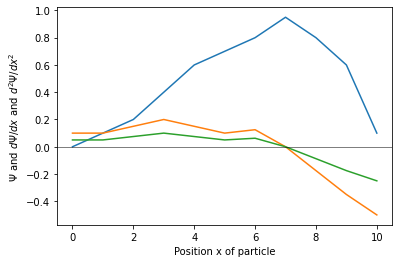

In [ ]:
#X = np.linspace(0, 10, endpoint=True)
#F1 = 3 * np.sin(X)

f1 = np.array([0, 0.1, 0.2, 0.4, 0.6, 0.7, 0.8, 0.95, 0.8, 0.6, 0.1], dtype=float)
f2 = np.gradient(f1)
f3 = np.gradient(f1, 2)
# https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
plt.plot(f1)
plt.plot(f2)
plt.plot(f3)
plt.axhline(y=0, color='black', linewidth=0.5, linestyle='-')
plt.xlabel("Position x of particle")
plt.ylabel("$\Psi$ and $d\Psi/dx$ and $d^2\Psi/dx^2$")
plt.show()

So we want to solve this equation:

> $\frac{-\hbar^{2}}{2 m}$ <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> $=E \Psi$

* Normally try to solve <font color="red">$ \frac{d^{2} \Psi}{d x^{2}}$</font> which is second derivative of $\Psi$ with respect to x, when you know what $\Psi$ is, 

* but we don't. We want to go the other way around, which is trickier.

**Step 2: Rearrange the constants**

Luckily we have two constants in our equation (blue):

> <font color="blue">$\frac{-\hbar^{2}}{2 m}$</font> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$E$</font> $\Psi$

Which means we can rearrange the equation to this:

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$

Now we can combine all constants in one constant $-k^2$ = $\frac{-2m E}{\hbar^{2}}$

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$


**Step 3: Identify suitable function for this equation**

* So which type of function obeys this relation $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$-k^2$</font>  $\Psi$? - Would be a [sinusoid](https://de.wikipedia.org/wiki/Sinusoid)!

* $\frac{d^2 y}{d x^{2}}=-y$ - when you start with a sine and differentiate it twice you still end up with a sinusoidal term

* so if we carefully account for the constants in our equation, our solution is going to look like a sinusoid:

> $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ and replacing <font color="blue">$\frac{\sqrt{2 m E}}{\hbar}$</font> with $k$ $\rightarrow$ $\Psi$ = $\sin ($ <font color="blue">$k$</font> $x)$

*Compare this with before (above is no minus and root taken is first term):*

> $ \frac{d^{2} \Psi}{d x^{2}}$ = <font color="blue">$\frac{-2m E}{\hbar^{2}}$</font>  $\Psi$ =  <font color="blue">$-k^2$</font>  $\Psi$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_176.png)

**Step 4: Work our the boundaries to solve the differential equation, which means to get wavefunction**


**When x = 0 $\rightarrow$ $\Psi$ = 0**

* so at the wall at point a $\Psi$ = 0, so that we first derivative is not getting infinite!

* this works quite nice with sinusoidal, since $\Psi = sin(kx)$ $\rightarrow$ 0 = sin(k(0)) = 0

**When x = a $\rightarrow$ $\Psi$ = 0**

* 0 = sin(k(a)) since $\Psi$ = sin(kx) $\rightarrow$ 0 = sin(k(a)) = 0

* we essentially find a restriction on the kind of sine wave that we can have as a solution

* for example half a sine wave is a possible solution

  * it's y=0 at point x=0 and x=a (at the walls), so $sin(ka) = 0$

  * so we went through half a sine wave which means that this part in brackets (ka) must be equal to 180 degrees (because that's half a sine wave) $y = \frac{1}{2}sin(x)$

  * and if we use radians instead of degrees, which is the other unit of measuring angles, and a much more natural unit of measuring angles, then 180 degrees is actually equal to <font color="blue">$\pi$ radians = (ka)</font>

  * So: $y = \frac{1}{2}sin(x) = \pi$

* this means that this equation holds true if our wavefunction is half a sine wave <font color="blue">$(ka)$ = $\pi$ = $\frac{\sqrt{2m E}}{\hbar}a$</font> , recall: k = $\frac{\sqrt{2m E}}{\hbar}$

* from earlier: $\Psi$ = $\sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$ =  $\sin ($ <font color="blue">$k$</font> $x)$



**Step 5: Rearrange that equation to get the energy value**


* and if we rearrange that <font color="blue">$(ka)$ = $\frac{\sqrt{2m E}}{\hbar}a$ = $\pi$ </font> we have something that tells us the value of the energy $E$:

> $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* (with reduced Planck constant: $\hbar=\frac{h}{2 \pi} =1.054571817 \ldots \times 10^{-34} \mathrm{~J} \cdot \mathrm{s}$)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_178.png)

* in other words: if our wavefunction looks like this (half a sine function), then the energy of our particle is this $E=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

* another possibe solution is a full sine wave fitting into this region, just that the value at the end of the wall is 360 degrees, because we went through the whole sine wave = 2*$\pi$ radians

  * if the wavefunction looks like a whole sine wave <font color="blue">$\frac{\sqrt{2m E}}{\hbar}a$</font> = 2*$\pi$

  * then the  energy of the particle is $E=\frac{4h^{2} \pi^{2}}{2 m a^{2}}$

* We can continue doing this for lots of half sine waves, so we could have three or four half fine waves in our region - and in each case we can calculate the energy of a particle when its wavefunction looks like those sine waves. 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_177.png)

* This phenomenom is called "Quantization".

  * because we can only have specific wave functions, and they correspond to specific energies, a particle can therefore only have specific energies

  * so it cannot be anyhting in between and it cannot be less than the minimum of half a sine wave $E_{1}=\frac{h^{2} \pi^{2}}{2 m a^{2}}$

  * this is also why for this particular setup cosine doesnt work (normally it does though) $\Psi=\cos \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

**Step 6: Normalization to get probabilities**

*Normalization of the wavefunction*

* there is one more thing to consider when finding a solution to the Schrodinger equation: Normalization

> $\Psi = \sqrt{\frac{2}{a}} \sin \left(\frac{\sqrt{2 m E}}{\hbar} x\right)$

* it adds a factor of $\sqrt{\frac{2}{a}}$ to our solution

* physical meaning: if our particle is in the lowest energy level $E_1$. Then in our specific setup with the two walls the wavefunction looks like half a sine wave. And remember the wavefunction corresponds directly to the probability of us finding that particle at a particular point in space. And this relationshipn is if we square our wavefunction $|\Psi|^2$ (we take the square modulus), then we get the probability

###### <font color="blue">**Eigenvalues (Eigenspectrum)**

> **Eigenvalue = Value of an observable, like principal quantum number or Drehimpuls, corresponding to the allowed energy levels of the quantum system**

**Eigenvalue Equation:**

> $Ax=\lambda x$

**In quantum mechanics, every experimental measurable $a$ is the Eigenvalue of a specific operator $(\hat{A}):$**

> $
\hat{A} \psi=a \psi
$

> <font color="blue">**The $a$ eigenvalues represents the possible measured values of the $\hat{A}$ (i.e. measurement) operator (z.B. stabile Energielevel)**</font>

* <font color="red">Eigenvalue = value of an observable, like principal quantum number or Drehimpuls, corresponding to the allowed energy levels of the quantum system</font>

* Classically, $a$ would be allowed to vary continuously, **but in quantum mechanics, $a$ Eigenvalues typically has only a sub-set of allowed values (hence the quantum aspect)**. 

* Both timedependent and time-independent Schrödinger equations are the best known instances of an eigenvalue equations in quantum mechanics, with its eigenvalues corresponding to the allowed energy levels of the quantum system

> **Messbar sind nur die Eigenwerte der Operatoren**. Hat z. B. der Hamiltonoperator, der die Energie eines quantenmechanischen Systems repräsentiert, ein diskretes Spektrum, so kann die Energie nur diskrete Werte annehmen, was z. B. für die Energieniveaus in einem Atom typisch ist. 


Die jeweils möglichen Messwerte n bilden das Spektrum der Observablen. Sie können sowohl diskret als auch kontinuierlich verteilt sein. Im diskreten Fall werden sie Eigenwerte der Observablen genannt. Meist wird der Einfachheit halber angenommen, dass das Spektrum rein diskret ist, obwohl wichtige Observable existieren, deren Spektrum rein-kontinuierlich ist (zum Beispiel Orts- und Impulsoperator).

**Spektrum**: Bereich der möglichen Messwerte. **Eigenvalues = z.B. stabile Energielevel**. For every problem there is a different hamiltonian and a different corresponding Eigenspectrum


###### <font color="blue">**Observables**

*Aus dem Chapter 'Quanten Numbers" zum Thema 'Observables':*

* A physical observable is anything that can be measured.

Siehe auch: ["Vollständiger Satz kommutierender Observablen"](https://de.wikipedia.org/wiki/Vollständiger_Satz_kommutierender_Observablen)

* Begriff aus der Quantenmechanik, in der Messgrößen wie Energie, Ort oder Impuls durch Operatoren dargestellt und als Observablen bezeichnet werden. 

* **Messgrößen, die man gleichzeitig genau bestimmen kann, heißen kommutierende Observablen; sie haben die Eigenschaft, dass ihre Operatoren miteinander vertauschen**.

* Solch ein Verhalten ist in der Quantenmechanik allerdings eher die Ausnahme. Die meisten Paare von Observablen lassen sich nicht gleichzeitig beliebig genau messen, was eine Konsequenz aus der heisenbergschen Unschärferelation ist. Man spricht dann auch von komplementären Observablen.

> **Messbar sind nur die Eigenwerte der Operatoren**. Hat z. B. der Hamiltonoperator, der die Energie eines quantenmechanischen Systems repräsentiert, ein diskretes Spektrum, so kann die Energie nur diskrete Werte annehmen, was z. B. für die Energieniveaus in einem Atom typisch ist. 


> **Um einen quantenmechanischen Zustand eindeutig zu charakterisieren, sind oft mehrere Observablen notwendig**. Beispielsweise ist es beim Wasserstoffatom nicht ausreichend, nur die Energie anzugeben (mittels der Hauptquantenzahl n), sondern es sind zwei weitere Observablen notwendig: der Betrag des Drehimpulses (Quantenzahl l) und die z-Komponente des Drehimpuls (Quantenzahl m). Diese drei Größen bilden dann einen vollständigen Satz kommutierender Observablen.


Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O., wenn eine **orthonormale Basis des Zustandsraums aus gemeinsamen Eigenvektoren** der Observablen existiert, und diese Basis (bis auf einen Phasenfaktor) eindeutig ist.

Eine äquivalente Formulierung lautet: Eine Menge von Observablen A, B, C,... bildet einen v.S.k.O. genau dann, wenn:

* alle Observablen paarweise miteinander vertauschen, und

* <font color="red">**die Angabe der Eigenwerte aller dieser Operatoren ausreicht, um (bis auf einen Faktor) eindeutig einen gemeinsamen Eigenvektor zu bestimmen**.</font>

<font color="blue">Um ein quantenmechanisches Problem zu lösen, ist man bemüht eine Menge von Observablen zu finden, die das System beschreiben und einen v.S.k.O. bilden.</font>

* **Durch die Angabe der Messwerte der Observablen (das sind die Eigenwerte der Observablen**) ist es damit möglich den Zustand eines Systems eindeutig zu bestimmen. 

* Umgekehrt bedeutet das, dass man eine Messung auf einen vollständigen Satz kommutierender Observablen erstrecken muss, um den Zustand des Systems nach der Messung durch die Angabe der Messwerte eindeutig zu bestimmen.

> **Auch die Unmöglichkeit der gleichzeitigen präzisen Messung gewisser Größen (z. B. von Ort und Impuls), wie von der Heisenbergschen Unschärferelation ausgedrückt, ist letztlich darauf zurückzuführen, dass für die jeweiligen Operatoren kein gemeinsames System von Eigenvektoren existiert.**


###### <font color="blue">**Operators**

https://de.m.wikipedia.org/wiki/Linearer_Operator

Video: [Quantum Operators and Commutators](https://www.youtube.com/watch?v=so1szjHu7jY&list=WL&index=53)

* State of a quantum system described as a vector $x$, like spin up or down (spin = in-built angular momentum)

* for an electron the amount of spin it has is fixed

* but if we measure how the electron is spinning in one direction (like: spin up), then we could find one of two results

* these spins can be represented as vectors in some abstract space. Any quantum state that we can find our particle in behaves like a vector and interacts with other possible states (like normal: vectors interact with other vectors) 

* if a quantum state can be described like a vector, then making a measurement of a system can be treated mathematically as a matrix. 

	* These are the "measurement operators", like $S_z$ measures electron spin along z-direction.

> **More correct: the act of taking a measurement (like trying to find the spin of our electron) can be mathematically treated like a matrix $U$ or $T$**

From Video: [The SECOND Most Important Equation in Quantum Mechanics: Eigenvalue Equation Explained](https://youtu.be/zejh5yNkFpc)

https://www.youtube.com/watch?v=so1szjHu7jY&list=RDCMUC9lztld5qPi-6WZ9_QIVR6g&start_radio=1&rv=so1szjHu7jY&t=5

**Facts About Unitary Operators**

> Unitary operators are normal, so they are diagonalizable with respect to an orthonormal basis. Eigenvectors of a unitary operator associated with different eigenvalues are orthogonal. **The eigenvalues have [unit modulus](https://en.wikipedia.org/wiki/Absolute_value#Complex_numbers), that is, their form is $\mathrm{e}^{\mathrm{i} \alpha}$, where $\alpha$ is a real number**. Unitary operators preserve the inner product, that is, the inner product of $U\left|v_{1}\right\rangle$ by $U\left|v_{2}\right\rangle$ is equal to the inner product of $\left|v_{1}\right\rangle$ by $\left|v_{2}\right\rangle$. The application of a unitary operator on a vector preserves its norm.

> **In der Quantenmechanik werden Teilchen durch komplex-wertige Wellenfunktionen beschrieben und die unitäre Gruppe $U(1)$ wirkt auf diesen Wellenfunktionen durch punktweise Phasentransformation $f \rightarrow e^{i \theta} f$ des Funktionswerts. Das ist eine globale Eichinvarianz.** [Kreisgruppe / unitare Gruppe](https://de.m.wikipedia.org/wiki/Kreisgruppe#Physik)


*Typical Operators:*

* **Hamiltonian**: The Hamiltonian operator corresponds to the total energy of the system

* **Linear Momentum**: The linear momentum operator of a particle moving in one dimension (the x-direction) is

* **Position**: The position operator of a particle moving in one dimension (the x-direction) 

* **Kinetic Energy**: Classically, the kinetic energy of a particle moving in one dimension (the x-direction), in terms of momentum

* **Angular Momentum**: Angular momentum requires a more complex discussion, but is the cross product of the position operator r⃗̂ and the momentum operator  p̂

*Operate on the wavefunction with an operator*

In general, the wavefunction gives the "state of the system" for the system under discussion. It stores all the information available to the observer about the system. **Often in discussions of quantum mechanics, the terms eigenstate and wavefunction are used interchangeably**. The term eigenvalue is used to designate the value of measurable quantity associated with the wavefunction.

* If you want to measure the energy of a particle, you have to operate on the wavefunction with the Hamiltonian operator

* If you want to measure the momentum of a particle, you have to operate on wavefunction with the momentum operator

* If you want to measure the position of a particle, you have to operate on wavefunction with the position operator

* If you want to measure the kinetic energy of a particle, you have to operate on wavefunction with the kinetic energy operator

https://chem.libretexts.org/Courses/Pacific_Union_College/Quantum_Chemistry/03%3A_The_Schrodinger_Equation_and_a_Particle_in_a_Box/3.03%3A_The_Schrödinger_Equation_is_an_Eigenvalue_Problem

**<font color="orange">Ortsoperators $\hat{x}$</font>**

Der [Ortsoperator](https://de.m.wikipedia.org/wiki/Ortsoperator) gehört in der Quantenmechanik zur Ortsmessung von Teilchen.

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch gegeben durch den zugehörigen Vektor eines Hilbertraumes $\mathrm{H}$. 

* Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben. 

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathrm{H}$ dargestellt.

Speziell ist der Ortsoperator die Zusammenfassung der drei Observablen $\hat{\mathbf{x}}=\left(\hat{x}_{1}, \hat{x}_{2}, \hat{x}_{3}\right)$, so dass

>$
E\left(\hat{x}_{j}\right)=\left\langle\hat{x}_{j} \Psi, \Psi\right\rangle_{\mathrm{H}}, \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der j-ten Ortskoordinate des Teilchens im Zustand $\Psi$ ist.

https://de.m.wikipedia.org/wiki/Dirac-Notation#Darstellungen_in_der_Quantenmechanik

https://en.m.wikipedia.org/wiki/Position_and_momentum_space

**<font color="orange">Impulsoperators $\hat{p}$ (Momentum Operator)</font>**

Der [Impulsoperator](https://de.m.wikipedia.org/wiki/Impulsoperator) $\hat{p}$ ist in der Quantenmechanik der Operator zur Impulsmessung von Teilchen. In der Ortsdarstellung ist der Impulsoperator in einer Dimension gegeben durch:

>$
\hat{p}_{x}=-\mathrm{i} \hbar \frac{\partial}{\partial x}=\frac{\hbar}{i} \frac{\partial}{\partial x}
$

Dabei bezeichnet
- i die Imaginäre Einheit
- $\hbar$ die reduzierte Planck-Konstante und
- $\frac{\partial}{\partial x}$ die partielle Ableitung in Richtung der Ortskoordinate $x$.

Mit dem Nabla-Operator $\nabla$ erhält man in drei Dimensionen den Vektor:

>$
\hat{\mathbf{p}}=-\mathrm{i} \hbar \nabla
$

* Der physikalische Zustand $\Psi$ eines Teilchens ist in der Quantenmechanik mathematisch durch einen zugehörigen Vektor eines Hilbertraumes $\mathcal{H}$ gegeben. 

* Dieser Zustand wird folglich in der Bra-Ket-Notation durch den Vektor $|\Psi\rangle$ beschrieben. 

* Die Observablen werden durch selbstadjungierte Operatoren auf $\mathcal{H}$ dargestellt. 

* Speziell ist der Impuls-Operator die Zusammenfassung der drei Observablen $\hat{\mathbf{p}}=\left(\hat{p}_{1}, \hat{p}_{2}, \hat{p}_{3}\right)$, so dass

>$
E\left(\hat{p}_{j}\right)=\left\langle\Psi\left|\hat{p}_{j}\right| \Psi\right\rangle \quad j=1,2,3
$

der Mittelwert (Erwartungswert) der Messergebnisse der $j$ -ten Komponente des Impulses des Teilchens im Zustand $\Psi$ ist.

https://youtu.be/so1szjHu7jY

###### **<font color="blue">Hamiltonian Operator $\mathcal{H}$</font>**

> <font color="red">**The sum of the possible outcomes of kinetic and potential energy of this entire system in quantum mechanics is referred to the Hamiltonian $\mathcal{H}$ (to calculate the lowest total energy of a two atom system)**

> Hamiltonian Operator a set of operations **concerning interactions that dictate the state of the system** = Hamiltonian Operator typically describes the total energy of a system or particle.

https://de.m.wikipedia.org/wiki/Hamilton-Funktion

https://de.m.wikipedia.org/wiki/Hamiltonoperator

Spektrum: Bereich der möglichen Messwerte. Eigenvalues = stabile Energielevel. 

**For every problem there is a different hamiltonian and a different corresponding Eigenspectrum**.


Hamilton-Operator (Energie-Operator): Die Eigenzustaende dieses Energieoperators sind dann die Energiezustaende, die stabil sind. In der Atomphysik sind das dann die Zustande, die die Elektronen in den Orbitalen beschreiben


**Hamiltonian Operator and Time Evolution**

* Der Zustand eines quantenmechanischen Systems verändert sich mit der Zeit. Schwirrt beispielsweise ein Elektron durch ein Magnetfeld, ändert sich seine Flugbahn zu jedem Zeitpunkt. Eine berühmte lineare Abbildung diktiert diese Zeitentwicklung: Die zeitliche Änderung des Zustandsvektors ergibt sich durch die Anwendung des Hamilton-Operators auf diesen Vektor.

* Die vielleicht bedeutendste Eigenschaft des Hamilton-Operators besteht aber darin, dass sich die Energien eines physikalischen Systems in ihm verstecken. **Möchte man beispielsweise die verschiedenen Energieniveaus eines Atoms berechnen, genügt es, einige charakteristische Zahlen des entsprechenden Hamilton-Operators zu betrachten, die so genannten Eigenwerte**.

* Die gesamte Menge dieser Eigenwerte heißt »Spektrum« in Anlehnung an den gleich- namigen Begriff aus der Physik, der alle Energien bezeichnet, bei denen die Elektro- nenhülle eines chemischen Elements ein Photon absorbieren oder emittieren kann (siehe »Spektrum einer Welle«).

* Im Allgemeinen beschreibt der Hamilton-Operator also nicht bloß die zeitliche Entwicklung eines quantenmechanischen Objekts; seine Eigenwerte entsprechen au- ßerdem den Energien des Systems, und die dazugehörigen Eigenvektoren sind die Ba- siszustände. Das macht den Hamilton-Ope- rator zu einem der wichtigsten physikali- schen Werkzeuge.

*Quelle: Spektrum der Wissenschaft Spezial: Primzahlen*


Der [Zeitentwicklungsoperator](https://de.m.wikipedia.org/wiki/Zeitentwicklungsoperator) $\mathcal{U}$ bzw. $\mathcal{T}$ ist ein quantenmechanischer Operator, mit dem sich die zeitliche Entwicklung eines physikalischen Systems berechnen lässt. Der quantenmechanische Operator ist eng verwandt mit dem [Propagator](https://de.m.wikipedia.org/wiki/Propagator) in der Quantenfeld- oder Vielteilchentheorie. Üblicherweise wird er als $U\left(t, t_{0}\right)$ geschrieben und bezeichnet die Entwicklung des Systems vom Zeitpunkt $t_{0}$ zum Zeitpunkt $t$.

*Über die Exponentiation der Schrödingergleichung*

Der Zeitentwicklungsoperator $U\left(t, t_{0}\right)$ wird definiert über die Zeitentwicklung eines beliebigen Zustandes $|\psi\rangle$ zu einem Zeitpunkt $t_{0}$ bis zum Zeitpunkt $t$ :

>$
|\psi(t)\rangle=U\left(t, t_{0}\right)\left|\psi\left(t_{0}\right)\right\rangle \quad \forall|\psi\rangle
$

Einsetzen in die Schrödingergleichung liefert einen Satz gewöhnlicher Differentialgleichungen 1. Ordnung:

>$\mathrm{i} \hbar \frac{\partial}{\partial t} U\left(t, t_{0}\right)=H(t) U\left(t, t_{0}\right)$

Diese Gleichungen sind zur Schrödingergleichung insofern äquivalent, als sie die Erweiterung des Zeitentwicklungsoperators um einen infinitesimalen Zeitschritt $\delta t$ beschreiben:

>$
U\left(t+\delta t, t_{0}\right)=\left(1-\frac{i}{\hbar} H(t) \delta t\right) U\left(t, t_{0}\right)+O\left(\delta t^{2}\right)
$

mit dem Hamiltonoperator $H$, der den Erzeuger der Zeitentwicklungen darstellt.

https://en.m.wikipedia.org/wiki/Time_evolution (Evolution Operator)

**The Hamiltonian $\mathcal{H}$ operator describes the energy of a system (Classical Ising Model?)**: 

  * der [Hamiltonoperator](https://de.m.wikipedia.org/wiki/Hamiltonoperator) ist in der Quantenmechanik ein Operator, **der (mögliche) Energiemesswerte und die Zeitentwicklung angibt**. Er ist daher der Energieoperator. <font color="red">Er liefert beispielsweise die Energieniveaus des Elektrons im Wasserstoffatom.</font>

  * In der Quantenmechanik wird jeder Zustand des betrachteten physikalischen Systems durch einen zugehörigen Vektor $\psi$ im Hilbertraum angegeben. Seine Zeitentwicklung wird nach der Schrödingergleichung durch den Hamiltonoperator $\hat{H}$ bestimmt:

>$
\mathrm{i} \hbar \frac{\partial}{\partial t} \psi(t)=\hat{H} \psi(t)
$

  * mit der imaginären Einheit i
  
  * und der reduzierten Planckschen Konstante $\hbar=\frac{h}{2 \pi}$.

  * In der Eigenwertgleichung sind die Eigenwerte E die zugehörigen Energien.

**<font color="blue">More about: Hamilton Operator $\mathcal{H}$</font> (Classical Ising Model)**

https://de.wikipedia.org/wiki/Quantenmechanik#Stationäre_Zustände

weitergeleitet von hier:

https://de.wikipedia.org/wiki/Plancksches_Wirkungsquantum

https://de.m.wikipedia.org/wiki/Zufallsmatrix

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_009.png)

https://www.youtube.com/watch?v=Wy9YoEYv-fA&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=49

* A spin is a two state system, like two magnets that you approach each other and then they anti-align, so this will be their optimal energy configuration

* if you identify random variables with them, so sigma 1 = 1 for north up and sigma 2 = -1 for south up, and then you add another one and another one. You can write it as a sum of nearest neighbors. 

* this describes the energy of a system and we want to minimize it (naturally state in nature). 

* let's make it a bit more complicated: let's assume there is a wall that you can control between the magnets. With that you can change the strength of interaction between the individual pairs, you can change the coupling strengths - to include this in the equation, we add a term Ǝ

* now we complicate it a bit more and add an external magnetic field below each of these individual magnets. If this magnet field is strong enough, it can flip the magnet with the South Pole pointing to top and flip it upside down. This means the external magnet will overwrite the interactions that happen between the individual magnets. We model this external magnetic field influence by adding one more term to the equation, which is goin to be the strengths of this field h and the actual sigma value, the value of the random value in that spot. 

* this is actually a very hard problem to solve in nature: if you look at the energy landscape of this problem, and what can happen is that they might get stuck in some local optimum. And by overcoming this local barrier they could attain a better configuration.

* that's the same kind of problem we see in computer sciences in certain np hard problems: for example in the [quadratic unconstrained binary optimization problem (QUBO)](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization) it has a very similar form. You have binary random variables and you have some interaction strength between them (coefficients), and you have also a bias term affecting individual random variables. On a classical computer in the general case this takes exponentially many evaluations to find the global optimum. 

* so there is this natural correspondence between what's computationally hard and what's physically difficult to solve.



**Hamiltonian**

* the Hamiltonian has a formula where you input the state of the system and it outputs the energy of the system (both quantum & classical system)

* inout state of all qubits, Hamiltonian will give energy of that state 

* Quantum annealing: tries to find state of all qubits that gives us lowest energy

* lowest energy state of initial Hamiltonian is when all the qubits are in a superposition state of zero and one (easy set up of the system)

* Ideally you stay in the minimum energy state throughout the quantum annealing procedure (In annealing: initially quantum states, at the end classical states)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_009a.png)

###### <font color="blue">**Eigenstates (Eigenvector)**

> **Eigenstate = Wavefunction $\psi$**

**Some states are Eigenstates of a measurement**

* For example before we make our measurement the electron happens to be in the spinning clockwise state $|1\rangle$

* if we then make a spin measurement of the state of this electron stays the same, making a measurement does not affect our system

* <font color="blue">**What we end up measuring when we make our measurement is the Eigenvalue, like $\frac{\hbar}{2}$ in: $S_z$ $|1\rangle$ = $\frac{\hbar}{2}$ $|1\rangle$**</font>

	* $S_z$ $\rightarrow$ measurement operator matrix $A$

	* $\frac{\hbar}{2}$ $\rightarrow$ Eigenvalue $\lambda$

	* $|1\rangle$ $\rightarrow$ state stays the same, the Eigenstate $|\psi \rangle$, in the Eigenvalue equation it is $x$

	* <font color="red">You can see the similarity with the Eigenvalue Equation: $Ax=\lambda x$ with: $S_z$ $|1\rangle$ = $\frac{\hbar}{2}$ $|1\rangle$</font>



* Our measurement result would be an angular momentum of $\frac{\hbar}{2}$ with $\hbar$ known as the "Reduced Planck Constant" : this is the numerical value we'll find

* Eigenstates of of any operator always behave like perpendicular vectors, there is no component of one vector in the other (there is no way to write one vector in terms of another)

* <font color="blue">So, in many ways making a measurement on a system that is already in an Eigenstate is pretty intuitive: **the system remains in the same state and the numerical result we get because of our measurement is the Eigenvalue of the state: multiplying the vector with the measurement matrix doesn't change the vector, so the value in front of the vector (its energy state) is the Eigenvalue, and the vector itself the Eigenvector!**</font>

* an operator that represents a spin measurement in this direction for an electron has two Eigenstates: clockwise and anti clockwise spin

> **Auch die Unmöglichkeit der gleichzeitigen präzisen Messung gewisser Größen (z. B. von Ort und Impuls), wie von der Heisenbergschen Unschärferelation ausgedrückt, ist letztlich darauf zurückzuführen, dass für die jeweiligen Operatoren kein gemeinsames System von Eigenvektoren existiert.**


**What happens if our system is initially not in an Eigenstate? What if we apply our measurement operator to some other state vector?**

> $S_{z} |\psi\rangle =?$ $\rightarrow$ With $|\psi\rangle$ being a general state (not Eigenstate!)

* **applying a matrix to a vector that was not an Eigenvector, then that vector ends up getting transformed**. Similarly in quantum mechanics, a state that is not an Eigenstate or Eigenvector of our measurement operator

* Remember an electron can be in a superposition of multiple states. This quantum state is created by a linear combination of some amounts of spin up probability and spin down probability

* What this means is that the electron has some probability of being found in either state when we make our spin measurement. **And this is what happens when we make our measurement on a non-Eigenstate**. 

> <font color="blue">**By some random process that we don't fully understand yet a measurement causes the state to change into one of the Eigenstates.** </font>

* And we can even calculate the probability with which our measurement will result in one state vs the other. (The probability for a particular result is just the square of this quantity)

> <font color="blue">**Even if the system is not in an Eigenstate but in a superposition of states, the Eigenvalue equation is still important because it helps us figuring out the possible measurement results we could find when we make the measurement on our system.**</font>

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_152.png)

Worth mentioning: slight difference between what happens when you apply a transformation matrix to a normal vector, like here: $\left[\begin{array}{cc}17 & -35 \\ 6 & -12\end{array}\right]\left(\begin{array}{l}1 \\ 1\end{array}\right)=\left(\begin{array}{c}-18 \\ -6\end{array}\right)$ 

and what happens when you apply a measurement operator to a quantum state that isn't an Eigenstate $S_{z}\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}} |1\rangle\right)$:

* whereas in the mathematical scenario every matrix can be applied to any vector, and you can calculate exactly what the resultant vector should be, 

* **in the quantum case, because we are talking about superposition of states, this results in a random collapse into one of the possible Eigenstates**

* **Eigenvektor: Vektoren, die bei einer Transformation mit einer Matrix ihre Richtung nicht ändern**. 

* Z.B. Rotationen um eine Achse = Achse bleibt fest und ist Eigenvektor (bei einfachen Rotationen Eigenwert = 1). 

* in mechanik: trägheitsmoment gegenüber rotationen. Hauptachsen mit Tensorrechnung. die hauptachsen sind diejenigen richtungen, in die die drehungen stabile verlaufen. drehimpuls und winkelgeschwindigkeit haben gleiche richtung. keine schwankungen der drehachsen, sie sind stabil. (https://www.grund-wissen.de/physik/mechanik/kinematik/kreisfoermige-bewegungen.html)

* **Quantenmechanik: hermetische Operatoren. Diese führen zu Eigenwerten und Eigenvektoren**. 

	* Interessant ist bei solchen Operatoren bzw. bei den linearen Abbildungen bei den symmetrischen Matrizen im Reellen: Eigenvektoren stehen im reellen senkrecht aufeinander. (Bilden eine Orthonormalbasis). 

	* Man kann Vektorraum mit diesen Eigenvektoren aufspannen und jeden Vektor als Linearkombination dieser Eigenvektoren darstellen.

	* **Dann ist das Verhalten der Abbildungen quasi reduziert auf das Verhalten der Eigenvektoren mit ihren entsprechenden Eigenwerten, so dass dann jeder Vektor wenn man ihn in die Basis der Eigenvektoren schreibt, relativ einfach transformiert werden kann**, indem man einfach die entsprechenden Eigenvektor-Skalierungen beachtet und später die Summe immer wieder bildet (ist ja alles linear).

**Spezielle Vektoren der Quantenmechanik**:

* Hamilton-Operator (Energie-Operator): Die Eigenzustaende dieses Energieoperators sind dann die Energiezustaende, die stabil sind. In der Atomphysik sind das dann die Zustande, die die Elektronen in den Orbitalen beschreiben

* Genauso gibt es Eigenvektoren zu den Drehimpuls-Operatoren (und zu anderen Dingen). Hier kommt Eigenwert-Theorie zum blühen. Die entsprechende Orthonormal-Basis ist dann auch die Basis in der man jede beliebigen Zustand des Systems beschreiben kann. 

###### <font color="blue">**Eigenfunction**

> <font color="red">**So stellen bei den Lösungen der bekannten Schrödingergleichung die Eigenwerte die erlaubten Energiewerte der Elektronen und die Eigenfunktionen die zugehörigen Wellenfunktionen der Elektronen dar.**


Die jeweils möglichen Messwerte n bilden das Spektrum der Observablen. Sie können sowohl diskret als auch kontinuierlich verteilt sein. Im diskreten Fall werden sie Eigenwerte der Observablen genannt. **Meist wird der Einfachheit halber angenommen, dass das Spektrum rein diskret ist, obwohl wichtige Observable existieren, deren Spektrum rein-kontinuierlich ist (zum Beispiel Orts- und Impulsoperator).**

> <font color="red">Die zu den Eigenwerten zugehörigen Zustände $|n\rangle$ werden als **Eigenzustände** der Observablen bezeichnet. <u>Bei kontinuierlichem Spektrum spricht man von verallgemeinerten **Eigenfunktionen**</u>. Dabei handelt es sich um **Distributionen** wie die Dirac-Funktion.

* [Eigenwerte](https://de.m.wikipedia.org/wiki/Eigenwertproblem) spielen in der Quantenmechanik eine besondere Rolle. Physikalische Größen wie z. B. der Drehimpuls werden hier durch Operatoren repräsentiert. 

* **Messbar sind nur die Eigenwerte der Operatoren**. Hat z. B. der Hamiltonoperator, der die Energie eines quantenmechanischen Systems repräsentiert, ein diskretes Spektrum, so kann die Energie nur diskrete Werte annehmen, was z. B. für die Energieniveaus in einem Atom typisch ist. 


* <font color="blue">It is a general principle of Quantum Mechanics that there is an operator for every physical observable.</font>

* A physical observable is anything that can be measured.

> <font color="red">**If the wavefunction that describes a system is an <u>eigenfunction</u> of an operator, then the value of the associated observable is extracted from the eigenfunction by operating on the eigenfunction with the appropriate operator.**</font>

> **The value of the observable for the system is the eigenvalue, and the system is said to be in an <u>eigenstate</u>.**

* Equation $
\hat{H} \psi(x)=E \psi(x)
$ states this principle mathematically for the case of energy as the observable.


* The operators must yield real **eigenvalues**, since they are values which may come up as the result of the experiment. Mathematically this means the operators must be Hermitian.

* The probability of each eigenvalue is related to the projection of the physical state on the subspace related to that eigenvalue.

> Spektrum: Bereich der möglichen Messwerte

* Eigenvalues = stabile Energielevel

* For every problem there is a different hamiltonian and a different corresponding Eigenspectrum 

> **Auch die Unmöglichkeit der gleichzeitigen präzisen Messung gewisser Größen (z. B. von Ort und Impuls), wie von der Heisenbergschen Unschärferelation ausgedrückt, ist letztlich darauf zurückzuführen, dass für die jeweiligen Operatoren kein gemeinsames System von Eigenvektoren existiert.**


###### <font color="blue">**Schrödinger equation: Time Independent (Eigenvalue Equation)**</font>

https://de.m.wikipedia.org/wiki/Schrödingergleichung 


**The Schroedinger equation can be written as a type of Eigenvalue equation**

> $\hat{H}|\psi\rangle= -i \hbar \frac{d}{d t}|\psi\rangle =\frac{\hbar}{i} \frac{d}{d t}|\psi\rangle$

Mit dem Impulsoperator (stimmt das?):

>$
\hat{p}_{x}=-\mathrm{i} \hbar \frac{\partial}{\partial x}=\frac{\hbar}{i} \frac{\partial}{\partial x}
$

**Simplified (when system is not changing over time: time-independent Schroedinger equation):**

> $\hat{H}|\psi\rangle=E |\psi\rangle$

* $\hat{H}$  - measurement operator (matrix): measures the total energy of a system

* $E$ - Eigenvalue: is the numerical energy value that we measure

* $|\psi\rangle$ - Eigenstates / Eigenvector: are the various Eigenstates that we can measure

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_151.png)

**From video [Crash course in density matrices](https://youtu.be/1tserF6VGqI):**

**Dynamics: if we want to study how a quantum system changes in time, we usually refer to the Schroedinger equation.**

> $i \frac{d}{d t}|\psi(t)\rangle=\hat{H}|\psi\rangle$

* the operator $\hat{H}$ is called the Hamiltonian and it tells us about the total energy in a system, and how things in a system interact with each other.

* **The easiest way to solve this problem is to first solve the Eigenvalue problem**, which involves finding the Eigenvectors and the Eigenvalues of the hamiltonian. We are able the different values of the Eigenvalues and Eigenvectors with the label k:

> $\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* This allows us to know that the Eigenvectors, when plugged into the Schroedinger equation ...

> $i \frac{d}{d t}\left|E_{k}\right\rangle=\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* **... just pick up a phase in time depending on the energy they correspond to**:

> $\left|E_{k}(t)\right\rangle=e^{-i E_{k} t}\left|E_{k}\right\rangle$

**Now to sum more general situation with some generic state $\psi$**

* we can decompose $\psi$ in terms of energy Eigenbasis:

> $|\psi\rangle=\sum_{m} c_{m}\left|E_{m}\right\rangle$

* where $c_{m}$ is given by the inner product of the energy Eigenvector labelled by m and $\psi$ itself:

> $c_{m}=\left\langle E_{m} \mid \psi\right\rangle$

* We can then time-evolve the state by simply time-evolving the energy Eigen-Kets:

> $|\psi(t)\rangle=\sum_{m} c_{m} e^{-i E_{m} t}\left|E_{m}\right\rangle$

* Tracking the expectation value of an observable is quite easy: Simply applying the state vector in time to both sides of the matrix gives the following equation: 

> $\langle A(t)\rangle=\sum_{m, n} \bar{c}_{n} c_{m} A_{n, m} e^{i\left(E_{n}-E_{m}\right) t}$

* Where we have labelled the matrix entries of a by the energy Eigenbasis in the following way:

> $A_{n, m}=\left\langle E_{n}|A| E_{m}\right\rangle$

**Schrödinger Equation: Time-<font color="blue">Independent</font> Version**

Video: [What is The Schrödinger Equation, Exactly?
](https://youtu.be/QeUMFo8sODk)

> $E \Psi(x)=\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}+V \Psi(x)$

* E = **Energy the electron** is allowed to have

* $\Psi$ = **Wavefunction** (most likely position of an electron)

* **Kinetic energy**: $\frac{-\hbar^{2}}{2 m} \frac{d^{2} \Psi(x)}{d x^{2}}$ (klassische Form: $K E=\frac{1}{2} m v^{2}$)

* **Potential energy**: $V \Psi(x)$

*What would a typical Schroedinger solution look like? - All the solutions to the wave function take these two forms:*

> $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$ when $n=1,3,5 \ldots$ (is odd $)$

> $\Psi(x)=\sqrt{\frac{2}{L}} \sin \left(\frac{\pi n x}{L}\right)$ when $n=2,4,6 \ldots$ (is even)

*Now looking at $\psi$, the probable position of an electron:*

* central question: where is the electron?

* n is the energy state / level of an electron (look above at quantum numbers)

* When an electron is state n=1 (its first energy state) we apply the first formula: $\Psi(x)=\sqrt{\frac{2}{L}} \cos \left(\frac{\pi n x}{L}\right)$

* then we get wave function for the electron that is in a given box in this case:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_147.png)

* And if we square it, we get the probability distribution (the probable position of an electron):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_148.png)


* And here some wave functions and probability densities for other energy states:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_149.png)



*And the solution that popped out was this:*

> $E=\frac{\hbar^{2} n^{2} \pi^{2}}{2 m L^{2}}$

* Everything is a constant ($\hbar$, $\pi$, 2, m, L) or a whole number (here: n, which stands for the different states of an electron)

* which means that energy E can ony have certain discrete (=quantum) values

###### <font color="blue">**Schrödinger equation: Time Dependent**

**Consider: Difference of probability in the position basis (changes over time) and the energy basis (doesn't change):** 

> <font color="red">**The electron is still in the same shell, represented by the principal quantum number for example, because if the electron changes the shell, energy needs to be added or removed from the overall system. however if energy stays the same, it means the electron is still in the same shell, but "moving" around = probability distribution of finding it somewhere in this shell changes over time which is represented by the rotation $e^{i \frac{\hat{H} * t}{\hbar}}$**</font>

Die [Schrödingergleichung](https://de.wikipedia.org/wiki/Schrödingergleichung) ist eine grundlegende Gleichung der Quantenmechanik. Sie beschreibt in Form einer partiellen Differentialgleichung die zeitliche Veränderung des quantenmechanischen Zustands eines nichtrelativistischen Systems. Die Gleichung wurde 1926 von Erwin Schrödinger zuerst als Wellengleichung aufgestellt und bei ihrer ersten Anwendung erfolgreich zur Erklärung der [Spektren des Wasserstoffatoms](https://de.wikipedia.org/wiki/Wasserstoffatom#Lösung_der_Schrödinger-Gleichung_(Wasserstoffproblem)) genutzt.


>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right] \psi(\vec{r})=E \psi(\vec{r})
$

The object on the left that acts on $\psi(x)$ is an example of an operator.

>$
\left[-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})\right]
$ = Operator

In effect, what is says to do is "take the second derivative of $\psi(x)$, multiply the result by $-\left(\hbar^{2} / 2 m\right)$ and then add $V(x) \psi(x)$ to the result of that." 

Quantum mechanics involves many different types of operators. This one, however, plays a special role because it appears on the left side of the Schrödinger equation. **It is called the Hamiltonian operator and is denoted as**

> $
\hat{H}=-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})
$

**Therefore the time-dependent Schrödinger equation can be written as**:

> $
\hat{H} \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

with $\hat{H}$ = $(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r}))$ will be:

> $
(-\frac{\hbar^{2}}{2 m} \nabla^{2}+V(\vec{r})) \; \psi(x, t)=i \hbar \frac{\partial}{\partial t} \psi(x, t)
$

bzw. rewritten:

> $\left[-\frac{\hbar^{2}}{2 m} \frac{\partial^{2}}{\partial x^{2}}+V(x, t)\right] \Psi(x, t) = i \hbar \frac{\partial}{\partial t} \Psi(x, t)$

bzw written in another way (single particle variant):

> <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> + <font color="green">$V(x, t)$</font> ] 
 <font color="blue">$|\psi\rangle$</font> = $i \hbar \frac{\partial}{\partial t}$ <font color="blue">$|\psi\rangle$</font>

* <font color="red">$[-\frac{\hbar^{2}}{2 m} \nabla^{2} $</font> Kinetic energy

* <font color="green">$V(x, t)$</font> Potential energy

* <font color="blue">$|\psi\rangle$</font>  the wave function

https://en.wikipedia.org/wiki/Schrödinger_equation

https://www.youtube.com/watch?v=w9Kyz5y_TPw

<font color="blue">**Schrödinger equation: Time Evolution (Derivation)**

From Video: [The Schrodinger equation made simple | Linearity](https://youtu.be/ZfKq3g3MHqE)

Physics: given an initial state x and its velocity, what's the position at time x later? This is what we want also in quantum mechanics!

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_153.png)

That's what the Schroedinger equation is for: to say what's the future state of a system?

> $i \hbar \frac{\partial}{\partial t} |\Psi (t) \rangle = -\frac{\hbar^{2}}{2 m} \nabla^{2} |\Psi (t) \rangle +\hat{V} |\Psi (t) \rangle$

Easier form:

> $|\Psi (t) \rangle = e^{\frac{i H t}{\hbar}} |\psi (0) \rangle$

* the state of a quantum particle of given by the wave function

* $|\psi (0) \rangle$ this is the wave function at the start, the Schrodinger equation tells you that the time evolver $e^{\frac{i H t}{\hbar}}$ acts on the original wave function to produce the wave function t seconds into the future $|\Psi (t) \rangle$

* **So what is this transformation (time evolver) $e^{\frac{i H t}{\hbar}}$ and why is it that way?**

  * it comes down to conservation of energy

  * time evolution is linear

  * if I have an object and 2 different possible states $\alpha |0\rangle$ and $\beta |1\rangle$ to start with. we apply time evolution to each and then we see how they evolve.
  
  * and then imagine I have a superposition of these two states $\alpha |0\rangle$ and $\beta |1\rangle$. It will be a superposition of the evolution of each of the states. the final outcome is a linear combination of those two: $\alpha |0\rangle$ + $\beta |1\rangle$

  * **The time evolution of a superposition is the linear combination of the time evolution of each of the states.**

  * This even holds if you write the same state in a different basis, for example instead a position basis you choose a momentum basis. So these two states are then equal to each other: they are both the future state. 

* So the general statement of linearity is this, which $T$ being the time evolution operator $e^{\frac{i H t}{\hbar}}$:

> $T |\Psi_{(t=0)} \rangle =  \alpha_1 |\Psi (0) \rangle + \alpha_2 |\Psi (1) \rangle + \alpha_3 |\Psi (2) \rangle$

> $T |\Psi_{(t=0)} \rangle =  \alpha_1 T|\Psi (0) \rangle + \alpha_2 T|\Psi (1) \rangle + \alpha_3 T|\Psi (2) \rangle$

* each part of the superposition evolves completely unaware and independent of the other superposition part.

* this breaks only by measurement. During the measurement, the branches of the superposition have the chance to interact with each other (so it's not linear anymore). So, **measurement doesn't follow the Schrodinger equation ('the measurement problem')**. (Many worlds and pilot-wave mechanics were proposed to get around this).

**If you have a superposition of some states and you apply the time evolution operator**:

> $T\left(\alpha_{1}\left|\psi_{1}\right\rangle+\alpha_{2}\left|\psi_{2}\right\rangle+\ldots\right)=\alpha_{1} T\left|\psi_{1}\right\rangle+\alpha_{2} T\left|\psi_{2}\right\rangle+\ldots$

You can also write each of these in the energy Eigenbasis (because time evolution is very easy in that basis):

> $\left|\psi_{1}\right\rangle=\beta_{11}\left|E_{1}\right\rangle+\beta_{12}\left|E_{2}\right\rangle+\ldots$

> $\left|\psi_{2}\right\rangle=\beta_{21}\left|E_{1}\right\rangle+\beta_{22}\left|E_{2}\right\rangle+\ldots$

this will turn into:

> $=T\left(\alpha_{1}\left(\beta_{11}\left|E_{1}\right\rangle+\beta_{12}\left|E_{2}\right\rangle+\ldots\right)+\alpha_{2}\left(\beta_{21}\left|E_{1}\right\rangle+\beta_{22}\left|E_{2}\right\rangle+\ldots\right)+\ldots\right.$

and factoring in and rewriting the time evolution operator $T = e^{\frac{i \mathcal{H} t}{\hbar}} = e^{\frac{i E t}{\hbar}}$:

> $=\alpha_{1}\left(\beta_{11} e^{\frac{i E_1 t}{\hbar}}\left |E_{1}\right\rangle+\beta_{12} e^{\frac{i E_2 t}{\hbar}} \left|E_{2}\right\rangle+\ldots\right)+\alpha_{2}\left(\beta_{21} e^{\frac{i E_1 t}{\hbar}} \left|E_{1}\right\rangle+\beta_{22} e^{\frac{i E_2 t}{\hbar}} \left|E_{2}\right\rangle+\ldots\right)+\ldots.$

Taken from [Schrodinger equation comment response and homework answers video](https://www.youtube.com/watch?v=M_2h5uQ0SIc)

<font color="blue">**Schrodinger equation: Derivation and how to use it (in Time Evolution)**

From Video [Schrodinger equation | Derivation and how to use it](https://www.youtube.com/watch?v=DEgWbrMv6-k)

Important rules of physics:

* Conservation of energy -> deeply integrated into Schrodinger equation
* total energy doesn't change
* you can't make of destroy energy

**Since we can write a quantum state $|\Psi \rangle$ in whatever basis we want, we can choose the energy Eigenbasis**. <font color="red">what is meant by that? is that the principle quantum number for example</font>

* We can write a state as the superposition of different energies. 

* And if we measure the energy of the particle it will be one of these with their probability

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$ 

* with probability for example $|\beta|^2$ for measuring second state

**Say the state evolves in time, in other words we apply the time evolution $U$ (or $T$) to $|\Psi \rangle$, so $T |\Psi \rangle$** 

* what condition do we want to impose on the new energies of the state? 

* In other words: how we want conservation of energy to look in quantum mechanics?

**Let's start where a particle just has one energy $E$ when we start**

* means: it is an energy Eigenstart !!

* we evolve it forward in time and look at the energy of the new state. That energy should be also $E$, otherwise energy wouldn't be conserved (Like in classical mechanics).

> $|\Psi \rangle$ = $|1 \rangle$ $\rightarrow$ $T|\Psi \rangle$

* Now also the average energy shouldn't change after some time, otherwise the energy wouldn't be conserved either.

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$ 

* if you measured athe particle's energy initially with a certain probability $|\beta|^2$, and then after time evolution again, it should be the same probability to measure that energy!

* this is so strong, it gives us the schroedinger equation

**We need to how the coefficients have changed in the new equation after time evolution**:

> $|\Psi \rangle$ = $\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle$ (before)

> $T |\Psi \rangle$ = $\alpha' |\Psi \rangle + \beta' |\Psi \rangle + \gamma' |\Psi \rangle$ (after)

* We want the probability to be the same, but that probability is just the lenght of this compex number squared $|\gamma|^2 = |\gamma'|^2 = 1$

> <font color="red">**So each coefficient can be represented as an arrow with equal length $|\gamma|^2$ and $|\gamma'|^2$ (hence the probability of measuring that energy this state is still the same!!), BUT $|\gamma'|^2$ may be rotated by an angle $\phi$**. This angle is new vector = rotation * old vector:</font>

> <font color="red">$\gamma' = e^{i\phi}\gamma$</font>

Let's plug that rotation $e^{i\phi}$ in to our previous equation:

> <font color="red">$T |\Psi \rangle$ = $e^{i\phi_1}\alpha |\Psi \rangle + e^{i\phi_2}\beta |\Psi \rangle + e^{i\phi_3}\gamma |\Psi \rangle$</font>

* where the angles / rotations $e^{i\phi}$ are different for every energy = they are all rotated by a different amount !! Otherwise the rotation can be brought out and present and future state would be the essentially same:

> $T |\Psi \rangle$ = $e^{i\phi}\alpha |\Psi \rangle + e^{i\phi}\beta |\Psi \rangle + e^{i\phi}\gamma |\Psi \rangle$ = $e^{i\phi} (\alpha |\Psi \rangle + \beta |\Psi \rangle + \gamma |\Psi \rangle)$ (this is showing that it's wrong!)

The overall rotation wouldn't affect any measurement outcomes. Means no matter in which crazy situation you brought the particle in, it does nothing, which can't be right.

> $T |\Psi \rangle$ = $e^{i\phi}|\Psi \rangle$ (this is showing that it's wrong!


* also the amount of rotation depends on time (little going forwardf = little rotation). That suggests the right amount of angle to rotate is Energy x Time. Plus some constants to deal with units and scaling etc.

> <font color="red">$\phi = \frac{E * t}{\hbar}$</font>

* And that's what the Schroedinger equation will tell you will happen to the state:

> $T |\Psi \rangle$ = $e^{i \frac{E * t}{\hbar}}\alpha |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\beta |\Psi \rangle + e^{i \frac{E * t}{\hbar}}\gamma |\Psi \rangle$

* And that's the same: (with $\hat{H}$ for energy measurement operator, Hamiltonian):

> <font color="red">$T(t) |\Psi \rangle = e^{i \frac{\hat{H} * t}{\hbar}}|\Psi \rangle$</font>


**Let's apply this a bit**

We can show the probabilities in the energy basis also in the position basis: Suppose that in the position basis, each of these had wave function that looked like this:


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_154.png)

Then at the start, adding them up, the probability of finding a particle at various points looks like this:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_155.png)


But see how this evolves in time to give a probability  distribution that changes dramatically:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_156.png)

The reason is these complex numbers: at the start they all just added like normal to give you this. 

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_157.png)


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_155.png)


But later in time, when these complex numbers are pointing different ways, they don't just add up anymore. As an extreme example, if the two arrows from the second and third part pointed in opposite directions, they would subtract from one another. This is why the overall wave function in the position basis can vary so much over time:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_158.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_159.png)

This means depending on the time one measures, the particle might have a very big probability of ending up here versus there:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_160.png)




**Yet if you measure energy, you always get one of these three energies with these probabilities, no matter what time it is:** 

> <font color="red">**I guess this means that the electron is still in the same shell, represented by the principal quantum number for example, because if the electron changes the shell, energy needs to be added or removed from the overall system. however if energy stays the same, it means the electron is still in the same shell, but "moving" around = probability distribution of finding it somewhere in this shell changes over time which is represented by the rotation $e^{i \frac{\hat{H} * t}{\hbar}}$**</font>

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_161.png)

One last thing: **How do we know what the energy Eigenbasis is?**

* if we take an energy Eigenvector, how do we find what it looks in the position basis?

* Schrodinger also gave us an equation that defines what an energy Eigenstate is:

> $\hat{H} = \frac{\hat{p}^2}{2m}+ \hat{V}$

* $\hat{H}$ being the total energy

* $\frac{\hat{p}^2}{2m}$ being kinetic energy

* $\hat{V}$ being potential energy

**The issue is that this equation is extremely hard to solve.** Probably impossible to solve for anything bigger than 2 particles, maybe with quantum computers. That's why physical chemists do so much hard work on the Schrodinger equation 

**Common result for 2 observations:**

Time Evolution per each step, observer 1:

> $| \Psi \rangle$ $\rightarrow$ at $t_1$ = $e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$</font>

Time Evolution at the end for observer 2 (not seeing time step 1):


> $| \Psi \rangle$ $\rightarrow$ at $t_2$ = <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font>

Where:

> <font color="orange">$e^{\frac{i \mathcal{H} (t_1 + t_2)}{\hbar}} | \Psi \rangle$</font> = <font color="blue">$e^{\frac{i \mathcal{H} t_2}{\hbar}} (e^{\frac{i \mathcal{H} t_1}{\hbar}} | \Psi \rangle)$

Why? - because our angle of rotation depends on $t$ (and not $t^2$ or anything): $T\left(t_{1}+t_{2}\right)=T\left(t_{2}\right) T\left(t_{1}\right)$

Taken from [Schrodinger equation comment response and homework answers video](https://www.youtube.com/watch?v=M_2h5uQ0SIc)

###### <font color="blue">**Miscellaneous**

> **Objective: Find out the allowed energy levels of the wave functions of an electron**

> **If we want to study how a quantum system changes in time, we usually refer to the Schroedinger equation.**

* Einstein discovered that energy is proportional to $h$ * frequency: $E = h * f$

* $h$ is Planck's constant ([Plancksches Wirkungsquantum](https://de.wikipedia.org/wiki/Plancksches_Wirkungsquantum))

* Beziehung zwischen der Energie eines Teilchens oder physikalischen Systems und der Frequenz seiner quantenmechanischen Phase ( = [Stationäre Zustände](https://de.wikipedia.org/wiki/Quantenmechanik#Stationäre_Zustände), Eigenzustände zum Hamilton-Operator $\hat H$ )

* nur bestimmte Frequenzen sind erlaubt, damit sind auch nur bestimmte energy levels fur ein elektron erlaubt, was man wiederum mit der schroedingergleichung ermitteln kann

**More on Schrödinger Equation**:

> $i \hbar \frac{\partial}{\partial t} \psi(\mathbf{r}, t)=-\frac{\hbar^{2}}{2 m} \nabla^{2} \psi(\mathbf{r}, t)+V(\mathbf{r}, t) \psi(\mathbf{r}, t)$

* $i$ is the imaginary number, $\sqrt{-1}$.

* $\hbar$ is Planck's constant divided by $2 \pi: 1.05459 \times 10^{-34}$ joule second. 

* $\psi(\mathbf{r}, \mathrm{t})$ is the wave function, defined over space and time.

* $m$ is the mass of the particle.

* $\nabla^{2}$ is the Laplacian operator, $\frac{\partial^{2}}{\partial x^{2}}+\frac{\partial^{2}}{\partial y^{2}}+\frac{\partial^{2}}{\partial z^{2}}$

The general form is:

> $\hat{H} \Psi=E \Psi$

* $\hat{H}$: hamiltonian operator (energy operator)

* $E$: Energy eigenvalue

https://medium.com/nieuwsgierigheid/machine-learning-quantum-physics-27e316d4ed77

> $
\frac{-\hbar^{2}}{2 m} \frac{\partial^{2} \Psi}{\partial x^{2}}=i \hbar \frac{\partial \Psi}{\partial t}
$

Schrodinger equation for free particle
in one dimension

http://hyperphysics.phy-astr.gsu.edu/hbase/quantum/Schr2.html

<font color="orange">**Von Neumann Equation of Time Evolution</font>**

> $
i \frac{\partial \rho}{\partial t}=[\hat{H}, \rho]
$

Features the commutation relationship between the hamiltonian and the density matrix itself

https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Time_Dependent_Quantum_Mechanics_and_Spectroscopy_(Tokmakoff)/05%3A_The_Density_Matrix/5.02%3A_Time-Evolution_of_the_Density_Matrix

**<font color="orange">Quantum Many-Body Physics</font>**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_011.png)

https://www.youtube.com/watch?v=MmpOva4-XPg&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=51

* The Schroedinger Equation gives us the time evolution of a quantum system, it includes the wave function

* the wave function is the quantum state of the particle or system of particles

* its time evolution is governed by the Schroedinger Equation

* and we are typically interested in either how a qubit, electron or atom behaves at some later time (prediction ability) - this is very difficult:

* one body problem: hydrogen atom with 1 electron around 1 proton, and the electron feeling the influence of the proton. - time evolution of this system easy to solve, almost exactly in closed form. 

* N=2 for helium atom: nucleus of 2 protons and 2 separate electrons orbiting around. No known closed form solution for equations of motion.

* one logical qubit is made of several hundreds to several thousands of physical qubits

* so the quantum many body problem that we want to solve for a typical scenario of a quantum computer (implementing Shor's algorithm for a 2048-bit RSA) is somewhere at N > 4000 logical qubits, which is about 5 mio physical qubits.

* this is the essence of the quantum many body problem as applied to essential quantum computers.

**Many-Body Behavior of Spins**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_012.png)

https://www.youtube.com/watch?v=7HayIq9OR2E&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=52

* lets focus the many body physics on the simplest quantum system which is the quantum number associated with spin or angular momentum for example of the electron. 

* this neglects all other complications due to position, momentum, charge, spin orbit coupling, hyperfine splitting. So we focus on on spin.

* spin 1/2 gives us an effective two state quantum system, like up or down

* lets consider only n spins that just occur between Z components of their angular momentum

* hamiltonian covers all the time evolution in the schroedinger equation

* Ising model: sort of simplest model of interacting spins. Typically used not only in physical processes like quantum magnetism, also used to encode optimization problems. Look for lowest energy state governed but this equation. 

* you could look into all possible spin configurations, and calculate the energy according to this hamiltonian. But this would be a $2^n$ states.

* in Boltzmann is the partition function: it runs through all possible configurations and is weighed by the Boltzmann weight.

* d wave.. facilitate optimization

* diagonalization to get eigenvalues, but escalates also quickly, max N + 20-40: we can do better than this only with a quantum computer (=quantum supremacy)



**Strategies to Solve the Many-Body Problem**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_013.png)

https://www.youtube.com/watch?v=uTCeQHzQMdc

**<font color="orange">Pauli-matrix $\sigma^Z$ (Transverse Field Ising Model)**</font>

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_010.png)

https://www.youtube.com/watch?v=egli0tC1tRo&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=50

* we introduced a simple model from statistical mechanics called the Ising model, but nothing quantum is happening in it

* but we are interested in quantum computers and their relationship to quantum system. So we need to look at a quantum many body system. So we will write our classical Ising model in a. More quantum mechanical form.

* we had the Hamiltonian of binary variables. In quantum mechanics we have states and operators acting on them. Lets look at a particular operator that could act on a qubit. 

* the sigma Z operator $\sigma^Z$ is called a Pauli-matrix, the Z-Pauli-matrix. When you apply this operator ion the 0 ket, you get the 0 ket, which will show a plus 1. But if you pally it to the 1 ket it picks up a sign, the -1. By applying this operator on the basis vector states you the get effect of getting plus 1 or minus 1, as a probability amplitude before the actual state. The Hamiltonian now gets operators (the little z on top) acting on a particular qubit. 

* now we want to calculate the expectation value, we because we are interested in the energy of the system. The Hamilton energy / expectation value of a system is exactly between bra and ket, like a sandwich. This can be calculated easily.

* the Hamiltonian is commuting, means: every single one of the matrices commutes with one another. But that's still classical.

* so now we add the transverse field. Adding is one more interaction with sigma x $\sigma^x$. But if you multiply sigma z and sigma x you don't get the same result as the other way around. So it matters in which order you use these operators. So if you add sigma X to the Hamiltonian, it will no longer commute.

* the Eigenvalue will correspond to the energy of the system. The lowest Eigenvalue will correspond to the energy for that particular operator

* When you try to minimize the energy of a system, this term (pink at the end of the Hamiltonian, the Transverse field with the sigma X operator) tries to push it into a superposition, whereas the sigma Z interactions are trying to be deterministically either zero or one. This is where you get the quantum effect by pushing it towards a superposition, and having this non commuting term. 

**<font color="orange">Quantum Computations in Quantum Systems</font>**

**Evolution in Closed Quantum Systems**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_007.png)

https://www.youtube.com/watch?v=P-mGqiKcEKE&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=47

* now let's look at **how we do a quantum computation, in other words: how do we evolve this quantum probability distributon**

* we start with closed system, which means the evolution is going to be unitary (idealized version. Of a quantum calculation)

* first lets see how we transform classical probability distributions: in classic we have a stochastic vector and transform them by applying a stochastic matrix to get a new stochastic vector, which is still a probability distribution. In this case it's a left stochastic matrix - means the columns of this matrix end up to one. 

* in quantum states we want to apply some operation on the state and whatever we get want to be sure it's still a quantum state. 

* this is the idealized computation of the quantum computer execution

* the matrix that fulfills this condition has the property that's unitary: when you apply its complex conjugate (its inverse), you get the identity. Properties:

	* preserves L2 norm (otherwise final result would not be a quantum state)

	* linear (addition and scalar) - this becomes a bit difficult when we apply non-linear operations like machine learning. Then we have to resort on all sorts of approximations. 

	* calculation is reversable (this contrasts to classical computing where you lose information as you proceed in a calculation, like the end logic gate what where the 2 initial bits. This cannot happen in idealized quantum system) -> example on the right side with an operation that's called the not gate or X gate.


**Open Quantum Systems**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_008.png)

https://www.youtube.com/watch?v=_fmBNpDEen4&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=48

* before we talked about evolution in closed systems which is exactly what a universal idealized quantum computer wants to achieve. 

* real quantum system are not closed systems, but open. This means a quantum processing unit is embedded in an environment or thermal bath. And system interacts with environment in uncontrolled fashion. 

* Since the interaction happens, the system's now evolution is no longer described as a unitary operation. It's described by a very different mathematical object. 

* technically is a CP-TP-map: completely trees preserving map: https://en.m.wikipedia.org/wiki/Quantum_channel

Lets now talk about decoherence:

* we introduced density matrices. And now tae a density matrix of a pure state (for example of the equal super position of the 0 and 1 ket).

* we can mix it with random noise, which is just the identity matrix divided by the number of dimensions - which would correspond to the maxim of mixed state, the classical [uniform distribution](https://de.wikipedia.org/wiki/Stetige_Gleichverteilung)

* we can control how much noise we have, by tuning in the parameter called viability: 

	* 1 is pure state, 

	* the more we mix, the more the coherences vanish

	* when we reach zero visibility we have maximum state 

* So the speed at which this happens affects our quantum calculations because we want to finish the calculation before the systems completely decoheres. 

> This is sometimes called the T2 time / [Spin–spin relaxation](https://en.m.wikipedia.org/wiki/Spin–spin_relaxation) and it's one of the characteristics that you look at when you study how good a quantum computer is!

* another way of looking at it is an equilibration process. So this model is actually the exact same thing what happens to a cup of coffee: it interacts with the environment (temperature change) and for a quantum system it's called the thermal state at the end

* it's a very specific form: the configuration corresponding to certain energies follow a particular probability distribution - the Boltzmann distribution P(Ei)

### <font color="blue">**Mathematics $\otimes$**

###### **<font color="orange">Complex Numbers, Group Theory (Unitary Operators) and C*-Algebra**

Während sich die Menge $\mathbb {R}$  der reellen Zahlen durch Punkte auf einer Zahlengeraden veranschaulichen lässt, kann man die Menge $ \mathbb {C}$ der komplexen Zahlen als Punkte in einer Ebene (komplexe Ebene, gaußsche Zahlenebene) darstellen

*Gaußsche Ebene mit einer komplexen Zahl in kartesischen Koordinaten (a,b) und in Polarkoordinaten (r,φ)*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Komplexe_zahlenebene.svg/320px-Komplexe_zahlenebene.svg.png)

* die Addition komplexer Zahlen entspricht der Vektoraddition, wobei man die Punkte in der Zahlenebene mit ihren Ortsvektoren identifiziert. 



**Drehstreckung: Multiplikation komplexer Zahlen in der gaußschen Ebene**

Die Multiplikation ist in der gaußschen Ebene eine [Drehstreckung](https://de.m.wikipedia.org/wiki/Drehstreckung), was nach Einführung der Polarform weiter unten klarer werden wird.

* Jede Drehstreckung (mit Ausnahme der Identität) hat genau einen Fixpunkt, auch Zentrum genannt. Liegt dieser Fixpunkt im Koordinatenursprung, so lässt sich die Drehstreckung als Matrixmultiplikation schreiben:

> $
\left(\begin{array}{l}
x \\
y
\end{array}\right) \mapsto\left(\begin{array}{cc}
r \cos \phi & -r \sin \phi \\
r \sin \phi & r \cos \phi
\end{array}\right) \cdot\left(\begin{array}{l}
x \\
y
\end{array}\right)=\left(\begin{array}{l}
r \cos \phi \cdot x-r \sin \phi \cdot y \\
r \sin \phi \cdot x+r \cos \phi \cdot y
\end{array}\right)
$

  * **Dabei ist $r \neq 0$ der Skalierungsfaktor und $\phi$ der Drehwinkel**.


  * In der komplexen Ebene lässt sich die gleiche Abbildung als komplexe Multiplikation schreiben:

> <font color="blue">**$
z \mapsto r e^{i \phi} \cdot z$</font> $ \quad \text { mit } z \in \mathbb{C}, r \in \mathbb{R} \backslash\{0\}, \phi \in \mathbb{R}
$**

  * Im Unit circle ist Skalierungsfaktor $r \neq 0$ = 1 und kann weggelassen werden.

**Komplexe Zahlen in Polarform**

Verwendet man anstelle der kartesischen Koordinaten 

> $a=\operatorname{Re}(z)$ und $b=\operatorname{Im}(z)$ 

die Polarkoordinaten 

> $r=|z|$ und $\varphi=\arg (z)$ 

mit arg als der Argument-Funktion, kann man die komplexe Zahl $z=a+b$ i auch in der folgenden, auf der eulerschen Relation beruhenden sogenannten Polarform (auch Polardarstellung) darstellen: 

>$
z=r \cdot \mathrm{e}^{\mathrm{i} \varphi}=r \cdot(\cos \varphi+\mathrm{i} \cdot \sin \varphi)
$

die sich aus 

> $a=r \cdot \cos \varphi$ und $b=r \cdot \sin \varphi$ 

ergibt.

Die Darstellung mit Hilfe der komplexen e-Funktion heißt dabei auch **Exponentialdarstellung (der Polarform)**:

> <font color="blue">$r \cdot \mathrm{e}^{\mathrm{i} \varphi}$

Die folgende Darstellung heisst **trigonometrische Darstellung** (der Polarform):

> <font color="blue">$r \cdot(\cos \varphi+\mathrm{i} \cdot \sin \varphi)$

Aufgrund der eulerschen Relation sind beide Darstellungen gleichwertig. Des Weiteren gibt es für sie, namentlich in der Praxis, die verkürzten Schreibweisen

>$
z=r \cdot \text { cis } \varphi=r \cdot \mathrm{E}(\varphi)=r \angle \varphi
$

in denen cis $\varphi$ für die Summe $\cos \varphi+i \cdot \sin \varphi$ steht und die Darstellung mit dem Winkeloperator $\angle$ als Versordarstellung bezeichnet wird.

In der komplexen Zahlenebene entspricht dabei $r$ der euklidischen Vektorlänge (d. h. dem Abstand zum Ursprung 0 ) und $\varphi$ dem mit der reellen Achse eingeschlossenen Winkel der Zahl $z$.

Üblicherweise jedoch nennt man $r$ hier den **Betrag von $\dot{z}$ (oder auch seinen Modul)** (Schreibweise $r=|z|$ ) und den Winkel $\varphi$ das Argument (**oder auch die Phase**) von $z$ (Schreibweise $\varphi=\arg (z)$ ).

Da $\varphi$ und $\varphi+2 \pi$ dabei derselben Zahl $z$ zugeordnet werden können, ist die Polardarstellung zunächst nicht eindeutig. Deshalb schränkt man $\varphi$ meist auf das Intervall $(-\pi ; \pi]$, also $-\pi<\varphi \leq \pi$ ein, um anschließend statt vom Argument selbst von seinem Hauptwert für $z \neq 0$ zu sprechen. Der Zahl $z=0$ indes ließe sich jedes beliebige Argument zuordnen, und zum Zweck einer eindeutigen Darstellung kann man es in diesem Fall tatsächlich auf 0 festlegen.

Das Argument von $z$ ist auch der Imaginärteil des komplexen natürlichen Logarithmus

>$
\ln z=\ln |z|+\mathrm{i} \cdot \arg (z)
$

Mit der Wahl eines auf ganz $\mathbb{C}$ definierten Zweiges des Logarithmus ist also auch eine Argumentfunktion bestimmt (und umgekehrt).


**Als Kreisgruppe und als unitäre Gruppe**

> **Alle Werte $\mathrm{e}^{\mathrm{i} \varphi}$ bilden den Einheitskreis der komplexen Zahlen mit dem Betrag 1 , diese Zahlen werden auch <u>unimodular</u> genannt und bilden die [Kreisgruppe](https://de.m.wikipedia.org/wiki/Kreisgruppe)**.


Die Kreisgruppe lässt sich äquivalent als spezielle orthogonale Gruppe $SO(2)$ definieren, d. h. als Menge der reellen Matrizen der folgende Form für die $a^{2}+b^{2}=1$ gilt, mit der Matrizenmultiplikation als Gruppenverknüpfung:

> $
\left(\begin{array}{cc}
a & b \\
-b & a
\end{array}\right)
$

Die Kreisgruppe bildet eine Lie-Gruppe.

*Das Produkt von $z=e^{i \theta_{1}}$ und $w=e^{i \theta_{2}}$ ist $z w=e^{i\left(\theta_{1}+\theta_{2}\right)}$:*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Circle_as_Lie_group2.svg/219px-Circle_as_Lie_group2.svg.png)

$U(1)$ ist die Menge der komplexen Zahlen der Form

>$
e^{i \theta}, \theta \in \mathbb{R}
$

(also genau der komplexen Zahlen vom Betrag 1 ; man beachte, dass 

> $e^{i \theta}$ und $e^{i(\theta+N 2 \pi)}$ für $N \in \mathbb{Z}$

demselben Element entsprechen)

mit den Gruppenoperationen

>$
e^{i \theta_{1}} e^{i \theta_{2}}=e^{i\left(\theta_{1}+\theta_{2}\right)}
$

und

>$
\left(e^{i \theta}\right)^{-1}=e^{-i \theta}
$

Die Gruppe $U(1)$ ist der Spezialfall der unitären Gruppe $U(n)$ für $n=1$.


> **In der Quantenmechanik werden Teilchen durch komplex-wertige Wellenfunktionen beschrieben und die unitäre Gruppe $U(1)$ wirkt auf diesen Wellenfunktionen durch punktweise Phasentransformation $f \rightarrow e^{i \theta} f$ des Funktionswerts. Das ist eine globale Eichinvarianz.** 

* Als lokale Eichtheorie, in der die Phase $\theta(x, t)$ eine Funktion von Raum und Zeit ist, entspricht die Eichgruppe U(1) der Quantenelektrodynamik (und der klassischen Elektrodynamik). 

* Die Eigenwerte von $Q$ entsprechen der elektrischen Ladung der Teilchen, wobei für die Phase $Q \theta(x, t)$ angesetzt wurde. 

* In der Quantenelektrodynamik ist der zugrundeliegende Raum der Minkowskiraum und der Formalismus der Relativitätstheorie wird zur Beschreibung benutzt. 

* Das (relativistische) Vektorpotential entspricht hier dem Zusammenhang auf einem U(1)Prinzipalbündel, der Feldstärketensor der Krümmungs-2-Form des Bündels.

**Die endlichen Untergruppen**

Alle Elemente einer endlichen Untergruppe der multiplikativen Einheitengruppe $\mathbb{C}^{\times}=\mathbb{C} \backslash\{0\}$ sind Einheitswurzeln. Unter allen Ordnungen von Gruppenelementen gibt es eine maximale, etwa $n \in \mathbb{N}$. 

Da $\mathbb{C}$ kommutativ ist, erzeugt ein Element mit dieser maximalen Ordnung dann auch die Gruppe, **so dass die Gruppe zyklisch ist und genau aus folgenden Elementen besteht**:

> <font color="blue">$
\exp \left(\frac{2 \pi \mathrm{i} k}{n}\right)$</font> $ \quad k=0,1, \ldots, n-1$

Alle Elemente liegen auf dem Einheitskreis.
Die Vereinigung aller endlichen Untergruppen ist eine Gruppe, die zur Torsionsgruppe $\mathbb{Q} / \mathbb{Z}$ isomorph ist. 

Sie liegt dicht in ihrer Vervollständigung, der schon erwähnten Kreisgruppe, die auch als 1-Sphäre aufgefasst werden kann und zu $\mathbb{R} / \mathbb{Z}$ isomorph ist.

*Schaue hier auch Quantum Fourier Transform*:

> $|\tilde{x}\rangle \equiv Q F T|x\rangle$ = $\frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}$ <font color="blue">$ e^{\frac{2 \pi i x y}{N}}$</font>$|y\rangle$

Bearbeitet:

> In QFT we change the phase <font color="blue">$\theta$ in $e^{2\pi i \theta}$</font> (=Eigenvalue of Oracle function $U$ associated with an eigenvector |u⟩)

> Phase <font color="blue">$\theta$ is $\frac{x_n}{2^{k}}$ with $x_n$ 0 or 1</font> state and $k$ number of Qubits.

Kombiniert verglichen:

><font color="blue">$e^{\frac{2\pi i x_n}{2^k}}$</font> ähnlich zu: <font color="blue">$
\exp \left(\frac{2 \pi \mathrm{i} k}{n}\right)$</font>

**Complex Conjugate**

*Eine komplexe Zahl $z=a+b i$ und die zu ihr konjugiert komplexe Zahl $\bar{z}=a-b i$*:

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Komplexe_konjugation.svg/294px-Komplexe_konjugation.svg.png)

Ändert man das Vorzeichen des Imaginärteils $b$ einer komplexen Zahl 

> $z=a+b \mathrm{i}$

so erhält man die zu $z$ konjugiert komplexe Zahl 

> $\bar{z}=a-b \mathrm{i}$ 

(manchmal auch $z^{*}$ geschrieben).

Die Konjugation $\mathbb{C} \rightarrow \mathbb{C}, z \mapsto \bar{z}$ ist ein (involutorischer) Körperautomorphismus, da sie mit Addition und Multiplikation verträglich ist, d. h., für alle $y, z \in \mathbb{C}$ gilt

>$
\overline{y+z}=\bar{y}+\bar{z}, \quad \overline{y \cdot z}=\bar{y} \cdot \bar{z}
$

In der Polardarstellung hat die konjugiert komplexe Zahl $\bar{z}$ bei unverändertem Betrag gerade den negativen Winkel von $z$. 

* **Man kann die Konjugation in der komplexen Zahlenebene also als die Spiegelung an der reellen Achse interpretieren**. 

* **Insbesondere werden unter der Konjugation genau die reellen Zahlen auf sich selbst abgebildet**.

Das Produkt aus einer komplexen Zahl $z=a+b$ i und ihrer komplex Konjugierten $\bar{z}$ ergibt das Quadrat ihres Betrages:

> $
z \cdot \bar{z}=(a+b i)(a-b i)=a^{2}+b^{2}=|z|^{2}
$

Die komplexen Zahlen bilden damit ein triviales Beispiel einer [C*-Algebra](https://de.m.wikipedia.org/wiki/C*-Algebra).

**C*-Algebra**

* C*-Algebren werden im mathematischen Teilgebiet der Funktionalanalysis untersucht. Sie sind in der mathematischen Physik entstanden. 

* Es handelt sich um eine Abstraktion der beschränkten linearen Operatoren auf einem Hilbertraum, sie spielen daher in der mathematischen Beschreibung der Quantenmechanik eine Rolle. 

* Das bekannteste Beispiel einer C*-Algebra ist die Algebra ${\mathcal {B}}({\mathcal {H}})$ der beschränkten linearen Operatoren auf einem Hilbertraum $\mathcal {H}$ und allgemeiner jede in der Normtopologie abgeschlossene selbstadjungierte Unteralgebra von ${\mathcal {B}}({\mathcal {H}})$.

* $C^*$-Algebra: *Algebra wenn man quantenmechanische Operatoren miteinander kombiniert (?)*

*  Ist $\mathcal {H}$ ein Hilbertraum, so nennt man einen $*$-Homomorphismus ${\mathcal {A}}\rightarrow {\mathcal {B}}({\mathcal {H}})$ eine Hilbertraum-Darstellung oder einfach Darstellung von $\mathcal A$. Die Theorie der Hilbertraum-Darstellungen ist ein wichtiges Instrument zur weitergehenden Untersuchung von C*-Algebren.

Die Banachalgebra $B(H)$ der stetigen linearen Operatoren über einem Hilbertraum $H$ motiviert die folgende Definition: 
* Eine Banachalgebra $\mathcal{A}$, auf der zusätzlich eine semilineare antimultiplikative Involution $*: \mathcal{A} \rightarrow \mathcal{A}, x \mapsto x^{*}$ gegeben ist, heißt $\mathrm{C}^{*}$-Algebra, wenn die sogenannte $\mathrm{C}^{*}$-Bedingung erfüllt ist:

>  $\left\|x^{*} x\right\|=\|x\|^{2}$ für alle $x \in \mathcal{A}$


* Solche Banachalgebren lassen sich auf Hilberträumen darstellen. Sind diese dann in einer gewissen Topologie in der Operatorenalgebra über dem Hilbertraum abgeschlossen, so nennt man sie Von-Neumann-Algebren.

Involution ist: $\forall a \in \mathcal{A}:\left(a^{*}\right)^{*}=a$ und ist eine Eigenschaft von Banach-Raumen.

https://de.m.wikipedia.org/wiki/Banachalgebra#C*-Algebren_und_Von-Neumann-Algebren

Eine $C^{*}$-Algebra über dem Körper $\mathbb{K}=\mathbb{C}$ oder $\mathbb{R}$ ist eine Banachalgebra $\mathcal{A}$ mit einer Involution ${ }^{*}: \mathcal{A} \ni a \mapsto a^{*} \in \mathcal{A}$ mit folgenden Eigenschaften

* $\forall a \in \mathcal{A}:\left(a^{*}\right)^{*}=a$
(involutiv)

* $\forall a, b \in \mathcal{A}:(a b)^{*}=b^{*} a^{*}$ (anti-multiplikativ)

* $\forall a, b \in \mathcal{A}: \forall z, w \in \mathbb{K}:(z a+w b)^{*}=\bar{z} a^{*}+\bar{w} b^{*}$ (semilinear, anti-linear oder konjugiert linear)

* $\forall a \in \mathcal{A}:\left\|a^{*} a\right\|=\|a\|^{2}$ (C*-Eigenschaft)

Aus der $\mathrm{C}^{*}$-Eigenschaft folgt, dass die Involution isometrisch ist, was sie zusammen mit den ersten drei Eigenschaften der $\mathrm{C}^{*}$-Algebra zu einer Banach-* Algebra (= involutiven Banachalgebra) macht.
Man spricht von einer kommutativen $C^{*}$-Algebra, wenn die Multiplikation kommutativ ist. Die meisten Autoren verstehen unter einer $\mathrm{C}^{*}$-Algebra stets eine C-Banachalgebra und schreiben genauer reelle C*-Algebra, wenn auch $\mathbb{R}$ Banachalgebren zugelassen sind.

*Der Name $C*$-Algebra wurde durch die Veröffentlichung Irreducible representations of operator algebras (1947) des Mathematikers Irving Segal geprägt. Möglicherweise deutet das C in $C*$-Algebra darauf hin, dass $C*$-Algebren ein nichtkommutatives Analogon des Raums der stetigen Funktionen C(T) sind und das Zeichen $*$ betont die Bedeutung der [Involution](https://de.m.wikipedia.org/wiki/Involution_(Mathematik)) (=selbstinverse Abbildung).*

**Hilbertraum-Darstellungen**

https://de.m.wikipedia.org/wiki/Hilbertraum-Darstellung

* Hilbertraum-Darstellungen sind eine wichtige mathematische Methode zur Untersuchung von Banach-*-Algebren, insbesondere C*-Algebren und Faltungsalgebren lokalkompakter Gruppen. Es handelt sich dabei um Darstellungen als Algebren von Operatoren auf Hilberträumen.

* **Gegenüber der allgemeinen in der Algebra betrachteten Darstellungstheorie liegen wegen der Hilbertraum-Struktur zusätzliche Strukturelemente vor**. Da ist zunächst die Topologie des Hilbertraums, die auch auf dem Raum der stetigen linearen Operatoren eine Topologie erzeugt. Eine weitere wichtige Rolle spielt die Involution in der Algebra der stetigen linearen Operatoren auf einem Hilbertraum, die durch die Adjunktion gegeben ist.

###### **<font color="blue">Mathematical Formulation of Quantum Mechanics</font>**

https://en.m.wikipedia.org/wiki/Projective_Hilbert_space

*Postulate der Quantenmechanik (Kopenhagener Interpretation)*

1. Zustand: Der Zustand eines physikalischen Systems zu einem Zeitpunkt $t_{0}$ wird durch die Angabe eines zum Zustandsraum $\mathcal{H}$ gehörenden komplexen Zustandsvektors $\left|\psi\left(t_{0}\right)\right\rangle$ definiert. Vektoren, die sich nur um einen von 0 verschiedenen Faktor $c \in \mathbb{C}$ unterscheiden, beschreiben denselben Zustand. Der Zustandsraum des Systems ist ein Hilbertraum.

2. Observable: Jede Größe $A$, die physikalisch , gemessen" werden kann, ist durch einen im Zustandsraum wirkenden hermiteschen Operator $\hat{A}$ beschrieben. Dieser Operator wird als Observable bezeichnet und hat ein reelles Spektrum mit einer vollständigen sogenannten Spektralschar, bestehend aus einem , diskreten" Anteil mit Eigenvektoren und Eigenwerten (Punktspektrum) und aus einem Kontinuum.

3. Messresultat: Resultat der Messung einer physikalischen Größe $A$ kann nur einer der Eigenwerte der entsprechenden Observablen $\hat{A}$ sein oder bei kontinuierlichem Spektrum des Operators eine messbare Menge aus dem Kontinuum.

4. Messwahrscheinlichkeit im Fall eines diskreten nichtentarteten Spektrums: Wenn die physikalische Größe $A$ an einem System im Zustand $|\psi\rangle$ gemessen wird, ist die Wahrscheinlichkeit $P\left(a_{n}\right)$, den nichtentarteten Eigenwert $a_{n}$ der entsprechenden Observable $\hat{A}$ zu erhalten (mit dem zugehörigen Eigenvektor $\left|u_{n}\right\rangle$ ) $P\left(a_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$. Dabei seien $\psi$ und $u_{n}$ normiert.

5. Die Zeitentwicklung des Zustandsvektors $|\psi(t)\rangle$ ist gegeben durch die folgende Schrödingergleichung, wobei $\hat{H}(t)$ die der totalen Energie des Systems zugeordnete Observable ist:

>$\mathrm{i} \hbar \frac{\partial}{\partial t}|\psi(t)\rangle=\hat{H}(t)|\psi(t)\rangle$

https://docs.microsoft.com/de-de/azure/quantum/concepts-dirac-notation#computational-basis-vectors 

https://docs.microsoft.com/de-de/azure/quantum/concepts-vectors-and-matrices 

https://docs.microsoft.com/de-de/azure/quantum/concepts-pauli-measurements

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/Hydrogen_Density_Plots.png/528px-Hydrogen_Density_Plots.png)

https://de.m.wikipedia.org/wiki/Mathematische_Struktur_der_Quantenmechanik

https://en.m.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics

**Observable**

* [**Observables**](https://de.m.wikipedia.org/wiki/Observable) are any quantity which can be measured in a physical experiment (energy, spin, impulse, position)

**Operator**

* Any observable should be associated with a **self-adjoint linear operator** (=hermetian, means symmetric, conjugated + transposed). 

* The mathematical formulation of quantum mechanics (QM) is built upon the concept of an operator.

* Physical pure states in quantum mechanics are represented as unit-norm vectors (probabilities are normalized to one) in a special complex Hilbert space. Time evolution in this vector space is given by the application of the evolution operator.

* Any observable, i.e., any quantity which can be measured in a physical experiment, should be associated with a self-adjoint linear operator. 

* **The operators must yield real eigenvalues, since they are values which may come up as the result of the experiment**. Mathematically this means the operators must be Hermitian. 

* The probability of each eigenvalue is related to the projection of the physical state on the subspace related to that eigenvalue. 

* In the wave mechanics formulation of QM, the wavefunction varies with space and time, or equivalently momentum and time (see position and momentum space for details), so observables are differential operators.

* In the matrix mechanics formulation, the norm of the physical state should stay fixed, so the evolution operator should be unitary, and the operators can be represented as matrices. Any other symmetry, mapping a physical state into another, should keep this restriction.

* [Operators_in_quantum_mechanics](https://en.m.wikipedia.org/wiki/Operator_(physics)#Operators_in_quantum_mechanics)

**Hermitian operators (Self-adjoint operator)**

* [Main article: Self-adjoint operator](https://en.m.wikipedia.org/wiki/Self-adjoint_operator)

* The definition of a Hermitian operator is:

>$
\hat{A}=\hat{A}^{\dagger}
$

Following from this, in bra-ket notation:

>$
\left\langle\phi_{i}|\hat{A}| \phi_{j}\right\rangle=\left\langle\phi_{j}|\hat{A}| \phi_{i}\right\rangle^{*}
$

Important properties of Hermitian operators include:
- real eigenvalues,
- eigenvectors with different eigenvalues are orthogonal,
- eigenvectors can be chosen to be a complete orthonormal basis,

**Projection**

* The probability of each eigenvalue is related to the [**(Hermetian) projection**](https://en.m.wikipedia.org/wiki/Projection_(linear_algebra)) of the physical state on the subspace related to that eigenvalue. See below for mathematical details about Hermitian operators.

**Position & Momentum**

* In the [wave mechanics formulation of QM](https://en.m.wikipedia.org/wiki/Schrödinger_equation#Particles_as_waves), the wavefunction varies with space and time, or equivalently momentum and time (see [position and momentum space](https://en.m.wikipedia.org/wiki/Position_and_momentum_space) for details), so observables are [differential operators](https://en.m.wikipedia.org/wiki/Differential_operator).

* In the [matrix mechanics](https://en.m.wikipedia.org/wiki/Matrix_mechanics) formulation, the norm of the physical state should stay fixed, so the evolution operator should be unitary, and the operators can be represented as matrices. Any other symmetry, mapping a physical state into another, should keep this restriction.

**Commutators & Anticommutators**

* the [commutator](https://en.m.wikipedia.org/wiki/Commutator) gives an indication of the extent to which a certain binary operation fails to be commutative.

* see also [commutator un quantum mechanics](https://en.m.wikipedia.org/wiki/Operator_(physics)#Commutation_of_operators_on_Ψ)

* See [video](https://youtu.be/so1szjHu7jY)

**Eigenspectrum**

* Eigenspectrum is a useful way of visualizing the different energy states that you can be in in the quantum annealing procedure (a graph)

* lowest energy state on the bottom, and any higher excited states above it

* in the middle where two energy lines are very close is called "minimum gap" / "anticrossing"

* there are several mechanisms that allow the system to jump into a higher energy state: thermal energy / fluctuations or running annealing procedure to fast

* you need to anneal slowly enough: adiabatic process

* but for large problems, the probability of staying the lowest energy state if small (but still good as long as thei are lower than in classical techniques)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_009b.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_009c.png)

For every problem there is a different hamiltonian and a different corresponding Eigenspectrum ! Hardest problem with smallest gaps:

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_009d.png)

https://www.youtube.com/watch?v=tnikftltqE0

**<font color="blue">General Operators $\hat{A}$ and $\hat{A}^{\dagger}$</font>**

Quantum Operators and Commutators: https://www.youtube.com/watch?v=so1szjHu7jY&t=1s

> $\hat{A}=\sum_{i j} A_{i j}\left|u_{i}\right\rangle\left\langle u_{j}\right| \quad A_{i j}=\left\langle u_{i}|\hat{A}| u_{j}\right\rangle$

* An operator A can be written in the u basis as the sum over the outer products of the basis states 
* And the expansion coefficients Aij are given by the matrix elements of A with respect to the basis states
* The expansion coefficients for an operator are labeled by 2 indices, so we will arrange them in a form of a square matrix, with the first index denoting the row of the matrix and the second index the column of the matrix
* There operators are written as matrices

> $\left(\begin{array}{ccccc}A_{11} & A_{12} & \cdots & A_{1 j} & \cdots \\ A_{21} & A_{22} & \cdots & A_{2 j} & \cdots \\ \vdots & \vdots & & \vdots & \\ A_{i 1} & A_{i 2} & \cdots & A_{i j} & \cdots \\ \vdots & \vdots & & \vdots & \end{array}\right)$


![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_005a.png)

https://youtu.be/wIwnb1ldYTI

**<font color="blue">Unitärer Operator $T$</font>**

Ein [unitärer Operator](https://de.m.wikipedia.org/wiki/Unit%C3%A4rer_Operator) ist ein bijektiver linearer Operator $T: V \rightarrow W$ zwischen zwei Hilberträumen

>$
\begin{array}{l}
\left(V,\langle\cdot, \cdot\rangle_{V}\right) \text { und }\left(W,\langle\cdot, \cdot\rangle_{W}\right), \text { sodass } \\
\langle T u, T v\rangle_{W}=\langle u, v\rangle_{V}
\end{array}
$

für alle Vektoren $u, v \in V$ gilt. Ein unitärer Operator ist demnach ein Isomorphismus $z$ wischen zwei Hilberträumen, der das Skalarprodukt erhält. Ein unitärer Operator zwischen zwei reellen Hilberträumen wird gelegentlich auch als orthogonaler Operator bezeichnet.

* Ein unitärer Operator ist in der Mathematik ein bijektiver linearer Operator zwischen zwei Hilberträumen, der das Skalarprodukt erhält. 

* Unitäre Operatoren sind damit spezielle orthogonale oder unitäre Abbildungen und stets normerhaltend, abstandserhaltend, beschränkt und, falls beide Hilberträume gleich sind, normal. 

* Der inverse Operator eines unitären Operators ist gleich seinem adjungierten Operator. Die Eigenwerte eines unitären Operators in einem Hilbertraum haben alle den Betrag eins. 

* Unitäre Operatoren zwischen endlichdimensionalen Vektorräumen gleicher Dimension können nach Wahl je einer Orthonormalbasis durch unitäre Matrizen dargestellt werden. 

* Wichtige Beispiele für unitäre Operatoren zwischen unendlichdimensionalen Funktionenräumen sind die Fouriertransformation und die Zeitentwicklungsoperatoren der Quantenmechanik.



**<font color="blue">Quantum Error Correction, Decoherence & Noise</font>**

Quantum computers are much more susceptible to errors than classical computers due to decoherence and noise. The threshold theorem states that a noisy quantum computer can use quantum error-correcting codes to simulate a noiseless quantum computer assuming the error introduced in each computer cycle is less than some number. Numerical simulations suggest that that number may be as high as 3%. However, it is not yet definitively known how the resources needed for error correction will scale with the number of qubits. Skeptics point to the unknown behavior of noise in scaled-up quantum systems as a potential roadblock for successfully implementing quantum computing and demonstrating quantum supremacy.

https://en.m.wikipedia.org/wiki/Quantum_error_correction

https://en.m.wikipedia.org/wiki/Quantum_decoherence

https://en.m.wikipedia.org/wiki/Noise_(electronics)

https://en.m.wikipedia.org/wiki/Quantum_threshold_theorem

###### <font color="blue">**Vector (Pure Quantum State)**

The set {|0>, |1>} is the computational basis of $C^2$ and $\alpha, \beta$ are called amplitudes of state $\psi$. The term state (or state vector) is used as a synonym for unit vector in a Hilbert space

https://en.m.wikipedia.org/wiki/Quantum_state#Pure_states

https://en.m.wikipedia.org/wiki/Projective_Hilbert_space

**<font color="blue">Ket $|\psi\rangle$</font> (Pure Quantum State Superposition, Wave Function, Stochastic Vector, Bloch sphere)**

Ket = wavefunction = pure state

**A Ket $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$, also called 'quantum state', <u>represents</u> the wave function of a quantum system ("Psi")**, consisting of **probability amplitudes**. This Quantum state is a **stochastic vector**, written as a column vector. **A Ket is technically a pure quantum state**. Wave function notation to describe superposition of Pure States.

So, you have an (orthonormal) basis with 3 vectors and coefficients, to describe a vector in space (in Hilbert space):

> $\vec{v}=$<font color='blue'>$2$</font>$\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)$<font color='blue'>$+3$</font>$\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)$<font color='blue'>$+0$</font>$\left(\begin{array}{l}0 \\ 0 \\ 1\end{array}\right)$

The basis vectors will all entries in 0 and only one with 1 correspond to possibe measurement outcomes (spin up or down). 

The coefficients can be collected in one vector and are complex numbers:

> $\vec{v}=$<font color='blue'>$\left(\begin{array}{l}2 \\ 3 \\ 0\end{array}\right)$</font>



**Or written formally**:

> $|\Psi\rangle=a_{1}\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)+{a_{2}}\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)+a_{3}\left(\begin{array}{l}0 \\ 0 \\ 1\end{array}\right)$ 

> $|\Psi\rangle = \left(\begin{array}{l}a_{1} \\ 0 \\ 0\end{array}\right)+\left(\begin{array}{l}0 \\ a_{2} \\ 0\end{array}\right)+\left(\begin{array}{l}0 \\ 0 \\ a_{3}\end{array}\right)$

> $|\Psi\rangle=\left(\begin{array}{l}a_{1} \\ a_{2} \\ a_{3}\end{array}\right)$


**Where basis vectors $X = \left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)$, $Y = \left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)$ and $Z = \left(\begin{array}{l}0 \\ 0 \\ 1\end{array}\right)$ correspond to possibe measurement outcomes (spin up or down for example)**:

> $|\Psi\rangle=a_{1} |X\rangle +a_{2} |Y\rangle + a_{3} |Z\rangle$

**Quantum System & Quantum States**

* First, imagine we have a **quantum mechanical system**, like a single electron, an electron orbiting a nucleus or a photon. And we have possible **outcomes** that we want to measure in this system, for example spin up or spin down as possible properties of an electron.

* Second, you have **basis vectors** that represent these possible outcomes of the state in a system. 1 for spin up and 0 for spin down. They are orthogonal to each other (**and hence their inner product is zero**). These possible outcomes are called **'quantum states'**. The simplest quantum state is one with 2 outcomes, also called qbit. 

**Superposition, Probability Amplitudes, Stochastic Vector & Wave Function**

* When quantum system is left alone, during an unmeasured state, it is in a soup of all possible states it could be in. This is called [**quantum superposition**](https://en.wikipedia.org/wiki/Quantum_superposition). In this case we write the wave function of the electron as a superposition of the two possible states. It's a linear combination of both states:

> $\mid \psi\rangle$ = $|\uparrow\rangle \quad \text{+} \quad |\downarrow\rangle$

* You can visualize this on a Bloch sphere (here comes the linearity into place). 

* Now we need to assign a probability to each of the states $\alpha_0$ and $\alpha_1$, which means we assign a coefficients for each basis vector (=the outcomes). These are not probabilities in the classical sense, but **probability amplitudes**. Its entries are also not restricted to real numbers, **entries are complex numbers $C$**. (That's why normalization happens in [2 norm (Euclidean norm)](https://de.wikipedia.org/wiki/Euklidische_Norm) to normalize to 1, because of the complex number space.)

> $\mid \psi\rangle$ = $\alpha_1 |\uparrow\rangle \quad \text{+} \quad \alpha_0 |\downarrow\rangle$ bzw. numerical fur spin up & down:

> $\mid \psi\rangle$ = $\alpha_1 |\text{1} \rangle \quad \text{+} \quad \alpha_0 |\text{0}\rangle$

* 1 and 0 (spin up and down) are the basis vectors one-ket and zero-ket and $\alpha_1$ and $\alpha_0$ are the probability amplitudes coefficients for each possible state. Together they form the wave function of the quantum state of our system.

* Out of all coefficients of the quantum state $\alpha_0$, $\alpha_1$, etc.. we can write as a column vector, the **stochastic vector**. It represents ($\doteq$) the **wave function** of a quantum system ('psi'). It's name is **'Ket'**.

> **Ket: $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$**

* So, the **superposition is the expansion of the vector in a basis** (= possible outcomes), consisting of basis vectors zero-ket and one-ket.


**Links**

https://docs.microsoft.com/de-de/azure/quantum/concepts-pauli-measurements

https://docs.microsoft.com/de-de/azure/quantum/concepts-dirac-notation

https://docs.microsoft.com/de-de/azure/quantum/concepts-vectors-and-matrices

https://www.heise.de/amp/news/D-Wave-verbessert-Quanten-Annealer-und-plant-auch-richtige-Quantencomputer-6211713.html

https://physics.stackexchange.com/questions/417955/whats-the-role-of-the-tensor-product-in-quantum-mechanics

http://electron6.phys.utk.edu/qm1/modules/m10/twospin.htm

https://en.m.wikipedia.org/wiki/Two-state_quantum_system

https://en.m.wikipedia.org/wiki/Tensor_product

http://www.mathematrix.de/matrixmultiplikation/

https://web.pa.msu.edu/people/mmoore/Lect24_TensorProduct.pdf

https://www.quora.com/What-is-a-tensor-product-in-quantum-mechanics

https://www.quora.com/How-do-the-tensor-product-and-direct-sum-fit-into-quantum-mechanics?redirect_to_mweb=1

https://en.m.wikipedia.org/wiki/Multilinear_map

https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.57.9322&rep=rep1&type=pdf

https://en.m.wikipedia.org/wiki/Multiplication_of_vectors 

https://en.wikipedia.org/wiki/Tensor_product 


###### **<font color="blue">Vector-Scalar-Multiplication**

Vector-Scalar:

$\left[\begin{array}{l}x_{0} \\ x_{1}\end{array}\right] \otimes\left[y_{0}\right]=\left[\begin{array}{l}x_{0}\left[y_{0}\right] \\ x_{1}\left[y_{0}\right]\end{array}\right]=\left[\begin{array}{l}x_{0} y_{0} \\ x_{1} y_{0}\end{array}\right]$

https://en.m.wikipedia.org/wiki/Projective_Hilbert_space

###### <font color="blue">**Vector-Vector-Multiplication (Kronecker / Tensor)**

> $\mathbf{uv}$ = $\left[\begin{array}{c}u_{1} \\ u_{2}\end{array}\right]$ $\otimes$ $\left[\begin{array}{c}v_{1} \\ v_{2} \end{array}\right]$ = $\left[\begin{array}{l}u_{1}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right] \\ u_{2}\left[\begin{array}{l}v_{1} \\ v_{2}\end{array}\right]\end{array}\right]$=  $\left[\begin{array}{c}u_{1} v_{1} \\ u_{1} v_{2}\\ u_{2} v_{1} \\ u_{2} v_{2}\end{array}\right]$

> Zur Kombination von Quantum States (aber nicht: entanglement!). If two or more qubits are viewed as a single quantum state, this combined state is equal to the tensor product of the constituent qubits. Any state that can be written as a tensor product from the constituent subsystems are called separable states (pure states).

*On the other hand, an entangled state is any state that cannot be tensor-factorized, or in other words: An entangled state can not be written as a tensor product of its constituent qubits states. Special care must be taken when applying gates to constituent qubits that make up entangled states.*

* Vector: Kronecker (Tensor) Product (=Vector of <u>any size</u>) = You get a (flattened) vector

* Kronecker product is a generalization of the outer product from vectors to matrices, and gives the matrix of the tensor product linear map with respect to a standard choice of basis.

> $\left[\begin{array}{l}x_{0} \\ x_{1}\end{array}\right] \otimes\left[\begin{array}{l}y_{0} \\ y_{1}\end{array}\right]=\left[\begin{array}{l}x_{0}\left[\begin{array}{l}y_{0} \\ y_{1}\end{array}\right] \\ x_{1}\left[\begin{array}{l}y_{0} \\ y_{1}\end{array}\right]\end{array}\right]=\left[\begin{array}{l}x_{0} y_{0} \\ x_{0} y_{1} \\ x_{1} y_{0} \\ x_{1} y_{1}\end{array}\right]$

(multi-qubit: Tensor Product States)

* now we construct larger states with multiple qubits

* **we use the tensor product between kets**. With that we can create a basis, in the notation you contract them and drop one |> sign, so instead of |0>|0> you write: |00>

* you get the 4 canonical basis vectors in a 4 dimensional complex space

* convention in most quantum computing libraries: the rightmost qubit is the qubit zero, same order as representing binary values in classic computing.

Remember Dirac notation for the two states: 

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle$

> $\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$

A single bit has two possible states, and a qubit state has two complex amplitudes. Similarly, two bits have four possible states:

> 00 01 10 11

And to describe the state of two qubits requires four complex amplitudes. We store these amplitudes in a 4D-vector like so:

> $|a\rangle=a_{00}|00\rangle+a_{01}|01\rangle+a_{10}|10\rangle+a_{11}|11\rangle=\left[\begin{array}{c}a_{00} \\ a_{01} \\ a_{10} \\ a_{11}\end{array}\right]$

https://qiskit.org/textbook/ch-gates/multiple-qubits-entangled-states.html

*Building Two Qubit States: Tensor Products*

* In QM, when you have two single-particle Hilbert spaces, the total wavefunction lives in a larger Hilbert space that is the "tensor product" of those two spaces. 

* If qubit 1 is in state $\left(\begin{array}{l}a \\ b\end{array}\right)$, and qubit 2 is in state $\left(\begin{array}{c}c \\ d\end{array}\right)$, then the total state of the two qubit system is: 

> $\left(\begin{array}{l}a \\ b\end{array}\right) \otimes\left(\begin{array}{l}c \\ d\end{array}\right)=\left(\begin{array}{l}a c \\ a d \\ b c \\ b d\end{array}\right)$, in a 4D Hilbert space.

* Now, you can also write this same equation in terms of the Dorac nottation $|0\rangle,|1\rangle$ notation:

> $
[a|0\rangle+b|1\rangle] \otimes[c|0\rangle+d|1\rangle]=a c|00\rangle+a d|01\rangle+b c|10\rangle+b d|11\rangle
$

* Notice the new notation: The state $|00\rangle$ is just $|0\rangle \otimes|0\rangle$, etc.

Remember Dirac notation for the two states: 

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle, \quad\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$. 

We choose two qubits in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ $\left [\begin{array}{l}11 \\ 10 \\ 01 \\ 00\end{array}\right]$ = <font color="gray">$\left [\begin{array}{l}3 \\ 2 \\ 1 \\ 0\end{array}\right]$</font> = <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$ 

Quits in two different states:

> $|0\rangle \otimes|1\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}0 \\ 1\end{array}\right]=\left[\begin{array}{l}1\left[\begin{array}{l}0 \\ 1\end{array}\right] \\ 0\left[\begin{array}{l}0 \\ 1\end{array}\right]\end{array}\right]=\left[\begin{array}{l}0 \\ 1 \\ 0 \\ 0\end{array}\right]$

See more: https://docs.microsoft.com/de-de/azure/quantum/concepts-dirac-notation

The most general two-qubit state can be written:
$A|00\rangle+B|01\rangle+C|10\rangle+D|11\rangle$

This state above is "separable". One easy way to see if such a state is separable is if the quantity 2|AD-BC|=0. This quantity is called the "Concurrence", and is a measure of entanglement. (The maximum possible value is 2|AD-BC|=1; this occurs for a "maximally entangled state".)

Suppose we have a register with two qubits. The computational basis is

> $
|0,0\rangle=\left[\begin{array}{l}
1 \\
0 \\
0 \\
0
\end{array}\right] \quad|0,1\rangle=\left[\begin{array}{l}
0 \\
1 \\
0 \\
0
\end{array}\right] \quad|1,0\rangle=\left[\begin{array}{l}
0 \\
0 \\
1 \\
0
\end{array}\right] \quad|1,1\rangle=\left[\begin{array}{l}
0 \\
0 \\
0 \\
1
\end{array}\right]
$

A generic state of this register is
$$
|\psi\rangle=\sum_{i=0}^{1} \sum_{j=0}^{1} a_{i j}|i, j\rangle
$$
where coefficients $a_{i j}$ are complex numbers that satisfy the constraint
$$
\left|a_{00}\right|^{2}+\left|a_{01}\right|^{2}+\left|a_{10}\right|^{2}+\left|a_{11}\right|^{2}=1
$$

To help generalizing to $n$ qubits, it is usual to compress the notation by converting binary-base representation to decimal-base. The computational basis for two-qubit register in decimal-base representation is $\{|0\rangle,|1\rangle,|2\rangle,|3\rangle\}$. In the binary-base representation, we can determine the number of qubits by counting the number of digits inside the ket, for example, $|011\rangle$ refers to three qubits. In the decimal-base representation, we cannot determine what is the number of qubits of the register. This information should come implicit. In this case, we can go back, write the numbers in the binary-base representation and explicitly retrieve the notation. In the compact notation, a generic state of a $n$-qubit register is
$$
|\psi\rangle=\sum_{i=0}^{2^{n}-1} a_{i}|i\rangle
$$
where coefficients $a_{i}$ are complex numbers that satisfy the constraint
$$
\sum_{i=0}^{2^{n}-1}\left|a_{i}\right|^{2}=1
$$

<font color="blue">*This is the way by which we can represent multiple quantum bits (here 3 qubits) into a vector:*

> <font color="red">$\left[\begin{array}{l}0 \\ 1\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]$</font> = $\left[\begin{array}{l}0 \\ 1\end{array}\right] \otimes\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=\left[\begin{array}{l}0 \\ 1\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$ = $\left[\begin{array}{c}0 \left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right] \\ 1\left[\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]\end{array}\right]$ = <font color="red">$\left[\begin{array}{l}0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0\end{array}\right]$</font>

Vector-Vector-Vector:

> $\left[\begin{array}{l}x_{0} \\ x_{1}\end{array}\right] \otimes\left[\begin{array}{l}y_{0} \\ y_{1}\end{array}\right] \otimes\left[\begin{array}{l}z_{0} \\ z_{1}\end{array}\right]=\left[\begin{array}{l}x_{0} \\ x_{1}\end{array}\right] \otimes\left[\begin{array}{l}y_{0}\left[\begin{array}{l}z_{0} \\ z_{1}\end{array}\right] \\ y_{1}\left[\begin{array}{l}z_{0} \\ z_{1}\end{array}\right]\end{array}\right]=\left[\begin{array}{l}x_{0} \\ x_{1}\end{array}\right] \otimes\left[\begin{array}{l}y_{0} z_{0} \\ y_{0} z_{1} \\ y_{1} z_{0} \\ y_{1} z_{1}\end{array}\right]$ $=\left[\begin{array}{l}x_{0}\left[\begin{array}{l}y_{0} z_{0} \\ y_{0} z_{1} \\ y_{1} z_{0} \\ y_{1} z_{1}\end{array}\right] \\ x_{1}\left[\begin{array}{l}y_{0} z_{0} \\ y_{0} z_{1} \\ y_{1} z_{0} \\ y_{1} z_{1}\end{array}\right]\end{array}\right]=\left[\begin{array}{l}x_{0} y_{0} z_{0} \\ x_{0} y_{0} z_{1} \\ x_{0} y_{1} z_{0} \\ x_{0} y_{1} z_{1} \\ x_{1} y_{0} z_{0} \\ x_{1} y_{0} z_{1} \\ x_{1} y_{1} z_{0} \\ x_{1} y_{1} z_{1}\end{array}\right]$



> $\left[\begin{array}{l}1 \\ 2\end{array}\right] \otimes\left[\begin{array}{l}3 \\ 4\end{array}\right] \otimes\left[\begin{array}{l}5 \\ 6\end{array}\right]=\left[\begin{array}{l}1 \\ 2\end{array}\right] \otimes\left[\begin{array}{l}3\left[\begin{array}{l}5 \\ 6\end{array}\right] \\ 4\left[\begin{array}{l}5 \\ 6\end{array}\right]\end{array}\right]=\left[\begin{array}{l}1 \\ 2\end{array}\right] \otimes\left[\begin{array}{l}15 \\ 18 \\ 20 \\ 24\end{array}\right]$ $=\left[\begin{array}{l}1\left[\begin{array}{c}15 \\ 18 \\ 20 \\ 24\end{array}\right] \\ 2\left[\begin{array}{l}15 \\ 18 \\ 20 \\ 24\end{array}\right]\end{array}\right]=\left[\begin{array}{l}15 \\ 18 \\ 20 \\ 24 \\ 30 \\ 36 \\ 40 \\ 48\end{array}\right]$

https://www.sharetechnote.com/html/Handbook_EngMath_TensorProduct.html


**Difference: Direct Product, Direct Sum, Cartesian Product**

*Direct Product, Direct Sum, Cartesian Product, Tensor Product*

> The direct product takes the Cartesian product $A \times B$ of sets, l.e. the ordered pairs of elements $(a, b)$, and applies all operations component-wise; e.g. for a group we define $(a, b)+(c, d) \equiv(a+c, b+d)$. 

https://www.mathphysicsbook.com/mathematics/abstract-algebra/combining-algebraic-objects/the-direct-product-and-direct-sum/

* The Cartesian product is a specific kind of direct product—it’s the direct product of sets.

* The direct product is a more general concept, defined for an arbitrary category. The most accessible examples would be something like a direct product of fields. field operations to just be done component-wise: $(a, b) *(c, d)+(e, f)=(a c+e, b d+f)$

* Direct Sum: 𝛼(𝑥,𝑦)=(𝛼𝑥,𝛼𝑦)

* Direct Sum: 𝛼(𝑥,𝑦)=(𝛼𝑥,𝑦) (bilinear map)

https://math.stackexchange.com/questions/1334965/direct-sum-vs-direct-product-vs-tensor-product

https://physics.stackexchange.com/questions/350508/tensor-product-vs-cartesian-product-for-composite-quantum-systems

**Difference Kronecker~ vs Outer (Dyadic) Product (vs inner Product)**

* **Kronecker product**, the generalization to **any size** of the preceding. 

  * sometimes also called Tensor product

  * Kronecker product is a generalization of the outer product (which is denoted by the same symbol) from vectors to matrices, and gives the matrix of the tensor product with respect to a standard choice of basis. 
  
  * In the case of column vectors, the Kronecker product can be viewed as a form of vectorization (or flattening) of the outer product:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/kronecker_outer.png)

**See difference between Kronecker Product & Outer Product in quantum mechanics** 

An example of the Kronecker product (here called: tensor product) of two vectors $\phi \in \mathrm{C}^{2}$ and $\psi \in \mathrm{C}^{2}$ is (you get a flattened vector)

> $\left(\begin{array}{l}\phi_{1} \\ \phi_{2}\end{array}\right) \otimes_{Kron}\left(\begin{array}{l}\psi_{1} \\ \psi_{2}\end{array}\right)=\left(\begin{array}{l}\phi_{1} \psi_{1} \\ \phi_{1} \psi_{2} \\ \phi_{2} \psi_{1} \\ \phi_{2} \psi_{2}\end{array}\right)$

By rearranging this result we get the dyadic product (=outer product) of two vectors $\theta_{i j}=\phi_{i} \psi_{j}$, (you get a matrix):

> $\theta=\left(\begin{array}{l}\phi_{1} \\ \phi_{2}\end{array}\right) \otimes_{Outer}\left(\begin{array}{l}\psi_{1} \\ \psi_{2}\end{array}\right)=\left(\begin{array}{l}\phi_{1} \\ \phi_{2}\end{array}\right) \cdot\left(\psi_{1}, \psi_{2}\right)=\left(\begin{array}{ll}\phi_{1} \psi_{1} & \phi_{1} \psi_{2} \\ \phi_{2} \psi_{1} & \phi_{2} \psi_{2}\end{array}\right)$


Example taken here: https://www.quantiki.org/wiki/tensor-product


**Outer product, also called dyadic product** of two column matrices, which is $\mathbf {a} \mathbf {b} ^{\mathsf {T}}$.

  * sometimes also called Tensor product

* Unterschied zu inner product:

  * inner product: $u^T v$ -> Scalar (in quantum: Bra-Ket)

  * outer product: $u v^T$ -> Matrix (in quantum: Ket-Bra)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/tensor_386.png)

**Kronecker Product**

* In mathematics, the Kronecker product, sometimes denoted by ⊗, is an operation on **two matrices of arbitrary size resulting** in a block matrix. 

* It is a generalization of the outer product (which is denoted by the same symbol) from vectors to matrices, and gives the matrix of the tensor product linear map with respect to a standard choice of basis. 

* **The Kronecker product is to be distinguished from the [usual matrix multiplication](https://en.wikipedia.org/wiki/Matrix_multiplication), which is an entirely different operation**. The Kronecker product is also sometimes called **matrix direct product**.


> $\left(\begin{array}{ll}1 & 2 \\ 3 & 4 \\ 5 & 6\end{array}\right) \otimes\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right)=\left(\begin{array}{ll}1 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) & 2 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) \\ 3 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) & 4 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) \\ 5 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) & 6 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right)\end{array}\right)=\left(\begin{array}{cccc}7 & 8 & 14 & 16 \\ 9 & 0 & 18 & 0 \\ 21 & 24 & 28 & 32 \\ 27 & 0 & 36 & 0 \\ 35 & 40 & 42 & 48 \\ 45 & 0 & 54 & 0\end{array}\right)$

https://www.johndcook.com/blog/2020/04/13/kronecker-product-hadamard-matrix/

**General Examples**

###### <font color="blue">**Kovector-Vector-Multiplication (Inner)**: Bra-Ket


> $\mathbf{u}^{\top} \mathbf{v}=\left[\begin{array}{llll}u_{1} & u_{2} & \cdots & u_{n}\end{array}\right]\left[\begin{array}{c}v_{1} \\ v_{2} \\ \vdots \\ v_{n}\end{array}\right]=\left[u_{1} v_{1}+u_{2} v_{2}+\cdots+u_{n} v_{n}\right]$

> Zur Messung von Zustaenden in einer Basis (zB ich will die Probability wissen, mit der man den State=1 erhält)

* ⟨0∣1⟩ und ⟨1∣0⟩ ergeben inner product 0 (orthogonal zueinander)

* ⟨0∣0⟩ und ⟨1∣1⟩ ergeben inner product 1 (mit sich selbst multipliziert)

* Multiplication des Kovectors / Dual mit einem Vector. 

* Inner Product / Bra-Ket, conjugate transpose of Ket. 

* You get a scalar as output.

https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics

https://en.m.wikipedia.org/wiki/Born_rule

**From Geometry Colab**

*Under: Differentialgeometrie & Tensoranalysis I > Linear Form (=Covector, Funktional, 1-Form, or Dualvector)> Dual Space: How do Covector Components transform?*

* Covectors are functions from vectors to real numbers 𝛼:𝑉→ℝ (Linearformen, Funktionale etc). 

  * **BUT: Covectors don't live in vector space 𝑉**. They take vectors in 𝑉 as inputs. (and then spit out scalar number etc, like integral or differential)

* for example in: $\left[\begin{array}{ll}2 & 1\end{array}\right]\left(\left[\begin{array}{l}x \\ y\end{array}\right]\right)=2 x+1 y$

  * **[2, 1] can the thought of as a function, rather than a row vector, that acts on another vector.**

  * Think about what that means for $u^T v$ in quantum mechanics: Messung von Zustaenden in einer Basis (zB ich will die Probability wissen, mit der man den State=1 erhält)

  * der covector ist die basis, in die ich projizieren will, um dessen wahrscheinlichkeit zu berechnen, zB <1|$\psi$> bedeutet, dass ich 1 als Bra = Kovector auswähle, um die wahrscheinlichkeit zu berechnen, dass meine wavefunction $\psi$ in den state 1 bei einer messung kollabiert

    * <font color="blue">**<1| ist dass hierbei eine Funktion, die ich auf |$\psi$> anwende.** Als Ergebnis bekomme ich eine Zahl = die Probability

    * **by taking a measurement I change the wavefunction to a delta function with one spike at what my measurement gave me** (Measurement ('collapse of the wavefunction')) 
    
    * <font color="blue">**ist das die Brücke zum Thema Funktional?? ein funktional gibt zB eine integration und dirac distribution is eine integration an einem bestimmten punkt. Bra ist ein Kovector, und kovectoren sind funktionale.**

    * **The probability of a particular measurement is then the absolute square of the scalar product with the basis vector that corresponds to the outcome (probability of measuring 𝑋 is). This is Born's Rule. This scalar product of the wave function with a basis vector is also sometimes called a projection on that basis vector**
    
    * Da es ein Funtional ist: Also das Integral der Wahrscheinlichkeit für 1? das ergebnis wäre dann eine dirac distribution???

  * <font color="red">**Open Question: spielt hier Dirac Delta function eine Rolle?? (probbility superposition wird yu dirac distribution nach anwendung des measurement operators)**</font>

* A typical example of a linear functional is integration

* In Quantum mechanics: Linear functionals are particularly important in quantum mechanics. **Quantum mechanical systems are represented by Hilbert spaces, which are anti–isomorphic to their own dual spaces**. A state of a quantum mechanical system can be identified with a linear functional. For more information see bra–ket notation.

* All covectors can be written as the linear combination of the dual basis vectors!



---



* A normalized vector or unit vector is a vector whose norm is equal to 1. A basis is said orthonormal if all vectors are normalized and mutually orthogonal.

* **A finite vector space with an inner product is called a Hilbert space**. 

* In order to an infinite vector space be a Hilbert space, it must obey additional properties besides having an inner product. Since we will deal primarily with finite vector spaces, we use the term Hilbert space as a synonym for vector space with an inner product.

* A subspace W of a finite Hilbert space V is also a Hilbert space.

Betrachten Sie als Beispiel für die Dirac-Notation die „Braket" $\langle 0 \mid 1\rangle$, bei der es sich um das innere Produkt zwischen 0 und 1 handelt. Dies kann wie folgt ausgedrückt werden:

> $
\langle 0 \mid 1\rangle=\left[\begin{array}{ll}
1 & 0
\end{array}\right]\left[\begin{array}{l}
0 \\
1
\end{array}\right]=0
$

Dies bedeutet, dass $|0\rangle$ und $|1\rangle$ orthogonale Vektoren sind, 

* was bedeutet, dass $\langle 0 \mid 1\rangle=\langle 1 \mid 0\rangle=0$ ist. 


Remember, you have an (orthonormal) basis with 3 vectors and coefficients, to describe a vector in space (in Hilbert space):

> $\vec{v}=$<font color='blue'>$2$</font>$\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)$<font color='blue'>$+3$</font>$\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)$<font color='blue'>$+0$</font>$\left(\begin{array}{l}0 \\ 0 \\ 1\end{array}\right)$

And the coefficients can be collected in one vector and are copmplex numbers:

> $\vec{v}=$<font color='blue'>$\left(\begin{array}{l}2 \\ 3 \\ 0\end{array}\right)$</font>

**Or written formally**:

> $|\Psi\rangle=a_{1}\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)+{a_{2}}\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)+a_{3}\left(\begin{array}{l}0 \\ 0 \\ 1\end{array}\right)$

> $|\Psi\rangle=\left(\begin{array}{l}a_{1} \\ a_{2} \\ a_{3}\end{array}\right)$


<font color="red">**Where basis vectors $X, Y, Z$ correspond to possibe measurement outcomes:**

> $|\Psi\rangle=a_{1} |X\rangle +a_{2} |Y\rangle + a_{3} |Z\rangle$


**Example zur Nutzung des Inner Products bei der Decoherence / Messung der Wahrscheinlichkeit eines Zustands**: 

* Remember: $|0\rangle$ und $|1\rangle$ orthogonale Vektoren sind, was bedeutet, dass $\langle 0 \mid 1\rangle=\langle 1 \mid 0\rangle=0$ ist. 

* Remember: $\langle 0 \mid 0\rangle=\langle 1 \mid 1\rangle=1$, was bedeutet, dass die beiden Berechnungsbasisvektoren auch als orthonormal bezeichnet werden können.

Diese orthonormalen Eigenschaften sind im folgenden Beispiel nützlich: 

* Es gibt einen Zustand mit der Wave Function / Wahrscheinlichkeit fur beide Zustaende $|\psi\rangle=\frac{3}{5}|1\rangle+\frac{4}{5}|0\rangle$

* die Wahrscheinlichkeit des Messens 1 ist dann (1 ist hierbei die basis, weil ich es messen will):

>$
|\langle 1 \mid \psi\rangle|^{2}=\left|\frac{3}{5}\langle 1 \mid 1\rangle+\frac{4}{5}\langle 1 \mid 0\rangle\right|^{2}=\frac{9}{25}
$

* weil $\langle 1 \mid 0\rangle=0$ faellt der zweite Term weg: $\frac{4}{5}\langle 1 \mid 0\rangle$ = $\frac{4}{5} * 0$

https://docs.microsoft.com/de-de/azure/quantum/concepts-dirac-notation


**Notation Details for the sum over all quantum states in many $u_{i}$ basis**

* **We expand the Ket $\psi$ in the basis u**, where the expansion coefficients c are given by the Braket between u and psi:

> $|\psi\rangle=\sum_{i} c_{i}\left|u_{i}\right\rangle = c_{1} * u_{1} + c_{2} * u_{2} .. + c_{i}* u_{i} = c_{1}\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)+{c_{2}}\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)+.. c_{i}\left(\begin{array}{l}0 \\ 0 \\ i\end{array}\right) \quad =\left\langle u_{i} \mid \psi\right\rangle$

* <font color="red">This c cofficients are what we call **representation of the Ket psi in the u basis**.

* To define the matrix formulation pf Kets we rearrange this coefficient c into a column vector. And we can do it either in terms of the brakets u and psi, or directly in terms of the expansion coefficient c.
* Therefore, in the matrix formulation of quantum mechanics Kets are written as column vectors.

> $\left(\begin{array}{c}\langle u_{1} \mid \psi\rangle \\ \left\langle u_{2} \mid \psi\right\rangle \\ \vdots \\ \left\langle u_{i} \mid \psi\right\rangle \\ \vdots\end{array}\right)=\left(\begin{array}{c}c_{1} \\ c_{2} \\ \vdots \\ c_{i} \\ \vdots \\ \end{array}\right)$

> $\langle\psi|=\sum_{i} c_{i}^{*}\left\langle u_{i}\right| \quad c_{i}^{*}=\left\langle\psi \mid u_{i}\right\rangle=\left\langle u_{i} \mid \psi\right\rangle^{*}$

<font color="red">**We expand the Bra psi in the basis u** in terms of the same expansion coefficient c that we used to expand the corresponding ket. 
* But in this case the expansion coefficients are the **complex conjugates** C*
* To define the matrix formulation of bra‘s we arrange this coefficient into a row vector
* We can do this in terms of the braket psi u or in terms of the complex conjugates of the C coefficients
* Therefore Bra‘s are written as row vectors

> $\left(\left\langle\psi \mid u_{1}\right\rangle\left\langle\psi \mid u_{2}\right\rangle \cdots\left\langle\psi \mid u_{i}\right\rangle \cdots\right)$

> $=\left(\begin{array}{lllll}c_{1}^{*} & c_{2}^{*} & \cdots & c_{i}^{*} & \cdots\end{array}\right)$

**Measurement ('collapse of the wavefunction')**

* When you measure, the wave function collapses and you get one clear value. **<u>It's the absolute value squared like |$a_0$|$^2$ that gives you the probability</u> = collapse of the wave function**. 

* Outcome for example zero with the absolute value of zero squared. Then you know the state is in the zero state = collapse of the wave function

* Quantum state is also called a wave function: once you pull out a sample of the distribution and you get an outcome, you make an observation then you get a deterministic state afterwards of the random outcome.

**The probability to get ANY measurement outcome is equal to one, which means that the sum over the squared scalar products with all basis vectors has to be one. Which is just the length of the vector (all wave functions have length 1)**:

> $1=a_{1} a_{1}^{*}+a_{2} a_{2}^{*}+a_{3} a_{3}^{*}=|\langle \Psi \mid \Psi\rangle|^{2}$

where $\mid \Psi\rangle$ is the wavefunction of the probability superposition, then multiplied with itself, which gives length 1.

https://de.m.wikipedia.org/wiki/Bornsche_Wahrscheinlichkeitsinterpretation

https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics

<font color="red">**The probability of a particular measurement is then the absolute square of the scalar product with the basis vector that corresponds to the outcome (probability of measuring $X$ is). This is <u>Born's Rule</u>. This scalar product of the wave function with a basis vector is also sometimes called a <u>projection</u> on that basis vector:**

> $|\langle X \mid \Psi\rangle|^{2}=a_{1} a_{1}^{*}$

where $\mid \Psi\rangle$ is the wavefunction of the probability superposition and $\langle X \mid$ is the basis vector of one outcome.

> A measurement is defined as the application of an operator (simply a matrix multiplication) on the wave function. The operator however changes the original state |Ψ⟩ of the quantum system, so we will get a different value if we measure it again. Imagine determining the position of an electron, the electron has hit a surface or is struck by a photon, both of which changes its momentum therefore its original wave function. This is one of the fundamental postulates of quantum mechanics.


Measurement in quantum mechanics: https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics

https://en.m.wikipedia.org/wiki/Measurement_problem

It’s called a projection because it’s the length you get if you project the full wave-function on the direction that corresponds to the basis vector. Like a vector casting a shadow (in blue)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_015.png)

The whole issue with the measurement in quantum mechanics is now that once you do a measurement, and you have projected th wave-function onto one of the basis vectors, then its length will no longer be equal to one because the probability of getting this particular measurement outcome may have been smaller than 1. 

But, once you have measured the state, it is with probability 1 in one of the basis vectors. So then you have to choose the measurement outcome that you actually fund and stretch the length of the vector back to 1. This is what is called the <u>measurement update</u> (look how the blue vector got longer!)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_016.png)

https://www.youtube.com/watch?v=ctXDXABJRtg

**<font color="blue">Bra-Ket $\langle\psi|\psi\rangle$</font> or <font color="blue">$\langle\Phi \mid \Psi\rangle$</font> (Inner product)**

* In der [**Dirac Notation (Bra Ket Notation)**](https://de.m.wikipedia.org/wiki/Dirac-Notation) schreibt man die Vektoren eines Vektorraums $V$ auch außerhalb eines Skalarprodukts mit einer spitzen Klammer als Ket $|v\rangle$. 

* Jedem Ket $|v\rangle$ entspricht ein Bra $\langle v|$, der dem Dualraum $V^{*}$ angehört, also eine lineare Abbildung von $V$ in den zu Grunde liegenden Körper $K$ repräsentiert, und umgekehrt. 

* Das Ergebnis der Operation eines Bras $\langle v|$ auf einen Ket $|w\rangle$ wird $\langle v \mid w\rangle$ geschrieben, womit der Zusammenhang mit der konventionellen Notation des Skalarprodukts hergestellt ist. We can use the <font color="blue">$\langle\text{bra}|\text{ket}\rangle$</font> notation to write a scalar product conveniently as a “bra-ket”.


**Case 1: Inner product of one vector (with all basis vectors):**

Ket: $|\Psi\rangle=\left(\begin{array}{l}a_{1} \\ a_{2} \\ a_{3}\end{array}\right)$

Bra: $\langle\Psi^*| = (a{_1}^*, a{_2}^*, a{_3}^*)$

Bra-Ket: $(a{_1}^*a_1 + a{_2}^*a_2 + a{_2}^*a_2)$

* With this bra-ket notation it's now very easy to write dot products = the **inner product between Bra and Ket which is $\langle\psi \mid \psi\rangle$ = 1**, and it is normalized the result is 1(it's a particular way of writing the 2-norm when using complex inputs). 

* With the dot product of bra and ket you will get a **scalar as a result**, like total probability is 1, here for the coefficients (probability amplitudes):

> $\langle\psi \mid \psi\rangle = \left|a_{0}\right|^{2}+\left|a_{1}\right|^{2}= 1$

> The Bra-Ket $\langle\psi \mid \psi\rangle$  represents the inner product in the Hilbert space

* **The probability to get ANY measurement outcome is equal to one, which means that the sum over the squared scalar products with all basis vectors has to be one. Which is just the length of the vector (all wave functions have length 1)**:

> $1=a_{1} a_{1}^{*}+a_{2} a_{2}^{*}+a_{3} a_{3}^{*}=|\langle \Psi \mid \Psi\rangle|^{2}$

**Case 2: Inner product of two different vectors**:

For example, the scalar product between two different vectors is the sum over the products of the coefficients 

(and be careful: the Bra vector $|\Phi\rangle$ has complex conjugates over its coefficients here):


$|\Psi\rangle=\left(\begin{array}{l}a_{1} \\ a_{2} \\ a_{3}\end{array}\right)$

$|\Phi\rangle=\left(\begin{array}{l}c_{1} \\ c_{2} \\ c_{3}\end{array}\right)$

$\langle\Phi \mid \Psi\rangle=a_{1} c_{1}^{*}+b, c_{2}^{*}+a_{3} c_{3}^{*}$ = a scalar

**Case 3: Inner product of two basis vectors**:

And in that case of their pure basis it's zero, because these are two orthogonal vectors:

> $\langle 0 \mid 1\rangle=[1,0]\left[\begin{array}{l}0 \\ 1\end{array}\right] = 0$

https://www.youtube.com/watch?v=fIYIFCVICcA&t=61s

https://towardsdatascience.com/do-you-struggle-with-the-quantum-superposition-86d0f2147bfb

**<font color="blue">Bra $\langle\psi|$</font> (conjugate transpose of Ket)**

The coefficients of a quantum vector $\vec{v}=$<font color='blue'>$\left(\begin{array}{l}2 \\ 3 \\ 0\end{array}\right)$</font> are complex numbers with an imaginary part:

$z=x+1 y$

You can create the conjugate of complex numbers (flip the sign of i):

$z^*=x-1 y$

So that means:

> $|\Psi\rangle=a_{1}\left(\begin{array}{l}1 \\ 0 \\ 0\end{array}\right)+{a_{2}}\left(\begin{array}{l}0 \\ 1 \\ 0\end{array}\right)+a_{3}\left(\begin{array}{l}0 \\ 0 \\ 1\end{array}\right)$

With the Ket in one vector:

> $|\Psi\rangle=\left(\begin{array}{l}a_{1} \\ a_{2} \\ a_{3}\end{array}\right)$

**Bra is then the conjugate transpose of Ket** (with the transpose symbol called "dagger". It's a row vector / one form / covector / dual space):

> $\langle\Psi|=\left(a_{1}^*, a_{2}^*, a_{3}^*\right)$ = $\left[\begin{array}{ll}\vec{a}_{1} & \vec{a}_{2} & \vec{a}_{3}\end{array}\right]$

> $\langle\Psi| \doteq | \Psi\rangle^{\dagger}$

**Remember: Covectors are also called called one-form because they take one vector and output a scalar.**

* In math they are called Funktionale, Linearformen oder auch 1-Formen

* in physics they are more often called covariant vectors, or covectors

**This scalar can be a integrand (Wegintegral) or Differential, Temperature, Speed etc..**

(meanwhile a metric tensor is two-form because it takes 2 vectors to output one scalar, which is length or angle).

*See we use the "represented by" symbol $\doteq$ and not the equal sign: Wichtig ist dabei, **dass $|v\rangle$ und der dazugehörige Spaltenvektor $\left(v_{1}, v_{2}, v_{3}, \ldots, v_{m}\right)^{T}$ nicht dasselbe mathematische Objekt sind und somit kein Gleichheitszeichen verwendet werden darf**. Dies wird insbesondere daran deutlich, dass die Bra-Ket-Schreibweise von der Wahl einer Basis unabhängig ist, während die Darstellung durch Koordinatenvektoren die Wahl einer Basis voraussetzt. Stattdessen sollte deutlich gemacht werden, dass es sich bei $\left(a_{1}, a_{2}, a_{3}, \ldots, a_{m}\right)^{T}$ um die Darstellung von $|a\rangle$ handelt. Dies kann durch die Verwendung von Zeichen wie $\Rightarrow, \doteq, \leftrightarrow$* etc erfolgen.*

**Collapse of the wave function**

* when we measure it, will only be 100% in one of the two states

> $|\uparrow\rangle \quad \text{OR} \quad |\downarrow\rangle$

* the coefficients $\alpha$ and $\beta$ are directly linked to the **probability** finding each one after a measurement

* This probability is for each state actually absolute value squared: $(|\alpha|)^2$

* we can only predict the probability of an outcome of a measurement, not knowing for sure what will happen

**Vectors**

* this measurement (=electron with spin up or spin down) can be also thought of **as a vector in an abstract space (Hilbert space)**

* the two possible outcomes are orthogonal vectors in this space - it's an abstract mathematical space. the two outcomes are not really orthogonally pointed

* the inner product between two states is = 0, because they are orthogonal to each other

> $\langle \uparrow \mid \downarrow \rangle =  0$

* in the superposition, as a vector it is a **linear combination** of both states (some amount of spin up PLUS some amount of spin down)


See also: https://en.m.wikipedia.org/wiki/Born_rule

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_003b.png)

**Interference:** 

* we cannot do on classical computers. While different vectors and coefficients interact in calculations. 

* There is an operator (as a matrix in the image) that transforms the zero-ket into the equal superposition of the zero-ket and the one-ket. 

* if I take this outcome and apply the same operator on it again, something interesting happens (it's a linear operator btw): results cancel out and you get a deterministic outcome by applying the operator again. 
  
* This is an example of intereference. The probability amplitudes of the zero ket destructively interfere; they vanish for the superposition. 

https://www.youtube.com/watch?v=Y5WRv_9757A&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=43

https://www.youtube.com/watch?v=payp7simhBM

**Born rule**

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_005.png)

https://www.youtube.com/watch?v=aVFe08G0uYk&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=45




* the other way around ket-bra would give you a **matrix as a result** (So order makes a big difference). This is nothing else than the projection to this partially basis vector.

> $|0\rangle\langle 0| =$ $\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$

https://www.mathpages.com/home/kmath638/kmath638.htm





**The matrix is nothing else but the projection to the particular basis vector $|0\rangle\langle 0|$**

* Measurements are very similar to random variables in classical probability. 

* the state afterwards becomes the zero ket

* Measurements take measurement outcomes, this will be always random
* Born rule: you get some outcome zero of a qubit state with probability |a0|2
* The state afterwards becomes the zero ket |0>
* So the superposition is destroyed , and you only get one part of the superposition
* It is random which part you get with a certain probability = collapse of the wave function
* The way we write it down is actually with the formalism from before (ket bra multiplication)



###### **<font color ="blue">Vector-Kovector-Multiplication (Outer / Dyadic)**: Density Matrix for Mixed States (Ket-Bra)

> $\mathbf{u v}^{T}=\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right]\left[\begin{array}{llll}v_{1} & v_{2} & \cdots & v_{n}\end{array}\right]$= $\left[\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{1}\left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{2} \ldots \left[\begin{array}{c}u_{1} \\ u_{2} \\ \vdots \\ u_{n}\end{array}\right] v_{2} \right]$ = $\left[\begin{array}{cccc}u_{1} v_{1} & u_{1} v_{2} & \cdots & u_{1} v_{n} \\ u_{2} v_{1} & u_{2} v_{2} & \cdots & u_{2} v_{n} \\ \vdots & \vdots & & \vdots \\ u_{n} v_{1} & u_{n} v_{2} & \cdots & u_{n} v_{n}\end{array}\right]$

* Outer (dyadic) Product (Ket-Bra) = You get a matrix $\hat{\rho}$

* You get Density Matrix for Mixed States (& Decoherence)

* With density matrices we can create probabilistic mixtures over pure states ! [classical probability distribution](https://www.youtube.com/watch?v=BE8RxAESx5I&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=47)

**A density matrix is a matrix that describes the quantum state of a physical system**. 

* It allows for the calculation of the probabilities of the outcomes of any measurement performed upon this system, using the **Born rule**. 

* It is a generalization of the more usual state vectors or wavefunctions: while those can only represent pure states, density matrices can also represent **mixed states**.

> **Mixed states arise in quantum mechanics in two different situations:** 

* first when the preparation of the system is not fully known, and thus one must deal with a **statistical ensemble of possible preparations**, and 

* second when one wants to describe a **physical system which is entangled** with another, as its state can not be described by a pure state.

https://en.wikipedia.org/wiki/Quantum_state#Mixed_states

**Density matrix is an alternative way of expressing quantum states**:

* You can represent the state of qubits using the state-vector notation. Working with this representation is convenient when dealing with states that can always be **expressed as a linear combination of basis states**, each with an associated probability amplitude. 

* However, in quantum computation and quantum communication, there are many practical scenarios in which the state of our qubits **cannot be written down as linear combinations in a given basis**, but instead must be expressed in terms of **ensembles (statistical mixtures) of multiple states**, each with an associated probability of occurrence.

* Density matrix is an **alternative way of expressing quantum states**. However, unlike the state-vector representation, this formalism allows us to use the same mathematical language to describe both the more simple quantum states we've been working with so far (pure states), **as well as the mixed states** that consist of ensembles of pure states.




> $
\begin{array}{c|c|c} 
& \begin{array}{c}
\text { Pure } \\
\text { State }
\end{array} & \begin{array}{c}
\text { Mixed } \\
\text { State }
\end{array} \\
\hline \begin{array}{c}
\text { Density } \\
\text { Matrix } \\
|\psi\rangle\langle\psi|
\end{array} & \color{green} ✔ & \color{green}✔ \\
\hline \begin{array}{c}
\text { Wave } \\
\text { Function } \\
|\Psi\rangle
\end{array} & \color{green}✔ & \color{red} ❌
\end{array}
$

> Any mixed state can be written as a [convex combination](https://en.m.wikipedia.org/wiki/Convex_combination) of pure states, though [not in a unique way (Schrödinger–HJW theorem)](https://en.m.wikipedia.org/wiki/Schrödinger–HJW_theorem). The [state space](https://en.m.wikipedia.org/wiki/State_space) of a quantum system is the set of all states, pure and mixed, that can be assigned to it. (Density matrix useful in describing composite systems. Zur Beschreibung von Mixed States zw. mindestens 2 Qubits)


**Example of a Mixed State**

*Source here point 2.1: https://qiskit.org/textbook/ch-quantum-hardware/density-matrix.html*

* Let's consider the case where we initialize a qubit in the |0⟩ state, and then apply a Hadamard gate. 

* **Now, unlike the scenario we described for pure states, this Hadamard gate is not ideal: Due to errors in the quantum-computer hardware, only 80% of the times the state is prepared**, this Hadamard gate produces the desired state:

> $\left|\psi_{1}\right\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

* The remaining $20 \%$ of the times, the pulse applied to rotate the state is either too short or too long by $\frac{\pi}{6}$ radians about the $x$-axis. This means that when we use this Hadamard gate, we could end up with following two undesired outcome states:

>$
\left|\psi_{2}\right\rangle=\frac{\sqrt{3}}{2}|0\rangle+\frac{1}{2}|1\rangle, \quad\left|\psi_{3}\right\rangle=\frac{1}{2}|0\rangle+\frac{\sqrt{3}}{2}|1\rangle
$

* The figure below shows the Bloch representation for the three possible states our qubit could take if the short pulse happens 10% of the time, and the long pulse the remaining 10% of the time:




![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_198.png)


* Since we do not know the outcome of our qubit everytime we prepare it, we can represent it as a mixed state of the form:

> $
\rho_{H}=\frac{4}{5}\left|\psi_{1}\right\rangle\left\langle\psi_{1}\left|+\frac{1}{10}\right| \psi_{2}\right\rangle\left\langle\psi_{2}\left|+\frac{1}{10}\right| \psi_{3}\right\rangle\left\langle\psi_{3}\right|$

* Here, the factors $\frac{4}{5}, \frac{1}{10}$ and $\frac{1}{10}$ correspond to the classical probabilities of obtaining the states $\left|\psi_{1}\right\rangle,\left|\psi_{2}\right\rangle$ and $\left|\psi_{3}\right\rangle$, respectively.

* By replacing each of these three possible state vectors into  $\rho$ , we can find the density matrix that represents this mixture:

> $\rho_{H}=\frac{4}{5}\left[\begin{array}{ll}\frac{1}{2} & \frac{1}{2} \\ \frac{1}{2} & \frac{1}{2}\end{array}\right]+\frac{1}{10}\left[\begin{array}{cc}\frac{3}{4} & \frac{\sqrt{3}}{4} \\ \frac{\sqrt{3}}{4} & \frac{1}{4}\end{array}\right]+\frac{1}{10}\left[\begin{array}{cc}\frac{1}{4} & \frac{\sqrt{3}}{4} \\ \frac{\sqrt{3}}{4} & \frac{3}{4}\end{array}\right]$
$\rho_{H}=\left[\begin{array}{cc}\frac{1}{2} & \frac{\sqrt{3}}{20}+\frac{2}{5} \\ \frac{\sqrt{3}}{20}+\frac{2}{5} & \frac{1}{2}\end{array}\right]$

**Course: Density Matrix for Mixed States**

*Source: Parth G: https://www.youtube.com/watch?v=ZAOc4eMTQiw*

* **Pain Point**:  when we see this notation for two states spin up and spin down: $|\psi\rangle=\frac{1}{\sqrt{2}}|\uparrow\rangle+\frac{1}{\sqrt{2}}|\downarrow\rangle$ we think of it as being in a superposition of both states. But sometimes we don't know if the system is actually in this superposition, or not already collapsed to one. 

* So, in practice before we measure a system, it can be in following three states, because we lack information about it. This is a mixed state:

  * 33% probability: $|\psi\rangle=\mid \uparrow>$
  
  * 33% probability: $|\psi\rangle=\mid \downarrow>$
  
  * 33% probability: $|\psi\rangle=\frac{1}{\sqrt{2}}|\uparrow\rangle+\frac{1}{\sqrt{2}}|\downarrow\rangle$

* **Mixed state**: lack of information about the system, hence for example giving equal probability to each possible outcome.

* **When dealing with a mixed state we need to represent it with what's known as a density operator or density matrix**.

* Wave function notation $|\psi\rangle$ can only be used to describe pure states. But density matrices $|\psi\rangle\langle\psi|$ can be used to describe mixed and pure states.

* and how do we get the density matrix? - Take the column vector, turn it into a row vector, and then multiply them both:

> $(\hat{\rho})$ $=\left(\begin{array}{l}1 \\ 0\end{array}\right) \times\left(\begin{array}{ll}1 & 0\end{array}\right)$ = $\left(\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right)$

On top of that you can even add several mixed states to get one final mixed states. Mixed state: our knowledge of the system is limited. It could be either one of multiple psi states. 

* Image 1: We have to add up the density matrices of each possible spin state whilst making sure that we weight it with the probability of it being in that psi state

* Image 2: That would give us the final density matrix, which is the mixture in the mixed state. 

* Image 3: it is for this reason that there is no way to write a mixed state as a single wave function or a single vector. We have to deal with matrices that represent the different pure states in which our system could be. And each of these density matrices has to be weighted by how likely it is that our system is on that pure that.

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_006a.png)

**Video: [Pure VS Mixed States | Quantum Information
](https://www.youtube.com/watch?v=gFtt0C4enZA)**




* A pure state can be written in terms of a Ket state $|\psi\rangle$ $\doteq$ $\left[\begin{array}{l}a_{0} \\ a_{1}\end{array}\right]$

  * <font color ="blue">$|\psi\rangle$</font> $=\sum_{i} c_{i}\left|\varphi_{i}\right\rangle$
  
  * whereas a mixed state cannot.

* A mixed state can be described with a density matrix: 

  * <font color ="blue">$\rho$ </font>$=\sum_{i} p_{i}\left|\varphi_{i} \times \varphi_{i}\right|$ 
  * Sum over probabilities times the corresponding projection operators onto certain basis states $\varphi_{i}$

If you only consider pure states, then many calculations in quantum mechanics can be done using either formalism: <font color ="blue">$|\psi\rangle$ or $\rho$</font>

If a pure quantum state is both described by the ket $\psi$ and the density matrix $\rho$, 
  
  * which is 100% in the state of $\psi$ (means: $p_{i}$=1): for $\rho=\sum 1|\psi \times \psi|$ 
  
  * then the expectation value of an operator $\hat{A}$ can be calculated like this: $\langle\hat{A}\rangle=\left\{\begin{array}{l}\langle\psi|\hat{A}| \psi\rangle \\ \operatorname{Tr}[\rho \hat{A}]\end{array}\right.$

**Let's consider a two-level system with basis states $\left|\varphi_{1}\right\rangle=|0\rangle$ and $\left|\varphi_{2}\right\rangle=|1\rangle$**: 

 * If a quantum state is in the ket state $\psi$ with:  $|\psi\rangle=\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle$ = pure state

 * It looks like this state is 50% in state 0 and 50% in state 1, but this is actually not the case since we can also have interference between those states

* we could also use a density matrix to describe this state, which would look like this (equivalent to $\psi$: 

> $\rho=|\psi \times \psi|=\frac{1}{2}\left|0 \times 0\right|+$ <font color ="blue">$\frac{1}{2}\left|0 \times 1\right|+\frac{1}{2}\left|1 \times 0\right|$</font>$+\frac{1}{2}\left|1\times1\right|$

* As you can clearly see from the density matrix representation, if the quantum system is in such a superposition of 0 and 1, there can be interference between the 1 and 0 states (in blue marked)!

* This becomes more obvious if we calculate the expectation value of an operator:

> $\langle\hat{A}\rangle=\frac{1}{2}\langle 0|\hat{A}| 0\rangle+$ <font color ="blue">$\frac{1}{2}\langle 0|\hat{A}| 1\rangle+\frac{1}{2}\langle 1|\hat{A}| 0\rangle$</font>$+\frac{1}{2}\langle 1|\hat{A}| 1\rangle$

* In blue marked: these two terms can only arise because of interference

* **If we really want 50% of our system in the state 0 and 50% in the state 1, we need the density matrix.**

  * it's called a "statistical ensemble"

  * $\rho = \rho_0 |0 \times 0| + \rho_1 |1 \times 1| = $<font color ="red">$\frac{1}{2}\left|0 \times 0\right| + \frac{1}{2}\left|1 \times 1\right|$</font>

  * in this case, the expectation value of the operator $\hat{A}$ only contains the matrix elements of 00 and 11. There are no interference terms:

  * $\langle\hat{A}\rangle=T_{r}[\rho \hat{A}]=\frac{1}{2}\langle 0|\hat{A}| 0\rangle+\frac{1}{2}\langle\ 1| \hat{A} | 1\rangle$

  * Since there is no way to write down this system <font color ="red">$\frac{1}{2}\left|0 \times 0\right| + \frac{1}{2}\left|1 \times 1\right|$</font> using only a ket state $|\psi \rangle$ = ... , this is a mixed state.

  * In the density matrix we have probabilities like $\frac{1}{2}$, but in the ket state we have probability amplitudes for example $\frac{1}{\sqrt{2}}$ like in $|\psi\rangle=\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle$. 
  
  * And they can interfere with each other. Therefore it's not correct to say we have 50% of out system in state 0 and 50% in state 1 if we are using a ket state $\psi$.

**There are two more ways to distinguish a pure state from a mixed state:**

1. Take the trace of the square of the density matrix: 
  
  * $\operatorname{Tr}\left[\rho^{2}\right]=1 \rightarrow$ Pure state (like Summe der Eigenwerte entlang der Spur: 1-0-0-0..)

  * $\operatorname{Tr}\left[\rho^{2}\right]<1 \rightarrow$ Mixed state

2. Geometricaly, pure states lie on the surface of the Blochsphere. Mixed states are confined within the Bloch sphere. 

**Why do we need this alternative formalism, these density matrices?**

* With density matrices we can create probabilistic mixtures over pure states 

* We can have the ket and bra description of a pure quantum state, but you can create a classical probability distribution $\sum_{i} p_{i}$ over them (this is classical ignorance, this is something we don't know about the underlying quantum system):

> $\rho=\sum_{i} p_{i}\left|\psi_{i} \times \psi_{i}\right|$

* With this new formalism we can make noisy, imperfect quantum states

* To illustrate the difference, think about this Ket $|\psi\rangle$, which is the equal superposition of 0 and 1. We can write out the vector form $\left[\begin{array}{l}1 / \sqrt{2} \\ 1 / \sqrt{2}\end{array}\right]$. And if we write the corresponding $\rho$, it will have 0.5 for every element in the matrix. 

> $|\psi\rangle=\frac{1}{\sqrt{2}}(|0\rangle+(1\rangle)=\left[\begin{array}{l}1 / \sqrt{2} \\ 1 / \sqrt{2}\end{array}\right] \rightarrow $$\rho=\left[\begin{array}{ll}0.5 & 0.5 \\ 0.5 & 0.5\end{array}\right]$

* On the other hand if we create the uniform distribution over the density matrix corresponding to the 0-Ket and the density matrix corresponding to the 1-Ket, then this density matrix will be different:

> $\rho^{\prime}=\frac{1}{2}(|0 \times 0|+|1 \times 1|)=\left[\begin{array}{ll}0.5 & 0 \\ 0 & 0.5\end{array}\right]$

* It doesn't have off-diagonal elements. These off-diagonal elements are critical for many quantum operations, sometimes also called 'coherences'. This is then called a maximally mixed state = equivalent of a uniform distribution in classical probability theory. This means we have absolutely no predictive power of what's going to happen next. Entropy of the state is maximal.  

* Ideally we want quantum states with a high coherence, but in reality noise affects, and these coherences disappear.

https://www.youtube.com/watch?v=BE8RxAESx5I&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=47


---

a state which you can decompose that way is called mixed (because 
you can generate it by mixing other states), while states which you cannot decompose that way are called pure. A pure state is always a projector onto a one-dimensional subspace of the underlying Hilbert space, and thus can be associated with a Hilbert space vector spanning that subspace, also known as the wave function of the state (note that unlike the projector, the corresponding vector is not unique, even if you demand normalization, since you can multiply it with a global phase without changing the physical state it refers to).

https://www.researchgate.net/post/What-is-difference-between-mixed-state-and-mixed-entangled-state

for mixed states: https://en.m.wikipedia.org/wiki/Quantum_state#Pure_states while mixed states are represented by density matrices, which are positive semidefinite operators that act on Hilbert spaces

**Example 2**: Ket-bra would give you a **matrix as a result** (So order makes a big difference). This is nothing else than the projection to this partially basis vector. Here if I want to know the probability of measuring $|0\rangle$:

> $|0\rangle\langle 0| =$ $\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$

https://www.mathpages.com/home/kmath638/kmath638.htm

**Ket-Bra = Density Matrix: You need it to understand decoherence**

> $\mid \Psi X \Psi\mid =\left(\begin{array}{lll}a_{1} a_{1}^{*} & a_{1} a_{2}^{*} & a_{1} a_{3}^{*} \\ a_{2} a_{1}^{*} & a_{2} a_{2}^{*} & a_{2} a_{3}^{*} \\ a_{3} a_{1}^{*} & a_{3} a_{2}^{*} & a_{3} a_{3}^{*}\end{array}\right)$

Decoherence: https://www.youtube.com/watch?v=igsuIuI_HAQ

**Wave function notation is to describe superposition of Pure States**

* <font color="blue">Spin up or spin down = **pure states**, can be written as a single wave function $\mid \psi\rangle$</font>

* instead of using bra and ket notation to represent the particle's possible spin states, we will now use vectors, for example spin up = $|\psi\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right)$ and spin down = $|\psi\rangle=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* a superposition would look like this: $|\psi\rangle=\frac{1}{\sqrt{2}}\left(\begin{array}{l}1 \\ 0\end{array}\right)+\frac{1}{\sqrt{2}}\left(\begin{array}{l}0 \\ 1\end{array}\right)$


* this is still a pure state as a single vector: $|\psi\rangle=\left(\begin{array}{l}1 / \sqrt{2} \\ 1 / \sqrt{2} \end{array}\right)$




See als https://en.m.wikipedia.org/wiki/Quantum_state#Mixed_states 

and https://en.m.wikipedia.org/wiki/Density_matrix

And also prof m: https://www.youtube.com/watch?v=LR5kfhrs4Cc

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_006.png)

* to talk about noise and how it affects quantum states, we have to introduce a bit more notation

* **mixed states: factor in noise that affects today's quantum computers**

* a ket is technically a pure quantum state

* **a density matrix $\rho$ is a ket and a bra: | $\Phi$ >< $\Phi$ | = | $\Phi$ X $\Phi$ |**

* now we can rewrite every single operation that we would otherwise do in a ket in this new formalism. 

**Get Coherences from Eigenvalues in Trace of Mixed Matrices**

The coherent state describes a state in a system for which the ground-state wavepacket is displaced from the origin of the system. This state can be related to classical solutions by a particle oscillating with an amplitude equivalent to the displacement. 

**These coherent states are expressed as eigenvectors** of the lowering operator and forming an overcomplete family. 

###### **<font color="blue">Measurement in Quantum Mechanics (Postulates)**

Video: [Measurements in quantum mechanics || Concepts](https://www.youtube.com/watch?v=u1R3kRWh1ek)

If we want to measure a physical property of a particle (=observable) for example its position, what does quantum mechanics tell us about the possible outcomes of this measurement? Can we predict what the position of the particle will be when we measure it?

**<u>Postulate II of quantum mechanics</u>: a physical quantity $\mathcal{A}$ is associated with a hermitian operator $\hat{A}$, that is called an observable.**

* Physical quantity $\mathcal{A} \longrightarrow$ Observable $\hat{A}$

* To understand what it means to measure $\hat{A}$ in quantum mechanics, the key equation to consider is the Eigenvalue equation of the operator $\hat{A}$ here:

> $
\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle
$

* with $\lambda_{n}$ Eigenvalues and $u_{n}$ Eigenstates

**<u>Postulate III of quantum mechanics</u>: The result of a measurement of a physical quantity is one of the Eigenvalues of the associated observable.**

* This means: when we want to measure property $\hat{A}$ we first need to solve the corresponding Eigenvalue equation, which allows us to find all Eigenvalues $\lambda_{1}$, $\lambda_{2}$, .. $\lambda_{n}$

* So the operator $\hat{A}$ encodes all the possible outcomes of the measurement, irrespective of what the state of the system is. 

* **So the question is: if we measure $\hat{A}$ in state $|\Psi\rangle$: which Eigenvalue will we get?** (Postulate III will tell us we will get one of the Eigenvalues $\lambda_{n}$, but not which one)

**<u>Postulate VI of quantum mechanics</u>: The measurement of $\mathcal{A}$ in a system in normalized state $|\psi\rangle$ gives eigenvalue $\lambda_{n}$ with probability:**

> $
P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}
$

* This means: for an operator $\hat{A}$ we have a list of Eigenvalues, where each of them corresponds to an Eigenstate:

  * $\lambda_{1}$ for $|u_1\rangle$, 

  * $\lambda_{2}$ for $|u_2\rangle$,

  * ... 

  * $\lambda_{n}$ for $|u_n\rangle$

* these relations and values come from the Eigenvalue equation of the specific operator $\mathcal{A}$ and are independent of the state of our system.

* **But when we measure $\mathcal{A}$, we measure it in a specific state $|\Psi\rangle$**. We will get $\lambda_{1}$ with $\left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2}$

* So what we get as result depends (1) on the intrinsic properties $\mathcal{A}$ with its Eigenvalues and Eigenstates,  and (b) on the specific state $|\Psi\rangle$ in which our system is.

* So with postulate 4: rather then telling us the precise outcome of a measurement it tells us the probability associated with any given outcome 

> $\begin{array}{cccccc} \hat{A}: \quad  & \lambda_{1} & \lambda_2 & \lambda_3 & \lambda_{n} \\ & \left|u_{1}\right\rangle & \left|u_{2}\right\rangle & \left|u_{3}\right\rangle & \left|u_{n}\right\rangle \\ |\psi\rangle: & \left|\left\langle u_{1} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{2} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{3} \mid \psi\right\rangle\right|^{2} & \left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}\end{array}$

**How does the state $|\Psi\rangle$ of a system encodes the possible outcomes of a measurement?**

> $\hat{A}\left|u_{n}\right\rangle=\lambda_{n}\left|u_{n}\right\rangle \longrightarrow P\left(\lambda_{n}\right)=\left|\left\langle u_{n} \mid \psi\right\rangle\right|^{2}$

* We can write the state $|\Psi\rangle$ in a complete basis of our state space and the Eigenstates $u_n$ over Hermitian operator like $\hat{A}$ provide such a basis

* this means we can write $|\Psi\rangle$ in the u-Basis (Eigenstates) like this: 

> $|\psi\rangle=\sum_{n} c_{n}\left|u_{n}\right\rangle$

* and these expansion coefficients c which we call **the representation of $|\Psi\rangle$ in the u-Basis**, are given by the projection of $|\Psi\rangle$ onto the u-Basis states:

> $c_{n}=\left\langle u_{n} \mid \psi\right\rangle$

* This means we can rewrite the probability p of measuring Eigenvalue $\lambda_n$ as also equal to absolute value of $c_n$ squared:

> $P\left(\lambda_{m}\right)=\left|\left\langle u_{m} \mid \psi\right\rangle\right|^{2}=\left|c_{m}\right|^{2}$

**What does this mean?**

* imagine our system is in state $\Psi\rangle$ and we want to measure a property $|\Psi\rangle$

> $|\psi\rangle \longrightarrow \hat{A} \longrightarrow ?$

* Then what we do is to write the state $|\Psi\rangle$ in the basis of Eigenstates of $\hat{A}$, and the expansion coefficient $c_n$ tell us the relative contribution of Eigenstate $|u_n\rangle$ to state $|\Psi\rangle$, which in turn tell us how likely it is to measure the associated Eigenvalue $\lambda_n$

> $|\psi\rangle=\sum_{m} c_{m}\left|u_{m}\right\rangle$


* A special case if the state $\Psi\rangle$ is an Eigenstate of the operator $\hat{A}$ that we are measuring, say $|u_m\rangle$:

> $|\psi\rangle=\left|u_{m}\right\rangle$

* This corresponds to the expansion coefficient $c_m$ = 1, while all other coefficients vanish.

* In this particular case we do know with absolute certainty what the outcome of the measurement will be. Probability = 1:

> $P\left(\lambda_{m}\right)=\left|c_{m}\right|^{2}=1$


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_199.png)

Video: [Expectation values in quantum mechanics
](https://www.youtube.com/watch?v=rEm-Ejg5xek&list=PLBn8lN0Dcvpnl7VysQL35kwTsYtehyhlQ)

###### **<font color="blue">Vector-Kovector-Multiplication (Outer / Dyadic)**: Density Matrix for Expectation Value</font>

https://www.youtube.com/watch?v=rEm-Ejg5xek

https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)

Expectation Value of a Quantum Measurement  $\left\langle\psi\left|A_{i}\right| \psi\right\rangle$

> **Expectation values in quantum mechanics are an important tool that helps us to mathematically describe measurements of quantum systems.**

* doesn't mean the most probable result: imagine an operator with Eigenvalues plus 1 and minus 1. If both results appear with equal probabilities, then the expectation value of this operator will be 0. So the expectation value is not even a possible outcome of the measurement, and hence is not most probable result.

* https://www.youtube.com/watch?v=NT1JX85MGA0

> $|0\rangle\langle 0| =$ $\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$

> **IMPORTANT: A measurement outcome is actually a projection (to the first basis vector)**

* **So if we want to model that we get the outcome 0, then we take the corresponding projection | 0 X 0 | and we apply it on the quantum state: | 0 X 0 | $\Phi$>** . 

* this is how you pull out samples from a quantum state and how you apply measurement to this particular probability distribution

<font color="blue">**How do you calculate the expectation value in quantum mechanics?**</font>

* How you formulate it will depend somewhat on the treatment you are using.

* In bra-ket notation, a state vector for a pure state $|s\rangle$ is a unit vector. Its complex-conjugate transpose is $\langle s|$. The operator whose expectation value you are evaluating could be written $|A|$.

* The expectation value is then the product $\langle s|A| s\rangle$. 

* If $A$ is just the identity (which corresponds to the observable that has constant value 1 ) then we just get $\langle s \mid s\rangle=1$. 

> Taking the complex conjugate makes the value of the product equal to the squared norm of the state vector. For example <font color="blue">if $|s\rangle$ is a wave function $f(x, y, z)$, then we are taking the integral over space of the product of $f$ with its complex conjugate, **which is $|f|^{2}$, not just its product with itself, which is $f^{2}$.**

* If $|s\rangle$ has a component which is a $\lambda$-eigenstate for $A$, then applying $A$ multiplies that component by $\lambda$ by definition. The expectation value is the sum or integral of those individual contributions weighted by the squared norm of the component. 

* That is why the expectation value can be evaluated just by applying $A$ and then taking an inner product with the original state as above.

*For completeness I will say a little about mixed states.*

* <font color="blue">In the density-matrix formalism, the state is also an operator, and a pure state is represented by the operator $|s\rangle\langle s|$</font>.

* There is a mathematical function known as the trace defined for some operators. It has the property $\operatorname{tr}(A B)=\operatorname{tr}(B A)$ as well as $\operatorname{tr}(|s\rangle\langle t|)=\langle t \mid s\rangle$.

> <font color="blue">**The operator $|s\rangle\langle s|$ is then an operator of trace 1 , and the expectation $\langle s|A| s\rangle$ can also be evaluated as the trace of $|s\rangle\langle s| A$.**</font>

* A mixture of states is a weighted average of such operators (not necessarily in a unique way), and its expectation value is the weighted average of the expectation values of the pure states. 

* So if $S$ is a mixed state, it is again an operator of trace 1 , positive definite, and its expectation value for $A$ is the trace of $S A$ or equivalently of $A S$.

https://www.quora.com/How-do-you-calculate-the-expectation-value-in-quantum-mechanics

**Expectation value of an observable $Q$ in a (normalized) state $|\Psi\rangle$ gives the average of all possible values (weighted by their corresponding probabilities) that one may expect to observe in an experiment designed to measure $Q$ in state $|\Psi\rangle$**.

* The expectation value of an **observable quantity (like the momentum of a particle)** is the probability-weighted average of that quantity’s operator over the state vector (wave function) of the particle. You might think of it as the classical (non-quantum) value of the quantity, although in many cases there is no meaningful classical value.

* In quantum mechanics whenever an operator is applied to a state vector then it results in various eigen values corresponding to that operator. 

  * Now the expectation value corresponding to an operator is a weighted mean of the product of eigen values and theirs probability amplitudes. 
  
  * The concept of Expectation value is just like the concept of centre of mass . 
  
> <font color="blue">The expectation value of any operator will be close to that eigen value whose probability amplitude is maximum with respect to other eigen values corresponding to same operator.

* In other words, if one prepares the given system in state $|\Psi\rangle$, measure $Q$, notes down the observed value; then again prepares the system in state $|\Psi\rangle$, again measure $Q$ and notes down the observed value, and repeats this procedure a large number of times, then the average of all values of $Q$ so observed will approach the expectation value $\langle\Psi|Q| \Psi\rangle$.

> <font color="blue">**To see this, suppose, $\left|\psi_{1}\right\rangle,\left|\psi_{2}\right\rangle, \ldots$ be the orthonormal basis of eigenstates of observable $Q$ with corresponding eigenvalues $\lambda_{1}, \lambda_{2}, \ldots$ respectively**. 

* One can expand the given (normalized) state $|\Psi\rangle$ in the above basis as

> $
|\Psi\rangle=\alpha_{1}\left|\psi_{1}\right\rangle+\alpha_{2}\left|\psi_{2}\right\rangle+\cdots+\alpha_{n}\left|\psi_{n}\right\rangle+\ldots
$

* According to a basic postulate of Quantum mechanics the above expansion implies that upon measuring $Q$ in state $|\Psi\rangle$ the outcome of the experiment will be eigenvalue $\lambda_{1}$ with probability $\left|\alpha_{1}\right|^{2}$, eigenvalue $\lambda_{2}$ with probability $\left|\alpha_{2}\right|^{2}$ and so on. 

* Therefore, the (weighted) average of all possible values of $Q$ that can be observed in state $|\Psi\rangle$ will be

> <font color="blue">$
\begin{array}{l}
\left|\alpha_{1}\right|^{2} \lambda_{1}+\left|\alpha_{2}\right|^{2} \lambda_{2}+\ldots \\
=\left\langle\alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots \| \lambda_{1} \alpha_{1} \psi_{1}+\lambda_{2} \alpha_{2} \psi_{2}+\ldots\right\rangle \\
=\left\langle\alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots|Q| \alpha_{1} \psi_{1}+\alpha_{2} \psi_{2}+\ldots\right\rangle \\
=\langle\Psi|Q| \Psi\rangle
\end{array}
$

* (*Remember here from above: Taking the complex conjugate makes the value of the product equal to the squared norm of the state vector. For example if $|s\rangle$ is a wave function $f(x, y, z)$, <font color="blue">**then we are taking the integral over space of the product of $f$ with its complex conjugate, which is $|f|^{2}$, not just its product with itself, which is $f^{2}$**.*)</font>

* which is the expectation value of $Q$ in state $|\Psi\rangle$.

https://www.quora.com/What-is-the-use-of-expectation-value-in-quantum-mechanics

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_195.png)

How do we calculate expectation values: 

* if we have a quantum system that id described by the wave function $| \Psi \rangle$, then the expectation value of the operator $A$ is defined like this: 

> $\langle A\rangle_{\psi}:=\langle\psi|A| \psi\rangle$

* If we work in the <font color ="blue">position basis, where the wave function is given by projecting the ket-state $| \psi \rangle$ onto the position basis</font>: 

> $\psi(x)=\langle x \mid \psi\rangle$

* then we can also write down the expectation value of $A$ using an integral like this:

> $\langle A\rangle_{\psi}:=\int d x \, \psi^{*}(x) \, A \, \psi(x)$

* Note that is is important that the operator stands between the two wavefunctions. This is important for instance if the operator contains a derivative.

*There are two more ways to calculate the expectation value of this operator:*

**First we can use the <u>spectral decomposition</u> of $A$**

* where <font color ="blue">the operator can be written as a sum over its Eigenvalues $a_i$ times projection operators onto its Eigenstates</font>. 

> $A=\sum_{i} a_{i}\left|\varphi_{i} \rangle \langle \varphi_{i}\right|$ $\quad$ with $A\left|\varphi_{i}\right\rangle=a_{i}\left|\varphi_{i}\right\rangle$

By using decomposition in the definition of the expectation value, we get this result: 

> $\langle A\rangle_{\psi}=\langle\psi|A| \psi\rangle=$ $\sum_{i} a_{i}\langle\psi|\varphi_{i} \rangle $ <font color ="orange">$\langle \varphi_{i}| \psi \rangle$</font> $=\sum_{i} a_{i}$ <font color ="blue">$\left|\left\langle\varphi_{i} \mid \psi\right\rangle\right|^{2}$</font>

At this is actually very close to the definition before at the beginning: **we sum over all Eigenvalues, which are the possible outcomes of a measurement, weighted by the probabilities that this particular Eigenvalue occurs if we start in the state $\Psi$**.

* <font color ="orange">$\langle\varphi_{i} | \psi\rangle$</font> - this is called the **transition amplitude**

* <font color ="blue">$|\langle\varphi_{i} | \psi\rangle|^{2}$</font> - this is called the **transition probability** (absolute square of the transition amplitude)

**Second: we can use the <u>density matrix formalism</u>**

* Where $\rho$ (rho) is given as Psi-Psi:

> $\rho = |\psi\rangle \langle \psi|$

* we can calculate the expectation value of $A$ by taking the trace over $\rho$ times $A$:

> <font color="blue">**$\langle A\rangle_{\rho}:=\operatorname{Tr}[\rho A] =\operatorname{Tr}[\, |\psi\rangle \langle \psi| \, A]$ = (?) $\langle \psi|A| \psi\rangle$**</font>

* From below: 

  * <font color="blue">**The operator $|s\rangle\langle s|$ is an operator of trace 1 , and the expectation $\langle s|A| s\rangle$ can also be evaluated as the trace of $|s\rangle\langle s| A$.**</font>
  
  * <font color="blue">**The operator $|\psi\rangle\langle \psi|$ is an operator of trace 1 , and the expectation $\langle \psi|A| \psi\rangle$ can also be evaluated as the trace of $|\psi\rangle\langle \psi| A$.**</font>



* In quantum mechanics, taking the trace over an operator means to sum over the matrix elements of that operator between states of a complete basis:

> $\operatorname{Tr}[B]=\sum_{i}\left\langle\eta_{i}|B| \eta_{i}\right\rangle$ $\quad$ ,$\left|\eta_{i}\right\rangle \in$ complete basis

* If we do this, we get an expression containing two complex numbers, which we can move around if we wanted to, since they are not operators:

> $\langle A\rangle_{\rho}:=\operatorname{Tr}[\rho A]$ = $\sum_{i} \underbrace{\left\langle\eta_{i}\right| \psi \rangle}_{\mathbb{C}} \underbrace{\left\langle\psi|A| \eta_{i}\right\rangle}_{\mathbb{C}}$

* After doing that, we can perform the sum over the basis states, and since they belong to a complete basis, they give us the identity operator:

> = $\sum_{i}\left\langle\psi|A| \eta_{i} \rangle \langle \eta_{i} | \psi\right\rangle$ with $| \eta_{i} \rangle \langle \eta_{i} |$ = 1

* Therefore we get psi-A-psi, which means that we get the same result from working with density matrices!

> = $\langle\psi|A| \psi\rangle=\langle A\rangle_{\psi}$



---



**A measurement outcome is actually a projection (to the first basis vector)**

* So if we want to model that we get the outcome 0, then we take the corresponding projection | 0 X 0 | and we apply it on the quantum state: | 0 X 0 | $\Phi$> bzw. | 0 > < 0 | $\Phi$ >

* this is how you pull out samples from a quantum state and how you apply measurement to this particular probability distribution

> The probability of measuring a value with probability amplitude $\phi$ is $1 \geq|\phi|^{2} \geq 0$, where $|\cdot|$ is the [modulus](https://en.m.wikipedia.org/wiki/Absolute_value#Complex_numbers).

**Expectation value (quantum mechanics)**

* In quantum mechanics, the [expectation value](https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)) is the probabilistic expected value of the result (measurement) of an experiment. 

* It can be thought of as an average of all the possible outcomes of a measurement as weighted by their likelihood, and as such it **is not the most probable value of a measurement**; 

  * indeed the expectation value may have zero probability of occurring (e.g. measurements which can only yield integer values may have a non-integer mean). 
  
* It is a fundamental concept in all areas of quantum physics.

> <font color="blue">**Consider an operator $A$. The expectation value is then $\langle A\rangle=\langle\psi|A| \psi\rangle$ in Dirac notation with $|\psi\rangle$ a normalized state vector.**</font>

Read more: https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)#Formalism_in_quantum_mechanics


**Consider a particle in a state $\Psi(x, t)$. Lets consider now the particle's position.**

* The particle's position cannot be calculated precisely because on the first measurement of its position, the wave function collapses, resulting in a peak at the value you just obtained. 

* What we can measure is the positions of all particles in the same state $\mathcal{L}(x, t)$ and then find the expectation value of $x$, or $\langle x\rangle$ which is the average of these measurements.

* The following equation holds (for the expectation value of position):

> $
\langle x\rangle=\int_{-\infty}^{+\infty} x|\Psi(x, t)|^{2} \mathrm{dx}
$

* Of course, since the wave function changes with time, then the expectation value of position changes also with time, which means that we might be interested in finding out how the expectation value changes with time which means $\frac{d\langle x\rangle}{d t}$ which we can then write as $\langle u\rangle$ which is the expectation value of the particle's velocity. 

* Multiply this with mass $m$ and you have $\langle p\rangle$ which is the expectation value of the momentum, and so on.

* $\mathrm{tl}$; dr The expectation value is the average of repeated measurements on a collection of identical particles in the same state $\Psi$.

* Suppose we want to measure some dynamical variable of a system, then the result of measurement would be the eigen value. Now, if we repeat the same experiment of measuring some dynamical variable a large no. Of times, then each and every time result would be different, because one set of measurement perturbs the system. Then, the overall result of measuring the dynamical variable a large number of times would be the expectation value.

* The expectation value of any observable in quantum mechanics is the sum of all the possible outcome of measurements performed on a quantum system weighted by their respective probabilities. In simple terms “the expectation value of x is what one expects to happen on average”. In the above definition, the wavefunctions describing the quantum system must be normalized.

https://www.quora.com/What-is-the-expectation-value-in-quantum-mechanics

###### **<font color ="blue">Vector-Kovector-Multiplication (Outer / Dyadic)**: Density Matrix for Projective Measurement PVM / POVM (Born Rule)

https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics

https://en.m.wikipedia.org/wiki/Born_rule

> **[Measurement](https://en.m.wikipedia.org/wiki/Quantum_logic_gate#Measurement) (sometimes called observation) bzw. [Measurement_in_quantum_mechanics](https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics) is irreversible and therefore not a quantum gate, because it assigns the observed quantum state to a single value**. 

* Measurement takes a quantum state and projects it to one of the basis vectors, with a likelihood equal to the square of the vector's depth (the norm is the modulus squared) along that basis vector. 

* This is known as the Born rule and <font color="red">appears as a stochastic non-reversible operation</font> as it probabilistically sets the quantum state equal to the basis vector that represents the measured state (the state "collapses" to a definite single value). 

* Why and how, or even if the quantum state collapses at measurement, is called the measurement problem.

> $|0\rangle\langle 0| =$ $\left[\begin{array}{l}1 \\ 0\end{array}\right]\left[\begin{array}{ll}1 & 0\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & 0\end{array}\right]$

> **IMPORTANT: A measurement outcome is actually a projection (to the first basis vector)**

* <font color ="red">**So if we want to model that we get the outcome 0, then we take the corresponding projection | 0 X 0 | and we apply it on the quantum state: | 0 X 0 | $\Phi$>** . 

* <font color ="red">this is how you pull out samples from a quantum state and how you apply measurement to this particular probability distribution

**Projective measurement (PVM - Projection-valued measure)**

* See [this article](https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics#Projective_measurement) and longer article on [PVM](https://en.m.wikipedia.org/wiki/Projection-valued_measure)

* The eigenvectors of a von Neumann observable form an orthonormal basis for the Hilbert space, and each possible outcome of that measurement corresponds to one of the vectors comprising the basis. A density operator is a positive-semidefinite operator on the Hilbert space whose trace is equal to 1.

> <font color ="red">**For each measurement that can be defined, the probability distribution over the outcomes of that measurement can be computed from the density operator. The procedure for doing so is the Born rule, which states that**</font>

> $
P\left(x_{i}\right)=\operatorname{tr}\left(\Pi_{i} \rho\right)
$

* where $\rho$ is the density operator, and $\Pi_{i}$ is the [projection operator](https://en.m.wikipedia.org/wiki/Projection_(linear_algebra)) onto the basis vector corresponding to the measurement outcome $x_{i}$. 

* The average of the eigenvalues of a von Neumann observable, weighted by the Born-rule probabilities, is the [expectation value](https://en.m.wikipedia.org/wiki/Expectation_value_(quantum_mechanics)) of that observable. For an observable $A$, the expectation value given a quantum state $\rho$ is

>$
\langle A\rangle=\operatorname{tr}(A \rho)
$

* A density operator that is a rank-1 projection is known as a pure quantum state, and all quantum states that are not pure are designated mixed. Pure states are also known as wavefunctions. 

* **Assigning a pure state to a quantum system implies certainty about the outcome of some measurement on that system (i.e., $P(x)=1$ for some outcome $x$ )**. 

* Any mixed state can be written as a [convex combination](https://en.m.wikipedia.org/wiki/Convex_combination) of pure states, though [not in a unique way (Schrödinger–HJW theorem)](https://en.m.wikipedia.org/wiki/Schrödinger–HJW_theorem). The [state space](https://en.m.wikipedia.org/wiki/State_space) of a quantum system is the set of all states, pure and mixed, that can be assigned to it.

* The [Born rule](https://en.m.wikipedia.org/wiki/Born_rule) associates a probability with each unit vector in the Hilbert space, in such a way that these probabilities sum to 1 for any set of unit vectors comprising an orthonormal basis. 

* Moreover, the probability associated with a unit vector is a function of the density operator and the unit vector, and not of additional information like a choice of basis for that vector to be embedded in. 

* Gleason's theorem establishes the converse: all assignments of probabilities to unit vectors (or, equivalently, to the operators that project onto them) that satisfy these conditions take the form of applying the Born rule to some density operator.


**Generalized measurement (POVM - positive operator-valued measure)**

* In functional analysis and quantum measurement theory, a [positive-operator-valued measure](https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics#Generalized_measurement_(POVM)), bzw. siehe auch longer article [POVM](https://en.m.wikipedia.org/wiki/POVM), is a [measure (Maß)](https://en.m.wikipedia.org/wiki/Measure_(mathematics)) whose values are positive semi-definite operators on a Hilbert space. 

* POVMs are a generalisation of projection-valued measures (PVMs) and, correspondingly, quantum measurements described by POVMs are a generalisation of quantum measurement described by PVMs. 

* In rough analogy, a POVM is to a PVM what a mixed state is to a pure state. Mixed states are needed to specify the state of a subsystem of a larger system (see [Schrödinger–HJW theorem](https://en.m.wikipedia.org/wiki/Schrödinger–HJW_theorem)); analogously, POVMs are necessary to describe the effect on a subsystem of a projective measurement performed on a larger system. 

* POVMs are the most general kind of measurement in quantum mechanics, and can also be used in quantum field theory. They are extensively used in the field of quantum information.

* In the simplest case, of a POVM with a finite number of elements acting on a finite-dimensional Hilbert space, a POVM is a set of positive semi-definite matrices $\left\{F_{i}\right\}$ on a Hilbert space $\mathcal{H}$ that sum to the identity matrix, 

>$
\sum_{i=1}^{n} F_{i}=I
$

* **In quantum mechanics, the POVM element $F_{i}$ is associated with the measurement outcome $i$, such that the probability of obtaining it when making a measurement on the quantum state $\rho$ is given by**

>$
\operatorname{Prob}(i)=\operatorname{tr}\left(\rho F_{i}\right)
$

* where $\operatorname{tr}$ is the trace operator. When the quantum state being measured is a pure state $|\psi\rangle$ this formula reduces to

>$\operatorname{Prob}(i)=\operatorname{tr} ($<font color="red">$\,|\psi\rangle\langle\psi| \, F_{i} \,$</font>)= <font color="red">$\left\langle\psi\left|F_{i}\right| \psi\right\rangle$

* **Definition**. Let $(X, M)$ be measurable space; that is $M$ is a $\sigma$-algebra of subsets of $X$. **A POVM is a function $F$** defined on $M$ whose values are bounded non-negative self-adjoint operators on a Hilbert space $\mathcal{H}$ such that $F(X)=\mathrm{I}_{\mathcal{H}}$ and for every $\psi \in \mathcal{H}$

>$
E \mapsto\langle F(E) \psi \mid \psi\rangle(\text { for every } E \in M)
$

* is a non-negative countably additive measure on the $\sigma$-algebra $M$.

* Its key property is that it determines a probability measure on the outcome space, so that $\langle F(E) \psi \mid \psi\rangle$ can be interpreted as the probability (density) of outcome $E$ when making a measurement on the quantum state $|\psi\rangle$.

* <font color="blue">This definition should be contrasted with that of the projection-valued measure, which is similar, except that for [projection-valued measures (PVM)](https://en.m.wikipedia.org/wiki/Projection-valued_measure), the values of $F$ are required to be projection operators.
 

**See also: Quantum_logic_gate#Measurement**

https://en.m.wikipedia.org/wiki/Quantum_logic_gate#Measurement

**Examples of Measurements in Quantum Mechanics**

https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics#Examples

* The prototypical example of a finite-dimensional Hilbert space is a qubit, a quantum system whose Hilbert space is 2 -dimensional. A pure state for a qubit can be written as a linear combination of two orthogonal basis states $|0\rangle$ and $|1\rangle$ with complex coefficients:

>$
|\psi\rangle=\alpha|0\rangle+\beta|1\rangle
$

* A measurement in the $(|0\rangle,|1\rangle)$ basis will yield outcome $|0\rangle$ with probability $|\alpha|^{2}$ and outcome $|1\rangle$ with probability $|\beta|^{2}$, so by normalization,

>$
|\alpha|^{2}+|\beta|^{2}=1
$

* An arbitrary state for a qubit can be written as a linear combination of the Pauli matrices, which provide a basis for $2 \times 2$ self-adjoint matrices:

> $
\rho=\frac{1}{2}\left(I+r_{x} \sigma_{x}+r_{y} \sigma_{y}+r_{z} \sigma_{z}\right)
$

* where the real numbers $\left(r_{x}, r_{y}, r_{z}\right)$ are the coordinates of a point within the unit ball and

> $
\sigma_{x}=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right), \quad \sigma_{y}=\left(\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right), \quad \sigma_{z}=\left(\begin{array}{cc}
1 & 0 \\
0 & -1
\end{array}\right)
$

**Another example**: A common and useful example of quantum mechanics applied to a continuous degree of freedom is the quantum harmonic oscillator.  This system is defined by the Hamiltonian

> $
H=\frac{p^{2}}{2 m}+\frac{1}{2} m \omega^{2} x^{2}
$

* where $H$, the momentum operator $p$ and the position operator $x$ are selfadjoint operators on the Hilbert space of square-integrable functions on the real line. The energy eigenstates solve the time-independent Schrödinger equation:

> $
H|n\rangle=E_{n}|n\rangle
$

* These eigenvalues can be shown to be given by

> $ 
E_{n}=\hbar \omega\left(n+\frac{1}{2}\right)
$

* and these values give the possible numerical outcomes of an energy measurement upon the oscillator. The set of possible outcomes of a position measurement on a harmonic oscillator is continuous, and so predictions are stated in terms of a probability density function $P(x)$ that gives the probability of the measurement outcome lying in the infinitesimal interval from $x$ to $x+d x$

*Aufenthaltswahrscheinlichkeit harmonischer Oszillator: Probability density $P_{n}(x)$ for the outcome of a position measurement given the energy eigenstate $|n\rangle$ of a 1D harmonic oscillator.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/35/Aufenthaltswahrscheinlichkeit_harmonischer_Oszillator.png/640px-Aufenthaltswahrscheinlichkeit_harmonischer_Oszillator.png)

https://en.m.wikipedia.org/wiki/Symmetry_(physics)

The density matrix is a representation of a linear operator called the density operator. The density matrix is obtained from the density operator by choice of basis in the underlying space. In practice, the terms density matrix and density operator are often used interchangeably.

In operator language, a density operator for a system is a positive semidefinite, Hermitian operator of trace one acting on the Hilbert space of the system. This definition can be motivated by considering a situation where a pure state $\left|\psi_{j}\right\rangle$ is prepared with probability $p_{j}$, known as an ensemble. The probability of obtaining projective measurement result $m$ when using projectors $\Pi_{m}$ is given by 

> $
p(m)=\sum_{j} p_{j}\left\langle\psi_{j}\left|\Pi_{m}\right| \psi_{j}\right\rangle=\operatorname{tr}\left[\Pi_{m}\left(\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|\right)\right]
$

which makes the density operator, defined as

>$
\rho=\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|
$

https://qiskit.org/textbook/ch-quantum-hardware/density-matrix.html

###### **<font color ="blue">Vector-Kovector-Multiplication (Outer / Dyadic)**: Density Matrix Crash Course

https://en.m.wikipedia.org/wiki/Density_matrix

**Video: [Crash course in density matrices](https://www.youtube.com/watch?v=1tserF6VGqI)**

**Single spin one half particle, focus on spin degrees of freedom & Pauli-matrices**

* when the spin degrees of freedom interact with an electromagnetic field, the Pauli matrices come into play:

> $\sigma^{Z}=\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right) \quad \sigma^{X}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right) \quad \sigma^{Y}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right)$

* we have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up in the z direction and the spin down direction, written as column vectors:

> $|\uparrow\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad |\downarrow\rangle=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* we can re-express the basis vectors for the Pauli X matrix in either direction in terms of these vectors, but in the positive direction we can write it in the following way:

> $|\rightarrow\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle+|\downarrow\rangle)$

**States we are used to use in quantum mechanics are called 'pure states'.**

* Any state can be written as the linear combination of the up and down vectors in the z-direction

> $|\psi\rangle=a|\uparrow\rangle+b|\downarrow\rangle$

* a and b are complex numbers whose modulus squared sum to 1

> $\langle\psi \mid \psi\rangle=|a|^{2}+|b|^{2}$

* a and b can be referred to as the probability amplitudes, where their modulus squared are the probabilities that the system is in a particular configuration.

* If we perform an ensemble of measurements on the system, we will find that the mean or expected value, for example of the Pauli-Z matrix, will be given by:

> $\left\langle\sigma^{Z}\right\rangle=\left\langle\psi\left|\sigma^{Z}\right| \psi\right\rangle$

**Dynamics: if we want to study how a quantum system changes in time, we usually refer to the Schroedinger equation.**

> $i \frac{d}{d t}|\psi(t)\rangle=\hat{H}|\psi\rangle$

* the operator $\hat{H}$ is called the Hamiltonian and it tells us about the total energy in a system, and how things in a system interact with each other.

* the easiest way to solve this problem is to first solve the Eigenvalue problem, which involves finding the Eigenvectors and the Eigenvalues of the hamiltonian. We are able the different values of the Eigenvalues and Eigenvectors with the label k:

> $\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* This allows us to know that the Eigenvectors, when plugged into the Schroedinger equation ...

> $i \frac{d}{d t}\left|E_{k}\right\rangle=\hat{H}\left|E_{k}\right\rangle=E_{k}\left|E_{k}\right\rangle$

* ... just pick up a phase in time depending on the energy they correspond to:

> $\left|E_{k}(t)\right\rangle=e^{-i E_{k} t}\left|E_{k}\right\rangle$

**Now to sum more general situation with some generic state $\psi$**

* we can decompose $\psi$ in terms of energy Eigenbasis:

> $|\psi\rangle=\sum_{m} c_{m}\left|E_{m}\right\rangle$

* where $c_{m}$ is given by the inner product of the energy Eigenvector labelled by m and $\psi$ itself:

> $c_{m}=\left\langle E_{m} \mid \psi\right\rangle$

* We can then time-evolve the state by simply time-evolving the energy Eigen-Kets:

> $|\psi(t)\rangle=\sum_{m} c_{m} e^{-i E_{m} t}\left|E_{m}\right\rangle$

* Tracking the expectation value of an observable is quite easy: Simply applying the state vector in time to both sides of the matrix gives the following equation: 

> $\langle A(t)\rangle=\sum_{m, n} \bar{c}_{n} c_{m} A_{n, m} e^{i\left(E_{n}-E_{m}\right) t}$

* Where we have labelled the matrix entries of a by the energy Eigenbasis in the following way:

> $A_{n, m}=\left\langle E_{n}|A| E_{m}\right\rangle$

**Propeties of the trace of a matrix**

* We have a basis of states labeled by j $|j\rangle, j=1,2$.. N that form a complete orthonormal basis. Then I write the trace of a matrix in the following way:

> $\operatorname{Tr}(A)=\sum_{j}\langle j|A| j\rangle$

* the trace is a linear mapping which tells us that we can separate the trace of the sum of two matrices apart like this, and we can also pull scalar multiples outside of the trace:

> $\operatorname{Tr}(A+B)=\operatorname{Tr} A+\operatorname{Tr} B$ with $\operatorname{Tr}(c A)=c \operatorname{Tr} A$

* When we take the trace of two matrices multiplied by each other, the trace is invariant under swapping the two matrices inside of the trace.  

> $\operatorname{Tr}(A B)=\operatorname{Tr}(B A)$

**Density Matrices**

* Going from a pure state represented by a Ket we can introduce the density matrix which is a completely equivalent way to represent the state of a quantum system 

* the density matrix in this context is just the outer product of the state with itself:

> $\rho=|\psi\rangle\langle\psi|$

* the expectation value is rewritten in terms of a trace, but it is mathematically equivalent to the earlier expression:

> $\left\langle\sigma^{Z}\right\rangle=\operatorname{Tr}\left(\rho \sigma^{2}\right)=\left\langle\psi\left|\sigma^{Z}\right| \psi\right\rangle$

* the density matrix has two fundamental properties: it's trace is 1 in the context of a pure state:

> $\operatorname{Tr} \rho=1$

> $\operatorname{Tr}|\psi\rangle\left\langle\left.\psi|=|\langle\psi \mid \psi\rangle\right|^{2}=1\right.$

* and it's a positive operator:

> $\rho \geq 0$

* If I take any state vector our state space and perform the following operation, then the result is always greater than or equal to zero:

> $\langle\phi|\rho| \phi\rangle=|\langle\phi \mid \psi\rangle|^{2} \geq 0$

**Dynamics: von Neumann equation of time evolution**

* show from the Schroedinger equation we can derive the von Neumann equation of time evolution:

> $i \frac{\partial \rho}{\partial t}=[\hat{H}, \rho]$

* It features the commutation relationship between the Hamiltonian and the density matrix itself

* then the expectation value for an observable in time can be rewritten in the following way:

> $\langle A(t)\rangle=\operatorname{Tr}(\rho(t) A)$

* where the density matrix $\rho$ evolves with the Hamiltonian being applied to it in time: 

> $\rho(t)=e^{-i \hat{H} t} \rho e^{i \hat{H} t}$

*  similarly re-expressed in the basis of the energy Eigenvalues

> $\rho(t)=\sum_{m, n} \rho_{m, n} e^{-i\left(E_{m}-E_{n}\right) t}\left|E_{m}\right\rangle\left\langle E_{n}\right|$

* where $\rho_{m,n}$ can be written in the following way, where we have re-expressed its entries in terms of the energy Eigenbasis:

> $\rho_{m, n}=\left\langle E_{m}|\rho| E_{n}\right\rangle$


**Mixed States**

* what if we are unsure of what pure state our system is in? (We are somehow ignorant / unwissend to what pure state we are in)

* then we can describe a statistical ensemble of pure states which we call a mixed states

> $\rho=\sum_{j} p_{j}\left|\psi_{j}\right\rangle\left\langle\psi_{j}\right|$

* the ensemble is written as a sum of pure states with probabilities $p_j$ and the probabilities are greater than zero and sum up to one:

> $p_{j} \geq 0 \quad \sum_{j} p_{j}=1$

* Mixed states are also trace 1 and are positive operators:

> $\operatorname{Tr} \rho=1, \quad \rho \geq 0$

* Dynamics and the expectation values work in an identical way

**Non-uniqueness of mixed states decomposition**

* Interestingly it's not completely correct to interpret $p_j$ as the probability of being in a particular state labeled by j. 

* To see this consider the following example let $\rho$ be a mixed state written in the following way:

> $\rho=\frac{4}{5}|\downarrow\rangle\left\langle\downarrow\left|+\frac{1}{5}\right| \uparrow\right\rangle\langle\uparrow|$

* we say the system is in state down with probability 4/5 and in state up with 1/5. 

* What if I prepared two other states with the following new state vectors a and b with the following probability amplitudes of being in down or up state:

> $|a\rangle=\sqrt{\frac{4}{5}}|\downarrow\rangle+\frac{1}{\sqrt{5}}|\uparrow\rangle$

> $|b\rangle=\sqrt{\frac{4}{5}}|\downarrow\rangle-\frac{1}{\sqrt{5}}|\uparrow\rangle$

* Then if we prepare these states with probability one-half:

> $\rho=\frac{1}{2}|a\rangle\left\langle a\left|+\frac{1}{2}\right| b\right\rangle\langle b|$

* We see that we get the same density matrix as before working this out expanding the definitions of a and b allows us to arrive at our original density matrix:

> $\rho=\frac{4}{5}|\downarrow\rangle\left\langle\downarrow\left|+\frac{1}{5}\right| \uparrow\right\rangle\langle\uparrow|$

* Therefore two different ensembles of pure states can give rise to the same mixed state and we must be careful when we interpret $p_j$ as strictly probabilities of a particular system being strictly in its associated pure state in the sum. 

* Finally, if you get a matrix how could you tell if it's pure or mixed? Mathematically quite simple way to check: square the matrix and take its trace. If the trace is still 1, we say that the density matrix is pure if it is less than one then we say it's mixed. This is actually independent of the time evolution. 

> $\operatorname{Tr}\left(\rho^{2}\right) \leq 1$ 

###### **<font color ="blue">Vector-Kovector-Multiplication (Outer / Dyadic)**: Density Matrix for Entanglemend (Bell State)

**A mixed state cannot be described by a wave function, it requires a density matrix for its description**.

* A pure entangled state of the whole system can be described by a wave function, but the states of its subsystems cannot be described by wave functions and are mixed states.

* A separable mixed state has no entanglement and can be created by local operations on pure product states.

**A mixed entangled state cannot be described by a wave function, and the states of its subsystems also cannot be described by wave functions.**

https://de.wikipedia.org/wiki/Bell-Zustand

> **Two-or more-states are entangled when they can't be written as a product of other states $\otimes$, but as linear superpositions (sums) $\pm$ of products of other states**. A state that is entangled with some other state: the joint probability distribution doesn't factorize.

* **these (others) were called product states**, but there are also states which cannot be written in this form even though they live in the same space 

* One example is the Phi plus state | $\Phi^+$ >, it's an equal super position of two basis vectors zero/zero and one/one. But cannot be written as a product vector: you get a results in an **entangled state**.

First, remember Dirac notation for the two states: 

> $\left[\begin{array}{l}1 \\ 0\end{array}\right]=|0\rangle, \quad\left[\begin{array}{l}0 \\ 1\end{array}\right]=|1\rangle$. 

We choose two qubits in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ <font color="orange">$\left [\begin{array}{l}11 \\ 10 \\ 01 \\ 00\end{array}\right]$</font> = <font color="gray">$\left [\begin{array}{l}3 \\ 2 \\ 1 \\ 0\end{array}\right]$ = $\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$ 

<font color="blue">**Bell state is the linear combination of orthogonal product states of 2 qubits in a superposition (??)**</font>

* To formulate this statement more rigorously let us look at systems of two components, e.g. two spin $\frac{1}{2}$ particles or two photons, and construct the four possible product states (eigenstates of $\sigma_{z}$ ). 

* These states are of the class of the so-called “separable” states, or just “product” states:

>$
|\uparrow\rangle \otimes|\uparrow\rangle \quad |\uparrow\rangle \otimes|\downarrow\rangle \quad |\downarrow\rangle \otimes|\uparrow\rangle \quad |\downarrow\rangle \otimes|\downarrow\rangle
$

written in 0-1 notation:

> <font color="orange">$
|0\rangle \otimes|0\rangle \quad |0\rangle \otimes|1\rangle \quad |1\rangle \otimes|0\rangle \quad |1\rangle \otimes|1\rangle
$</font>

* Whichever of the above product states you choose, the states of the individual subsystems Alice and Bob are well defined. 

* For example, for the state $|\uparrow\rangle \otimes|\downarrow\rangle$, when measuring the spin along the $z$-direction, the outcome of the measurements of Alice will be "up", i.e. determined by the state $|\uparrow\rangle$,  while Bob's result will be always "down", i.e. determined by the state $|\downarrow\rangle$.



**From these product states we can form linear combinations, e.g.**

>$
\begin{array}{l}
\left|\psi^{\pm}\right\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle|\downarrow\rangle \pm|\downarrow\rangle|\uparrow\rangle) \\
\left|\phi^{\pm}\right\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle|\uparrow\rangle \pm|\downarrow\rangle|\downarrow\rangle)
\end{array}
$

bzw in 0-1 notation:

>$
\begin{array}{l}
\left|\psi^{\pm}\right\rangle=\frac{1}{\sqrt{2}}(|0\rangle|1\rangle \pm|1\rangle|0\rangle) \\
\left|\phi^{\pm}\right\rangle=\frac{1}{\sqrt{2}}(|0\rangle|0\rangle \pm|1\rangle|1\rangle)
\end{array}
$

* **These are the four (maximally) entangled 2-qubit states, called the Bell states**. 

* We also recognize that the Bell states are not only artificial constructions but we have already encountered them when studying composite quantum systems with spin, where the $\mid \psi^{\pm}$) were found to be simultaneous eigenstates of $\vec{S}$ and $S_{z}$.

Let us now try to grasp what entanglement in terms of e.g. the Bell state $\left|\psi^{\pm}\right\rangle$means. 

* Consider two observers, Alice and Bob, who are far apart, both performing measurements on their part of the entangled state. **They will both get the results $\uparrow$ or $\downarrow$ equally often, i.e. with a probability of $\frac{1}{2}$, which means that neither of the subsystems is in a well defined state**. 

* But on the other hand, everytime Alice measures $\uparrow$, Bob will with certainty measure the result $\downarrow$ and vice versa, i.e. the measurement results are perfectly correlated.

This has some far reaching consequences for the structure of the theory, i.e. it leads to a loss of locality and/or realism of the theory, which is backed up by experiments and it creates interesting possibilities for information processing, such as quantum cryptography, quantum teleportation and many more.

Source & more details: [Entanglement Paper](https://raw.githubusercontent.com/deltorobarba/papers/master/Entanglement.pdf)

The Bell experiment (1964): there are four unique distinguishable orthogonal entangled states as shown below that are often called the Bell states $(\Phi+, \Phi-, \Psi+, \Psi-) .$

>$
\begin{aligned}
\left|\Phi^{+}\right\rangle &=\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) \\
\left|\Phi^{-}\right\rangle &=\frac{1}{\sqrt{2}}(|00\rangle-|11\rangle) \\
\left|\Psi^{+}\right\rangle &=\frac{1}{\sqrt{2}}(|01\rangle+|10\rangle) \\
\left|\Psi^{-}\right\rangle &=\frac{1}{\sqrt{2}}(|01\rangle-|10\rangle)
\end{aligned}
$

What do these Bell states mean? These Bell states tell us that there is an equal probability of a pair of entangled qubits either being in the first configuration or the second configuration in any one of the given four Bell states. For example, 

* in the first Bell state Φ+ the qubits have an equal chance of being either in the |00⟩ or |11⟩ configuration, while 

* in the third Bell state Ψ+ the qubits have an equal chance of being either in the |01⟩ or |10⟩ configuration.


**The entangled state cannot be decomposed into separate states from each of the two qubits with the tensor product**. We end up with a contradiction when we try to take the product of two qubits in an attempt to generate the Φ+ state and therfore our entangled state is some new “mixed state” that is not describable by the individual qubit states.

We can set the Bell state equal to the product of two single qubit superpositions:

$|\Phi^{+}\rangle=\frac{1}{\sqrt{2}}|00\rangle+\frac{1}{\sqrt{2}}|11\rangle=a_{1} b_{1}|00\rangle+a_{1} b_{2}|01\rangle+a_{2} b_{1}|10\rangle+a_{2} b_{2}|11\rangle$

We can match terms, which gives us four equalities:

$a_{1} b_{1}=\frac{1}{\sqrt{2}}$
$a_{1} b_{2}=0$
$a_{2} b_{1}=0$
$a_{2} b_{2}=\frac{1}{\sqrt{2}}$

<font color="red">There is no set of coefficients that make these equalities true.

**How do we bring them in this entangled Bell-State?**

> We use CNOT-Gate, acting on a two-qubit term $\left|q_{1} q_{2}\right\rangle$, applies the $\mathbf{N O T}(\mathbf{X})$ gate to the second qubit only if the first qubit is in state $|1\rangle$. The first qubit controls the action on the second.

>$
\begin{array}{|c|c|c|c|}
\hline {\text { Before }} & {\text { Before }}& {\text { After }}& {\text { After }} \\
\hline \text { Control } & \text { Target } & \text { Control } & \text { Target } \\
\hline|0\rangle & |0\rangle & |0\rangle & |0\rangle \\
\hline|0\rangle & |1\rangle & |0\rangle & |1\rangle \\
\hline|1\rangle & |0\rangle & |1\rangle & |1\rangle \\
\hline|1\rangle & |1\rangle & |1\rangle & |0\rangle \\
\hline
\end{array}
$

$|00\rangle \mapsto|00\rangle$

$|01\rangle \mapsto|01\rangle$

$|10\rangle \mapsto|1\rangle \otimes U|0\rangle=|1\rangle \otimes\left(u_{00}|0\rangle+u_{10}|1\rangle\right)$

$|11\rangle \mapsto|1\rangle \otimes U|1\rangle=|1\rangle \otimes\left(u_{01}|0\rangle+u_{11}|1\rangle\right)$

The matrix representing the controlled $U$ is

>$
\mathrm{C} U=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & u_{00} & u_{01} \\
0 & 0 & u_{10} & u_{11}
\end{array}\right]
$

Acting on our 4D-statevector, it has one of the two matrices depending on which qubit is the control and which is the target:

> $\mathrm{CNOT}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0\end{array}\right], \quad \mathrm{CNOT}=\left[\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right]$

https://qiskit.org/textbook/ch-gates/multiple-qubits-entangled-states.html



---



**Example**

First remember what happens we=hen we apply an Hadamard operator to one qubit in the 0 state:

<font color="blue">$H |0\rangle$</font> $ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right] =\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$ <font color="blue">$ \,\,= |+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

Also remember what it looks like when H+I operator in one tensor product matrix:

> $H_{1} \equiv H_{0} \otimes I=\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & -1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right)$






**Now let's first take two qubits and apply an Hadamard operator to the first qubit**:

> $H_{1}(|0\rangle \otimes|0\rangle)=H_{1}\left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$= $\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right) \left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$ = $\frac{1}{\sqrt{2}}\left(\begin{array}{l}1 \\ 0 \\ 1 \\ 0\end{array}\right)$= <font color="blue">$\frac{1}{\sqrt{2}}(|0\rangle \otimes|0\rangle+|1\rangle \otimes|0\rangle)$</font>

* It produces the state $|0\rangle \otimes|+\rangle=|0+\rangle \rightarrow$ $|0+\rangle=$ <font color="blue">$\frac{1}{\sqrt{2}}(|00\rangle+|01\rangle)$</font> (Qiskit schreibt notation andersherum als Cirq)

* Statevector $=\left[\begin{array}{llll}\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}} & 0 & 0\end{array}\right]$

**Now let’s see what happens when we apply the CNOT gate:**

* Statevector $=\left[\begin{array}{llll}\frac{1}{\sqrt{2}} & 0 & 0 & \frac{1}{\sqrt{2}}\end{array}\right]$

* We see we have the state:

> $\mathrm{CNOT}|0+\rangle=$ <font color="blue">$\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle)$</font>

* This state is very interesting to us, because it is entangled.**This is known as a Bell state**. We can see that this state has $50 \%$ probability of being measured in the state $|00\rangle$, and $50 \%$ chance of being measured in the state $|11\rangle$. 

* Most interestingly, it has a $0 \%$ chance of being measured in the states $|01\rangle$ or $|10\rangle$.

**Consequences of Bell state**

* This combined state cannot be written as two separate qubit states, which has interesting implications. 

* Although our qubits are in superposition, **measuring one will tell us the state of the other and collapse its superposition**. 

* For example, if we **measured the top qubit and got the state |1⟩, the collective state of our qubits changes** like so:

> $\frac{1}{\sqrt{2}}(|00\rangle+|11\rangle) \stackrel{\text { measure }}{\longrightarrow} |11\rangle$

Even if we separated these qubits light-years away, measuring one qubit collapses the superposition and appears to have an immediate effect on the other. This is the [‘spooky action at a distance’ (Quantum nonlocality)](https://en.wikipedia.org/wiki/Quantum_nonlocality) that upset so many physicists in the early 20th century.

It’s important to note that the **measurement result is random**, and the measurement statistics of one qubit are not affected by any operation on the other qubit. Because of this, there is no way to use shared quantum states to communicate. This is known as the **no-communication theorem**.






---



CNOT or controlled Pauli-X.

* **Verschrankt zwei Qubits und invertiert das Ziel-Qubit**, wenn das Kontroll-Qubit 1 ist:

> $|00\rangle \rightarrow|00\rangle$

> $|01\rangle \rightarrow|01\rangle$

> $|10\rangle \rightarrow|11\rangle$

> $|11\rangle \rightarrow|10\rangle$

Matrix-Darstellung:

> $\left(\begin{array}{llll}1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0\end{array}\right)$

The CNOT (or controlled Pauli- $X$ ) gate can be described as the gate that maps the basis states $|a, b\rangle \mapsto|a, a \oplus b\rangle$, where $\oplus$ is XOR.

**Controlled-U Gate**

More generally if $U$ is a gate that operates on single qubits with matrix representation

>$
U=\left[\begin{array}{ll}
u_{00} & u_{01} \\
u_{10} & u_{11}
\end{array}\right]
$

then the controlled-U gate is a gate that operates on two qubits in such a way that the first qubit serves as a control. 

It maps the basis states as follows:

> **When U is one of the Pauli operators, X,Y, Z, the respective terms "controlled-X", "controlled-Y", or "controlled-Z" are sometimes used**. 
Sometimes this is shortened to just CX, CY and CZ.

The [Controlled NOT gate](https://en.m.wikipedia.org/wiki/Controlled_NOT_gate) (also C-NOT or CNOT, controlled Pauli-X) is a quantum logic gate that is an essential component in the construction of a gate-based quantum computer. **It can be used to entangle and disentangle Bell states**. Any quantum circuit can be simulated to an arbitrary degree of accuracy using a combination of CNOT gates and single qubit rotations.

A common application of the $\mathrm{C}_{\text {NOT }}$ gate is to maximally entangle two qubits into the $\left|\Phi^{+}\right\rangle$ Bell state; this forms part of the setup of the superdense coding, quantum teleportation, and entangled quantum cryptography algorithms.



---



https://en.wikipedia.org/wiki/Separable_state

https://qiskit.org/textbook/ch-gates/multiple-qubits-entangled-states.html

Erwin Schro ̈dinger in 1935: A composite quantum system, whose subsystems are distant from each other, is in an “entangled state” if the total system is in a well defined state, but the subsystems themselves are not.

###### <font color="blue">**Matrix-Vector-Multiplication (Single Qubit)** 



*Applying a Hadamard gate to a single qubit (matrix-vector multiplication) - Simple dot product! You get a vector out.*

$H |0\rangle = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 1 + 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right] = |+\rangle$


$H |1\rangle = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]= \frac{1}{\sqrt{2}}\left[\begin{array}{ll}0 + 1 \\ 0 -1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right] = |-\rangle$


*Diese Zustände können auch mithilfe der Dirac-Notation als Summen von |0⟩ und |1⟩ erweitert werden:*

$|+\rangle=\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$ weil <font color="gray">wegen $|0\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right]$ und $|1\rangle=\left[\begin{array}{l}0 \\ 1\end{array}\right]$ daher:</font> $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 + 0 \\ 0 + 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$

$|-\rangle=\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$ weil: $\frac{1}{\sqrt{2}}\left[\begin{array}{ll}1 - 0 \\ 0 - 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$

*Zusammenfassend, das ist alles das gleiche, sieht aber komplett anders aus:*

<font color="blue">$H |0\rangle$</font> $ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right] =\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ 1\end{array}\right]$ <font color="blue">$ \,\,= |+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$


<font color="blue">$H |1\rangle$</font>$ = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$ <font color="blue">$ = |-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

*$|0\rangle$ und $|1\rangle$ stellen hier die Basis dar, in der die Quantenzustaende berechnet werden. Man kann allerdings auch eine andere Basis waehlen, zB $|+\rangle$ und $|-\rangle$:*

$|0\rangle=\frac{1}{\sqrt{2}}(|+\rangle+|-\rangle)$ vergleiche: <font color="blue">$|+\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle+|1\rangle)$

$|1\rangle=\frac{1}{\sqrt{2}}(|+\rangle-|-\rangle)$ vergleiche: <font color="blue">$|-\rangle$ = $\frac{1}{\sqrt{2}}(|0\rangle-|1\rangle)$

*Applying an Identity Operator:*

$I |0\rangle = \left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]= \left[\begin{array}{ll}1 + 0 \\ 0 + 0\end{array}\right]=\left[\begin{array}{c}1 \\ 0\end{array}\right]$


$I |1\rangle = \left(\begin{array}{cc}1 & 0 \\ 0 & 1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]= \left[\begin{array}{ll}0 + 0 \\ 0 + 1\end{array}\right]=\left[\begin{array}{c}0 \\ 1\end{array}\right]$


*Applying a Pauli-X Operator:*

$X|0\rangle=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]\left[\begin{array}{l}1 \\ 0\end{array}\right]=\left[\begin{array}{ll}0 + 0 \\ 1 + 0\end{array}\right]=\left[\begin{array}{l}0 \\ 1\end{array}\right]$

###### <font color="blue">**Matrix-Matrix-Vector-Vector-Multiplication (Multi Qubit)** 

Just as we used the tensor product to calculate multi-qubit statevectors, we use the tensor product to calculate matrices that act on these statevectors.

* First: Tensor Product of different operators. This is either one operator like Hadamard (for one qubit) combined with the identity operator (for other qubit). Or several non-trivial operators combined (no identity).

* then simple dot product of operator matrix with vector of combined qubits.

> $A \mathbf{x}=\left[\begin{array}{cccc}a_{11} & a_{12} & \ldots & a_{1 n} \\ a_{21} & a_{22} & \ldots & a_{2 n} \\ \vdots & \vdots & \ddots & \vdots \\ a_{m 1} & a_{m 2} & \ldots & a_{m n}\end{array}\right]\left[\begin{array}{c}x_{1} \\ x_{2} \\ \vdots \\ x_{n}\end{array}\right]=\left[\begin{array}{c}a_{11} x_{1}+a_{12} x_{2}+\cdots+a_{1 n} x_{n} \\ a_{21} x_{1}+a_{22} x_{2}+\cdots+a_{2 n} x_{n} \\ \vdots \\ a_{m 1} x_{1}+a_{m 2} x_{2}+\cdots+a_{m n} x_{n}\end{array}\right]$

Matrix-vector multiplication takes the dot product of x with each of the rows of A. (This is why the number of columns in A has to equal the number of components in x.) The first component of the matrix-vector product is the dot product of x with the first row of A, etc. In fact, if A has only one row, the matrix-vector product is really a dot product in disguise.
[Source](https://mathinsight.org/matrix_vector_multiplication)

<font color="blue">*H-Gate $\otimes$ I-Gate*

**First create the tensor product of two operators**: For construction of the desired two-qubit gate, you need the same tensor product operation as you used for the vectors. Here where $H_1$ is a one-qubit Hadamard gate in the two-qubit space $(\hat{H} \otimes \mathbf{I})$, where Hadamard is applied only to one Qubit:

> $H_{1} \equiv H_{0} \otimes I=\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & -1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right)$

**Second, apply the new 'tensored' operator on the tensor product of two state vectors**:

See the tensor product of two vectors in state $|0\rangle$:

> $|0\rangle \otimes|0\rangle = \left[\begin{array}{l}1 \\ 0\end{array}\right] \otimes\left[\begin{array}{l}1 \\ 0\end{array}\right]=$</font> $\left[\begin{array}{l}1\left[\begin{array}{l}1 \\ 0\end{array}\right] \\ 0\left[\begin{array}{l}1 \\ 0\end{array}\right]\end{array}\right]=$ <font color="blue">$\left [\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right]$ 

Now applying $H_1$ you mix up the first qubit states and keep the second qubit state unchanged:

> $H_{1}(|0\rangle \otimes|0\rangle)=H_{1}\left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$= <font color="blue">$\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right) \left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)$ = $\frac{1}{\sqrt{2}}\left(\begin{array}{l}1 \\ 0 \\ 1 \\ 0\end{array}\right)$</font>= $\frac{1}{\sqrt{2}}(|0\rangle \otimes|0\rangle+|1\rangle \otimes|0\rangle)$  

*Also written as (??: <font color="blue">$=\frac{1}{\sqrt{2}}(|00\rangle+|10\rangle)$*

If you want the Hadamard gate to act on only one qubit, say only the first qubit, then the composite operator acting on the two-qubit state is given by $\hat{H} \otimes \mathbf{I}$ so that

> $(\hat{H} \otimes \mathbf{I})\left(\left|q_{0}\right\rangle \otimes\left|q_{1}\right\rangle=\hat{H}\left|q_{0}\right\rangle \otimes \mathrm{I}\left|q_{1}\right\rangle=\right.$ <font color="orange">$\hat{H}\left|q_{0}\right\rangle \otimes\left|q_{1}\right\rangle$</font>

Here $\mathbf{I}$ is the unit operator or identity operator.



**Another way of writing this (=apply H to one qubit only in a 1 qubit in a 2 qubit system) is:** 

A joint state of two initialized qubits can be represented as

>$
|0\rangle \otimes|0\rangle
$

If we apply the Hadamard gate to the first qubit, it transforms but leaves the other qubit unaffected, since the Hadamard is a single qubit gate:

> <font color="orange">$\hat{H}\left|q_{0}\right\rangle \otimes\left|q_{1}\right\rangle$</font> = $
\mathbf{H}|0\rangle \otimes|0\rangle=\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes|0\rangle
$

The tensor product is distributive, which in this case means it acts much like multiplication:

>$
\mathbf{H}|0\rangle \otimes|0\rangle=\frac{1}{\sqrt{2}}|0\rangle \otimes|0\rangle+\frac{1}{\sqrt{2}}|1\rangle \otimes|0\rangle
$

<font color="blue">*I-Gate $\otimes$ H-Gate*

If you wish to swap the gate action, i.e. change only the second qubit, you can write it in the same manner:

> $H_{2} \equiv I \otimes H_{0}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) \\ 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0 \\ 0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1\end{array}\right)$

And applying to the 2 qubit system:

> $H_{2}(|0\rangle \otimes|0\rangle)=H_{2}\left(\begin{array}{l}1 \\ 0 \\ 0 \\ 0\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{l}1 \\ 1 \\ 0 \\ 0\end{array}\right)=\frac{1}{\sqrt{2}}(|0\rangle \otimes|0\rangle+|0\rangle \otimes|1\rangle)$

*Source: https://physics.stackexchange.com/questions/562897/representing-quantum-gates-in-tensor-product-space*

<font color="blue">*H-Gate $\otimes$ H-Gate*

If you want the Hadamard gate to act on both the qubits, then the composite operator acting on both the qubits is given by $\hat{H} \otimes \hat{H}$ so that

>$
(\hat{H} \otimes \hat{H})\left(\left|q_{0}\right\rangle \otimes\left|q_{1}\right\rangle=\hat{H}\left|q_{0}\right\rangle \otimes \hat{H}\left|q_{1}\right\rangle\right.
$

The operators $\hat{H} \otimes \mathrm{I}$ and $\hat{H} \otimes \hat{H}$ can be expressed in the matrix form by using the rules of tensor product. 

See [Tensor_product](https://en.wikipedia.org/wiki/Tensor_product)

<font color="blue">*X-Gate $\otimes$ I-Gate*

X-Gate is: $\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]$ and I-Gate is: $\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]$

$X \otimes I=\left[\begin{array}{ll}0 & I \\ I & 0\end{array}\right]=\left[\begin{array}{llll}0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0\end{array}\right]$ bzw.: $\left(\begin{array}{ll}0\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 0\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)$

<font color="blue">*H-Gate $\otimes$ X-Gate*

*Be careful: Sometimes the order of tensor multiplication of gates is reverse*

In [ ]:
# Named Qubit
a = cirq.NamedQubit("q_0")
b = cirq.NamedQubit("q_1")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

# Define operations
ops=[cirq.H(a),
     cirq.X(b),]

# Build circuit
circuit=cirq.Circuit(ops)
print(circuit)

q_0: ───H───

q_1: ───X───


We can represent the simultaneous operations (H \& $X$ ) using their tensor product (notice reverse order!):

>$
X\left|q_{1}\right\rangle \otimes H\left|q_{0}\right\rangle=(X \otimes H)\left|q_{1} q_{0}\right\rangle
$

The operation looks like this:


>$X \otimes H=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] \otimes \frac{1}{\sqrt{2}}\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}0 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] & 1 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] \\ 1 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right] & 0 \times\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cccc}0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1 \\ 1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0\end{array}\right]$

Which we can then apply to our $4 D$ statevector $\left|q_{1} q_{0}\right\rangle .$ This can become quite messy, you will often see the clearer notation:

>$
X \otimes H=\left[\begin{array}{cc}
0 & H \\
H & 0
\end{array}\right]
$

Source: https://qiskit.org/textbook/ch-gates/multiple-qubits-entangled-states.html

###### <font color="blue">**Matrix-Matrix-Multiplication (Kronecker / Tensor)**



> Zur Kombination von Operators in einem Timestep (zB H bei qubit 1 und I bei Qubit 2). Two systems being described as a joint system.

> $\left[\begin{array}{ll}a & b \\ c & d\end{array}\right] \otimes\left[\begin{array}{ll}e & f \\ g & h\end{array}\right]=\left[\begin{array}{lll}a\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] & b\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] \\ c\left[\begin{array}{ll}e & f \\ g & h\end{array}\right] & d\left[\begin{array}{llll}e & f \\ g & h\end{array}\right]\end{array}\right]=\left[\begin{array}{llll}a e & a f & \text { be } & b f \\ a g & a h & b g & b h \\ c e & c f & d e & d f \\ c g & c h & d g & d h\end{array}\right]$

* Matrix: Kronecker (Tensor) Product (=Matrices of <u>any size</u>) - Matrix changes size!

> $\left(\begin{array}{ll}1 & 2 \\ 3 & 4 \\ 5 & 6\end{array}\right) \otimes\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right)=\left(\begin{array}{ll}1 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) & 2 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) \\ 3 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) & 4 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) \\ 5 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right) & 6 \cdot\left(\begin{array}{ll}7 & 8 \\ 9 & 0\end{array}\right)\end{array}\right)=\left(\begin{array}{cccc}7 & 8 & 14 & 16 \\ 9 & 0 & 18 & 0 \\ 21 & 24 & 28 & 32 \\ 27 & 0 & 36 & 0 \\ 35 & 40 & 42 & 48 \\ 45 & 0 & 54 & 0\end{array}\right)$

(Tracy-Singh product as a generalized Kronecker product )

**Example 1: Hadamard + Identity in parallel (and not serial)**

[Source](https://quantumcomputing.stackexchange.com/questions/11426/trying-to-use-matrices-for-hadamard-and-controlled-not-gates)

$H \otimes I=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) \otimes\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{ll}1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \\ 1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) & -1\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{rrrr}1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{array}\right)$

$I \otimes H=\left(\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right) \otimes \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) = \frac{1}{\sqrt{2}}\left(\begin{array}{cc}1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) \\ 0\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right) & 1\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\end{array}\right)=\frac{1}{\sqrt{2}}\left(\begin{array}{cccc}1 & 1 & 0 & 0 \\ 1 & -1 & 0 & 0 \\ 0 & 0 & 1 & 1 \\ 0 & 0 & 1 & -1\end{array}\right)$


If the 2x2 matrix M is an operator on one qubit, this clearly can't operate on a 4D Hilbert space. But the operator M ⊗ I (where I is the 2x2 identity) represents a measurement of M on qubit #1; it's a 4x4 operator. The operator I ⊗ M is what you would use to measure M on qubit #2

**Example 2: Pauli-Y + Pauli-X in parallel (and not serial)**


*Two gates $Y$ and $X$ in parallel is equivalent to the gate $Y\otimes X$*

![ggg](https://upload.wikimedia.org/wikipedia/commons/d/d5/Parallel_quantum_logic_gates.png)

If we, as in the picture, combine the Pauli-Y gate with the Pauli-X gate in parallel, then this can be written as:

> $C=Y \otimes X=\left[\begin{array}{cc}0 & -i \\ i & 0\end{array}\right] \otimes\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]=\left[\begin{array}{ll}0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & -i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] \\ i\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right] & 0\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]\end{array}\right]=\left[\begin{array}{cccc}0 & 0 & 0 & -i \\ 0 & 0 & -i & 0 \\ 0 & i & 0 & 0 \\ i & 0 & 0 & 0\end{array}\right]$

Both the Pauli-X and the Pauli-Y gate act on a single qubit. The resulting gate $C$ act on two qubits.

In [ ]:
from sympy import Matrix
from sympy.physics.quantum import TensorProduct

m1 = Matrix([[1,2],[3,4]])
m2 = Matrix([[1,0],[0,1]])

TensorProduct(m1, m2)

Matrix([
[1, 0, 2, 0],
[0, 1, 0, 2],
[3, 0, 4, 0],
[0, 3, 0, 4]])

In [ ]:
TensorProduct(m2, m1)

Matrix([
[1, 2, 0, 0],
[3, 4, 0, 0],
[0, 0, 1, 2],
[0, 0, 3, 4]])

Is that correct??? Matrix-Matrix-Vector-Multiplication

> <font color="gray">$\left[\left[\begin{array}{l}v^{1} \alpha_{1} \\ v^{2} \alpha_{1}\end{array}\right]\left[\begin{array}{l}v^{1} \alpha_{2} \\ v^{2} \alpha_{2}\end{array}\right]\right] \otimes\left[\begin{array}{l}\omega_{1} \\ \omega_{2}\end{array}\right]$ = $\left[\begin{array}{ll}{\left[\left[\begin{array}{ll}v^{1} \alpha_{1} \\ v^{2}  \alpha_{1}\end{array}\right]\right.} & \left.\left[\begin{array}{l}v^{1} \alpha_{2} \\ v^{2} \alpha_{2}\end{array}\right]\right] \omega_{1} \\ {\left[\left[\begin{array}{l}v^{1} \alpha_{1} \\ v^{2} \alpha_{1}\end{array}\right]\right.} & \left.\left[\begin{array}{l}v^{1} \alpha_{2} \\ v^{2} \alpha_{2}\end{array}\right]\right] \omega_{2}\end{array}\right]$ = $\left[\begin{array}{ll}{\left[\left[\begin{array}{l}v^{1} \alpha_{1} \omega_{1} \\ v^{2} \alpha_{1} \omega_{1}\end{array}\right]\right.} & \left.\left[\begin{array}{l}v^{1} \alpha_{2} \omega_{1} \\ v^{2} \alpha_{2} \omega_{1}\end{array}\right]\right] \\ {\left[\left[\begin{array}{ll}v^{1} \alpha_{1} \omega_{2} \\ v^{2} \alpha_{1} \omega_{2}\end{array}\right]\right.} & \left.\left[\begin{array}{l}v^{1} \alpha_{2} \omega_{2} \\ v^{2} \alpha_{2} \omega_{2}\end{array}\right]\right]\end{array}\right]$

https://docs.sympy.org/latest/modules/physics/quantum/tensorproduct.html

###### **<font color="blue">Matrix-Matrix-Multiplication (Usual)**

> Used in serially wired gates (so NOT gates in one time step - here we use tensor product to combine them, but serial gates!)

A line in the circuit is considered as a quantum wire and basically represents a single qubit, thus an input at the input of the first $X$ gate is transformed to $X \mid \psi>$ and the second $X$ gate acts on it to form $X X \mid \psi>$. Replacing each $X$ by its matrix representation results in an identity matrix I:

>$
X \cdot X=\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)\left(\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right)=\left(\begin{array}{ll}
1 & 0 \\
0 & 1
\end{array}\right)=I
$

Thus two NOT gates in series is basically equivalent to a quantum wire, that is, nothing happens and the output is the same as the original input.

The matrix representation of the state of a superposed qubit $a|0>+\beta|$ $1>$ is given by

$
\left(\begin{array}{l}
\alpha \\
\beta
\end{array}\right)
$

> $\begin{aligned} A B &=\left[\begin{array}{rrr}0 & 4 & -2 \\ -4 & -3 & 0\end{array}\right]\left[\begin{array}{rr}0 & 1 \\ 1 & -1 \\ 2 & 3\end{array}\right] \\ &=\left[\begin{array}{rr}0 \cdot 0+4 \cdot 1-2 \cdot 2 & 0 \cdot 1+4 \cdot(-1)-2 \cdot 3 \\ -4 \cdot 0-3 \cdot 1+0 \cdot 2 & -4 \cdot 1-3 \cdot(-1)+0 \cdot 3\end{array}\right] \\ &=\left[\begin{array}{rr}0+4-4 & 0-4-6 \\ 0-3+0 & -4+3+0\end{array}\right] \\ &=\left[\begin{array}{rr}0 & -10 \\ -3 & -1\end{array}\right] \end{aligned}$

[Source](https://mathinsight.org/matrix_vector_multiplication)

**<font color="blue">Serially wired gates</font>**

*Two gates Y and X in series. **The order in which they appear on the wire is reversed when multiplying them together**.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0a/Serially_wired_quantum_logic_gates.png/500px-Serially_wired_quantum_logic_gates.png)

Assume that we have two gates A and B, that both act on 
n qubits. 

> **When B is put after A in a series circuit, then the effect of the two gates can be described as a single gate C.**

> $C=B\cdot A$

**Where $\cdot$ is matrix multiplication**. The resulting gate C will have the same dimensions as A and B. The order in which the gates would appear in a circuit diagram is reversed when multiplying them together.

For example, putting the Pauli X gate after the Pauli Y gate, both of which act on a single qubit, can be described as a single combined gate C:

>$
C=X \cdot Y=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right] \cdot\left[\begin{array}{cc}
0 & -i \\
i & 0
\end{array}\right]=\left[\begin{array}{cc}
i & 0 \\
0 & -i
\end{array}\right]
$

The product symbol $(\cdot)$ is often omitted.



---


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_150.PNG)

[Source](http://www.mathematrix.de/matrixmultiplikation/)



![ggg](https://upload.wikimedia.org/wikipedia/commons/e/eb/Matrix_multiplication_diagram_2.svg)

The figure illustrates diagrammatically the product of two matrices A and B, showing how each intersection in the product matrix corresponds to a row of A and a column of B.


4x2 matrix * 2x3 matrix = 4x3 matrix

$\left[\begin{array}{cc}a_{11} & a_{12} \\ \cdot & \cdot \\ a_{31} & a_{32} \\ \cdot & \cdot\end{array}\right]\left[\begin{array}{ccc} \cdot & b_{12} & b_{13} \\ \cdot & b_{22} & b_{23}\end{array}\right]=\left[\begin{array}{ccc}\cdot & c_{12} & c_{13} \\ \cdot & \cdot & \cdot \\ \cdot & c_{32} & c_{33} \\ \cdot & \cdot & \cdot\end{array}\right]$

$c_{12}=a_{11} b_{12}+a_{12} b_{22}$

$c_{33}=a_{31} b_{13}+a_{32} b_{23}$

https://en.wikipedia.org/wiki/Matrix_multiplication#See_also

###### **<font color="blue">Matrix-Matrix-Multiplication (Hadamard)**

**Matrix: Hadamard Product (=Vector or Matrix of <u>same size</u>, elementwise)** - Matrix stays the same size!

> $\left[\begin{array}{c}u_{1} & u_{4} \\ u_{2} & u_{5} \\ u_{3} & u_{6}\end{array}\right]$ $\otimes$ $\left[\begin{array}{ll}v_{1} & v_{4} \\ v_{2} & v_{5} \\ v_{3} & v_{6}\end{array}\right]$ = $\left[\begin{array}{ll}u_{1} v_{1}& u_{4} v_{4}\\ u_{2} v_{2}& u_{5}v_{5} \\ u_{3} v_{3}& u_{6}v_{6}\end{array}\right]$

**Hadamard product** of two matrices of the **same size**, resulting in a matrix of the same size, which is the product entry-by-entry


(In partitioned matrices, the Khatri-Rao product can be seen as a generalized Hadamard product)

> Computing the <font color="blue">quantum Hadamard transform is simply the **application of a Hadamard gate to each qubit individually because of the tensor product structure of the Hadamard transform**</font>. This simple result means the quantum Hadamard transform requires log  n operations, compared to the classical case of n log n operations.

*The Hadamard product operates on identically shaped matrices and produces a third matrix of the same dimensions:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/0/00/Hadamard_product_qtl1.svg)

**Hadamard Product (Element-wise Multiplication)**

* Hadamard product of two vectors is very similar to matrix addition, elements corresponding to same row and columns of given vectors/matrices are multiplied together to form a new vector/matrix.

* The order of matrices/vectors to be multiplied should be same and the resulting matrix will also be of same order.

* Example: (Matrix N is of same order as input matrices (2x3)
):

> $\left[\begin{array}{lll}3 & 5 & 7 \\ 4 & 9 & 8\end{array}\right] \cdot\left[\begin{array}{lll}1 & 6 & 3 \\ 0 & 2 & 9\end{array}\right]=\left[\begin{array}{lll}3 \times 1 & 5 \times 6 & 7 \times 3 \\ 4 \times 0 & 9 \times 2 & 8 \times 9\end{array}\right] =\left[\begin{array}{lll}3 & 30 & 21 \\ 0 & 18 & 72\end{array}\right]$

* Hadamard product is used in image compression techniques such as JPEG. It is also known as Schur product after German Mathematician, Issai Schur. Hadamard Product is used in LSTM (Long Short-Term Memory) cells of Recurrent Neural Networks (RNNs).

**Hadamard Matrix**

* a [Hadamard matrix](https://en.m.wikipedia.org/wiki/Hadamard_matrix) is a square matrix whose entries are either +1 or −1 and **whose rows are mutually orthogonal**. 

* In geometric terms, this means that **each pair of rows in a Hadamard matrix represents two perpendicular vectors**, while in combinatorial terms, it means that each pair of rows has matching entries in exactly half of their columns and mismatched entries in the remaining columns. 

* It is a consequence of this definition that the corresponding properties hold for columns as well as rows. The n-dimensional parallelotope spanned by the rows of an n×n Hadamard matrix has the maximum possible n-dimensional volume among parallelotopes spanned by vectors whose entries are bounded in absolute value by 1. 

* Equivalently, a Hadamard matrix has maximal determinant among matrices with entries of absolute value less than or equal to 1 and so is an extremal solution of [Hadamard's maximal determinant problem](https://en.m.wikipedia.org/wiki/Hadamard%27s_maximal_determinant_problem).

* Certain Hadamard matrices can almost directly be used as an error-correcting code using a Hadamard code (generalized in Reed–Muller codes), and are also used in balanced repeated replication (BRR), used by statisticians to estimate the variance of a parameter estimator.


Let $H$ be a Hadamard matrix of order n. Then the partitioned matrix:

> $\left[\begin{array}{cc}H & H \\ H & -H\end{array}\right]$

is a Hadamard matrix of order 2n. This observation can be applied repeatedly and leads to the following sequence of matrices, also called [Walsh matrices](https://en.m.wikipedia.org/wiki/Walsh_matrix):

> $H_{1}=[1]$

> $H_{2}=\left[\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right]$

> $H_{4}=\left[\begin{array}{cccc}1 & 1 & 1 & 1 \\ 1 & -1 & 1 & -1 \\ 1 & 1 & -1 & -1 \\ 1 & -1 & -1 & 1\end{array}\right]$

and

> $
H_{2^{k}}=\left[\begin{array}{cc}
H_{2^{k-1}} & H_{2^{k-1}} \\
H_{2^{k-1}} & -H_{2^{k-1}}
\end{array}\right]=H_{2} \otimes H_{2^{k-1}}
$

for $2 \leq k \in N$, where $\otimes$ denotes the Kronecker product.

*The Walsh matrices are a special case of Hadamard matrices. **Here is an example of a [Walsh matrix](https://en.m.wikipedia.org/wiki/Walsh_matrix) of order 16 multiplied with a vector**. (a Walsh matrix is a specific square matrix of dimensions $2^n$, where n are some particular natural number. The entries of the matrix are either +1 or −1 and its rows as well as columns are orthogonal, i.e. dot product is zero)*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/Walsh_16_%2A_Gould%27s-Morse.svg/640px-Walsh_16_%2A_Gould%27s-Morse.svg.png)

**Hadamard Transform**

* **The Hadamard transform is used extensively in quantum computing**. The 2 × 2 Hadamard transforms $H_{1}$ is the quantum logic gate known as the Hadamard gate, and **the application of a Hadamard gate to each qubit of an n-qubit register in parallel is equivalent to the Hadamard transform $H_{n}$**.

* The Hadamard transform: also known as the Walsh–Hadamard transform, Hadamard–Rademacher–Walsh transform, Walsh transform, or Walsh–Fourier transform

* **Hadamard transform is an example of a generalized class of [Fourier transforms](https://en.m.wikipedia.org/wiki/Fourier_transform)**. 

* It performs an orthogonal, symmetric, involutive, linear operation on $2^m$ real numbers (or complex, or hypercomplex numbers, although the Hadamard matrices themselves are purely real).

* The Hadamard transform can be regarded as being built out of size-2 [discrete Fourier transforms (DFTs)](https://en.m.wikipedia.org/wiki/Discrete_Fourier_transform), and is in fact equivalent to a multidimensional DFT of size 2 × 2 × ⋯ × 2 × 2. It decomposes an arbitrary input vector into a superposition of [Walsh functions](https://en.m.wikipedia.org/wiki/Walsh_function).

###### **<font color="orange">Explanation: Tensor Products $\otimes$ in Quantum Mechanics**

**Two systems being described as a joint system:**

1. the structure of the two systems is pre- served: 

2. a measurement on one of the systems does not disturb the other one; 

3. maximal information obtained on both systems separately gives maximal information on the joint system. 

With these conditions we show, within the framework of the propositional system formalism, that

* if the systems are classical the joint system is described by the cartesian product of the corresponding phase spaces, and 

* if the systems are quantal the joint system is described by the tensor product of the corresponding Hilbert spaces.

[Source: Paper Aerts](https://raw.githubusercontent.com/deltorobarba/papers/master/aerts.pdf)

**One should deal with at least two operator products:**

* one is given by the composition of two operators defined on the same vector space = product yields an operator de!ned on the common vector space of the factor operators

* the other is the direct or tensor product of operators = leads to an operator de!ned on a different vector space: the direct or tensor product of the vector spaces of the factor operators

The Kronecker product and some of its physical applications (Francisco M Fernández)

Consider two distinguishable particles: 

* Particle 1: its quantum mechanics is described by a complex vector space V. It has associated operators T1, T2, ..

* Particle 2: its quantum mechanics is described by a complex vector space W. It has associated operators S1, S2, ..

*This list of operators for each particle may include some or many of the operators you are already familiar with: position, momentum, spin, Hamiltonians, projectors, etc.*

**Once we have two particles, the two of them together form our system.**

* We are after the description of quantum states of this two-particle system. 

* On first thought, we may think that any state of this system should be described by giving the state v ∈ V of the first particle and the state w ∈ W of the second particle. 

* This information could be represented by the ordered list (v, w) where the first item is the state of the first particle and the second item the state of the second particle. This is a state of the two-particle system, but it is far from being the general state of the two-particle system. It misses remarkable new possibilities, as we shall soon see.

We thus introduce a new notation. Instead of representing the state of the two-particle system with particle one in $v$ and particle two in $w$ as $(v, w)$, **we will represent it as $v \otimes w$**. 

* <font color="blue">This element $v \otimes w$ will be viewed as a vector in a new vector space $V \otimes W$ that will carry the description of the quantum states of the system of two particles.</font> 

* <font color="blue">This $\otimes$ operation is called the "tensor product." In this case we have two vector spaces over $\mathbb{C}$ **and the tensor product $V \otimes W$ is a new complex vector space**:</font>

> $v \otimes w \in V \otimes W \quad$ when $\quad v \in V, w \in W$

$\operatorname{In} v \otimes w$ there is no multiplication to be carried out, we are just placing one vector to the left of $\otimes$ and another to the right of $\otimes$.

We have only described some elements of $V \otimes W$, not quite given its definition yet. We now explain two physically motivated rules that define the tensor product completely.


<font color="blue">**<u>Rule 1</u>: If the vector representing the state of the first particle is scaled by a complex number this is equivalent to scaling the state of the two particles. The same for the second particle. So we declare:**</font>

> <font color="blue">$(a v) \otimes w=v \otimes(a w)=a(v \otimes w), \quad a \in \mathbb{C}$


* like in tensor algebra the linear map bzw. bilinear map, where a factor is attached only to one of two, not both

<font color="blue">**<u>Rule 2</u>: If the state of the first particle is a superposition of two states, the state of the two-particle system is also a superposition. We thus demand distributive properties for the tensor product:**</font>

> <font color="blue">$\left(v_{1}+v_{2}\right) \otimes w=v_{1} \otimes w+v_{2} \otimes w$

> <font color="blue">$v \otimes\left(w_{1}+w_{2}\right)=v \otimes w_{1}+v \otimes w_{2}$

Example in Quantum Phase Estimation: We first perform a Hadamard gate on the first qubit to get the state and then distribute the superposition (omitted the normalization factor of 1/√2 for clarity):

  * Original state of both qubits: $|0\rangle \otimes|\psi\rangle$
  
  * Hadamard on first qubit: $|+\rangle \otimes|\psi\rangle$ =
  
  * <font color="red">Distribute superposition: $|0\rangle|\psi\rangle+|1\rangle|\psi\rangle$</font>

> The tensor product $V \otimes W$ is thus defined to be the vector space whose elements are **(complex) linear combinations** of elements of the form $v \otimes w$, with $v \in V, w \in W$, with the above rules for manipulation. The tensor product $V \otimes W$ is the complex vector space of states of the two-particle system!

**Comment: Let $v_{1}, v_{2} \in V$ and $w_{1}, w_{2} \in W$. A vector in $V \otimes W$ constructed by superposition is**

> $
\alpha_{1}\left(v_{1} \otimes w_{1}\right)+\alpha_{2}\left(v_{2} \otimes w_{2}\right) \in V \otimes W
$

<font color="blue">This shows clearly that a general state of the two-particle system cannot be described by stating the state of the first particle and the state of the second particle</font>. The above superpositions give rise to entangled states. An entangled state of the two particles is one that, roughly, **cannot be disentangled into separate states of each of the particles**.

*Explanation 1*

* **The "Kronecker product", better known as the tensor product**, is the natural notion of a product for spaces of states, when these are considered properly:

* **A space of states is not a Hilbert space $\mathcal{H}$, but the projective Hilbert space $\mathbb{P} \mathcal{H}$ associated to it**. This is the statement that quantum states are rays in a Hilbert space.

* <font color="blue">Now, **why does the physical notion of combining the spaces of states of individual systems into a space of states of the combined system correspond to taking the tensor product?**</font>

  * The reason is that <font color="blue">**we want every action of an operator (which are linear maps) on the individual states to define an action on the combined state**</font> 
  
  * and the tensor product is exactly that, since, <font color="red">for every pair of linear maps $T_{i}: \mathcal{H}_{i} \rightarrow \mathcal{H}$ (which is a bilinear map $\left(T_{1}, T_{2}\right): \mathcal{H}_{1} \times \mathcal{H}_{2} \rightarrow \mathcal{H}$ ) there is a unique linear map $T_{1} \otimes T_{2}: \mathcal{H}_{1} \otimes \mathcal{H}_{2} \rightarrow \mathcal{H}$</font>

* Alternatively, <font color="blue">**concentrating more on the projective nature of the spaces of states, we observe that $|\psi\rangle$ and $a|\psi\rangle$ are the same state for any $a \in \mathbb{C}$.**</font> Therefore, denoting the sought-for physical product by $\otimes$ (i.e. not assuming it is the tensor product), we must demand that

><font color="red">$
|\psi\rangle \otimes|\phi\rangle=(a|\psi\rangle) \otimes|\phi\rangle=a(|\psi\rangle \otimes|\phi\rangle)
$</font>

* since the states produced by $|\psi\rangle$ and $a|\psi\rangle$ must yield the same state, i.e. map onto the same projective state. **This obviously fails for the cartesian product, since the pair $(a|\psi\rangle,|\phi\rangle)$ <u>is not a multiple</u> of the $\operatorname{pair}(|\psi\rangle,|\phi\rangle)$, but it is true for the tensor product**.


https://physics.stackexchange.com/questions/148378/importance-of-kronecker-product-in-quantum-computation

*Explanation 2*

* In der Mathematik können mit Hilfe des Tensorprodukts (Kronecker-Produkts) von PauliMatrizen (mit Einheitsmatrix) die Darstellungen der höheren Clifford-Algebren über den reellen Zahlen aufgebaut werden.

* Pauli-Matrizen können zur Darstellung von Hamilton-Operatoren und zur Näherung der Exponentialfunktion solcher Operatoren verwendet werden. Sind $\sigma_{0}, \sigma_{1}, \sigma_{2}, \sigma_{3}$ die vier Pauli-Matrizen, so kann man mit Hilfe des Kronecker-Produkt höherdimensionale Matrizen erzeugen.

> $
p:=\sigma_{\mu_{1}} \otimes \sigma_{\mu_{2}} \otimes \ldots \otimes \sigma_{\mu_{n}} \quad ; \quad \mu_{1}, \mu_{2}, \ldots, \mu_{n} \in\{0,1,2,3\} \quad ; \quad n \in \mathbb{N}
$

* **Das Kronecker-Produkt von Pauli-Matrizen tritt bei der Beschreibung von Spin-1/2-Systemen auf, die aus mehreren Teilsystemen aufgebaut sind**. 

* Der Zusammenhang ist dadurch gegeben, dass **das Tensorprodukt zweier Operatoren in der zugehörigen Matrixdarstellung durch das Kronecker-Produkt der Matrizen gegeben ist** (siehe [Kronecker-Produkt#Zusammenhang mit Tensorprodukten](https://de.wikipedia.org/wiki/Kronecker-Produkt#Zusammenhang_mit_Tensorprodukten)).


https://de.wikipedia.org/wiki/Pauli-Matrizen#Kronecker-Produkt_von_Pauli-Matrizen

*Explanation 3*

* The kronecker product in group theory is widely used, especially with [Wigner D-function](https://de.wikipedia.org/wiki/Wignersche_D-Matrix)

* The main purpose of its use in physics is to get the higher dimensional vector space. For example, in atomic physics, when we want to calculate the eigenvalues and eigenvectors of a system of spins 1/2 or spin Hamiltonian. 

* We analytically or with the help of computer diagonalize spin Hamiltonian and find eigenvectors and eigenvalues with the kronecker product:

  * By appling the kronecker product between differnt spins matrices e.g., two matrices (dimensions 2 × 2) of spins 1/2, we will get the matrix of dimensions (4 × 4). 
  
  * This method is very compact, which means we can use the computer to get the eigenvectors and eigenvalues of matrix after applying kronecker product for higher number of spins e.g., for the system of spins 1/2.

https://arxiv.org/abs/quant-ph/0104019

*Explanation 4*

In quantum theory the analog of a Cartesian product of classical phase spaces is a tensor product of Hilbert spaces.

https://quantum.phys.cmu.edu/CQT/chaps/cqt06.pdf

*Explanation 5*

How do you describe the combined state of two qubits? **Remember that each qubit is a vector space, so they can't just be multiplied**. Instead, you use a tensor product, which is a related operation that creates a new vector space from individual vector spaces, and is represented by the $\otimes$ symbol. 

For example, the tensor product of two qubit states $\left[\begin{array}{l}a \\ b\end{array}\right]$ and $\left[\begin{array}{l}c \\ d\end{array}\right]$ is calculated

> $\left[\begin{array}{l}a \\ b\end{array}\right] \otimes\left[\begin{array}{l}c \\ d\end{array}\right]=\left[\begin{array}{l}a\left[\begin{array}{l}c \\ d\end{array}\right] \\ b\left[\begin{array}{l}c \\ d\end{array}\right]\end{array}\right]=\left[\begin{array}{c}a c \\ a d \\ b c \\ b d\end{array}\right]$

The result is a four-dimensional matrix, with each element representing a probability. 

For example, $a c$ is the probability of the two qubits collapsing to 0 and $0, a d$ is the probability of 0 and 1, and so on.

Just as a single qubit state $\left[\begin{array}{l}a \\ b\end{array}\right]$ must meet the requirement that $|a|^{2}+|b|^{2}=1$ in order to represent a quantum state, 

a two-qubit state $\left[\begin{array}{c}a c \\ a d \\ b c \\ b d\end{array}\right]$ must meet the requirement that $|a c|^{2}+|a d|^{2}+|b c|^{2}+|b d|^{2}=1$

https://docs.microsoft.com/en-us/azure/quantum/overview-algebra-for-quantum-computing

*Explanation 6*

If we have a set, denoted by 'a', of possible outcomes from one event and a set of outcomes for another event, denoted by 'b', then the possible outcomes for the union event is always the tensor product a⊗b.

https://www.quora.com/What-is-a-tensor-product-in-quantum-mechanics

*Explanation 7*

At some point in the history of quantum mechanics, it was accepted that a single particle is described by a wavefunction which is a function of the position of the particle r, denoted:

> ψ
(
r
)
.

At some (possibly later) point it was also accepted that two particles are described by a wavefunction which is a function of the positions of each one of the particles, r1 and r2, denoted:

> ψ
(
r
1
,
r
2
)
.

In other words, the Hilbert space describing the two-particle system is the tensor product of the Hilbert spaces describing the system of each particle.

https://physics.stackexchange.com/questions/53039/when-and-how-did-the-idea-of-the-tensor-product-originate-in-the-history-quantum

*Explanation 8*

Tensor Products are used to describe systems consisting of multiple subsystems. Each subsystem is described by a vector in a vector space (Hilbert space). For example, let us have two systems I and $/ /$ with their corresponding Hilbert spaces $H_{1}$ and $H_{11}$. Thus, using the bra-ket notation, the vectors $\left|\Psi_{1}\right\rangle$ and $\mid \Psi_{I I}$ ) describe the states of system I and $\|$ with the state of the total system given by the tensor product $\left|\psi_{i}\right\rangle \otimes\left|\psi_{1 I}\right\rangle$.

https://www.quantiki.org/wiki/tensor-product

*Explanation 9*

The Hilbert space of a composite system is the Hilbert space tensor product of the state spaces associated with the component systems

https://en.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics

Others:

https://en.wikipedia.org/wiki/Tensor_product_of_Hilbert_spaces

https://en.wikipedia.org/wiki/Mathematical_formulation_of_quantum_mechanics

https://en.wikipedia.org/wiki/Matrix_mechanics

http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture1/lecture1.html

https://docs.microsoft.com/de-de/azure/quantum/overview-algebra-for-quantum-computing

**Is there any difference between tensor product and Kronecker Product?**

*Explanation 1*

We can see a lot of similarities between:
* **the Kronecker product for matrices** and 
* **the tensor product for abstract Hilbert spaces.**



* If a vector can be expressed as the tensor product of two vectors, we call it a product vector, i.e., $|\Psi\rangle$ **is a product vector** if $|\Psi\rangle=|\phi \otimes \chi\rangle$ for some $|\phi\rangle$ and $|\chi\rangle$. Any nonproduct vector is called entangled. The entangled states of a composite system occupy a distinguished position in the interpretation of quantum mechanics. 

* We would like to define a <font color="blue">**tensor product for abstract Hilbert spaces**</font>. 

* The main need for this comes from the necessity of <font color="blue">**describing composite quantum systems**</font>. 

* If we have two different systems $\mathrm{A}$ and $\mathrm{B}$, then **we have separate Hilbert spaces**, say $\mathcal{H}_{A}$ and $\mathcal{H}_{B}$, for describing the quantum states of these systems. 

* Basically a vector $|\alpha\rangle_{A}$ in $\mathcal{H}_{A}$ gives a state of $\mathrm{A}$ and a vector $|\beta\rangle_{B}$ in $\mathcal{H}_{B}$ gives a state of $\mathrm{B}$. 

* In a similar way, we should <font color="blue">**have an entirely different Hilbert space** $\mathcal{H}_{A B}$ for describing the states of the composite system AB.</font> 

* In particular, we would like to have a vector in $\mathcal{H}_{A B}$ that describes the state of $\mathrm{AB}$ such that $\mathrm{A}$ is in state $\mid \alpha \rangle_{A}$ and $\mathrm{B}$ is in state $|\beta\rangle_{B}$. We will denote this state as $|\alpha\rangle_{A} \otimes|\beta\rangle_{B}$. 

* We will also want to have this product $\otimes$ be such that superpositions of states in $\mathrm{A}$ or in B could also be equivalently described as superpositions of states in $\mathrm{AB} ;$ hence **distributivity**.

http://www.physics.metu.edu.tr/~sturgut/p455/qm-math4.pdf

*Explanation 2*

* **The two notions represent operations on different objects: Kronecker product on matrices; tensor product on linear maps between vector spaces**.

* But there is a connection: Given two matrices, we can think of them as representing linear maps between vector spaces equipped with a chosen basis.

* The Kronecker product of the two matrices then represents the tensor product of the two linear maps.

* (This claim makes sense because the tensor product of two vector spaces with distinguished bases comes with a distinguish basis.)

https://math.stackexchange.com/questions/203947/tensor-product-and-kronecker-product

*Explanation 3*

Sometimes the Kronecker product is also called direct product
or tensor product.

https://www.worldscientific.com/doi/pdf/10.1142/9789811202520_0002

*Explanation 4*

* |u> <v| is a way of writing the <font color="blue">**tensor product of a vector and a dual vector**</font> (ie, an element of the Hilbert space and an element of its dual, which is usually casually identified with the Hilbert space using the inner product). 

* This is a linear operator on the Hilbert space, sending |w > to <v|w>|u>. 

* In general, the tensor product of a vector space and its dual is the space of (finite rank) linear operators on the vector space.

* On the other hand, |u>|v> is an element of the tensor product of the vector space with itself, usually used in physics for describing a composite of two identical systems. Again, since there is an isomorphism between the vector space and its dual, there is one between the space of composite states and the space of linear operators. This is interesting, but I've never seen this put to good use. 

* Finally, **the Kronecker product is just a particular representation of the tensor product, convenient for dealing with tensor products of linear operators**.

Source https://www.physicsforums.com/threads/difference-between-the-outer-product.236244/

*Explanation 5*

the Kronecker product and tensor product essentially have the same mathematical "actions" (an expanded matrix with dimensions equal to the product of the two matrices), but the tensor product explicitly applies only to matrices representing linear maps.

Every matrix represents a linear map. 

Linear maps are in some sense more general than matrices. They are also different (types of) objects, even though matrices can be used to represent _some_ linear maps. The matrix representation of a particular linear map depends on the choice of basis of the domain and target space, for example, whereas the linear map itself is invariant under such choices. On the other hand a matrix can also represent a bilinear form, not just a linear map. Consider reading Axler's _Linear Algebra Done Right_ for a good explanation of some of such subtleties. 

https://math.stackexchange.com//questions/203947

### <font color="blue">**Bloch Sphere Trigonometry, Phase $\phi$ & Quantum Operators $\hat{\rho}$ (Gates)**

#### **Trigonometry & Phase $\phi$**

###### <font color="blue">**Global Phase vs Phase Difference**

* The only reason phase is important is because it brings about interference effects. And interference effects are only dependent on the difference in phase between the two waves (we will abstract basis states to waves for now). 

> **Therefore, we can say that it’s the difference that counts, and not the absolute value.**

* For example, if the phase difference is π radians then the waves would cancel each other out.


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_179.jpg)

We can conclude that the absolute value of the phase shift for both waves is meaningless to the interference. For as long as they both retain the phase difference, then the interference effect will be constant, and that’s what matters!


**Why the global phase doesn’t matter**

As observed above, what matters is the phase difference. So think about it, if you’re describing the phase of two waves, it’s redundant to state both phases. **The better approach is to just state the phase difference**.

* The global phase is the absolute value of the phase shift for both waves. 

* For example, wave one and two each have a phase of (π/2) radians and (3π/2) radians, respectively. In this case, the phase (π/2) is a global phase since the phase difference (what actually counts) is π radians → (3π/2 - π/2 ). 

* Using the same example, we can define the relative phase (also known as the local phase) as the phase difference (π rad).

We’ve found a method to **bypass the need for a fourth dimension by factoring out the global phase** and replacing the second phase with the relative phase. We can represent this mathematically.

A general qubit state can be written

> $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$

with complex numbers, α and β, and the normalization constraint require that:


> $|\alpha|^{2}+|\beta|^{2}=1$

As previously stated, we can express the amplitudes in polar coordinates as (General equation for a qubit state):

> $|\psi\rangle=r_{\alpha} e^{i \phi_{\alpha}}|0\rangle+r_{\beta} e^{i \phi_{\beta}}|1\rangle$

with four real parameters:

> $r_{\alpha}, \phi_{\alpha}, r_{\beta}$ and $\phi_{\beta}$

However, the only measurable quantities are the probabilities |α|² and |β|², so multiplying the state by an arbitrary factor $e^{iγ}$ (global phase) has no observable consequences, because:

> $\left|e^{i \gamma} \alpha\right|^{2}=\left(e^{i \gamma} \alpha\right)^{*}\left(e^{i \gamma} \alpha\right)=\left(e^{-i \gamma} \alpha^{*}\right)\left(e^{i \gamma} \alpha\right)=\alpha^{*} \alpha=|\alpha|^{2}$

Therefore, we can factor out $e^{iΦ}$ from the general equation:

> $|\psi\rangle=e^{i \phi_{\alpha}}\left(r_{\alpha}|0\rangle+r_{\beta} e^{i\left(\phi_{\beta}-\phi_{\alpha}\right)}|1\rangle\right)$

Now, if you calculate the amplitude |ψ|², the factor (e^iΦ_α) in front will vanish by the argument above. This is why we called it the global phase. However, the relative phase is the phase difference noted as (Φ_α - Φ_β). This is an observable-ish quantity which manifests through interference effects.

Let’s consolidate the above equation into:

> $|\psi\rangle=r_{\alpha}|0\rangle+r_{\beta} e^{i\left(\phi_{\beta}-\phi_{\alpha}\right)}|1\rangle=r_{\alpha}|0\rangle+r_{\beta} e^{i \phi}|1\rangle$

> $r_{\alpha} \in \mathbb{R}, r_{\beta} \in \mathbb{R}, \phi \in \mathbb{R} \mid \phi=\phi_{\beta}-\phi_{\alpha}$

where r_α, r_β and Φ all real parameters.

**Notice that this equation can be represented in 3-D, as the global phase is gone.**



https://pavanjayasinha.medium.com/but-what-is-a-quantum-phase-factor-d05c15c321fe

###### <font color="blue">**Physical Meaning of Phase**

* In quantum mechanics, a phase factor is a complex coefficient $e^{i \theta}$ that multiplies a ket $|\psi\rangle$ or bra $\langle\phi|$. 

* <font color="blue">**It does not, in itself, have any physical meaning**, since the introduction of a phase factor does not change the expectation values of a Hermitian operator. 

> That is, the values of $\langle\phi|A| \phi\rangle$ and $\left\langle\phi\left|e^{-i \theta} A e^{i \theta}\right| \phi\right\rangle$ are the same. 

* However, differences in phase factors between two interacting quantum states can sometimes be measurable (such as in the Berry phase) and this can have important consequences.

https://en.wikipedia.org/wiki/Phase_factor

* When people say that the phase doesn't matter, they mean the overall, "global" phase. In other words, the state $|0\rangle$ is equivalent to $e^{i \theta}|0\rangle$, the state $|1\rangle$ is equivalent to $e^{i \theta^{\prime}}|1\rangle$, and the state $|0\rangle+|1\rangle$ is equivalent to $e^{i \theta^{\prime \prime}}(|0\rangle+|1\rangle)$.

> Note that "equivalence" is not preserved under addition, since $e^{i \theta}|0\rangle+e^{i \theta^{\prime}}|1\rangle$ is not equivalent to $|0\rangle+|1\rangle$, because there can be a relative phase $e^{i\left(\theta-\theta^{\prime}\right)}$. 

* If we wanted to describe this very simple fact with unnecessarily big words, we could say something like "the complex projective Hilbert space of rays, the set of equivalence classes of nonzero vectors in the Hilbert space under multiplication by complex phase, cannot be endowed with the structure of a vector space".

* Because the equivalence doesn't play nicely with addition, **it's best to just ignore the global phase ambiguity whenever you're doing real calculations**. Finally, when you're done with the entire calculation, and arrive at a state, you are free to multiply that final result by an overall phase.

https://physics.stackexchange.com/questions/552796/the-importance-of-the-phase-in-quantum-mechanics

* Phase: Any one point or portion in a recurring series of changes, as in the changes of motion of one of the particles constituting a wave or vibration; one portion of a series of such changes, in distinction from a contrasted portion, as the portion on one side of a position of equilibrium, in contrast with that on the opposite side.


https://courses.lumenlearning.com/boundless-chemistry/chapter/orbital-shapes/

###### **<font color="blue">Kreiskoordinaten: Magnitude r and Phase $\theta$ in term $r e^{j \theta}$ $\rightarrow$ $z=x+j y$**

> Every nonzero [complex number](https://en.m.wikipedia.org/wiki/Complex_number) $z=x+j y$ can be written in the form $r e^{j \theta}$, **where $r:=|z|:=\sqrt{x^{2}+y^{2}}$ is the magnitude of $z$, and $\theta$ is the phase, angle, or argument of $z$**. Common notations for $\theta$ include $\angle z$ and $\arg z .$ With this notation, we can write $z=|z| e^{j \text { arg } z}=|z| \angle z .$ For each $z \neq 0$, there are infinitely many possible values for arg $z$, which all differ from each other by an integer multiple of $2 \pi$. For this reason, it is sometimes convenient to use the principal angle or principal argument of $z$, which is the unique value of $\theta \in(-\pi, \pi]$ for which $z=|z| e^{j \theta} .$ The principal argument is denoted by Arg $z$ with an uppercase "A".  [Source](https://gubner.ece.wisc.edu/notes/MagnitudeAndPhaseOfComplexNumbers.pdf)

https://de.m.wikipedia.org/wiki/Charakter_(Mathematik)

**Beziehung zwischen Sinus, Kosinus und Exponentialfunktion**

Die [trigonometrischen Funktionen](https://de.m.wikipedia.org/wiki/Trigonometrische_Funktion) sind eng mit der [Exponentialfunktion](https://de.m.wikipedia.org/wiki/Exponentialfunktion) verbunden, wie folgende Rechnung zeigt:

> $\begin{aligned} \mathrm{e}^{\mathrm{i} x} &=\sum_{k=0}^{\infty} \frac{(\mathrm{i} x)^{k}}{k !}=\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l}}{(2 l) !}+\sum_{l=0}^{\infty} \frac{(\mathrm{i} x)^{2 l+1}}{(2 l+1) !} \\ &=\underbrace{\sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l}}{(2 l) !}}_{\cos x}+\underbrace{\mathrm{i} \sum_{l=0}^{\infty}(-1)^{l} \frac{x^{2 l+1}}{(2 l+1) !}}_{\sin x} \\  \mathrm{e}^{\mathrm{i} x}&=\cos x+\mathrm{i} \sin x \\  \mathrm{e}^{\mathrm{i} x}&=\cos \varphi+\mathrm{i} \sin \varphi \\ \mathrm{e}^{\mathrm{i} x}&=x+\mathrm{i} y \end{aligned}$

Das ist die sogenannte [Eulerformel](https://de.m.wikipedia.org/wiki/Eulersche_Formel)! 

Remember: $\varphi$ bedeutet: Wieviel $\pi$ ist im Kreis benutzt? zB wenn der Pfeiler gerade nach oben zeigt ist das i = $\varphi$ = $\frac{\pi}{2}$

https://de.m.wikipedia.org/wiki/Sinus_und_Kosinus

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_029.jpg)

Ubung: 

* siehe zum Beispiel position i oben: an dieser stelle ist cos(x) = 0 und sin(x) = 1 (vergleiche auch unten, dass das stimmt)

* dann: $e^{ix}$ = cos 𝑥 + i sin 𝑥  = cos 0 + i sin 1 = i

*Graphen der Sinusfunktion (rot) und der Kosinusfunktion (blau). Beide Funktionen haben eine Periode von 2π und nehmen Werte von −1 bis 1 an:*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/71/Sine_cosine_one_period.svg/600px-Sine_cosine_one_period.svg.png)

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e4/Sine_Cosine_Exponential_qtl1.svg/480px-Sine_Cosine_Exponential_qtl1.svg.png)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_040.jpg)

**Sinus (y) & Cosinus (x) on Unit Circle**

* https://de.m.wikipedia.org/wiki/Einheitswurzel

* https://de.m.wikipedia.org/wiki/Sinus_und_Kosinus

**Trigonometrische Funktion auf dem Kreis**

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/Winkelfunktionen_Einheitskreis.svg/627px-Winkelfunktionen_Einheitskreis.svg.png)

*Die Animation zeigt die Beziehung zwischen dem Einheitskreis und der Sinus- sowie der Kosinusfunktion*

![ggg](https://upload.wikimedia.org/wikipedia/commons/3/3b/Circle_cos_sin.gif)

*Trigonometrische Funktionen am Einheitskreis im ersten Quadranten*

![ggg](https://upload.wikimedia.org/wikipedia/commons/e/e3/Einheitskreis_Ani.gif)

###### <font color="blue">**Kugelkoordinaten: Polar Angle $\theta$ (theta) and Azimuthal Angle $\phi$ (phi)**

> <font color="blue">Just like our simplified general quantum state, any point on a unit sphere can be described by only two variables: **polar angle θ (theta) and azimuthal angle ϕ (phi):**

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/6/69/Kugelkoord-def.svg/480px-Kugelkoord-def.svg.png)

*Kugelkoordinaten $r, \theta, \varphi$ eines Punktes $P$ und kartesisches Koordinatensystem mit den Achsen
$x, y, z .$*

> <font color="red">Polar angle $\theta$ corresponds to [lattitude](https://en.m.wikipedia.org/wiki/Latitude) - specifies the north–south position of a point on the Earth's surface. Latitude is an angle (defined below) which ranges from 0° at the Equator to 90° bzw. $\frac{\pi}{2}$(North or South) at the poles

> <font color="red">Azimuthal angle $\varphi$ corresponds to [longitude](https://en.m.wikipedia.org/wiki/Longitude) - specifies the east–west position of a point on the Earth's surface

http://akyrillidis.github.io/notes/quant_post_7

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_034.jpg)

**Visualization of qubit states: Bloch Sphere**

* [**Bloch sphere**](https://de.m.wikipedia.org/wiki/Bloch-Kugel) & [Kugelkoordinaten](https://de.m.wikipedia.org/wiki/Kugelkoordinaten)

* looks like 1 and 0 are oil the same line, but be careful: orthogonality is a little bit different on the Bloch sphere

* Die Bloch-Kugel wird in der Quantenmechanik verwendet, um den Zustand eines Zweizustandssystems (beispielsweise eines Qubits) grafisch darzustellen, nämlich als Punkt auf einer Kugeloberfläche. 

* Zwei reine Zustände (pure states) sind orthogonal, wenn ihre Bloch-Vektoren sich an genau gegenüberliegenden Punkten auf der Bloch-Kugel befinden.
  
* In der Mitte der Blochkugel liegt der vollständig gemischte Zustand (mixed state), dessen Blochvektor der Nullvektor ist.

* Siehe auch [Zweizustandsystem](https://de.m.wikipedia.org/wiki/Zweizustandssystem)

* **every single point on the Bloch sphere is a qubit state**. Much larger representative power than in classic probability. 

<font color="blue">Auf der Bloch sphere scheint $\theta$ = 0 Richtung Nord (Computational State 0) zu liegen. Und entsprechend $\theta = \pi$ auf der Südseite, Comp State 1. <u>$\theta = \frac{\pi}{2}$ ist dann genau in der Mitte, der Superposition State</u>, auf dem man dann mit $\varphi$  bzw. $\phi$ rotieren kann.

> Starting with this formula: <font color="blue">$|\psi\rangle=\cos \left(\frac{\theta}{2}\right)|0\rangle+e^{i \varphi} \sin \left(\frac{\theta}{2}\right)$


Assume that $\theta=0$. This means that: 

  * $|\psi\rangle=1 \cdot|0\rangle+e^{j \varphi} \cdot 0 \cdot|1\rangle=|0\rangle .$ = Computational State 0
  
Now assume that $\theta=\pi$; similarly we get: 

  * $|\psi\rangle=0 \cdot|0\rangle+e^{j \varphi} \cdot 1 \cdot|1\rangle=e^{j \varphi} \cdot|1\rangle=|1\rangle$ = Computational State 1

<font color="blue">Assume that $\theta=\frac{\pi}{2}$ (das entspricht [90 Grad Latitude](https://www.matheretter.de/wiki/bogenmass-umrechnen)) and $\varphi=0 .$ Then, 

  * $|\psi\rangle=\frac{1}{\sqrt{2}} \cdot|0\rangle+\frac{e^{i 0}}{\sqrt{2}} \cdot|1\rangle=\frac{|0+| 1\rangle}{\sqrt{2}}$ = <font color="red">Hadamard (+) State
  
<font color="blue">Now we assume that $\theta=\frac{\pi}{2}$ mit $\varphi=\pi$, we get

  * $|\psi\rangle=\frac{1}{\sqrt{2}} \cdot|0\rangle+\frac{e^{i \pi}}{\sqrt{2}} \cdot|\mathbf{1}\rangle=\frac{|0-| 1\rangle}{\sqrt{2}}$ = <font color="red">Hadamard (-) State

<font color="blue">Beachte, dass für $\theta = \frac{\pi}{2}$ eingesetzt in die Formel ganz oben folgt: $\operatorname{cos}\left[\frac{\frac{\pi}{2}}{2}\right]$. Das ist das gleiche wie $\cos \left(\frac{\pi}{4}\right)$ bzw. 0,707 bzw. $\frac{1}{\sqrt{2}}$. [See more](https://socratic.org/questions/how-do-you-evaluate-cos-pi-2-2)

Due to equivalent representations of states via the Bloch diagram, any state can be written as:

> $
|\psi\rangle=\cos \frac{\theta}{2} \cdot|0\rangle+e^{j \varphi} \sin \frac{\theta}{2} \cdot|1\rangle
$

The range of values for $\theta$ and $\varphi$ such that they cover the whole sphere (without "repetitions") is 

* $\theta \in[0, \pi)$ and $\varphi \in[0,2 \pi)$. 

> Consider from image above: <font color="blue">$|\psi\rangle=\cos \left(\frac{\theta}{2}\right)|0\rangle+e^{i \varphi} \sin \left(\frac{\theta}{2}\right)$

> *Beachte, um nicht durcheinander zu kommen: $\varphi$ = $\phi$ ≠ $\theta$*

**<font color="blue">In der superposition phase (hadamard oder fourier) fallen cosinus und sinus weg</font>, weil polar angle θ Null ist auf dem Unit circle in der mitte, wodurch beide komponenten zu 1 werden und es bleibt übrig:**

> $\cos (\frac{\theta}{2}|0\rangle+e^{i \varphi} \sin (\frac{\theta}{2})|1\rangle$

wird zu 

> $\cos (\frac{0}{2})|0\rangle+e^{i \varphi} \sin (\frac{0}{2})|1\rangle$ <font color="red">das ist falsch hier! Siehe Rechnung oben.

wird zu

> $1*|0\rangle+e^{i \varphi} *0*|1\rangle$ <font color="red">das ist falsch hier! Siehe Rechnung oben.

und final:

> <font color="blue">= $|0\rangle+e^{i \varphi}|1\rangle$

Vergleiche Quantum Fourier Transform im 1 Qubit case (equal to Hadamard):

> $\frac{1}{\sqrt{2}}\left[|0\rangle+e^{i \pi x}|1\rangle\right]$

mit Normalisation-Faktor am Anfang und $\varphi$ = $\pi x$, denn $\varphi$ ist vielfaches von $\pi$, zB i = $\varphi$/2 = position von $\varphi$ wenn Pfeiler nach oben zeigt (siehe oben)

**X (1 und -1), Y (i und -i) and Z axis (computational states 0 und 1):** ([Image Source](https://www.researchgate.net/figure/The-Bloch-sphere-representation-of-a-qubit-The-basis-states-are-located-at-the-north_fig2_284259345))


![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_077.PNG)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_032.jpg)

Azimut is the horizontal line [Image Source](https://de.m.wikipedia.org/wiki/Azimut):

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f7/Azimuth-Altitude_schematic.svg/436px-Azimuth-Altitude_schematic.svg.png)

*Single qubit states that are pure (i.e. lacks phase shifts along the basis axes, and is not entangled) can be represented using the Bloch sphere, writing it as $|\psi\rangle=\cos (\theta / 2)|0\rangle+e^{i \varphi} \sin (\theta / 2)|1\rangle$
Rotation about the $\mathrm{x}, \mathrm{y}, \mathrm{z}$ -axes of the Bloch sphere is represented by the rotation operator gates.*

![jj](https://upload.wikimedia.org/wikipedia/commons/thumb/6/6b/Bloch_sphere.svg/500px-Bloch_sphere.svg.png)

*Notice den unit circle zw i, -i, 1 und -1 als schnitt in der mitte (auf ebene der superposition). Polar angle theta $\theta$ ist dort null.*

**With only two parameterized gates, we could transform an initialized qubit into any possible single qubit state on the surface of the Bloch sphere:**

> $\mathcal{R}_{\phi} \mathcal{R}_{\theta}|0\rangle=a_{1}|0\rangle+a_{2}|1\rangle$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_026.jpg)

> **Super Play around**: https://javafxpert.github.io/grok-bloch/

**Basis**

Computational Basis: 0 and 1

Hadamard Basis: + and - (Phase, Fourier basis)

* Whether a quantum state behaves deterministically or like a superposition depends on which basis we are measuring in. The two bases that we will use for measurement: the computational basis and the Hadamard basis.

* the two Hadamard states are "halfway" between the computational states, which themselves are "halfway" between the Hadamard

* This visual representation of the four named states we've explored so far is known as a Bloch representation. In it, the measurement and Hadamard bases are orthogonal to one another; a measurement that is deterministic in the vertical computational basis will be uniformly random in the horizontal Hadamard basis, and vice versa.





Es ist wichtig anzugeben, in welcher Basis man sich befindet: In Hadamard basis, ∣+⟩ and ∣−⟩ are deterministic states. Naturally, ∣0⟩ and ∣1⟩ are deterministic states in the computational basis, and they are superpositions in the Hadamard basis.

**Be aware that the position moves differently depending on the path:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_031.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_035.jpg)

In [ ]:
from cirq_web import BlochSphere
import cirq
import math


random_vector = cirq.testing.random_superposition(2)

r2o2 = math.sqrt(2)/2
i = (0 + 1j)

zero_state = [1+0j, 0+0j]
one_state = [0+0j, 1+0j]

plus_state = [r2o2+0j, r2o2+0j]
minus_state = [r2o2+0j, -r2o2+0j]

i_plus_state = [(r2o2+0j), i*(r2o2+0j)]
i_minus_state = [(r2o2+0j), i*(-r2o2+0j)]

state_vector = cirq.to_valid_state_vector(plus_state)
sphere=BlochSphere(state_vector=state_vector)
display(sphere)

In [ ]:
from cirq_web import BlochSphere

# Prepare a state
zero_state = [1+0j, 0+0j]
state_vector = cirq.to_valid_state_vector(zero_state)

# Create and display the Bloch sphere
sphere = BlochSphere(state_vector=state_vector)
display(sphere)

https://www.st-andrews.ac.uk/physics/quvis/simulations_html5/sims/blochsphere/blochsphere.html

> qubits in superposition have coefficients that can have a **magnitude and a phase**, we need a lot more operations to explore their possible states, and **keeping track of what they all do is tricky**.

https://de.m.wikipedia.org/wiki/Kugelkoordinaten

###### <font color="blue">**Bloch Sphere and Operators**

https://javafxpert.github.io/grok-bloch/

https://www.st-andrews.ac.uk/physics/quvis/simulations_html5/sims/blochsphere/blochsphere.html

**X, Y and Z axis on Bloch sphere:**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_077.PNG)

Source: https://www.researchgate.net/figure/The-Bloch-sphere-representation-of-a-qubit-The-basis-states-are-located-at-the-north_fig2_284259345

In principle, we need four real numbers to describe a qubit, two for $\alpha$ and two for $\beta$. The constraint $|\alpha|^{2}+|\beta|^{2}=1$ reduces to three numbers. 

In quantum mechanics, two vectors that differ from a global phase factor are considered equivalent. A global phase factor is a complex number of unit modulus multiplying the state. By eliminating this factor, a qubit can be described by two real numbers $\theta$ and $\phi$ as follows:

>$
|\psi\rangle=\cos \frac{\theta}{2}|0\rangle+\mathrm{e}^{\mathrm{i} \phi} \sin \frac{\theta}{2}|1\rangle
$

where $0 \leq \theta \leq \pi$ and $0 \leq \phi<2 \pi .$ In the above notation, state $|\psi\rangle$ can be represented by a point on the surface of a sphere of unit radius, called Bloch sphere. Numbers $\theta$ and $\phi$ are spherical angles that locate the point that describes $|\psi\rangle$, as shown in Fig. A.1. The vector showed there is given by

> $\left[\begin{array}{c}\sin \theta \cos \phi \\ \sin \theta \sin \phi \\ \cos \theta\end{array}\right]$

When we disregard global phase factors, there is a one-to-one correspondence between the quantum states of a qubit and the points on the Bloch sphere. State $|0\rangle$ is in the north pole of the sphere, because it is obtained by taking $\theta=0 .$ State $|1\rangle$ is in the south pole. States

> $
|\pm\rangle=\frac{|0\rangle \pm|1\rangle}{\sqrt{2}}
$

are the intersection points of the $x$-axis and the sphere, and states $(|0\rangle \pm \mathrm{i}|1\rangle) / \sqrt{2}$ are the intersection points of the $y$-axis with the sphere.

The representation of classical bits in this context is given by the poles of the Bloch sphere and the representation of the probabilistic classical bit, that is, 0 with probability $p$ and 1 with probability $1-p$, is given by the point in $z$-axis with coordinate $2 p-1$. The interior of the Bloch sphere is used to describe the states of a qubit in the presence of decoherence.

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Bloch_Sphere.svg/423px-Bloch_Sphere.svg.png)

*Bloch sphere*

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_122.png)

In [ ]:
"""Examples of common gates defined in Cirq."""
# Get some qubits.
q0, q1, q2 = cirq.LineQubit.range(3)

# Get a bunch of common gates defined in Cirq.
ops = [
    cirq.X(q0),                     # Pauli-X.
    cirq.Y(q1),                     # Pauli-Y.
    cirq.Z(q2),                     # Pauli-Z.
    cirq.CZ(q0,q1),                 # Controlled-Z gate.
    cirq.CNOT(q1,q2),               # Controlled-X gate.
    cirq.H(q0),                     # Hadamard gate.
    cirq.T(q1),                     # T gate.
    cirq.S(q2),                     # S gate.
    cirq.CCZ(q0, q1, q2),           # Controlled CZ gate.
    cirq.SWAP(q0, q1),              # Swap gate.
    cirq.CSWAP(q0, q1, q2),         # Controlled swap gate.
    cirq.CCX(q0, q1, q2),           # Toffoli (CCNOT) gate.
    cirq.ISWAP(q0, q1),             # ISWAP gate.
    cirq.Rx(rads=0.5 * np.pi)(q0),  # Rotation about X.
    cirq.Ry(rads=0.5 * np.pi)(q1),  # Rotation about Y.
    cirq.Rz(rads=0.5 * np.pi)(q2),  # Rotation about Z.
    cirq.X(q0) ** 0.5,              # Sqrt of NOT gate.
]

# Display a circuit with all of these operations.
print(cirq.Circuit(ops))

0: ───X───@───H───────@───×───@───@───iSwap──────Rx(0.5π)───X^0.5───
          │           │   │   │   │   │
1: ───Y───@───@───T───@───×───×───@───iSwap──────Ry(0.5π)───────────
              │       │       │   │
2: ───Z───────X───S───@───────×───X───Rz(0.5π)──────────────────────


###### **<font color="blue">Unit Root**

> **Die Unit Circle mit den Koordinaten ist der Schnitt genau in der Mitte des Bloch spheres (also ohne 0 und 1, nur i, -i, 1 und -1 phases.**

*The 5th roots of unity (blue points) in the complex plane*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/One5Root.svg/480px-One5Root.svg.png)

*Unless otherwise specified, the roots of unity may be taken to be complex numbers (including the number 1, and the number –1 if n is even, which are complex with a zero imaginary part), and in this case, the nth roots of unity are*

> $e^{\left(\frac{2 k \pi i}{n}\right)}=\cos \frac{2 k \pi}{n}+i \sin \frac{2 k \pi}{n}, \quad k=0,1, \ldots$

> Es wurde durch n geteilt, um es auf 1 zu normalisieren! ??

*Geometric representation of the 2nd to 6th root of a general complex number in polar form. For the nth root of unity, set r = 1 and φ = 0. The principal root is in black.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Visualisation_complex_number_roots.svg/576px-Visualisation_complex_number_roots.svg.png)

https://en.m.wikipedia.org/wiki/Root_of_unity

###### **<font color="blue">Quantum Logical Gates: Overview and Orientation**

Lectures: https://qiskit.org/learn/intro-qc-qh/ sowie https://qiskit.org/textbook-beta/summer-school/quantum-computing-and-quantum-learning-2021/

The poles are in real space and the equatorial plane in case space where positive and negative states lie in a bloch sphere.

**Unitary Matrices as Operators**

* Eine [unitäre Matrix](https://de.m.wikipedia.org/wiki/Unitäre_Matrix) ist in der linearen Algebra eine komplexe quadratische Matrix, deren Zeilen- und Spaltenvektoren orthonormal bezüglich des Standardskalarprodukts sind. Damit ist die Inverse einer unitären Matrix gleichzeitig ihre Adjungierte.

* Alle Operatoren (Gates) müssen unitär sein in Quantum Computing, damit Operationen reversable sind. 

* Für unklare Operationen, zB wenn der Kern mehr als einen Wert besitzt (0 und 1 im Definitionsbereich führen beide zu 0 im Wertebereich), dann müssen zusätzliche Hilfs-Qubits im Ziel angegeben werden



https://de.m.wikipedia.org/wiki/Matrixexponential

**Clifford Gate & Projection-valued measure (PVM)**

* In quantum computing and quantum information theory, the Clifford gates are the elements of the Clifford group, a set of mathematical transformations which effect permutations of the [Pauli operators (Pauli group)](https://en.m.wikipedia.org/wiki/Pauli_group). 

https://en.m.wikipedia.org/wiki/Pauli_group

https://en.m.wikipedia.org/wiki/Clifford_gates

https://en.m.wikipedia.org/wiki/Projection-valued_measure

https://en.m.wikipedia.org/wiki/Projection_(linear_algebra)

https://en.m.wikipedia.org/wiki/Measurement_in_quantum_mechanics

Cirq Roadmap: https://github.com/quantumlib/Cirq/projects/6#card-68085129

https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/gates.ipynb

https://www.edx.org/course/architecture-algorithms-quantum-computer-internet

https://en.m.wikipedia.org/wiki/Quantum_logic_gate

Reminder on [Understanding Qubits and Measurements](https://medium.com/@brcsomnath/qml-understanding-qubits-565e727dbfb4)

https://jonathan-hui.medium.com/qc-programming-with-quantum-gates-8996b667d256

https://jonathan-hui.medium.com/qc-programming-with-quantum-gates-2-qubit-operator-871528d136db

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Quantum_Logic_Gates.png/500px-Quantum_Logic_Gates.png)

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_018.png)

Liste mehrerer Quantengatter: https://de.m.wikipedia.org/wiki/Liste_der_Quantengatter

(Mit Quantengattern, die sich auf eins, zwei und drei Quantenbits beziehen)

https://en.m.wikipedia.org/wiki/Quantum_logic_gate#Hadamard_gate

> Just as you can perform any classical computation with a combination of NOT + OR = NOR gates or AND + NOT= NAND gates, you can reduce the list of quantum gates to a simple set of universal quantum gates.

https://medium.com/quantum-untangled/visualizing-quantum-logic-gates-part-1-515bb7b58916

https://medium.com/analytics-vidhya/quantum-gates-7fe83817b684

Unitary Operators / Quantum gate acting on Quantum state $U * \left|\psi_{1}\right\rangle=\left|\psi_{2}\right\rangle$

* a [quantum logic gate](https://en.m.wikipedia.org/wiki/Quantum_logic_gate) (or simply quantum gate) is a basic quantum circuit operating on a small number of qubits. 

* They are the building blocks of quantum circuits, like classical logic gates are for conventional digital circuits.

* Unlike many classical logic gates, quantum logic gates are reversible. 

* Quantum gates are [unitary operators](https://en.m.wikipedia.org/wiki/Unitary_operator), and are described as unitary matrices relative to some basis. 
  
  * Usually we use the computational basis, which unless we compare it with something, just means that for a d-level quantum system (such as a qubit, a quantum register, or qutrits and qudits ) we have labeled the orthogonal basis vectors $|0\rangle,|1\rangle, \ldots,|d-1\rangle$, or use binary notation.

**Exkurs: Unitary Operator**

  * In linear algebra, a complex square matrix $U$ is **unitary** if its **conjugate transpose** $U^{*}$ is also its inverse, that is, if $U^{*} U=U U^{*}=I$ where $I$ is the identity matrix.

  * The real analogue of a unitary matrix is an orthogonal matrix. Unitary matrices have significant importance in quantum mechanics because they preserve norms, and thus, probability amplitudes.

**Exkurs: Hermitian adjoint**

  * In physics, especially in quantum mechanics, the [Hermitian adjoint](https://en.m.wikipedia.org/wiki/Hermitian_adjoint) of a matrix is denoted by a dagger $\left(^\dagger\right)$ and the equation above (unitary operator) becomes $U^{\dagger} U=U U^{\dagger}=I$.

  * In functional analysis, each bounded linear operator on a complex Hilbert space has a corresponding **Hermitian adjoint** (or adjoint operator). **Adjoints of operators generalize conjugate transposes of square matrices to (possibly) infinite-dimensional situations**. If one thinks of operators on a complex Hilbert space as generalized complex numbers, then the adjoint of an operator plays the role of the complex conjugate of a complex number.

  * In a similar sense, one can define an adjoint operator for linear (and possibly unbounded)
operators between Banach spaces. 

  * The adjoint of an operator $A$ may also be called the Hermitian conjugate, Hermitian or Hermitian transpose $^{[1]}$ (after Charles Hermite) of $A$ and is denoted by $A^{*}$ or $A^{\dagger}$ (the latter especially when used in conjunction with the bra-ket notation). Confusingly, $A^{*}$ may also
be used to represent the conjugate of $A$.

###### **<font color="blue">Representation of Quantum logic gates**

* Quantum logic gates are represented by unitary matrices. 

* A gate which acts on $n$ qubits is represented by a $2^{n} \times 2^{n}$ unitary matrix, and the set of all such gates with the group operation of matrix multiplication is the [symmetry group $U\left(2^{n}\right)$](https://en.m.wikipedia.org/wiki/Unitary_group) (called 'unitary group', a subgroup of the general linear group GL(n, C). For the group of unitary matrices with determinant 1, see Special unitary group.). 

* The quantum states that the gates act upon are unit vectors in $2^{n}$ complex dimensions, where the norm is the modulus squared. 

* The basis vectors are the possible outcomes if measured, and a quantum state is a linear combination of these outcomes. 

* The most common quantum gates operate on spaces of one or two qubits, just like the common classical logic gates operate on one or two bits.

* Quantum states are typically represented by "kets", from a mathematical notation known as bra-ket.
The vector representation of a single qubit is:

>$
|a\rangle=v_{0}|0\rangle+v_{1}|1\rangle \rightarrow\left[\begin{array}{l}
v_{0} \\
v_{1}
\end{array}\right]
$

* Here, $v_{0}$ and $v_{1}$ are the complex probability amplitudes of the qubit. These values determine the probability of measuring a 0 or a 1, when measuring the state of the qubit. See measurement below for details.

* The value zero is represented by the ket $|0\rangle=\left[\begin{array}{l}1 \\ 0\end{array}\right]$, and the value one is represented by the ket $|1\rangle=\left[\begin{array}{l}0 \\ 1\end{array}\right]$.

* **The tensor product (or Kronecker product) is used to combine quantum states**. The combined state of two qubits is the tensor product of the two qubits. The tensor product is denoted by the symbol $\otimes$.

* The vector representation of two qubits is:

>$
|a b\rangle=|a\rangle \otimes|b\rangle=v_{00}|00\rangle+v_{01}|01\rangle+v_{10}|10\rangle+v_{11}|11\rangle \rightarrow\left[\begin{array}{l}
v_{00} \\
v_{01} \\
v_{10} \\
v_{11}
\end{array}\right]
$

**The action of the gate on a specific quantum state is found by multiplying the vector $\left|\psi_{1}\right\rangle$ which represents the state, by the matrix $U$ representing the gate. The result is a new quantum state $\left|\psi_{2}\right\rangle$:**

>$
U\left|\psi_{1}\right\rangle=\left|\psi_{2}\right\rangle
$

![geometry](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_014.png)

https://www.youtube.com/watch?v=92uqxeofPak&list=PLBn8lN0Dcvpla6a6omBni1rjyQJ4CssTP&index=54

https://www.youtube.com/watch?v=-oTGgp3s0VI

**<font color="blue">Universal Quantum Gates</font>**

* A set of universal quantum gates is any set of gates to which any operation possible on a quantum computer can be reduced, that is, any other unitary operation can be expressed as a finite sequence of gates from the set. 

* Technically, this is impossible with anything less than an uncountable set of gates since the number of possible quantum gates is uncountable, whereas the number of finite sequences from a finite set is countable. 

* To solve this problem, we only require that any quantum operation can be approximated by a sequence of gates from this finite set. Moreover, for unitaries on a constant number of qubits, the Solovay–Kitaev theorem guarantees that this can be done efficiently.



*Both CNOT and $\sqrt{\text { SWAP }}$ are universal two-qubit gates and can be transformed into each other.*

![ggg](https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Qcircuit_CNOTsqrtSWAP2.svg/840px-Qcircuit_CNOTsqrtSWAP2.svg.png)

> The rotation operators $R_{x}(\theta), R_{y}(\theta), R_{z}(\theta)$, the phase shift gate $P(\phi)$ and CNOT form a widely used universal set of quantum gates. 

A common universal gate set is the Clifford $+T$ gate set, which is composed of the $\mathrm{CNOT}, \mathrm{H}_{1} \mathrm{~S}$ and $T$ gates. The Clifford set alone is not universal and can be efficiently simulated classically by the Gottesman-Knill theorem.

The Toffoli gate forms a set of universal gates for reversible logic circuits. A two-gate set of universal quantum gates containing a Toffoli gate can be constructed by adding the Hadamard gate to the set. 

A single-gate set of universal quantum gates can also be formulated using the three-qubit Deutsch gate $D(\theta).$

<font color="blue">**Quantum Circuits & Register**</font>

* In quantum information theory, a [quantum circuit](https://en.m.wikipedia.org/wiki/Quantum_circuit) is a model for quantum computation in which a computation is a sequence of quantum gates, which are reversible transformations on a quantum mechanical analog of an n-bit register. 

* This analogous structure is referred to as an n-qubit register. The graphical depiction of quantum circuit elements is described using a variant of the Penrose graphical notation.



https://en.m.wikipedia.org/wiki/Integrated_circuit

**<font color="blue">Unitary inversion of gates</font>**

Because all quantum logical gates are reversible, any composition of multiple gates is also reversible. All products and tensor products (i.e. series and parallel combinations) of unitary matrices are also unitary matrices. 

**This means that it is possible to construct an inverse of all algorithms and functions, as long as they contain only gates**.

Initialization, measurement, I/O and spontaneous decoherence are side effects in quantum computers. Gates however are purely functional and bijective.





*Example: The unitary inverse of the Hadamard-CNOT product. The three gates H, I and CNOT are their own unitary inverses*

![gg](https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/The_unitary_inverse_of_hadamard-cnot.png/220px-The_unitary_inverse_of_hadamard-cnot.png)

If $U$ is a unitary matrix, then $U^{\dagger} U=U U^{\dagger}=I$ and $U^{\dagger}=U^{-1}$. The dagger (t) denotes the complex conjugate of the transpose. It is also called the Hermitian adjoint.

If a function $F$ is a product of $m$ gates, $F=A_{1} \cdot A_{2} \cdots \cdots A_{m}$, the unitary inverse of the function $F^{\dagger}$ can be constructed:

Because $(U V)^{\dagger}=V^{\dagger} U^{\dagger}$ we have, after repeated application on itself

>$
F^{\dagger}=\left(\prod_{0<i \leq m} A_{i}\right)^{\dagger}=\prod_{0 \leq i<m} A_{m-i}^{\dagger}=A_{m}^{\dagger} \cdots \cdots A_{2}^{\dagger} \cdot A_{1}^{\dagger}
$

Similarly if the function $G$ consists of two gates $A$ and $B$ in parallel, then $G=A \otimes B$ and $G^{\dagger}=(A \otimes B)^{\dagger}=A^{\dagger} \otimes B^{\dagger} .$

Gates that are their own unitary inverses are called Hermitian or self-adjoint operators. Some elementary gates such as the Hadamard $(H)$ and the Pauli gates $(I, X, Y, Z)$ are Hermitian operators, while others like the phase shift $(S$, $T_{1} P$, CPHASE) gates generally are not. Gates that are not Hermitian are sometimes called skew-Hermitian, or adjoint operators.

For example, an algorithm for addition can be used for subtraction, if it is being "run in reverse", as its unitary inverse. The inverse quantum fourier transform is the unitary inverse. Unitary inverses can also be used for uncomputation. Programming languages for quantum computers, such as Microsoft's Q# and Bernhard Ömer's QCL, contain function inversion
as programming concepts.

**Quantum Register**

https://en.m.wikipedia.org/wiki/Quantum_register

https://qutip.org/docs/4.1/guide/guide-bloch.html

https://mstale20.medium.com/basics-of-quantum-computing-with-cirq-5f77ec83e739

#### **Quantum Operators $\hat{\rho}$ (Gates)**

https://quantumflow.readthedocs.io/en/latest/gates.html

https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html

https://javafxpert.github.io/grok-bloch/

https://www.st-andrews.ac.uk/physics/quvis/simulations_html5/sims/blochsphere/blochsphere.html

###### **<font color="blue">1 Qubit - Identity Gate: Not doing anything**

it's the same as applying Hadamard gate twice!

The identity gate is the identity matrix, usually written as I, and is defined for a single qubit as

> $I=\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]$

where $I$ is basis independent and does not modify the quantum state. 

The identity gate is most useful when describing mathematically the result of various gate operations or when discussing multi-qubit circuits.



**Literally not doing anything (no gate applied)**

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

In [ ]:
ops=[cirq.measure(a,b)]

circuit=cirq.Circuit(ops)

print(circuit)

a: ───M───
      │
b: ───M───


In [ ]:
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

Measurement results
a,b=0000000000, 0000000000


* both are in state 0

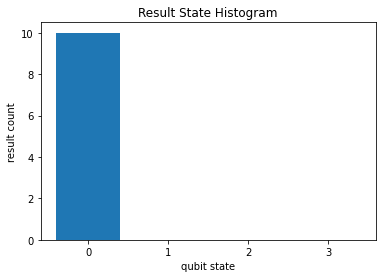

In [ ]:
_ = cirq.vis.plot_state_histogram(result, plt.subplot())

https://quantumai.google/reference/python/cirq/vis/integrated_histogram

In [ ]:
result.histogram(key="a,b")

Counter({0: 10})

https://github.com/The-Entangled-Qubits/Cirq_Basics/blob/master/Cirq%20Basics.ipynb

**Apply Identity Gate**

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

In [ ]:
# Define operations
ops=[cirq.I(a),
     cirq.I(b),
     cirq.measure(a,b)]

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───I───M───
          │
b: ───I───M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

Measurement results
a,b=0000000000, 0000000000


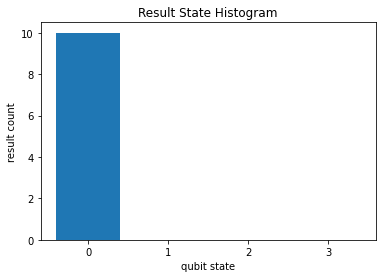

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

*0: 00, 1: 01, 2: 10, 3: 11*

In [ ]:
result.histogram(key="a,b")

Counter({0: 10})

###### **<font color="blue">1 Qubit - Hadamard Gate: Bring in Superposition and back**

Hadamard liegt auf X gegenuberliegend (+ und -)

> $a_{1}|0\rangle+a_{2}|1\rangle$

The Hadamard Gate is defined as follows:

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)$

A Hadamard matrix is an orthogonal matrix whose entries are all either +1 or -1. 

*Exercise: Apply Hadamard to state 0 and 1*

Apply Hadamard gate on a qubit that is in the |0> state:

* $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

The qubit enters a new state where the probability of measuring 0 is:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

And the probability of measuring 1 is also:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$


Now apply Hadamard gate on a qubit that is in the |1> state:

* $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}0 \\ 1\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ -1\end{array}\right]$

The qubit enters a new state where the probability of measuring 0 is:

* $\left(\frac{1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

And the probability of measuring 1 is also:

* $\left(\frac{-1}{\sqrt{2}}\right)^{2}=\frac{1}{2}$

Hence, in both cases (qubit |0> or qubit |1>) applying a Hadamard Gate gives an equal chance for the qubit to be 0 or 1' when measured.

Source: https://freecontent.manning.com/all-about-hadamard-gates/

*Superposition*

In [ ]:
cirq.unitary(cirq.H)

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [ 0.70710678+0.j, -0.70710678+0.j]])

**Single Qubit: Computational State vs Superposition State**

* By measuring the state we can get some idea about whether we have a computational state or a superposition state. 

* If the result appears probabilistic, we have a superposition state; if it's deterministic, we have a computational one. 

>Hadamard Gate: Bring a definite Qubit into a Superposition. Great for initialisations.


* Mathematically speaking, a state like the one above is a superposition of the states ∣0⟩ and ∣1⟩, but it is only a superposition state in the computational {∣0⟩,∣1⟩} basis.



The Hadamard states ∣+⟩ and ∣−⟩ are considered superposition states because they are a combination of the two computational states:

> $|\pm\rangle=\frac{1}{\sqrt{2}}|0\rangle \pm \frac{1}{\sqrt{2}}|1\rangle$

* The Hadamard gate rotates the state by 90∘

* the Hadamard states are where the bulk quantum computation usually occurs, as we saw when we first solved the counterfeit coin problem in a single quantum query.

* The first step of the algorithm is entering into the Hadamard basis, performing the computation, and then exiting out of the Hadamard basis to perform a deterministic measurement.

* Due to this composition, measuring the Hadamard states results in probabilistic measurements of ∣0⟩ and ∣1⟩. Using the "basis" terminology, these states are superpositions in the computational basis.
 
* In Hadamard basis, ∣+⟩ and ∣−⟩ are deterministic states. Naturally, ∣0⟩ and ∣1⟩ are deterministic states in the computational basis, and tey are superpositions in the Hadamard basis.

In order to leverage the superposition of qubits in a computational scheme and achieve quantum parallelism, we have to be able to prepare and manipulate probabilistic superposition states. These two uniform superposition states will be the workhorses of our computation, so they are given a special name—the Hadamard states—and special symbols showing they are a combination of ∣0⟩ and ∣1⟩:

There is more than one uniform superposition state "halfway" between ∣0⟩ and ∣1⟩. We've already seen several of these superpositions in the last chapter (without normalization). One is the most obvious, with both coefficients being real and positive:

> $\mathbf{H}|0\rangle$ = $|+\rangle=\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle=$ $\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 0\end{array}\right] + \frac{1}{\sqrt{2}}\left[\begin{array}{l}0 \\ 1\end{array}\right]$ = $\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

and another also has equal-magnitude coefficients, but with opposite signs:

> $\mathbf{H}|1\rangle$ = $|-\rangle=\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle=$ $\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 0\end{array}\right] - \frac{1}{\sqrt{2}}\left[\begin{array}{l}0 \\ 1\end{array}\right]$ = $\frac{1}{\sqrt{2}}\left[\begin{array}{c}1 \\ -1\end{array}\right]$

There are 2 Hadamard states - and +

Note: In the quantum circuit simulator, the coefficients in superposition are presented as decimals and complex numbers. For example, the coefficient:

> $1 / \sqrt{2} \approx(0.71+0 i)$

**Es ist 0i weil kein Anteil i auf der Position liegt. siehe S gate und fourier transform.**

(Recall that every nonzero complex number z = x + jy)

https://www.st-andrews.ac.uk/physics/quvis/simulations_html5/sims/blochsphere/blochsphere.html

https://physics.stackexchange.com/questions/313959/visual-interpretation-on-the-bloch-sphere-when-hadamard-gate-is-applied-twice

**Apply Hadarmard once: Set into superposition**

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

In [ ]:
# Define operations
ops=[cirq.H(a), # Superposition
     cirq.H(b),
     cirq.measure(a,b)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───H───M───
          │
b: ───H───M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

Measurement results
a,b=0001001110, 0101011001


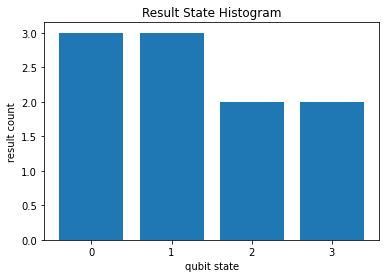

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

In [ ]:
result.histogram(key="a,b")

Counter({0: 3, 1: 3, 2: 2, 3: 2})

**Apply Hadamard twice: Bring back to original computational basis**

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

In [ ]:
# Define operations
ops=[cirq.H(a),
     cirq.H(b),
     cirq.H(a),
     cirq.H(b),
     cirq.measure(a,b)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───H───H───M───
              │
b: ───H───H───M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

Measurement results
a,b=0000000000, 0000000000


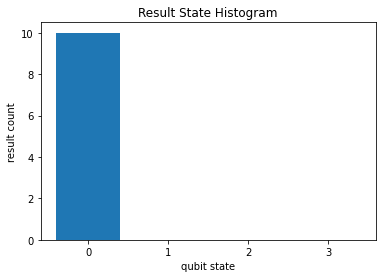

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

In [ ]:
result.histogram(key="a,b")

Counter({0: 10})

**A Black Box Puzzle**

the H operation has another trick up its sleeve: not only can it flip a computational state into a superposition, it can also do the opposite to transform different superpositions back into defined computational states:

> $|0\rangle+|1\rangle \stackrel{\mathbf{H}}{\longrightarrow}|0\rangle$

> $|0\rangle-|1\rangle \stackrel{\mathbf{H}}{\longrightarrow}|\mathbf{1}\rangle$

The superposition state that's output from the black box checker contains all the information we need to see which coins are counterfeit. By comparing some of the input terms to the output ones, we have the following (a property of a qubit state that is useful for computation, its **phase**):

> $\begin{array}{ll}+|1000\rangle \rightarrow+|1000\rangle & \text { No alarm } \\ +|0100\rangle \rightarrow+|0100\rangle & \text { No alarm } \\ +|0010\rangle \rightarrow-|0010\rangle & \text { Alarm! } \\ +|0001\rangle \rightarrow-|0001\rangle & \text { Alarm! }\end{array}$

In only one query, all the possible coin inputs that set off the alarm have been tagged with a minus sign (−).

**Herleitung Hadamard (Wichtig!)**

For an equal (or uniform) superposition of the two computational states, we can set the two coefficients equal to each other:

$a_{1}=a_{2}=a$

The normalization condition for a well-behaved quantum state requires that the sum of the squared magnitudes of the coefficients be equal to one; this is sufficient to find 
a
a for a uniform superposition:

$|a|^{2}+|a|^{2}=1$

$2|a|^{2}=1$

$|a|^{2}=\frac{1}{2}$

$a=\frac{1}{\sqrt{2}}$

In vector form, this state can represented as

> $\left[\begin{array}{l}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ = $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 1 \\ 0 \end{array}\right]$ + $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 0 \\ 1 \end{array}\right]$

This is what we can use now to understand Hadamard, where you want "halfway" a 50/50 chance of basis states 0 and 1 (Bloch sphere representation of superposition state):

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_025.jpg)

**Exercise**

You have a deterministic basis state 0, then apply H to get superposition between basis state 0 and basis state 1:

$(0.71+0.00 i)|0\rangle$

$(0.71+0.00 i)|1\rangle$

Apply X gate to flip from basis state 0 to basis state 1 deterministically, then apply H. Outcome:

$(0.71+0.00 i)|0\rangle$

$(-0.71+0.00 i)|1\rangle$

Notice how both end up in probabilistics 50/50 chance, but lower is minus

probability is the same, but maybe since we started in two different deterministic states, up and down, das vorzeichen ist anders (???)

**Hadamard Gate**

>Bring a definite Qubit into a Superposition. Great for initialisations.

The Hadamard gate has the characteristically quantum capacity to **transform a definite quantum state, such as spin-up, into a murky one, such as a superposition of both spin-up and spin-down at the same time**. Once you send a spin-up or spin-down electron through an H-gate, it will become like a penny standing on its end, with precisely 50/50 odds that it will end up heads (spin-up) or tails (spin-down) when toppled and measured. **This H-gate is extremely useful for performing the first computation in any quantum program because it transforms pre-set, or initialized, qubits back into their natural fluid state in order** to leverage their full quantum powers.

* ist ein Quantengatter, das sich auf einzelne Quantenbits bezieht (acts on a single qubit)

* creates a superposition: Überführt $|0\rangle$ und $|1\rangle$ in überlagerte Zustände. 

> It maps the basis state $|0\rangle$ to $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$ and $|1\rangle$ to $\frac{|0\rangle-|1\rangle}{\sqrt{2}}$, which means that a measurement will have equal probabilities to result in 1 or 0 (i.e. creates a superposition). 

* Spiegelung des hyperkomplexen Eingangs an der X+Z-Achse. It represents a rotation of $\pi$ about the axis $(\hat{x}+\hat{z}) / \sqrt{2}$ at the Bloch sphere. It is represented by the Hadamard matrix:

> $\frac{1}{\sqrt{2}} \cdot\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)$

See more: https://en.m.wikipedia.org/wiki/Hadamard_transform#Quantum_computing_applications

In quantum computing, the Hadamard gate is a one-qubit rotation, mapping the qubitbasis states $|0\rangle$ and $|1\rangle$ to two **superposition** states with **equal weight of the computational basis** states $|0\rangle$ and $|1\rangle$. Usually the phases are chosen so that

>$
H=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\langle 0|+\frac{|0\rangle-|1\rangle}{\sqrt{2}}\langle 1|
$

in Dirac notation. This corresponds to the transformation matrix

> $
H_{1}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)
$

in the $|0\rangle,|1\rangle$ basis, also known as the computational basis. The states $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$ and $\frac{|0\rangle-|1\rangle}{\sqrt{2}}$ are known as $|+\rangle$ and $|-\rangle$ respectively, and together constitute the polar basis in quantum computing.

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_017.jpeg)

*Hadamard gate operations:*

> $\begin{aligned} H(|0\rangle) &=\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle=:|+\rangle \\ H(|1\rangle) &=\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle=:|-\rangle \\ H\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) &=\frac{1}{2}(|0\rangle+|1\rangle)+\frac{1}{2}(|0\rangle-|1\rangle)=|0\rangle \\ H\left(\frac{1}{\sqrt{2}}|0\rangle-\frac{1}{\sqrt{2}}|1\rangle\right) &=\frac{1}{2}(|0\rangle+|1\rangle)-\frac{1}{2}(|0\rangle-|1\rangle)=|1\rangle \end{aligned}$

One application of the Hadamard gate to either a 0 or 1 qubit will produce a quantum state that, if observed, **will be a 0 or 1 with equal probability** (as seen in the first two operations). This is exactly like flipping a fair coin in the standard probabilistic model of computation. However, if the Hadamard gate is applied twice in succession (as is effectively being done in the last two operations), then the final state is always the same as the initial state (because quantum operations are reversable, unlike operations on classical computers).

Computing the quantum Hadamard transform is simply the **application of a Hadamard gate to each qubit individually because of the tensor product structure of the Hadamard transform**. This simple result means the quantum Hadamard transform requires log  n operations, compared to the classical case of n log n operations.

**Many quantum algorithms use the Hadamard transform as an initial step, since it maps $m$ qubits initialized with $|0\rangle$ to a superposition of all $2^{m}$ orthogonal states in the $|0\rangle,|1\rangle$ basis with equal weight**. 

For example, this is used in the Deutsch-Jozsa algorithm, Simon's algorithm, the Bernstein-Vazirani algorithm, and in Grover's algorithm. Note that Shor's algorithm uses both an initial Hadamard transform, as well as the quantum Fourier transform, which are both types of Fourier transforms on finite groups; the first on $(\mathbb{Z} / 2 \mathbb{Z})^{n}$ and the second on $\mathbb{Z} / 2^{n} \mathbb{Z}$.

###### **<font color="blue">1 Qubit - Pauli Gates: Rotation operator gates SO(3) & SU(2) on Bloch Sphere</font>**

Single spin one half particle, focus on spin degrees of freedom: 

* when the spin degrees of freedom interact with an electromagnetic field, the Pauli matrices come into play:

> $\sigma^{Z}=\left(\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right) \quad \sigma^{X}=\left(\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right) \quad \sigma^{Y}=\left(\begin{array}{cc}0 & -i \\ i & 0\end{array}\right)$

* we have chosen a basis in such a way that the Pauli Z matrix is diagonal. Here are its basis vectors, the spin up in the z direction and the spin down direction, written as column vectors:

> $|\uparrow\rangle=\left(\begin{array}{l}1 \\ 0\end{array}\right) \quad 1 \downarrow=\left(\begin{array}{l}0 \\ 1\end{array}\right)$

* we can re-express the basis vectors for the Pauli X matrix in either direction in terms of these vectors, but in the positive direction we can write it in the following way:

> $|\rightarrow\rangle=\frac{1}{\sqrt{2}}(|\uparrow\rangle+|\downarrow\rangle)$

http://akyrillidis.github.io/notes/quant_post_7

https://en.m.wikipedia.org/wiki/Quantum_logic_gate#Rotation_operator_gates

https://en.m.wikipedia.org/wiki/Rotation_operator_(quantum_mechanics)

###### **<font color="blue">1 Qubit - Pauli-X Gate: Flip Computational States**

Nice visualisations: https://medium.com/analytics-vidhya/quantum-gates-7fe83817b684

The Pauli gates $(X, Y, Z)$ are the three Pauli matrices $\left(\sigma_{x}, \sigma_{y}, \sigma_{z}\right)$ and act on a single qubit. The Pauli $X_{1} Y$ and $Z$ equate, respectively, to a rotation around the $x, y$ and $z$ axes of the Bloch sphere by $\pi$ radians.

The Pauli- $X$ gate is the quantum equivalent of the [NOT gate](https://en.m.wikipedia.org/wiki/Inverter_(logic_gate)) for classical computers (its main function is to invert the input signal applied) with respect to the standard basis $|0\rangle,|1\rangle$, which distinguishes the $z$ axis on the Bloch sphere. It is sometimes called a bit-flip as it maps $|0\rangle$ to $|1\rangle$ and $|1\rangle$ to $|0\rangle .$ 

> $X=\sigma_{x}=\mathrm{NOT}=\left[\begin{array}{ll}0 & 1 \\ 1 & 0\end{array}\right]$

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

*Flip the state of the first qubit, but not the second*

In [ ]:
# Define operations
ops=[cirq.X(a),
     cirq.measure(a,b)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───X───M───
          │
b: ───────M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

Measurement results
a,b=1111111111, 0000000000


* first is 1, second is all 0

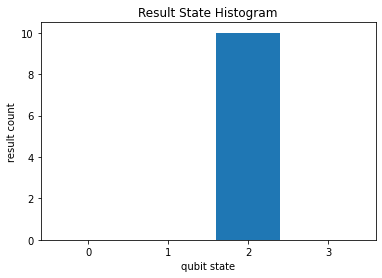

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

* 0: 00, 1: 01, 2: 10, 3: 11

In [ ]:
result.histogram(key="a,b")

Counter({2: 10})

*Measurement result if you flip both states*

In [ ]:
# Define operations
ops=[cirq.X(a),
     cirq.X(b),
     cirq.measure(a,b)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───X───M───
          │
b: ───X───M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

Measurement results
a,b=1111111111, 1111111111


* both are 1 now

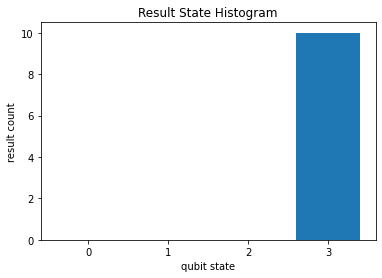

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

In [ ]:
result.histogram(key="a,b")

Counter({3: 10})

**Square Root of Pauli-X Gate**

The square root of NOT gate (or square root of Pauli- $X, \sqrt{X}$ ) acts on a single qubit. It maps the basis state $|0\rangle$ to $\frac{(1+i)|0\rangle+(1-i)|1\rangle}{2}$ and $|1\rangle$ to $\frac{(1-i)|0\rangle+(1+i)|1\rangle}{2} .$ 

In matrix form it is given by

>$
\sqrt{X}=\sqrt{\mathrm{NOT}}=\frac{1}{2}\left[\begin{array}{cc}
1+i & 1-i \\
1-i & 1+i
\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{cc}
e^{i \pi / 4} & e^{-i \pi / 4} \\
e^{-i \pi / 4} & e^{i \pi / 4}
\end{array}\right]$

such that

>$
(\sqrt{X})^{2}=(\sqrt{\mathrm{NOT}})^{2}=\left[\begin{array}{ll}
0 & 1 \\
1 & 0
\end{array}\right]=X
$

> **This operation represents a rotation of $\pi / 2$ about $x$ -axis at the Bloch sphere**.

###### **<font color="blue">1 Qubit - Pauli-Y Gate: Phase Flip between i and -i**

Similarly, the Pauli- $Y$ maps $|0\rangle$ to $i|1\rangle$ and $|1\rangle$ to $-i|0\rangle$ (NOT gate with i-multiple):

> $Y=\sigma_{y}=\left[\begin{array}{cc}0 & -i \\ i & 0\end{array}\right]$

###### **<font color="blue">1 Qubit - Pauli-Z Gate: $\pi$ Flip Phase between +1 and -1**

Z flippt zwischen den Polen der X Achse (+ und -)

**Pauli-Z Gate**

Pauli $Z$ leaves the basis state $|0\rangle$ unchanged and maps $|1\rangle$ to $-|1\rangle$. Due to this nature, it is sometimes called **phase-flip** (flips sign of second entangled state):

> $Z=\sigma_{z}=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right]$

* Pauli Z gate is a phase flip gate that causes rotation around the z-axis by π radians.

> $Z=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right] \quad Z=|0\rangle\langle 0|-| 1\rangle\langle 1|$

* Since |0⟩ and |1⟩ lie on the z-axis, the Z-gate will not affect these states. To put it in other terms **|0⟩ and |1⟩ are the two eigenstates of the Z-gate**. On the other hand, it flips |+⟩ to |-⟩ and |-⟩ to |+⟩.

In the counterfeit coin puzzle we solved in the introduction, at one point the counterfeit information we were trying to retrieve from a state was represented as the sign of a state. Along with changing the magnitude of a state's coefficients, changing their phase (or sign) can be an important way to operate on a qubit. We do this with the Z gate:

> $\mathbf{Z}|0\rangle=|0\rangle$

> $\mathbf{Z}|1\rangle=-|1\rangle$

The Z gate is like the X gate but in the hadamard basis, flipping states

**Pauli Matrices in general**

The Pauli matrices are [involutory](https://en.m.wikipedia.org/wiki/Involutory_matrix) (a square matrix that is its own inverse), meaning that the square of a Pauli matrix is the identity matrix.

>$
I^{2}=X^{2}=Y^{2}=Z^{2}=-i X Y Z=I
$

The Pauli matrices also [anti-commute](https://en.m.wikipedia.org/wiki/Anticommutative_property), for example $Z X=i Y=-X Z$.

*Anticommutativity is a specific property of some non-commutative operations. In mathematical physics, where symmetry is of central importance, these operations are mostly called antisymmetric operations, and are extended in an associative setting to cover more than two arguments. **Swapping the position of two arguments of an antisymmetric operation yields a result which is the inverse of the result with unswapped arguments**. The notion inverse refers to a group structure on the operation's codomain, possibly with another operation, such as addition.*

Z Gate flippt zwischen den Hadamard gegenüberliegenden Richtungen auf der X-Achse:

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_058.jpg)

###### **<font color="blue">1 Qubit - Pauli-S Gate: $\frac{\pi}{2}$ Flip Phase between Z and Y (with $\mu$=i and $\nu$=-i)**

* S flippt zwischen den Polen der Y Achse (i und -i). 

* Wenn man im Hadamard + Status beginnt, und wendet dann ein S -Gate an, entspricht das einer Rotation $\pi$/2 (siehe Rechnung unten). Das entspricht $\mu$ und ist i.

* und um auf sie gegenüberliegende Y-Achsenseite zu kommen, wendet man $3*\pi$/2 an. Das entspricht $\nu$ und ist -i.

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")

#Line-Qubit
qubits = cirq.LineQubit.range(1)

In [ ]:
# Define operations
ops=[cirq.H(a),
#     cirq.I(a), # bei I from 0 zu 100%
#     cirq.Z(a), # bei Z from 1 zu 100%
#     cirq.S(a), # bei kommt 50% 0 und 50% 1 raus
     cirq.T(a), # bei kommt 75% 0 und 25% 1 raus -> ??? really?
     cirq.H(a),
     cirq.measure(a)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───H───T───H───M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10000)
print('Measurement results')
print(result)

Measurement results
a=000000101000000000000000000001000001001010000000000000001010000000010010000010000000000000110000010000000000000001000000010000000100000000000000000000100000100000010000100001000000000000000001000000001001010000000010011000110100010010010000100001000000001000001000000001110000010000000000010100010001000000000000000000001000001000100101000000000000100000100000001010000010000000000010000110000000000000000000001010000000000000000001001000001000000000000000000100000000000000000001000000101000000100001000000000000000010001000010101000010000000000010000000000000001000111000010000000000100000010000000000000101010000000001000000000000110000001100000000101000100010100000010000000000000000100100000001000000010001000001000100001010000000000010000000000000000000000000000010000100000000000001100000100000010000100100000000001000010100000100000001100010000000000000000001001100000000010000000000010010101010000000010001010010001000010100000001000000000101100010000000000100000000000

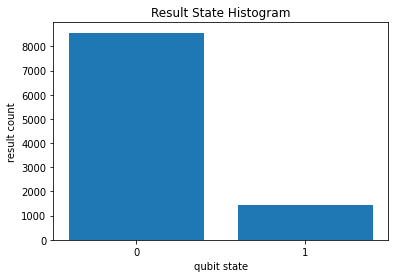

In [ ]:
# Visualization
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

In [ ]:
result.histogram(key="a")

Counter({0: 8563, 1: 1437})

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_060.jpg)

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_059.jpg)

* fintuning Z gate in der Hadamard basis

* S-gate is die Hälfte vom Z-Gate, und R-Gate ein viertel vom Z-Gate

Consider a new gate that we'll call $\mathbf{S}$. If $\mathbf{S}$ is applied twice to $|+\rangle$ we end up at $|-\rangle$, but if it is applied once we get a middle state $|\mu\rangle$ that is neither $|+\rangle$ nor $|-\rangle$ :

$\mathbf{S}^{2}|+\rangle=|-\rangle$

$\mathbf{S}|+\rangle=|\mu\rangle$

In terms of Z, S is:

$\mathbf{S}=\sqrt{\mathbf{Z}}$

The phase gate $\mathbf{Z}$ transforms $|+\rangle$ to $|-\rangle$, and we can find the gate that does "half of" this transformation by finding the square root of the matrix $\mathbf{Z}$ :

> $\sqrt{\mathbf{Z}}={S}=\left[\begin{array}{cc}1 & 0 \\ 0 & \sqrt{-1}\end{array}\right]=\left[\begin{array}{cc}1 & 0 \\ 0 & i\end{array}\right]$

Use the matrix $\mathbf{S}$ to find the state $|\mu\rangle$ which is "halfway" between $|+\rangle$ and $|-\rangle$ :

> $\mathbf{S}|+\rangle=|\mu\rangle$, which is:

> $|\mu\rangle=\frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle)$

If you begin with $|+\rangle$ and apply the $\mathbf{S}$ gate three times in a row, you find a new state, $|\nu\rangle$ which appears to mirror the complex state $|\mu\rangle$ :

> $|\mu\rangle=\frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle)$

> $|\nu\rangle=\frac{1}{\sqrt{2}}(|0\rangle-i|1\rangle) .$

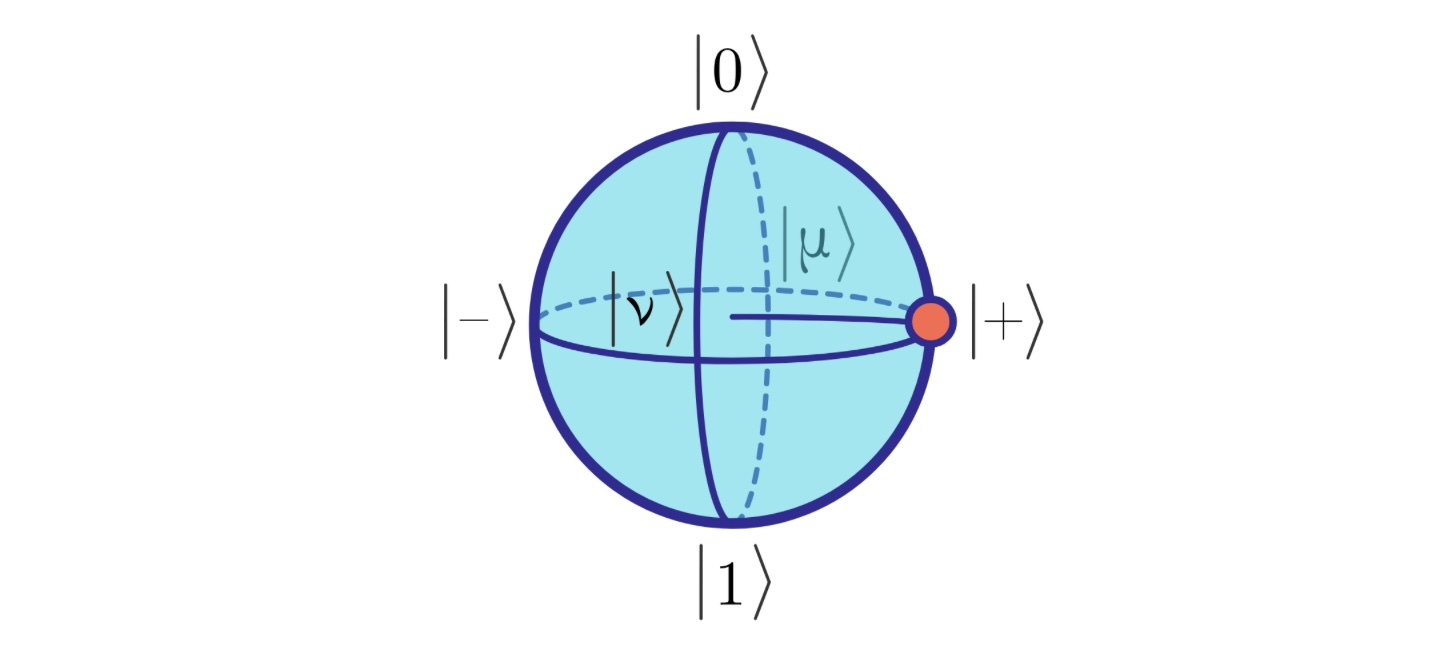

S mit i und -i scheint auf der x-Achse zu liegen....??

See on bloch sphere here: https://javafxpert.github.io/grok-bloch/

In [ ]:
from cirq_web import BlochSphere

# Prepare a state
zero_state = [1+0j, 0+0j]
state_vector = cirq.to_valid_state_vector(zero_state)

# Create and display the Bloch sphere
sphere = BlochSphere(state_vector=state_vector)
display(sphere)

###### **<font color="blue">1 Qubit - T Gate $\frac{\pi}{4}$ and R8 Gate $\frac{\pi}{8}$: Change Phase(Parametrizing it as continuous)**

Calculate the algreba of T-gate applied:

$\mathbf{T}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right] \quad$

First we have a qubit in state 0 and apply Hadamard:

$\left[\begin{array}{l}\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}}\end{array}\right]$ = $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 1 \\ 0 \end{array}\right]$ + $\frac{1}{\sqrt{2}}$ $\left[\begin{array}{c} 0 \\ 1 \end{array}\right]$

$
H=\frac{|0\rangle+|1\rangle}{\sqrt{2}}\langle 0|+\frac{|0\rangle-|1\rangle}{\sqrt{2}}\langle 1|
$

in Dirac notation. This corresponds to the transformation matrix

$
H_{1}=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)
$


**Fur H->T->H we have:**

$H=\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)$ 
$\otimes$ 
$\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right]$
$\otimes$ 
$\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)$

First Hadamard * Hadamard = Identity

> $\frac{1}{\sqrt{2}}\left(\begin{array}{cc}1 & 1 \\ 1 & -1\end{array}\right)\left[\begin{array}{l}1 \\ 0\end{array}\right]=\frac{1}{\sqrt{2}}\left[\begin{array}{l}1 \\ 1\end{array}\right]$

$\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)$ 
$\otimes$ 
$\frac{1}{\sqrt{2}}\left(\begin{array}{cc}
1 & 1 \\
1 & -1
\end{array}\right)$ = $0,5*\left(\begin{array}{cc}
1 & 1 \\
1 & 1
\end{array}\right)$ =  ????? 


das müsste rauskommen: $I=\left[\begin{array}{ll}1 & 0 \\ 0 & 1\end{array}\right]$

We 've already uncovered the gates we need to perform any rotations around the $x$ - and $z$-axes, which can bring us from an initialized qubit to any other quantum state.

Unfortunately, this result comes with a pretty serious caveat: all of the gates we have used so far are discrete. They perform rotations around the Bloch sphere, but since they rotate in discrete hops (of $\pi / 2$ or $\pi$ ), they are unable to reach most of the intermediate states on the surface of the sphere.

One solution to this problem is to define smaller and smaller rotations around these axes. The gate $\mathbf{S}$ is equal to $\sqrt{\mathbf{Z}}$ and halves its rotation angle from $\pi$ to $\pi / 2$. Even greater division of these gates is possible, and some of them have
common names:

$\mathbf{Z}=\mathbf{Z}=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right]$ Rotation: $\pi$

$\mathbf{S}=\sqrt[2]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & i\end{array}\right]$ Rotation: $\pi / 2$


$\mathbf{T}=\sqrt[4]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 4}\end{array}\right] \quad$ Rotation: $\pi / 4$

$\mathbf{R 8}=\sqrt[8]{\mathbf{Z}}=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi / 8}\end{array}\right] \quad$ Rotation: $\pi / 8 .$

Controlled R-Gate: ([Source](https://jonathan-hui.medium.com/qc-quantum-fourier-transform-45436f90a43))

> $\hat{R}_{k}=\left(\begin{array}{cc}1 & 0 \\ 0 & e^{2 \pi i / 2^{k}}\end{array}\right)$

**Simplifying (Decomposing)**

Consider the general 1 -qubit state

>$
a_{1}|0\rangle+a_{2}|1\rangle
$

Each of these coefficients can be a complex number, which has both a magnitude and a phase, meaning each qubit totals four continuous variables:

>$
A_{1} e^{i \alpha_{1}}|0\rangle+A_{2} e^{i \alpha_{2}}|1\rangle
$

We can get some clues for how to reach an arbitrary qubit state with minimal operations by decomposing this general form into its essential components.



Which trigonometric identity reflects a fundamental property of quantum states and can simplify this general qubit state?

> $\sin ^{2} \theta+\cos ^{2} \theta=1$

**Adding the constraint of normalization was all we needed to finish decomposing a qubit state down to its simplest form**:

> $\cos (\theta / 2)|0\rangle+e^{i \phi} \sin (\theta / 2)|1\rangle$

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_034.jpg)

Source: https://youtu.be/I6MZgIdv6To

**Remember: Any point on a unit sphere can be described by only two variables: polar angle θ and azimuthal angle ϕ.**

![ggg](https://raw.githubusercontent.com/deltorobarba/repo/master/quantum_033.jpg)

This expression for a general qubit can describe any of the states we've considered thus far, and each state will have a unit pair of angular parameters $\theta$ and $\phi:$

> $
\cos (\theta / 2)|0\rangle+e^{i \phi} \sin (\theta / 2)|1\rangle
$

Consider the state of an initialized qubit: $|0\rangle$. This state is parameterized by the relatively straightforward $\theta=0, \phi=0$. The Hadamard state $|+\rangle$ is parameterized by $\theta=\pi / 2, \phi=0 .$ 

Try it for yourself in the Bloch sphere model below. As $\theta$ increases from 0 , the state is rotated around the $x$-axis, and as $\phi$ increases, the state is rotated around the $z$-axis.

**Making it continuous**

While defining gates with smaller and smaller rotations will yield greater coverage of the Bloch sphere, a set of discrete gates will never be able to accomplish truly universal quantum computation, even with one qubit.

The solution of this involves taking the limit of the progression above and find a continuous version of the $\mathbf{Z}$ and $\mathbf{X}$ gates. The math for this involves matrix exponentiation.

The continuous $\mathbf{Z}$ and $\mathbf{X}$ gates are often written as $\mathbf{R}_{x}(\theta)$ and $\mathbf{R}_{z}(\phi)$ :

> $\mathbf{R}_{x}(\theta)=\left[\begin{array}{cc}\cos \frac{\theta}{2} & -i \sin \frac{\theta}{2} \\ -i \sin \frac{\theta}{2} & \cos \frac{\theta}{2}\end{array}\right]$

> $\mathbf{R}_{z}(\phi)=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \phi / 2}\end{array}\right]$

###### **<font color="blue">Phase Shift Gates $R$ bzw. manchmal auch $P$ & Controlled Phase Shift</font>**

* The generic phase shift gate rotates z by an arbitrary θ. It changes the phase of |1⟩.

* verandern die Wahrscheinlichkeiten in einem Qubit, mit dem es bei Messungen entweder in den Zustand 1 oder 0 verfallt.

The phase shift is a family of single-qubit gates that map the basis states $|0\rangle \mapsto|0\rangle$ and $|1\rangle \mapsto e^{i \varphi}|1\rangle .$ 

**The probability of measuring a $|0\rangle$ or $|1\rangle$ is unchanged after applying this gate, however it modifies the phase of the quantum state**. 

This is equivalent to conditionally tracing a horizontal circle (a line of latitude) on the Bloch sphere by $\varphi$ radians. The phase shift gate is represented by the matrix:

>$
P(\varphi)=\left[\begin{array}{ll}
1 & 0 \\
0 & e^{i \varphi}
\end{array}\right]
$

<u>where $\varphi$ is the phase shift with the period $2 \pi$</u>. Some common examples are the $T$ gate where $\varphi=\frac{\pi}{4}$, the phase gate (written $S$, though $S$ is sometimes used for SWAP gates) where $\varphi=\frac{\pi}{2}$ and the Pauli- $Z$ gate where $\varphi=\pi$.

The phase shift gates are related to each other as follows:

> $Z=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \pi}\end{array}\right]=\left[\begin{array}{cc}1 & 0 \\ 0 & -1\end{array}\right]=P(\pi)$

> $S=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \frac{\pi}{2}}\end{array}\right]=\left[\begin{array}{ll}1 & 0 \\ 0 & i\end{array}\right]=P\left(\frac{\pi}{2}\right)=\sqrt{Z}$

> $T=\left[\begin{array}{cc}1 & 0 \\ 0 & e^{i \frac{\pi}{4}}\end{array}\right]=P\left(\frac{\pi}{4}\right)=\sqrt{S}=\sqrt[4]{Z}$

> $P\left(\frac{\pi}{\xi}\right)=\sqrt[\xi]{Z}$ for all real $\xi \operatorname{except} 0$

**Controlled phase shift**

The 2 -qubit controlled phase shift gate is:

>$
\text { CPHASE }(\varphi)=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & e^{i \varphi}
\end{array}\right]
$

With respect to the computational basis, it shifts the phase with $\varphi$ only if it acts on the state $|11\rangle$ :

$
|a, b\rangle \mapsto\left\{\begin{array}{ll}
\left|a, e^{i \varphi} b\right\rangle & \text { for } a=b=1 \\
|a, b\rangle & \text { otherwise }
\end{array}\right.
$

The CZ gate is the special case where $\varphi=\pi$.

phi: $\phi$ bzw $\varphi$ is azimuth = phase

theta: θ or ϑ (theta) is other component

###### **<font color="black">1 Qubit - Hadamard + Pauli-X Gate:  Flip Computational States via Phase Shift Operators**

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

In [ ]:
# Define operations
ops=[cirq.H(a),
     cirq.H(b),
     cirq.S(a),
     cirq.I(b),
     cirq.H(a),
     cirq.H(b),
     cirq.measure(a,b)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───H───S───Y───H───M───
                      │
b: ───H───I───H───────M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=100)
print('Measurement results')
print(result)

Measurement results
a,b=0111010111011101110001101011101100101111000001110001110000011101111001101011101001010001001010111011, 0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


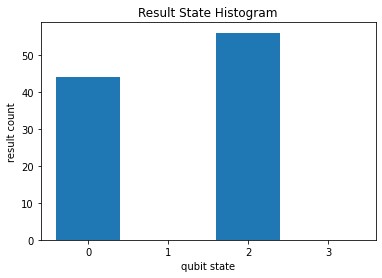

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

*0: 00, 1: 01, 2: 10, 3: 11*

*As expected: Qubit 1 flipped its computational state, because the phase flipped with the Z-gate, and applying another Hadamard Gate turns it into 1 state*

In [ ]:
result.histogram(key="a,b")

Counter({2: 1000})

###### **<font color="blue">2 Qubits - Swap Gate (& Swap Square root): Swap two Qubits (like in Quantum Fourier Transform)</font>**

The swap gate **swaps two qubits**. 

With respect to the basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$, it is represented by the matrix:

>$
\text { SWAP }=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$

**Square root of swap gate**

The $\sqrt{\text { SWAP }}$ gate performs half-way of a two-qubit swap. 

It is universal such that any many-qubit gate can be constructed from only $\sqrt{\text { SWAP }}$ and single qubit gates. 

The $\sqrt{\text { SWAP }}$ gate is not, however maximally entangling; more than one application of it is required to produce a Bell state from product states. 

With respect to the basis $|00\rangle,|01\rangle,|10\rangle,|11\rangle$, it is represented by the matrix:

>$
\sqrt{\mathrm{SWAP}}=\left[\begin{array}{cccc}
1 & 0 & 0 & 0 \\
0 & \frac{1}{2}(1+i) & \frac{1}{2}(1-i) & 0 \\
0 & \frac{1}{2}(1-i) & \frac{1}{2}(1+i) & 0 \\
0 & 0 & 0 & 1
\end{array}\right]
$

This gate arises naturally in systems that exploit exchange interaction.

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")

#Line-Qubit
qubits = cirq.LineQubit.range(2)

In [ ]:
# Define operations
ops=[cirq.X(a), # Flip state 0 to state 1 in first qubit
     cirq.SWAP(a,b), # Swap states: qubit 2 is now in state 1
     cirq.measure(a,b)]

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───X───×───M───
          │   │
b: ───────×───M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

Measurement results
a,b=0000000000, 1111111111


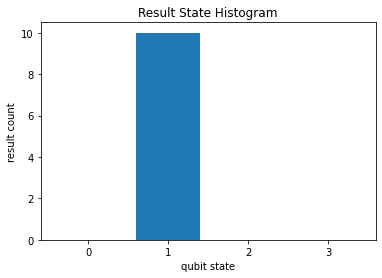

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

In [ ]:
result.histogram(key="a,b")

Counter({1: 10})

###### **<font color="blue">3 Qubits - Toffoli gate (CCNOT): Negate a target bit if both control qubits are 1</font>**

TOFFOLI gate can be used to simulate standard boolean operations. It negates a target bit if both control qubits are 1.

> The Toffoli gate is related to the classical AND $(\wedge)$ and XOR $(\oplus)$ operations as it performs the mapping $|a, b, c\rangle \mapsto|a, b, c \oplus(a \wedge b)\rangle$ on states in the computational basis.

* The [Toffoli gate](https://en.m.wikipedia.org/wiki/Toffoli_gate), named after Tommaso Toffoli; also called CCNOT gate or Deutsch gate $D(\pi / 2)$; is a 3-bit gate, which is universal for classical computation but not for quantum computation. 

* The quantum Toffoli gate is the same gate, defined for 3 qubits. If we limit ourselves to only accepting input qubits that are $|0\rangle$ and $|1\rangle$, then if the first two bits are in the state $|1\rangle$ it applies a Pauli- $X$ (or NOT) on the third bit, else it does nothing. 

* It is an example of a controlled gate. Since it is the quantum analog of a classical gate, it is completely specified by its truth table. The Toffoli gate is universal when combined with the single qubit Hadamard gate. $^{[13]}$

> The Toffoli gate is essentially the atom of mathematics. It is the simplest element, from which every other problem-solving technique can be compiled.

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
c = cirq.NamedQubit("c")

#Line-Qubit
qubits = cirq.LineQubit.range(3)

In [ ]:
# Define operations
ops=[cirq.X(a), # Flip computational state of first qubit to 1
     cirq.X(b), # Flip computation state of second qubit to 1
     cirq.X(c), # Flip computation state of thirs qubit to 1, 
     # this third qubit will be flipped back to 0 with Toffoli gate
     cirq.CCX(a,b,c), # Toffoli gate
     cirq.measure(a,b,c)] # Measurement

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───X───@───M───
          │   │
b: ───X───@───M───
          │   │
c: ───X───X───M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

Measurement results
a,b,c=1111111111, 1111111111, 0000000000


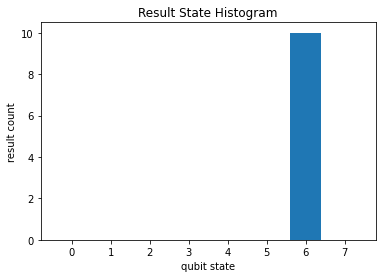

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

6 in binary is: 110, which is the desired result (last qubit fliped/negated, when first tow are in state 1)

In [ ]:
result.histogram(key="a,b,c")

Counter({6: 10})

https://qiskit.org/textbook/ch-states/atoms-computation.html#adder:

To calculate this part of the output, we could just get our computer to look at whether both of the inputs are 1. If they are — and only if they are — we need to do a NOT gate on qubit 3. That will flip it to the required value of 1 for this case only, giving us the output we need.

For this, we need a new gate: like a CNOT but controlled on two qubits instead of just one. **This will perform a NOT on the target qubit only when both controls are in state 1. This new gate is called the Toffoli.** For those of you who are familiar with Boolean logic gates, it is basically an AND gate.

###### **<font color="blue">3 Qubits - Fredkin Gate (CSWAP or CS): Swap identity gate for qubit 2+3, if qubit 1 is in state 1</font>**

The [Fredkin gate](https://en.m.wikipedia.org/wiki/Fredkin_gate) (also CSWAP or CS gate), named after Edward Fredkin, is a 3-bit gate that performs a controlled swap. It is universal for classical computation. 

It has the useful property that the numbers of 0s and 1s are conserved throughout, which in the billiard ball model means the same number of balls are output as input.



The basic Fredkin gate[1] is a controlled swap gate that maps three inputs (C, I1, I2) onto three outputs (C, O1, O2). The C input is mapped directly to the C output. 

If C = 0, no swap is performed; I1 maps to O1, and I2 maps to O2. 

Otherwise, the two outputs are swapped so that I1 maps to O2, and I2 maps to O1. 

In [ ]:
# Create Vanilla Qubits
# Named Qubit
a = cirq.NamedQubit("a")
b = cirq.NamedQubit("b")
c = cirq.NamedQubit("c")

#Line-Qubit
qubits = cirq.LineQubit.range(3)

In [ ]:
# Define operations
ops=[cirq.X(a),
     cirq.X(b), # qubit b is now in state 1, cswap will swap this with qubit c
     cirq.I(c), # qubit c stays in state 0
     cirq.CSWAP(a,b,c),
     cirq.measure(a,b,c)]

# Build circuit
circuit=cirq.Circuit(ops)

print(circuit)

a: ───X───@───M───
          │   │
b: ───X───×───M───
          │   │
c: ───I───×───M───


In [ ]:
# Run Simulations & Measurements
simulator = cirq.Simulator()
result = simulator.run(circuit,repetitions=10)
print('Measurement results')
print(result)

Measurement results
a,b,c=1111111111, 0000000000, 1111111111


*As expected, qubit b swapped to state 0, and qubit c to state 1, when qubit a is in state 1. The identity gates are swapped between qubit 2 and 3.*

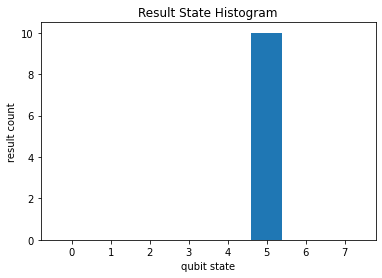

In [ ]:
# Visualization
# After doing that, you should see the quantum state become ∣00⟩+∣11⟩
_ = cirq.vis.plot_state_histogram(result) #, plt.subplot())

In [ ]:
result.histogram(key="a,b,c")

Counter({5: 10})